In [23]:
# Written by Itinderjot Singh (I.T.) of the Cloud Systems Research Group (headed by Prof. Nesbitt) at
# the University of Illinois Urbana-Champaign

import pandas as pd
from IPython.display import display, clear_output
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from metpy.units import units
import datetime
# More color tables obtained from https://github.com/scaine1/pyWRF/blob/master/library/coltbls.py
import coltbls as coltbls
# NCL colormaps for python; obtained from https://github.com/samwisehawkins/nclcmaps
import nclcmaps as ncm
import xarray as xr
import matplotlib as mpl
import glob
import os
import matplotlib.pyplot as pyplot
import numpy as np
%pylab inline
# matplotlib date format modules

Populating the interactive namespace from numpy and matplotlib


/home/isingh9/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interp', 'exp', 'square']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [24]:
# Call all the modules/functions/methods used in segmentation and obtaining of features such as downdrafts, updrafts,
# convergence lines, etc. in the tracking code.

from skimage.measure import label, regionprops
from skimage.transform import rotate
from skimage.segmentation import clear_border
from skimage.morphology import closing, square
import matplotlib.patches as mpatches
from skimage.morphology import flood

In [25]:
# Call all the modules used in sounding functions

# Metpy
from metpy.units import units as munits
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

##################################################
# SharpPy: https://github.com/sharppy/SHARPpy/archive/refs/heads/master.zip
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

# Matplotlib helper modules/functions for skew-T
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection

In [26]:
# wrf-python modules needed for interpolation of CM1 output (which is on model levels) to fixed height levels
# and for plotting vertical cross-sections along random angles

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, vertcross, CoordPair, GeoBounds)

In [27]:
# Master setting for all the fontsizes throughout the notebook

rc('mathtext', default='regular')
#matplotlib.rcParams.update({'font.size': 16})
#matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.facecolor'] = [1., 1., 1.]
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 0.25

In [28]:
# assign all the frquently used colormaps nicknames

from metpy.plots import ctables
cma1 = plt.get_cmap('bwr')
cma2 = ctables.registry.get_colortable('NWSReflectivity')
cma3 = plt.get_cmap('tab20c')
cma4 = ncm.cmap("WhiteBlueGreenYellowRed")
cma5 = plt.get_cmap('gray_r')

# Helper routines to be run before plotting 

## Open a CM1 output file using xarray

In [29]:
direc = '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km/'  # expanse
#direc = '/home1/04167/tg834661/scratch/stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km/'     #stampede2

filename = "cm1out_000090.nc"

data = xr.open_dataset(direc+filename)
print(data.time)

<xarray.DataArray 'time' (time: 1)>
array([26700000000000], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 07:25:00
Attributes:
    long_name:  time since beginning of simulation
    axis:       T


(400.0, 600.0)

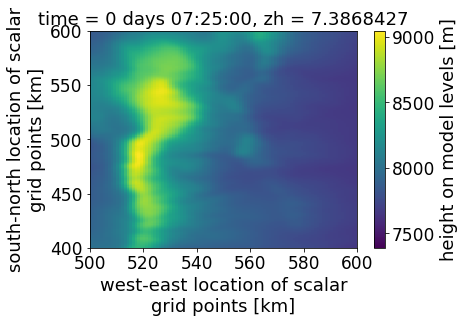

In [30]:
# test plot a variable

data.zhval[0, 62, :, :].plot()
plt.xlim([500, 600])
plt.ylim([400, 600])

## Get basic information like grid spacing, grid dimensions, etc. from the file

In [31]:
ni = (data.nx)
nj = (data.ny)
nk = (data.nz)

timesteps = (data.dims['time'])
xh = data.xh.values
yh = data.yh.values
zf = data.zf.values
zh = data.zhval.values
zs = data.zs.values
dx = data.xh.values[1] - data.xh.values[0]
dy = data.yh.values[1] - data.yh.values[0]

year = data.year
mon = data.month
day = data.day
hour = data.hour
minute = data.minute
second = data.second

panel_plot = False
my_dpi = 200
print('grid spacing (km) in x-direction:'+str(dx))

XH, YH = np.meshgrid(xh, yh)
#XV, ZV = np.meshgrid(xh, zh)
#YVV, ZVV = np.meshgrid(yh, zh)

winds_thin_x = 10
winds_thin_z = 5
print('ni = ', ni)
print('nj = ', nj)

grid spacing (km) in x-direction:1.0000001
ni =  1024
nj =  1024


## Function of extracting time from a CM1 file

This function will come in handy for naming the output png files (according to the time info in the file) and for writing time-related titles over plot.

In [32]:
def extract_CM1_time(data_xarray):
    # This function takes a xarray dataset as input. Only files with one output time per file can be used here.
    # It returns two strings:
    # No. 1: time contained in the CM1 output file for in the format "%Y-%m-%d %H:%M UTC" -- used for plot title
    # No. 2: time contained in the CM1 output file for in the format "%Y-%m-%d_%H-%M" -- used for filenames; cannot contain spaces

    year = data_xarray.year
    mon = data_xarray.month
    day = data_xarray.day
    hour = data_xarray.hour
    minute = data_xarray.minute
    second = data_xarray.second
    aa = data_xarray.time
    # print(aa)
    tiempo = (pd.to_datetime({'year': [year], 'month': [mon], 'day': [day], 'hour': [hour], 'minute': [minute],
                              'second': [second]}, utc=True)) + aa.values
    return tiempo.dt.strftime("%Y-%m-%d %H:%M")[0]+' UTC', tiempo.dt.strftime("%Y-%m-%d_%H-%M-%S")[0]


def extract_CM1_time_mf(data_xarray, time_number):
    # This function takes a xarray dataset as input. Multiple times per file here.
    year = data_xarray.year
    mon = data_xarray.month
    day = data_xarray.day
    hour = data_xarray.hour
    minute = data_xarray.minute
    second = data_xarray.second
    aa = data_xarray.time[time_number]
    # print(aa)
    tiempo = (pd.to_datetime({'year': [year], 'month': [mon], 'day': [day], 'hour': [hour], 'minute': [minute],
                              'second': [second]}, utc=True)) + aa.values
    return tiempo.dt.strftime("%Y-%m-%d %H:%M")[0]+' UTC', tiempo.dt.strftime("%Y-%m-%d_%H-%M-%S")[0]


# Test this function:
data = xr.open_dataset(direc+filename)
print(extract_CM1_time(data))

('2018-11-10 18:55 UTC', '2018-11-10_18-55-00')


## Function for plotting horizontal maps

This is the master function for plotting maps. This function is called whenever a 2D plot is created. Changes made here affect the aesthetics of all horizontal plots. 

In [33]:
def fig_process_horiz(CONTOUR, TERR_CONTOUR, CBAR_EXP, EVERY_OTHER_LABEL, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, IS_PANEL_PLOT, XY_labels):
    F = plt.gcf()  # Gets the current figure

    ax = plt.gca()  # Gets the current axes

    if XY_labels:
        plt.xlabel('x-distance (km)', fontsize=18)
        plt.ylabel('y-distance (km)', fontsize=18)
        #plt.clabel(TERR_CONTOUR,inline=0.75, fontsize=10, fmt = '%3.f')

    if IS_PANEL_PLOT == False:
        plt.title('%s (%s) \n%s' %
                  (TITLESTRING, UNITS, TIMESTRING), fontsize=18)
        ax.set_aspect('equal')
        # bar.ax.tick_params(labelsize=14)
        # plt.close()
    else:
        # print 'panel plot'
        plt.title('%s (%s) \n%s' %
                  (TITLESTRING, UNITS, TIMESTRING), fontsize=18)
    # Code to make the colorbar outside of the main axis, on the bottom, and lined up
    # bar = plt.colorbar(CONTOUR, orientation='horizontal',format='%f', pad = 0.05, aspect = 55 ,extend='both') # Plots colorbar in new axis
    # bar.ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=5.0)) # Make the colorbars numbers nice
    # bar.update_ticks()

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if IS_PANEL_PLOT == False:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.62)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=18)
            #file_id = '%s_%s' % (PROD, FILENAMESTRING)
            #filename = '%s.png' % (file_id)
            # print(filename)
            # plt.savefig(filename, dpi = my_dpi, bbox_inches='tight') # Saves the figure with small margins

        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.55)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=18)
            #file_id = '%s_%s' % (PROD, FILENAMESTRING)
            #filename = '%s.png' % (file_id)
            # print(filename)
            # plt.savefig(filename, dpi = my_dpi, bbox_inches='tight') # Saves the figure with small margins

    else:
        if XY_labels:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.62)
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.5)

        if abs(CBAR_EXP):
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=17)
        else:
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=17)

    if EVERY_OTHER_LABEL:
        for label in bar.ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    # bar.ax.locator_params(nbins=4)
    # if export_flag == 1:
    # Convert the figure to a gif file
    #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
    #os.system('rm -f %s' % filename)

## Function for plotting vertical cross-section

This is the master function for plotting vertical cross-sections. This function is called whenever a vertical cross-section plot is created. Changes made here affect the aesthetics of all vertical cross-section plots. 

In [34]:
def fig_process_vert(CONTOUR, XY1, XY2, Y_CROSS, CBAR_EXP, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, VERT_CROSS, HEIGHT, IS_PANEL_PLOT):
    F = plt.gcf()  # Gets the current figure
    ax = plt.gca()  # Gets the current axes

    if IS_PANEL_PLOT == False:
        plt.title('%s (%s) \n %s' % (TITLESTRING, UNITS, TIMESTRING),
                  fontsize=18, stretch='normal')

    if VERT_CROSS == "zonal":
        ax.fill_between(xh[XY1:XY2], 0, zs[0, int(Y_CROSS),
                        XY1:XY2]/1000.0, facecolor='wheat')
        plt.xlabel('x distance (km)', fontsize=18)

    else:
        ax.fill_between(yh[XY1:XY2], 0, zs[0, XY1:XY2,
                        int(Y_CROSS)]/1000.0, facecolor='wheat')
        plt.xlabel('y distance (km)', fontsize=18)

    plt.gca().patch.set_color("white")

    plt.ylabel('Height (km)', fontsize=18)
    plt.ylim([0, HEIGHT])

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if IS_PANEL_PLOT == False:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.6)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=18)
            file_id = '%s_%s' % (PROD, FILENAMESTRING)
            filename = '%s.png' % (file_id)
            print(filename)
            # Saves the figure with small margins
            plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.66)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=18)
            file_id = '%s_%s' % (PROD, FILENAMESTRING)
            filename = '%s.png' % (file_id)
            print(filename)
            # Saves the figure with small margins
            plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')

    else:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.4)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False))
            bar.ax.tick_params(labelsize=18)
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2%", pad=0.4)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal")
            bar.ax.tick_params(labelsize=18)
    # plt.close() This should remain commented. plt should be closed in the panel plot function
    # if export_flag == 1:
    # Convert the figure to a gif file
    #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
    #os.system('rm -f %s' % filename)

## Function for creating sounding indices

In [72]:
def create_indices(p, h, tc, td, wspeed, wind_dir, u, v, WRITE_SRH_OBS, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None):
    '''
    Parameters:
    Returns:
    '''

    U_STORM_OBS = U_STORM_OBS.to('knots')
    V_STORM_OBS = V_STORM_OBS.to('knots')
    
    rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
    mr = mpcalc.mixing_ratio_from_relative_humidity(
        pressure=p, temperature=tc, relative_humidity=rhum)
    tv = mpcalc.virtual_temperature(temperature=tc, mixing_ratio=mr).to('degC')

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tv[0], td[0])  # calc LCL
    lfc = mpcalc.lfc(p, tc, td, parcel_temperature_profile=None, which='top')

    # print('h',h)
    #print('min h',min(h.magnitude)*units('m'))
    #print('max h',max(h.magnitude)*units('m'))
    #print('input u in create_indices',u)
    #print('input v in create_indices',v)
    u_0_1, v_0_1 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=1000.0*units('m'))
    u_0_3, v_0_3 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=3000.0*units('m'))
    u_0_6, v_0_6 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=6000.0*units('m'))
    _1km_shear = mpcalc.wind_speed(u_0_1, v_0_1)
    _3km_shear = mpcalc.wind_speed(u_0_3, v_0_3)
    _6km_shear = mpcalc.wind_speed(u_0_6, v_0_6)

    print('Metpy shear')
    print('u,v,speed 0-1 km shear = ', u_0_1, v_0_1, _1km_shear)
    print('u,v,speed 0-3 km shear = ', u_0_3, v_0_3, _3km_shear)
    print('u,v,speed 0-6 km shear = ', u_0_6, v_0_6, _6km_shear)
    print(' ')

    prof = profile.create_profile(profile='default', pres=np.array(p), hght=np.array(h), tmpc=np.array(tc),
                                  dwpc=np.array(td), wspd=np.array(wspeed), wdir=np.array(wind_dir), missing=-9999, strictQC=True)
    print('LFC IS ', lfc)
    msl_hght = prof.hght[prof.sfc]  # Grab the surface height value
    print("SURFACE HEIGHT (m MSL):", msl_hght)
    agl_hght = interp.to_agl(prof, msl_hght)  # Converts to AGL
    print("SURFACE HEIGHT (m AGL):", agl_hght)
    msl_hght = interp.to_msl(prof, agl_hght)  # Converts to MSL
    print("SURFACE HEIGHT (m MSL):", msl_hght)

    sfcpcl = params.parcelx(prof, flag=1)  # Surface Parcel
    fcstpcl = params.parcelx(prof, flag=2)  # Forecast Parcel
    mupcl = params.parcelx(prof, flag=3)  # Most-Unstable Parcel
    mlpcl = params.parcelx(prof, flag=4)  # 100 mb Mean Layer Parcel

    sfc = prof.pres[prof.sfc]
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
    sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
    sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
    sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
    #print('SharpPy shear')
    #print('sfc_6km_shear ',sfc_6km_shear)
    #print('sfc_3km_shear ',sfc_3km_shear)
    #print('sfc_1km_shear ',sfc_1km_shear)

    srwind = params.bunkers_storm_motion(prof)
    srh3km_r = winds.helicity(prof, 0, 3000., stu=srwind[0], stv=srwind[1])
    srh1km_r = winds.helicity(prof, 0, 1000., stu=srwind[0], stv=srwind[1])
    srh3km_l = winds.helicity(prof, 0, 3000., stu=srwind[2], stv=srwind[3])
    srh1km_l = winds.helicity(prof, 0, 1000., stu=srwind[2], stv=srwind[3])

    #stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
    ship = params.ship(prof)
    eff_inflow = params.effective_inflow_layer(prof)
    print('effective inflow from SharpPy:',eff_inflow)
    ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    eff_inflow_depth = etop_hght - ebot_hght # calculate EIL depth from SharpPy
    print('EIL depth: ',eff_inflow_depth*units('m'))
    
    # calculate mean u and v over the inflow depth using MetPy
    p_eil,u_eil = mpcalc.get_layer(p, u, height=h, bottom=None, depth=eff_inflow_depth*units('m'), interpolate=True)
    p_eil,v_eil = mpcalc.get_layer(p, v, height=h, bottom=None, depth=eff_inflow_depth*units('m'), interpolate=True)

    eil_mean_u = np.nanmean(u_eil.magnitude)
    eil_mean_v = np.nanmean(v_eil.magnitude)
    
    effective_srh_r = winds.helicity(prof, ebot_hght, etop_hght, stu=srwind[0], stv=srwind[1])
    effective_srh_l = winds.helicity(prof, ebot_hght, etop_hght, stu=srwind[2], stv=srwind[3])
    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
    ebwspd = utils.mag(ebwd[0], ebwd[1])

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            srh3km_l_obs = winds.helicity(
                prof, 0, 3000., stu=U_STORM_OBS.magnitude, stv=V_STORM_OBS.magnitude)
            print('SharpPy 0-3 km observed SRH (left-mover) ' , srh3km_l_obs[0])
            
            metpy_srh = mpcalc.storm_relative_helicity(h,u,v,3000.0*units('m'),bottom=0.0*units('m'), storm_u=U_STORM_OBS, storm_v=V_STORM_OBS)
            print('MetPy 0-3 km observed SRH (left-mover) ' , metpy_srh[-1])
            
            srh1km_l_obs = winds.helicity(prof, 0, 1000., stu=U_STORM_OBS.magnitude, stv=V_STORM_OBS.magnitude)
                                                       
        elif L_OR_R == 'R':
            srh3km_r_obs = winds.helicity(prof, 0, 3000., stu=U_STORM_OBS.magnitude, stv=V_STORM_OBS.magnitude)
            srh1km_r_obs = winds.helicity(prof, 0, 1000., stu=U_STORM_OBS.magnitude, stv=V_STORM_OBS.magnitude)
        else:
            print('L_OR_R can only take two values: <L> or <R>')
            
        # Storm-relative flow over the EIL
        sr_flow = np.sqrt( (eil_mean_u - U_STORM_OBS.magnitude)**2 + (eil_mean_v - V_STORM_OBS.magnitude)**2 )

    #scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
    #stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)

    indices = {'LFC': [np.int_(lfc[0].magnitude), 'hPa'],
               'LCL': [np.int_(lcl_pressure.magnitude), 'hPa'],
               'SBCAPE': [np.int_(np.round(sfcpcl.bplus)), 'J/kg'],
               'SBCIN': [np.int_(np.round(sfcpcl.bminus)), 'J/kg'],
               'SBLCL': [(np.round(sfcpcl.lclhght)), 'm AGL'],
               'SBLFC': [(np.round(sfcpcl.lfchght)), 'm AGL'],
               'SBEL': [(np.round(sfcpcl.elhght)), 'm AGL'],
               'SBLI': [np.int_(np.round(sfcpcl.li5)), 'deg C'],
               'MLCAPE': [np.int_(np.round(mlpcl.bplus)), 'J/kg'],
               'MLCIN': [np.int_(np.round(mlpcl.bminus)), 'J/kg'],
               'MLLCL': [(np.round(mlpcl.lclhght)), 'm AGL'],
               'MLLFC': [(np.round(mlpcl.lfchght)), 'm AGL'],
               'MLEL': [(np.round(mlpcl.elhght)), 'm AGL'],
               'MLLI': [np.int_(np.round(mlpcl.li5)), 'deg C'],
               'MUCAPE': [np.int_(np.round(mupcl.bplus)), 'J/kg'],
               'MUCIN': [np.int_(np.round(mupcl.bminus)), 'J/kg'],
               'MULCL': [(np.round(mupcl.lclhght)), 'm AGL'],
               'MULFC': [(np.round(mupcl.lfchght)), 'm AGL'],
               'MUEL': [(np.round(mupcl.elhght)), 'm AGL'],
               'MULI': [(np.round(mupcl.li5)), 'deg C'],
               'EIL depth':[(np.int_(eff_inflow_depth)),'m AGL'],
               '0-1 km Shear': [np.int_(np.round(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1])), 'kts'],
               '0-3 km Shear': [np.int_(_3km_shear), 'kts'],
               '0-6 km Shear': [np.int_(_6km_shear), 'kts'],
               '0-1 km SRH (Bunkers LM)': [np.int_(np.round(srh1km_l[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers LM)': [np.int_(np.round(srh3km_l[0])), '$m^{2}/s^{2}$'],
               '0-1 km SRH (Bunkers RM)': [np.int_(np.round(srh1km_r[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers RM)': [np.int_(np.round(srh3km_r[0])), '$m^{2}/s^{2}$'],
               'Eff. SRH (Bunkers LM)': [np.int_(np.round(effective_srh_l[0])), '$m^{2}/s^{2}$'],
               'Eff. SRH (Bunkers RM)': [np.int_(np.round(effective_srh_r[0])), '$m^{2}/s^{2}$']}

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            indices['0-1 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh1km_l_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh3km_l_obs[0])), '$m^{2}/s^{2}$']
        elif L_OR_R == 'R':
            indices['0-1 km SRH (Model-Obs RM)'] = [np.int_(
                np.round(srh1km_r_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs RM)'] = [np.int_(
                np.round(srh3km_r_obs[0])), '$m^{2}/s^{2}$']
        else:
            pass
        
        indices['Storm-relative flow (avgd. EIL)'] = [np.int_(sr_flow),      '$knots$']
        indices['EIL depth']                       = [np.int_(eff_inflow_depth), '$m$']

    # if U_STORM_OBS:
    #    indices['Storm relative flow']=

    # 'EBWD': [np.round(ebwspd), 'kts'],\
    # 'PWV': [np.round(params.precip_water(prof), 2), 'inch']}
    # 'K-index': [np.round(params.k_index(prof)), ''],\
    # 'STP(fix)': [np.round(stp_fixed, 1), ''],\
    # 'SHIP': [np.round(ship, 1), ''],\
    # 'SCP': [np.round(scp, 1), ''],\
    # 'STP(cin)': [np.round(stp_cin, 1), '']}
    # List the indices within the indices dictionary on the side of the plot.
    return indices

                                               **Scratchwork**

# Plotting starts below

**Suggested Colormaps:**<br>
**1. precip**: cmap=ncm.cmap("precip3_16lev")<br>
**2. moisture**: cmap=ncm.cmap("WhiteBlue")<br>
**3. sfc div/vert vel**:  ncm.cmap("BlueWhiteOrangeRed")<br>
**4. sfc_temp**: plt.get_cmap('Spectral_r')<br>
**5. reflectivity**: cmap=coltbls.reflect()<br>
**6. CAPE**:  ncm.cmap("WhiteBlueGreenYellowRed")<br>
**7. CIN**:  ncm.cmap("BlueWhiteOrangeRed")<br>
**8. vorticity**:ncm.cmap("BlueWhiteOrangeRed")<br>

<center> **Important Note** </center>

This notebook uses experiment name throughout to locate CM1 output files and name output files. This makes organization of output images easier. 

For example, if you have a CM1 simulation that simulates a supercell at 250-m grid spacing using a sounding named 20Jan202011UTC, and you have the output netcdf files in the directory: /home/user/cm1/supercell_250m_20Jan202011UTC, then your directory is '/home/user/cm1/' and experiment name is 'supercell_250m_20Jan202011UTC'.

The output image files will named as per this format: experiment name + variable being plotted + timestamp + .png

e.g., supercell_250m_20Jan202011UTC_cape_2021-01-20_1245UTC.png

# Plot any 2D quantity

In [36]:
from metpy.plots import ctables


def get_pbl_level(XAR):
    pblh = XAR.variables['hpbl'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
    zhh = XAR.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
    zhh.values = zhh.values - pblh.values
    pbl_level = zhh.argmin(dim='nk')
    return pbl_level


def plot_var(VARNAME1, VARNAME2, VARNAME3, VARNAME4,
             SEGM, THRES, AREA,
             XR_DARRAY, VAR1_LEVEL, VAR2_LEVEL, VAR3_LEVEL, XR_DARRAY2,
             LINE_CHARAC, IF_DENSITY_WTD, LEVEL1, LEVEL2,
             UL_XIND, UL_YIND, BR_XIND, BR_YIND, CBAR_EXP, MIN_LEV, MAX_LEV, STEP_LEV, NUM_LEVELS, VAR3_LEVELS, VAR3_COLOR, VAR4_LEVELS,
             TITLE, COLORMAP, AX,
             PLOT_SFC_WINDS, WIND_STYLE, PLOT_REFL, PLOT_UPDRAFT, PLOT_CP, PLOT_ZS, IS_PANEL_PLOT, XY_labels,
             DIR, EXP):

    if VARNAME1:
        if VAR1_LEVEL:
            var1 = XR_DARRAY.variables[VARNAME1][0,
                                                 VAR1_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            var1 = XR_DARRAY.variables[VARNAME1][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]

    if VARNAME2 == "div_mf_stretching_term":
        print(VARNAME2)
        if IF_DENSITY_WTD == 'vint':
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0,
                                           (LEVEL1+1):(LEVEL2), BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # wi=XR_DARRAY.variables['winterp'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # dzi = XR_DARRAY.zh[0,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-\
            #                    XR_DARRAY.zh[0,LEVEL1:(LEVEL2-1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (qv.values*(np.gradient(ui.values, dx*1000.0,
                           axis=2)+np.gradient(vi.values, dy*1000.0, axis=1)))*-1000.0
            # var2.values=(qv.values*np.gradient(wi.values,100.,axis=0))*1000.0
            var2.attrs['long_name'] = 'moisture flux divergence: convergence term'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            q = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                          BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            u = XR_DARRAY.variables['uinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            qconv = (np.gradient(u*q, dx*1000.0, axis=1) +
                     np.gradient(v*q, dy*1000.0, axis=0))*(-10**5)
            var2 = xr.DataArray(data=np.array(qconv), dims=['nj', 'ni'], attrs={'long_name': 'moisture convergence',
                                                                                'units': '$10^{-5}  kg/kg/s$'})

    if VARNAME2 == "mass_conv":
        print(VARNAME2)
        if IF_DENSITY_WTD == 'vint':
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(ui, fill_value=np.nan)
            var2.values = ((np.gradient(ui.values, dx*1000.0, axis=2) +
                           np.gradient(vi.values, dy*1000.0, axis=1)))*-1.0
            var2.attrs['long_name'] = 'mass convergence'
            var2.attrs['units'] = '$s^{-1}$'
        else:

            u = XR_DARRAY.variables['uinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            mconv = (np.gradient(u, dx*1000.0, axis=1) +
                     np.gradient(v, dy*1000.0, axis=0))*(-1.0)
            if VAR2_LEVEL == 0:
                var2 = xr.DataArray(data=np.array(mconv), dims=['nj', 'ni'], attrs={'long_name': 'mass convergence at model level 1',
                                                                                    'units': '$s^{-1}$'})
            else:
                var2 = xr.DataArray(data=np.array(mconv), dims=['nj', 'ni'], attrs={'long_name': 'mass convergence',
                                                                                    'units': '$s^{-1}$'})

    elif VARNAME2 == "div_mf":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(vi.values*qv.values, dy*1000.0, axis=1) +
                           np.gradient(ui.values*qv.values, dx*1000.0, axis=2))*-1000.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(vi.values*qv.values, dy*1000.0, axis=0) +
                           np.gradient(ui.values*qv.values, dx*1000.0, axis=1))*-1000.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "div_mf_pbl":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(vi.values*qv.values, dy*1000.0, axis=1) +
                           np.gradient(ui.values*qv.values, dx*1000.0, axis=2))*-1000.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "d(qw)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(wi.values*qv.values, 100.0, axis=0)) * \
                1000.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = (np.gradient(wi.values*qv.values, 100.0, axis=0)) * \
                1000.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "qd(w)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = qv.values * \
                (np.gradient(wi.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = qv.values * \
                (np.gradient(wi.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "wd(q)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == '3D'):
            # prs=XR_DARRAY.variables['prs'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
            # th=XR_DARRAY.variables['th'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
            # qv_metpy=XR_DARRAY.variables['qv'][0,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
            #temp= mcalc.temperature_from_potential_temperature(prs,th)
            #rho= mcalc.density(pressure=prs,temperature=temp,mixing=qv_metpy)
            qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                           1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0, LEVEL1 +
                                                1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = wi.values * \
                (np.gradient(qv.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
        else:
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            wi = XR_DARRAY.variables['winterp'][0,
                                                VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            var2 = xr.full_like(qv, fill_value=np.nan)
            var2.values = wi.values * \
                (np.gradient(qv.values, 100.0, axis=0))*1000.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == 'bmin':
        prs_levs = XR_DARRAY.variables['prs'][0, 0:50,
                                              BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        prs = XR_DARRAY.variables['prs'][0, 0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        hgts = XR_DARRAY.variables['zh'][0, 0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('m')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        sphum = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            specific_humidity=sphum, temperature=temp, pressure=prs)
        #thetae = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        #max_idx= np.argmax(thetae,axis=0)
        print(prs_levs)
        print(temp)
        print(dewpt)
        # aa=mcalc.parcel_profile(pressure=,temperature=,dewpt=)
        print(aa)
        var2 = aa[0, :, :]
        # p_maxthetae=prs[max_idx]
        # t_maxthetae=temp[max_idx]
        # td_maxthetae=dewpt[max_idx]
        # print(np.shape(td_maxthetae))
        # print(np.shape(max_idx))
        # print(np.shape(thetae))
        # calc moist unstable parcel
        # print(mcalc.most_unstable_parcel(pressure=prs,temperature=temp,dewpoint=dwpt,heights=hgts))#,depth=<Quantity(50, 'hectopascal')>))

    elif VARNAME2 == "pertprs_gradient":
        print(VARNAME2)
        ui = XR_DARRAY.variables['prspert'][0,
                                            VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(ui, fill_value=np.nan)
        var2.values = np.gradient(ui.values, dx*1000.0, axis=1)  # *-1.0
        var2.attrs['long_name'] = 'perturbation pressure gradient'
        var2.attrs['units'] = '$Pa m^{-1}$'

    elif VARNAME2 == "qadv":
        q = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][0,
                                           VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][0,
                                           VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        qadv = np.array((u*np.gradient(q, dx*1000.0, axis=1) +
                        v*np.gradient(q, dy*1000.0, axis=0))*(-10**6))
        var2 = xr.DataArray(data=np.array(qadv), dims=['nj', 'ni'], attrs={'long_name': 'moisture advection',
                                                                           'units': '$10^{-6}  kg/kg/s$'})

    elif VARNAME2 == "max_w_hgt":
        w = XR_DARRAY.variables['winterp'][0,
                                           LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        # print(w)
        max_idx = np.argmax(w, axis=0)
        ter = XR_DARRAY.variables['zs'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = XR_DARRAY.zh[0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = vs[max_idx] - ter
        lfc = XR_DARRAY.variables['lfc'][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]  # -ter
        var2 = vs/lfc
        var2.attrs['long_name'] = 'ratio of hgt of $w_{max}/lfc$'
        var2.attrs['units'] = '$m$'

    elif VARNAME2 == "0-3km_shear":
        u_3 = XR_DARRAY.variables['uinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_3 = XR_DARRAY.variables['vinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_3 - u_0)*1.94384
        v_shr = (v_3 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-3 km shear',
                                                                            'units': 'knots'})
        print(var2.max().values)

    elif VARNAME2 == "0-6km_shear_model":
        u_55 = XR_DARRAY.variables['uinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_55 = XR_DARRAY.variables['vinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_55 - u_0)*1.94384
        v_shr = (v_55 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                            'units': 'knots'})

    elif VARNAME2 == "0-6km_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                            'units': 'knots'})
        #print('max value of var2 ',VAR2,' is ',var2.max().values)

    elif VARNAME2 == "0-6km_AMSL_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var2 = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                            'units': 'knots'})
        #print('max value of var2 ',VAR2,' is ',var2.max().values)

    elif VARNAME2 == "thetae":
        prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        shum = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=temp, specific_humidity=shum)
        var2 = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=temp, dewpoint=dewpt)
        var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'Equivalent potential temperature',
                                                                           'units': 'K'})

    elif VARNAME2 == "sfc_thetae":
        prs = XR_DARRAY.variables['psfc'][0, BR_YIND:UL_YIND,
                                          UL_XIND:BR_XIND].values*munits('Pa')
        t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('K')
        q2 = XR_DARRAY.variables['q2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        shum = mcalc.specific_humidity_from_mixing_ratio(q2)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=t2, specific_humidity=shum)
        var2 = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=t2, dewpoint=dewpt)
        var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'Surface equivalent potential temperature',
                                                                           'units': 'K'})

    elif VARNAME2 == "density_theta":
        Rv = 461.5
        Rd = 287.04
        th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('Pa')
        qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('K')
        qc = XR_DARRAY.variables['qc'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('kg/kg')
        qr = XR_DARRAY.variables['qr'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('kg/kg')
        ql = qc + qr
        var2 = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
        var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                           'units': 'K'})

    elif VARNAME2 == "temperature":
        prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        var2 = xr.DataArray(data=np.array(temp), dims=['nj', 'ni'], attrs={'long_name': 'temperature',
                                                                           'units': 'K'})
    elif VARNAME2 == "vintqc":
        prs = XR_DARRAY.variables['prs'][0, 1:,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, 1:,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, 1:, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        qc = XR_DARRAY.variables['qc'][0, 1:, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        # R=287.0
        # Cp=1004.0
        # T=XR_DARRAY.variables['th'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*(XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/100000.0)**(R/Cp)
        #rho = XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
        rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
        # print(rho)
        # print(np.max(rho.values))
        vertical_spacings = XR_DARRAY.zh[0, 1:, BR_YIND:UL_YIND,
                                         UL_XIND:BR_XIND]-XR_DARRAY.zh[0, :-1, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vint_qx = qc*rho.magnitude*vertical_spacings
        var2 = vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + \
            qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'

    elif VARNAME2 == "wmax":
        w_temp = XR_DARRAY.variables['winterp'][0,
                                                LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = w_temp.max(dim='nk')
        var2.attrs['long_name'] = 'max PBL ' + w_temp.attrs['long_name']
        var2.attrs['units'] = w_temp.attrs['units']

    elif VARNAME2 == "np_hadv":
        print(VARNAME2)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(qv, fill_value=np.nan)
        var2.values = (vi.values*np.gradient(qv.values, dy*1000.0, axis=1) +
                       ui.values*np.gradient(qv.values, dx*1000.0, axis=2))*-1000.  # +
        var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "du_dx":
        print(VARNAME2)
        ui = XR_DARRAY.variables['uinterp'][0,
                                            VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(ui, fill_value=np.nan)
        var2.values = (np.gradient(ui.values, dx*1000.0, axis=1))  # *1000.#+
        var2.attrs['long_name'] = 'du/dx'
        var2.attrs['units'] = '$s^{-1}$'

    elif VARNAME2 == "np_xadv":
        print(VARNAME2)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(qv, fill_value=np.nan)
        var2.values = (ui.values*np.gradient(qv.values,
                       dx*1000.0, axis=2))*-1000.  # +
        var2.attrs['long_name'] = 'qv budget: x-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "np_yadv":
        print(VARNAME2)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = xr.full_like(qv, fill_value=np.nan)
        var2.values = (vi.values*np.gradient(qv.values,
                       dy*1000.0, axis=1))*-1000.  # +
        var2.attrs['long_name'] = 'qv budget: y-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME2 == "dbz":
        print(VARNAME2)
        var2 = XR_DARRAY.variables['dbz'][0,
                                          VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = var2.where(var2 > -10.0)

    elif VARNAME2 == "rain_rate":
        if XR_DARRAY2:
            rain_temp1 = XR_DARRAY.variables['rain'][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #rain_temp1.attrs['description'] = 'total rain'
            #rain_temp1.attrs['units'] = rain_temp1.units

            rain_temp2 = XR_DARRAY2.variables['rain'][0,
                                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #rain_temp2.attrs['description'] = 'total rain'
            #rain_temp2.attrs['units'] = rain_temp2.units

            var2 = (rain_temp1 - rain_temp2)*10.0*60.0/5.
            var2.attrs['long_name'] = 'rain rate'
            var2.attrs['units'] = 'mm/hr'
        else:
            print('###################')
            print('please provide the previous file for rain rate calculation')
            print('###################')

    elif VARNAME2 == 'prspert_calc':
        print(VARNAME2)
        prs_final = XR_DARRAY.variables['prs'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        XR_DARRAY2 = xr.open_dataset(DIR+EXP+'/cm1out_000001.nc')
        prs_init = XR_DARRAY2.variables['prs'][0,
                                               VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var2 = prs_final - prs_init
        var2.attrs['long_name'] = 'pressure perturbation'
        var2.attrs['units'] = '$Pa$'

    else:
        print(VARNAME2+' variable found in the dataset')
        if IF_DENSITY_WTD == 'vint':
            var2 = XR_DARRAY.variables[VARNAME2][0, LEVEL1 +
                                                 1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            if VAR2_LEVEL != None:
                var2 = XR_DARRAY.variables[VARNAME2][0,
                                                     VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var2 = XR_DARRAY.variables[VARNAME2][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                # print(var2.max())
        ############# SEGMENTATION #######################################################################
    # print(var2)
    if SEGM:
        IMAGE = var1.values
        bw = closing(IMAGE > THRES, square(3))  # apply threshold
        # remove artifacts connected to image border
        cleared = clear_border(bw)
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]

        if areas:
            max_area = max(np.array(areas))
            max_area_ind = areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                # take regions with large enough areas
                if region.area >= (max_area-1.0):
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr = np.zeros_like(label_image)  # *np.nan
            # neu_arr[max_area_label_coords]=1.0
            neu_arr[rows, cols] = 1.0
            C7 = plt.contour(XH, YH, neu_arr, levels=[
                             1.0], colors='darkblue', linewidths=1.1, linestyles='-', axis=AX)

    ############################### density weighted calculations moisture budget ###############
    if IF_DENSITY_WTD == "rhowtd":
        print("rho-weighted volume-averaged quantity")

        def calc_rho_wt_adv_quant(NAME):
            R = 287.0
            Cp = 1004.0
            T = XR_DARRAY.variables['th'][0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] *\
                (XR_DARRAY.variables['prs'][0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                 / 100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][0,
                                             (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]/(T*R)
            # print(rho)
            # print(np.max(rho.values))
            vertical_spacings = XR_DARRAY.zh[0, LEVEL1+1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] - \
                XR_DARRAY.zh[0, LEVEL1:LEVEL2-1,
                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            d_volumes = vertical_spacings*1000.0*1000.0
            # M calculation
            M_grid = rho*d_volumes
            M = M_grid.sum(dim='nk')
            #####################
            # print(np.shape(NAME))
            # print(np.shape(rho))
            # print(np.shape(d_volumes))
            quantity_3d = NAME*rho*d_volumes
            vint_quantity = quantity_3d.sum(dim='nk')
            vint_quantity_divM = vint_quantity/M
            # print(vint_quantity_divM)
            vint_quantity_divM.attrs['long_name'] = 'rho-wieghted ' + \
                NAME.attrs['long_name']
            vint_quantity_divM.attrs['units'] = NAME.attrs['units']
            return vint_quantity_divM
            ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
            #quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
            #quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
            #quantity_mean_x = np.nanmean(quantity_new,axis=1)
            # return quantity_mean_x
            ##############################################################################################
        var2 = calc_rho_wt_adv_quant(var2)

    if IF_DENSITY_WTD == "vint":
        print("vertically integrated quantity")
        #print("3D quantity")

        def calc_vertically_integrated_quantity(NAME):
            prs = XR_DARRAY.variables['prs'][0, LEVEL1+1:LEVEL2,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
            th = XR_DARRAY.variables['th'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
            qv = XR_DARRAY.variables['qv'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
            temp = mcalc.temperature_from_potential_temperature(prs, th)
            rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
            # print(rho)
            vertical_spacings = XR_DARRAY.zh[0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] -\
                XR_DARRAY.zh[0, LEVEL1:(LEVEL2-1),
                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # print(vertical_spacings)
            vint_3d = NAME*rho.magnitude*vertical_spacings
            vint2d = vint_3d.sum(dim='nk')
            vint2d.attrs['long_name'] = 'Vertically integrated ' + \
                NAME.attrs['long_name']
            vint2d.attrs['units'] = 'g$m^{-2}s^{-1}$'
            return vint2d
        ##############################################################################
        var2 = calc_vertically_integrated_quantity(var2)

    if IF_DENSITY_WTD == "vint_pbl":
        print("vertically integrated quantity over pbl")
        #print("3D quantity")

        def calc_vertically_integrated_quantity(NAME):
            prs = XR_DARRAY.variables['prs'][0, LEVEL1+1:LEVEL2,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
            th = XR_DARRAY.variables['th'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
            qv = XR_DARRAY.variables['qv'][0, LEVEL1+1:LEVEL2,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
            temp = mcalc.temperature_from_potential_temperature(prs, th)
            rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
            # print(rho)
            vertical_spacings = XR_DARRAY.zh[0, (LEVEL1+1):LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND] -\
                XR_DARRAY.zh[0, LEVEL1:(LEVEL2-1),
                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # print(vertical_spacings)
            vint_3d = NAME*rho.magnitude*vertical_spacings
            vint2d = vint_3d.sum(dim='nk')
            vint2d.attrs['long_name'] = 'Vertically integrated ' + \
                NAME.attrs['long_name']
            vint2d.attrs['units'] = 'g$m^{-2}s^{-1}$'
            return vint2d
        ##############################################################################
        var2 = calc_vertically_integrated_quantity(var2)

    if IF_DENSITY_WTD == "2D":
        def calc_rho_wt_adv_quant(NAME):
            ################### AVERAGING OF QUANTITIES #####################################
            #print("2D quantity")
            quantity_new = xr.full_like(var2, fill_value=np.nan).values
            quantity_new[rows, cols] = var2.values[rows, cols]

            if LINE_CHARAC == "mean":
                quantity_mean_x = np.nanmean(quantity_new, axis=1)
                # print('mean')
            if LINE_CHARAC == "max":
                quantity_mean_x = np.nanmax(quantity_new, axis=1)
                # print('max')
            if LINE_CHARAC == "min":
                quantity_mean_x = np.nanmax(quantity_new, axis=1)
                # print('min')
            return quantity_mean_x
            ##############################################################################################
        hadv = calc_rho_wt_adv_quant(VARNAME2)
    if IF_DENSITY_WTD == "NO":
        hadv = None

    if MIN_LEV != None:
        levels = np.arange(MIN_LEV, MAX_LEV, STEP_LEV)
        C1 = plt.contourf(XH, YH, var2, levels=levels,
                          cmap=COLORMAP, axis=AX, extend='both')
    else:
        if np.amin(var2) == 0.0 and np.amax(var2) == 0.0:
            C1 = plt.contourf(XH, YH, var2, cmap=COLORMAP,
                              axis=AX, extend='both')
        else:
            C1 = plt.contourf(XH, YH, var2, levels=np.linspace(np.amin(var2).values, np.amax(
                var2).values, NUM_LEVELS), cmap=COLORMAP, axis=AX, extend='both')

    if VARNAME3:
        if VAR3_LEVEL:
            var3 = XR_DARRAY.variables[VARNAME3][0,
                                                 VAR3_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            var3 = XR_DARRAY.variables[VARNAME3][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        C_var3 = plt.contour(XH, YH, var3, levels=VAR3_LEVELS,
                             colors=VAR3_COLOR, linewidths=1.6, axis=AX)
        #AX.clabel(C_var3, C_var3.levels,fmt="%.0f", inline=True, fontsize=9)

    if VARNAME4:
        var4 = XR_DARRAY.variables[VARNAME4][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        C_var4 = plt.contour(XH, YH, var4, levels=VAR4_LEVELS,
                             colors='k', linewidths=1.3, linestyles='--', axis=AX)
        AX.clabel(C_var4, C_var4.levels, inline=True, fontsize=10)

    # print(var2)

    if PLOT_SFC_WINDS:
        winds_thin_x = 15  # 25
        n = 4
        u10 = XR_DARRAY.variables["u10"][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384
        v10 = XR_DARRAY.variables["v10"][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384

        if (WIND_STYLE == 'barbs') or (WIND_STYLE == 'b'):
            AX.barbs(XH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x],
                     u10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], v10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], linewidth=0.9, length=6, pivot='middle', flip_barb=True)
        else:
            print(np.shape(XH))
            print(np.shape(u10))
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=0.6, color='k', cmap=None,
                          norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,
                          zorder=None, start_points=None, integration_direction='both', data=None)

    if PLOT_REFL:
        C5 = plt.contour(XH, YH, XR_DARRAY.variables['dbz'][0, 0, BR_YIND:UL_YIND, UL_XIND:BR_XIND], levels=[35.0], colors='purple',
                         linewidths=2.1, linestyles='-', axis=AX)

    if PLOT_UPDRAFT:
        C6 = plt.contour(XH, YH, XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0), levels=[8],
                         colors='red', linewidths=1.8, linestyles='-', axis=AX)

    if PLOT_CP:
        Rv = 461.5
        Rd = 287.04
        theta_anomaly_threshold = -5.
        th = XR_DARRAY.variables['th'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('Pa')
        qv = XR_DARRAY.variables['qv'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('K')
        qc = XR_DARRAY.variables['qc'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('kg/kg')
        qr = XR_DARRAY.variables['qr'][0, 0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values  # *munits('kg/kg')
        ql = qc + qr
        theta_rho = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
        theta_rho = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                     'units': 'K'})
        theta_rho_domain = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                            'units': 'K'}).mean()
        theta_anomaly = theta_rho - theta_rho_domain
        # print(theta_anomaly)
        C7 = plt.contour(XH, YH, theta_anomaly, levels=[theta_anomaly_threshold],
                         colors='magenta', linewidths=1.8, linestyles='-', axis=AX)
        ##### calculate area of the cold pool ######
        IMAGE = theta_anomaly.values
        bw = closing(IMAGE < theta_anomaly_threshold,
                     square(3))  # apply threshold
        # remove artifacts connected to image border
        cleared = clear_border(bw)
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]

        if areas:
            max_area = max(np.array(areas))
            print(' area of the largest cold pool is ', max_area, ' km^{2}')
            #max_area_ind= areas.index(max(areas))
            #max_area_label_coords_array = regions[max_area_ind].coords

            # for region in regions:
            #    if region.area >= (max_area-1.0):# take regions with large enough areas
            #        minr, minc, maxr, maxc = region.bbox

            #rows = [uu[0] for uu in max_area_label_coords_array]
            #cols = [uu[1] for uu in max_area_label_coords_array]
            # neu_arr=np.zeros_like(label_image)#*np.nan
            # neu_arr[max_area_label_coords]=1.0
            # neu_arr[rows,cols]=1.0
            #C8 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='--', axis=AX)
        else:
            max_area = np.nan
        ####################################################################################################
    else:
        max_area = np.nan
    # plot terrain
    #levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    #levels_zs   = np.array([500.,1000.,1500.,2000.,2500.,])

    if PLOT_ZS:
        levels_zs = np.arange(500., 2800., 400.)
        zs = XR_DARRAY.variables['zs'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        C4 = plt.contour(XH, YH, zs, levels=levels_zs, colors="k",
                         linewidths=1.75, linestyles='-', axis=AX)
        #AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=10)
    else:
        C4 = None

    # AX.scatter(mcalc.smooth_gaussian(upd_xpos,26),mcalc.smooth_gaussian(upd_ypos,26))
    if TITLE:
        title = TITLE
    elif (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == 'rhowtd'):
        title = var2.attrs['long_name']
    else:
        if VAR2_LEVEL:
            title = var2.attrs['long_name'] + \
                " at model level "+str(VAR2_LEVEL+1)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom'  # var1.long_name
    units = var2.attrs['units']  # var1.units'

    # AX.hlines(500,xmin=500,xmax=650)
    # 'westA':[525,530,535,520],westB':[505,480,525,460],'eastA':[580,600,590,590],\
    #           'eastB':[575,465,595,445],'NorthA':[550,645,560,635]}{'TOR':[544,505,546,503]
    #AX.add_patch(mpl.patches.Rectangle((535,500),5,30,fill=None, lw=1.5, edgecolor='red', zorder=10))
    #AX.add_patch(mpl.patches.Rectangle((545,510),5,5 ,fill=None, lw=1.5, edgecolor='red', zorder=16))
    #AX.add_patch(mpl.patches.Rectangle((580,590), 10,10 ,fill=None, lw=1.5, edgecolor='k', zorder=10))
    #AX.add_patch(mpl.patches.Rectangle((575,475), 20,20 ,fill=None, lw=1.5, edgecolor='k', zorder=10))

    fig_process_horiz(C1, C4, CBAR_EXP, False, title, extract_CM1_time(XR_DARRAY)[
                      0], extract_CM1_time(XR_DARRAY)[1], prodid, units, IS_PANEL_PLOT, XY_labels)
    # plt.close()
    return var2.attrs['long_name'], var2.attrs['units'], IF_DENSITY_WTD, max_area


# settings for 1-km simulations
SDC_terrain = True
if SDC_terrain:
    ul_xind1 = 450  # 400 #upper left corner x#520
    ul_yind1 = 750  # 815 #upper left corner y720
    br_xind1 = 700  # bottom right corner x700
    br_yind1 = 400  # 350 #bottom right corner y#450

    # ul_xind1=450 #400 #upper left corner x#520
    # ul_yind1=750 #815 #upper left corner y720
    # br_xind1=ni-1 #bottom right corner x700
    # br_yind1=200 #350 #bottom right corner y#450

    #    ul_xind1=100 #400 #upper left corner x#520
    #    ul_yind1=400 #815 #upper left corner y720
    #    br_xind1=400 #bottom right corner x700
    #    br_yind1=100 #350 #bottom right corner y#450
else:
    ul_xind1 = 0  # upper left corner x#520
    ul_yind1 = nj-1  # upper left corner y720
    br_xind1 = ni-1  # bottom right corner x700
    br_yind1 = 0  # bottom right corner y#450

# settings for 500-m simulations
# ul_xind1=int(400*(1/dx))#upper left corner x
# ul_yind1=int(600*(1/dy)) #upper left corner y
# br_xind1=int(500*(1/dx)) #bottom right corner x
# br_yind1=int(300*(1/dy)) #bottom right corner y

# settings for 250-m simulations
# ul_xind1=int(400*(1/dx))#upper left corner x
# ul_yind1=int(600*(1/dy)) #upper left corner y
# br_xind1=int(500*(1/dx)) #bottom right corner x
# br_yind1=int(300*(1/dy)) #bottom right corner y

XH, YH = np.meshgrid(xh[ul_xind1:br_xind1], yh[br_yind1:ul_yind1])
#XV, ZV = np.meshgrid(xh[ul_xind1:br_xind1], z)
#YVV, ZVV = np.meshgrid(yh[br_yind1:ul_yind1], z)

run_this_func = True
direc_list = []
# direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
# direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")

cma1 = plt.get_cmap('bwr')
#cma2 = ctables.registry.get_colortable('NWSReflectivity')
cma2 = coltbls.reflect()
cma3 = plt.get_cmap('tab20c')
cma4 = ncm.cmap("WhiteBlueGreenYellowRed")
cma5 = plt.get_cmap('gray_r')
cma6 = plt.get_cmap('YlOrBr')

experiments = ['stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km','stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km']#,\
               #'stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km','stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km']



for exp in experiments:
    print('EXPERIMENT: ', exp)
    direc_list = []
    # direc_list.append("/home1/04167/tg834661/scratch/"+exp+"/")      #stampede2
    direc_list.append("/home/isingh9/scratch/temp_project/"+exp+"/")  # expanse
    print()

    fi_list = []
    fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00*.nc")))  # +\
    # sorted(glob.glob(direc_list[0]+"cm1out_0001??.nc")))# +\
    # sorted(glob.glob(direc_list[0]+"cm1out_0001[0-4]?.nc")))

    print(fi_list)

    if run_this_func:
        #range(min([len(x) for x in fi_list]))
        for fil in fi_list[0]:
            print(' ')
            print(fil)
            fig = plt.figure(figsize=(15, 11), frameon=False)  # (16,11)
            da1 = xr.open_dataset(fil)
            ax_1 = plt.gca()

            element = 'cape'  # 'dbz'
            levl = None

            if element == 'rain_rate':
                current_file_basename = os.path.basename(fil)
                print('using current file ', current_file_basename)
                prev_fil_no = str(int(current_file_basename.split(
                    '_')[1].split('.')[0].lstrip('0'))-1).zfill(6)
                prev_fil_search_string = 'cm1out_'+prev_fil_no+'.nc'
                prev_fil = sorted(
                    glob.glob(direc_list[0]+prev_fil_search_string))
                print('using previous file ', prev_fil)
                da2 = xr.open_dataset(prev_fil[0])
            else:
                da2 = None

            nn, uu, qq, vv = plot_var(None, element, None, None,
                                      False, 0.6, 100,
                                      da1, 10, levl, None, da2,
                                      'max', "NO", 0, 15,
                                      ul_xind1, ul_yind1, br_xind1, br_yind1,
                                      0, 1000, 4600, 100, 20, [
                                          5.], 'gold', np.arange(0, .024, .002),
                                      None, cma4, ax_1,
                                      True, 'barbs', False, True, True, True, False, False,
                                      "/home/isingh9/scratch/temp_project/cm1_19.10_paper1_blocking_test/", exp)  # sl for streamlines and 'barbs' for barb
            # PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,PLOT_UPDRAFT,PLOT_CP,IS_PANEL_PLOT,XY_labels):
            ax_1.set_aspect('equal', adjustable='box')
            plt.tight_layout()
            # filename='25Jan_QCHODO_ZOOMED_CI_'+element+'_'+extract_CM1_time(da1)[1]+'.png'
            filename = exp+'_1000_'+element+'_'+extract_CM1_time(da1)[1]+'.png'
            print(filename)
            plt.savefig(filename, dpi=200)
            # cp_area_list.append(vv)
            plt.close()

EXPERIMENT:  stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km

[['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000010.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000020.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000030.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000040.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000050.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000060.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000061.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000062.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000063.nc', '/home/is

cape variable found in the dataset


<ipython-input-36-5fab7c8432ad>:715: UserWarning: The following kwargs were not used by contour: 'axis'
  C1 = plt.contourf(XH, YH, var2, levels=levels,
<ipython-input-36-5fab7c8432ad>:768: UserWarning: No contour levels were found within the data range.
  C6 = plt.contour(XH, YH, XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0), levels=[8],
<ipython-input-36-5fab7c8432ad>:768: UserWarning: The following kwargs were not used by contour: 'axis'
  C6 = plt.contour(XH, YH, XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0), levels=[8],
<ipython-input-36-5fab7c8432ad>:791: UserWarning: No contour levels were found within the data range.
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[theta_anomaly_threshold],
<ipython-input-36-5fab7c8432ad>:791: UserWarning: The following kwargs were not used by contour: 'axis'
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[theta_anomaly_threshold],
<ipython-input-36-5fab7c843

stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_1000_cape_2018-11-10_12-15-00.png
 
/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000020.nc
cape variable found in the dataset


<ipython-input-36-5fab7c8432ad>:715: UserWarning: The following kwargs were not used by contour: 'axis'
  C1 = plt.contourf(XH, YH, var2, levels=levels,
<ipython-input-36-5fab7c8432ad>:768: UserWarning: No contour levels were found within the data range.
  C6 = plt.contour(XH, YH, XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0), levels=[8],
<ipython-input-36-5fab7c8432ad>:768: UserWarning: The following kwargs were not used by contour: 'axis'
  C6 = plt.contour(XH, YH, XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0), levels=[8],
<ipython-input-36-5fab7c8432ad>:791: UserWarning: No contour levels were found within the data range.
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[theta_anomaly_threshold],
<ipython-input-36-5fab7c8432ad>:791: UserWarning: The following kwargs were not used by contour: 'axis'
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[theta_anomaly_threshold],
<ipython-input-36-5fab7c843

stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_1000_cape_2018-11-10_13-05-00.png
 
/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000030.nc


KeyboardInterrupt: 

<Figure size 1080x792 with 0 Axes>

In [ ]:
#numpy.save('cold_pool_area_theta_anom_5_RW_LLJ_reduced_25_percent.npy', np.array(cp_area_list))
cp_a_00=np.load('cold_pool_area_theta_anom_5_RW_original.npy')
cp_a_25=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_25_percent.npy')
cp_a_50=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_50_percent.npy')
cp_a_66=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_66_percent.npy')
cp_a_75=np.load('cold_pool_area_theta_anom_5_RW_LLJ_reduced_75_percent.npy')
plt.figure(figsize=(11,8))
plt.plot(np.array(cp_a_00),label='RW')
plt.plot(np.array(cp_a_25),label='RW_LLJ_25%')
plt.plot(np.array(cp_a_50),label='RW_LLJ_50%')
plt.plot(np.array(cp_a_66),label='RW_LLJ_66%')
plt.plot(np.array(cp_a_75),label='RW_LLJ_75%')
plt.legend()
plt.savefig('cold_pool_area_LLJ_strength.png',dpi=300)

In [ ]:
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_Loftus_forcing/"+exp+"/")
fi_list=[]
fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_000034.nc")))
    
for fi in fi_list[0]:
    data_temp = xr.open_dataset(fi)
    #print(data_temp)
    fig=plt.figure(figsize=(11,8))
    #print(data_temp.dbz) #.plot(levels=np.arange(0,71,1),cmap=cma2)
    data_temp.dbz[0,0,:,:].plot.contourf(levels=np.arange(0,71,1),cmap=cma2)

# Sounding

## Soundings at given point

In [14]:
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo
#from StringIO import StringIO

from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection


matplotlib.rcParams['axes.facecolor'] = 'white'


def skew_T_CM1_input_sounding(FILENAME, TIMESTRING, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, OUTPUT_PNG, BUNKERS):

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(10, 10))
    skew = SkewT(fig, rotation=30)

    if isinstance(DATA, str):
        ################
        time_string = TIMESTRING

        # Getting variables from CM1 DATA for the given point
        Q = np.array(DATA.variables['qv'].values[0, :, PT_Y, PT_X])
        P = np.array(DATA.variables['prs'].values[0, :, PT_Y, PT_X])
        TH = np.array(DATA.variables['th'].values[0, :, PT_Y, PT_X])
        U = np.array(DATA.variables['uinterp'].values[0, :, PT_Y, PT_X])
        V = np.array(DATA.variables['vinterp'].values[0, :, PT_Y, PT_X])
        Z = np.array(DATA.variables['zh'].values[0, :, PT_Y, PT_X])

        qv = (Q*1000.0) * units('g/kg')
        p = (P/100.0) * units('hPa')
        th = TH * units('kelvin')
        u = U * units('m/s').to('knots')
        v = V * units('m/s').to('knots')
        h = Z * units('m')

        e = mpcalc.vapor_pressure(p, qv)
        td = mpcalc.dewpoint(e).to('degC')
        tc = mpcalc.temperature_from_potential_temperature(p, th).to('degC')
        wind_dir = mpcalc.wind_direction(u, v)
        # print(wdirec)
        wspeed = mpcalc.wind_speed(u, v).to('knots')

        below_100hpa = np.where(P > 10000.0)
        p_below_100hPa = p[below_100hpa]
        u_below_100hPa = u[below_100hpa]
        v_below_100hPa = v[below_100hpa]
        wspeed_below_100hpa = wspeed[below_100hpa]
        h_below_100hpa = h[below_100hpa]

        below_200hpa = np.where(P > 20000.0)
        p_below_200hPa = p[below_200hpa]
        u_below_200hPa = u[below_200hpa]
        v_below_200hPa = v[below_200hpa]
        wspeed_below_200hpa = wspeed[below_200hpa]
        h_below_200hpa = h[below_200hpa]
        # print(wspeed)
        ################
        # Plot the DATA using normal plotting functions, in this case using
        # log scaling in Y, as dictated by the typical meteorological plot
        skew.plot(p, tc, 'r', linewidth=1.9)
        skew.plot(p, td, 'g', linewidth=1.9)
        nn = BARB_INTERVAL
        skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                        v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
        #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

        skew.ax.set_ylim(1000, 100)
        skew.ax.set_xlim(-55, 40)

        plt.rcParams['xtick.labelsize'] = 14
        plt.rcParams['ytick.labelsize'] = 14
        plt.title(time_string)

        ###############################################################
        # PLOT PARCEL PROFILE
        if PLOT_PARCEL_PROFILE:
            rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
            print('sfc RH = '+str(rhum[0]))
            mr = mpcalc.mixing_ratio_from_relative_humidity(
                pressure=p, temperature=tc, relative_humidity=rhum)
            print('sfc mr = '+str(mr[0]))
            tv = mpcalc.virtual_temperature(
                temperature=tc, mixing_ratio=mr).to('degC')
            print('sfc Tv = '+str(tv[0]))

            if PROF_TV:
                lcl_pressure, lcl_temperature = mpcalc.lcl(
                    p[0], tv[0], td[0])  # calc LCL
                # Calculate the parcel profile.
                parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
            else:
                lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
                # Calculate the parcel profile.
                parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

            print('LCL pressure is: '+str(lcl_pressure))
            print('LCL temp is: '+str(lcl_temperature))
            skew.plot(lcl_pressure, lcl_temperature, 'ko',
                      markerfacecolor='gray', markersize=2.6)  # plot LCL

            # Plot the parcel profile as a black line
            skew.plot(p, parcel_prof, 'gray', linewidth=1)
            # print(parcel_prof)

            # Shade areas of CAPE and CIN
            skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                           facecolor='red', linewidth=1.0, alpha=0.1)
            skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                            facecolor='blue', linewidth=1.0, alpha=0.1)
        #################################################################

        if PRINT_INDICES:
            indices = create_sounding_indices(
                p, h, tc, td, wspeed, wind_dir, u, v)
            string = ''
            for key in (indices.keys()):
                # print(key)
                string = string + key + ': ' + \
                    str(indices[key][0]) + ' ' + indices[key][1] + '\n'
                plt.text(1.02, 1, string, verticalalignment='top',
                         transform=plt.gca().transAxes)

        # Create an inset axes for a hodograph object that is 30% width and height of the
        # figure and put it in the upper right hand corner.
        ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

        # add labels to the x and y axes
        ax_hod.get_xaxis().labelpad = 0.0
        ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
        ax_hod.get_yaxis().labelpad = 0.0
        ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

        # Create a hodograph object
        hodo = Hodograph(ax_hod, component_range=75.)
        hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
        # Plot a line colored by wind speed
        aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                                   h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')
        if BUNKERS:
            print(h)
            rm, lm, wm = mpcalc.bunkers_storm_motion(
                pressure=p, u=u, v=v, height=h)
            hodo.wind_vectors(rm[0], rm[1], color='red')  # ,markersize=52)
            hodo.wind_vectors(lm[0], lm[1], color='blue')  # ,markersize=52)
            # hodo.plot(np.array([25.]),np.array([25.]),color='blue',markersize=572)
            hodo.wind_vectors(wm[0], wm[1])
            print('right moving: ', rm)
            print('left moving: ', lm)
            print('mean wind: ', wm)

        # Create axes for the heights shown in the hodograph
        cbaxes = inset_axes(ax_hod,
                            width="100%",  # width = 100% of parent_bbox width
                            height="3%",   # height : 3%
                            loc='lower left',
                            bbox_to_anchor=(0.0, -0.19, 1, 1),
                            bbox_transform=ax_hod.transAxes,
                            borderpad=0,
                            )
        CB = fig.colorbar(aa, shrink=1.0, extend='both',
                          orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
        CB.ax.get_xaxis().labelpad = 1.0
        CB.ax.set_xlabel('km', rotation=0, fontsize=10)

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    #plt.savefig(FILENAME,bbox_inches = "tight",dpi=300)
    print(FILENAME)
    # plt.close()


def plot_skewT(DATA, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, TITLE, FILENAME, BUNKERS,
               WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS):

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(12, 12))
    skew = SkewT(fig, rotation=30)

    tc = DATA.temperature.values * units.K  # .plot()
    td = DATA.dewpoint.values * units.degC  # .plot()
    u = DATA.u_wnd.values * units('m/s')
    u = u.to('knots')
    v = DATA.v_wnd.values * units('m/s')
    v = v.to('knots')
    h = DATA.height.values * units.m
    p = DATA.pressure.values * units.hPa

    wspeed = mpcalc.wind_speed(u, v)
    wspeed = wspeed.to('knots')
    # print(wspeed)
    wind_dir = mpcalc.wind_direction(u, v)

    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    h_below_100hpa = h[below_100hpa]

    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    h_below_200hpa = h[below_200hpa]
    # print(wspeed)

    #plt.title('Modified Weisman-Klemp and \n'+os.path.splitext(os.path.basename(EOL_SOUNDING))[0])
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r', linewidth=1.9)
    skew.plot(p, td, 'g', linewidth=1.9)
    nn = BARB_INTERVAL
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                    v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-55, 40)

    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    if TITLE:
        plt.title(TITLE)
    ###############################################################
    # PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
        print('sfc RH = '+str(rhum[0]))
        mr = mpcalc.mixing_ratio_from_relative_humidity(
            pressure=p, temperature=tc, relative_humidity=rhum)
        print('sfc mr = '+str(mr[0]))
        tv = mpcalc.virtual_temperature(temperature=tc, mixing=mr).to('degC')
        print('sfc Tv = '+str(tv[0]))

        if PROF_TV:
            lcl_pressure, lcl_temperature = mpcalc.lcl(
                p[0], tv[0], td[0])  # calc LCL
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
        else:
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko',
                  markerfacecolor='gray', markersize=2.6)  # plot LCL

        # Plot the parcel profile as a black line
        skew.plot(p, parcel_prof, 'gray', linewidth=1)
        # print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                       facecolor='red', linewidth=1.0, alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                        facecolor='blue', linewidth=1.0, alpha=0.1)
    #################################################################

    if PRINT_INDICES:
        indices = create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v,
                                        WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS)
        string = ''
        for key in (indices.keys()):
            # print(key)
            string = string + key + ': ' + \
                str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.02, 1, string, verticalalignment='top',
                     transform=plt.gca().transAxes)

    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = 0.0
    ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
    ax_hod.get_yaxis().labelpad = 0.0
    ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

    # Create a hodograph object
    hodo = Hodograph(ax_hod, component_range=75.)
    hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
    # Plot a line colored by wind speed
    aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                               h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')

    ###################### PLOT BUNKERS AND/OR OBSERVED/MODELED STORM MOTION ########################
    if BUNKERS:
        # print(h)
        rm, lm, wm = mpcalc.bunkers_storm_motion(
            pressure=p, u=u, v=v, heights=h)
        hodo.wind_vectors(rm[0], rm[1], color='red')  # ,markersize=52)
        hodo.wind_vectors(lm[0], lm[1], color='blue')  # ,markersize=52)
        # hodo.plot(np.array([25.]),np.array([25.]),color='blue',markersize=572)
        hodo.wind_vectors(wm[0], wm[1])
        print('right moving: ', rm)
        print('left moving: ', lm)
        print('mean wind: ', wm)

    if WRITE_SRH_OBS:
        U_STORM_OBS = U_STORM_OBS * units('m/s')
        U_STORM_OBS = U_STORM_OBS.to('knots')

        V_STORM_OBS = V_STORM_OBS * units('m/s')
        V_STORM_OBS = V_STORM_OBS.to('knots')

        hodo.wind_vectors(U_STORM_OBS, V_STORM_OBS, color='green')

        if L_OR_R == 'L':
            print('left moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        elif L_OR_R == 'R':
            print('right moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        else:
            pass
    #################################################
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                        width="100%",  # width = 100% of parent_bbox width
                        height="3%",   # height : 3%
                        loc='lower left',
                        bbox_to_anchor=(0.0, -0.19, 1, 1),
                        bbox_transform=ax_hod.transAxes,
                        borderpad=0,
                        )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',
                      orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0, fontsize=10)
    #################################################

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    plt.savefig(FILENAME, bbox_inches="tight", dpi=300)
    print(FILENAME)
    # plt.close()

## Inflow soundings from tracking data

### Define the skew-T plotting function

In [1]:
def create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v, WRITE_SRH_OBS, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None):

    rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
    mr = mpcalc.mixing_ratio_from_relative_humidity(
        pressure=p, temperature=tc, relative_humidity=rhum)
    tv = mpcalc.virtual_temperature(temperature=tc, mixing_ratio=mr).to('degC')

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tv[0], td[0])  # calc LCL
    lfc = mpcalc.lfc(p, tc, td, parcel_temperature_profile=None, which='top')

    # print('h',h)
    #print('min h',min(h.magnitude)*units('m'))
    #print('max h',max(h.magnitude)*units('m'))
    #print('input u in create_indices',u)
    #print('input v in create_indices',v)
    u_0_1, v_0_1 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=1000.0*units('m'))
    u_0_3, v_0_3 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=3000.0*units('m'))
    u_0_6, v_0_6 = mpcalc.bulk_shear(
        p, u, v, height=h, depth=6000.0*units('m'))
    _1km_shear = mpcalc.wind_speed(u_0_1, v_0_1)
    _3km_shear = mpcalc.wind_speed(u_0_3, v_0_3)
    _6km_shear = mpcalc.wind_speed(u_0_6, v_0_6)

    print('u,v,speed 0-1 km shear = ', u_0_1, v_0_1, _1km_shear)
    print('u,v,speed 0-3 km shear = ', u_0_3, v_0_3, _3km_shear)
    print('u,v,speed 0-6 km shear = ', u_0_6, v_0_6, _6km_shear)

    prof = profile.create_profile(profile='default', pres=np.array(p), hght=np.array(h), tmpc=np.array(tc),
                                  dwpc=np.array(td), wspd=np.array(wspeed), wdir=np.array(wind_dir), missing=-9999, strictQC=True)
    print('LFC IS ', lfc)
    msl_hght = prof.hght[prof.sfc]  # Grab the surface height value
    print("SURFACE HEIGHT (m MSL):", msl_hght)
    agl_hght = interp.to_agl(prof, msl_hght)  # Converts to AGL
    print("SURFACE HEIGHT (m AGL):", agl_hght)
    msl_hght = interp.to_msl(prof, agl_hght)  # Converts to MSL
    print("SURFACE HEIGHT (m MSL):", msl_hght)

    sfcpcl = params.parcelx(prof, flag=1)  # Surface Parcel
    fcstpcl = params.parcelx(prof, flag=2)  # Forecast Parcel
    mupcl = params.parcelx(prof, flag=3)  # Most-Unstable Parcel
    mlpcl = params.parcelx(prof, flag=4)  # 100 mb Mean Layer Parcel

    sfc = prof.pres[prof.sfc]
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
    sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
    sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
    sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
    srwind = params.bunkers_storm_motion(prof)
    print(' SharpPy Bunkers: ', srwind)
    print("Bunker's Storm Motion (right-mover):", srwind[0], srwind[1])
    print("Bunker's Storm Motion (left-mover) :", srwind[2], srwind[3])
    print(' ')
    srh3km_r = winds.helicity(prof, 0, 3000., stu=srwind[0], stv=srwind[1])
    srh1km_r = winds.helicity(prof, 0, 1000., stu=srwind[0], stv=srwind[1])
    srh3km_l = winds.helicity(prof, 0, 3000., stu=srwind[2], stv=srwind[3])
    srh1km_l = winds.helicity(prof, 0, 1000., stu=srwind[2], stv=srwind[3])

    #stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
    ship = params.ship(prof)
    eff_inflow = params.effective_inflow_layer(prof)
    print('effective inflow layer: ',eff_inflow)
    ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    effective_srh_r = winds.helicity(
        prof, ebot_hght, etop_hght, stu=srwind[0], stv=srwind[1])
    effective_srh_l = winds.helicity(
        prof, ebot_hght, etop_hght, stu=srwind[2], stv=srwind[3])
    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
    ebwspd = utils.mag(ebwd[0], ebwd[1])

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            srh3km_l_obs = winds.helicity(
                prof, 0, 3000., stu=U_STORM_OBS, stv=V_STORM_OBS)
            srh1km_l_obs = winds.helicity(
                prof, 0, 1000., stu=U_STORM_OBS, stv=V_STORM_OBS)
        elif L_OR_R == 'R':
            srh3km_r_obs = winds.helicity(
                prof, 0, 3000., stu=U_STORM_OBS, stv=V_STORM_OBS)
            srh1km_r_obs = winds.helicity(
                prof, 0, 1000., stu=U_STORM_OBS, stv=V_STORM_OBS)
        else:
            print('L_OR_R can only take two values: <L> or <R>')

    #scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
    #stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)

    indices = {'LFC': [np.int_(lfc[0].magnitude), 'hPa'],
               'LCL': [np.int_(lcl_pressure.magnitude), 'hPa'],
               'SBCAPE': [np.int_(np.round(sfcpcl.bplus)), 'J/kg'],
               'SBCIN': [np.int_(np.round(sfcpcl.bminus)), 'J/kg'],
               'SBLCL': [(np.round(sfcpcl.lclhght)), 'm AGL'],
               'SBLFC': [(np.round(sfcpcl.lfchght)), 'm AGL'],
               'SBEL': [(np.round(sfcpcl.elhght)), 'm AGL'],
               'SBLI': [np.int_(np.round(sfcpcl.li5)), 'deg C'],
               'MLCAPE': [np.int_(np.round(mlpcl.bplus)), 'J/kg'],
               'MLCIN': [np.int_(np.round(mlpcl.bminus)), 'J/kg'],
               'MLLCL': [(np.round(mlpcl.lclhght)), 'm AGL'],
               'MLLFC': [(np.round(mlpcl.lfchght)), 'm AGL'],
               'MLEL': [(np.round(mlpcl.elhght)), 'm AGL'],
               'MLLI': [np.int_(np.round(mlpcl.li5)), 'deg C'],
               'MUCAPE': [np.int_(np.round(mupcl.bplus)), 'J/kg'],
               'MUCIN': [np.int_(np.round(mupcl.bminus)), 'J/kg'],
               'MULCL': [(np.round(mupcl.lclhght)), 'm AGL'],
               'MULFC': [(np.round(mupcl.lfchght)), 'm AGL'],
               'MUEL': [(np.round(mupcl.elhght)), 'm AGL'],
               'MULI': [(np.round(mupcl.li5)), 'deg C'],
               '0-1 km Shear': [np.int_(np.round(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1])), 'kts'],
               '0-3 km Shear': [np.int_(_3km_shear), 'kts'],
               '0-6 km Shear': [np.int_(_6km_shear), 'kts'],
               '0-1 km SRH (Bunkers LM)': [np.int_(np.round(srh1km_l[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers LM)': [np.int_(np.round(srh3km_l[0])), '$m^{2}/s^{2}$'],
               '0-1 km SRH (Bunkers RM)': [np.int_(np.round(srh1km_r[0])), '$m^{2}/s^{2}$'],
               '0-3 km SRH (Bunkers RM)': [np.int_(np.round(srh3km_r[0])), '$m^{2}/s^{2}$']}  # \
   # 'Eff. SRH (Bunkers LM)': [np.int_(np.round(effective_srh_l[0])), '$m^{2}/s^{2}$'],\
   # 'Eff. SRH (Bunkers RM)': [np.int_(np.round(effective_srh_r[0])), '$m^{2}/s^{2}$']}

    if WRITE_SRH_OBS:
        if L_OR_R == 'L':
            indices['0-1 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh1km_l_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh3km_l_obs[0])), '$m^{2}/s^{2}$']
        elif L_OR_R == 'R':
            indices['0-1 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh1km_r_obs[0])), '$m^{2}/s^{2}$']
            indices['0-3 km SRH (Model-Obs LM)'] = [np.int_(
                np.round(srh3km_r_obs[0])), '$m^{2}/s^{2}$']
        else:
            pass

    # if U_STORM_OBS:
        #    indices['Storm relative flow']=

        # 'EBWD': [np.round(ebwspd), 'kts'],\
        # 'PWV': [np.round(params.precip_water(prof), 2), 'inch']}
        # 'K-index': [np.round(params.k_index(prof)), ''],\
        # 'STP(fix)': [np.round(stp_fixed, 1), ''],\
        # 'SHIP': [np.round(ship, 1), ''],\
        # 'SCP': [np.round(scp, 1), ''],\
        # 'STP(cin)': [np.round(stp_cin, 1), '']}
        # List the indices within the indices dictionary on the side of the plot.
    return indices


def skewT_CM1_inflow(DF, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, TITLE, FILENAME, BUNKERS,
                     WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS):

    # This function takes dataframe 'DF' as the input. The dataframe contains the sounding averaged over the
    # inflow box and is produced by the tracking code (see below in the notebook). This dataframe contains
    # pressure (hPa), height(m), temperature (deg C), dewpoint (deg C), u_wind (m/s), v_wind (m/s) columns.

    # If you have the actual storm motion, then you can
    # provide that for calculation SRH using observed storm motion values. If you don't the storm motion values for
    # storm, just use None for U_STORM_OBS and V_STORM_OBS arguments. The function will use Bunkers motion instead.

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(10, 10))
    skew = SkewT(fig, rotation=30)

    p = DF['pressure'].values * units.hPa
    h = DF['height'].values * units.m
    tc = DF['temperature'].values * units.degC
    td = DF['dewpoint'].values * units.degC
    u = DF['u_wnd'].values * units('m/s')
    u = u.to('knots')
    v = DF['v_wnd'].values * units('m/s')
    v = v.to('knots')

    wspeed = mpcalc.wind_speed(u, v)
    wspeed = wspeed.to('knots')
    # print(wspeed)
    wind_dir = mpcalc.wind_direction(u, v)

    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    h_below_100hpa = h[below_100hpa]

    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    h_below_200hpa = h[below_200hpa]
    # print(wspeed)

    #plt.title('Modified Weisman-Klemp and \n'+os.path.splitext(os.path.basename(EOL_SOUNDING))[0])
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r', linewidth=1.9)
    skew.plot(p, td, 'g', linewidth=1.9)
    nn = BARB_INTERVAL
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                    v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-55, 40)

    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    if TITLE:
        plt.title(TITLE)
    ###############################################################
    # PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
        print('sfc RH = '+str(rhum[0]))
        mr = mpcalc.mixing_ratio_from_relative_humidity(
            pressure=p, temperature=tc, relative_humidity=rhum)
        print('sfc mr = '+str(mr[0]))
        tv = mpcalc.virtual_temperature(temperature=tc, mixing=mr).to('degC')
        print('sfc Tv = '+str(tv[0]))

        if PROF_TV:
            lcl_pressure, lcl_temperature = mpcalc.lcl(
                p[0], tv[0], td[0])  # calc LCL
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
        else:
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko',
                  markerfacecolor='gray', markersize=2.6)  # plot LCL

        # Plot the parcel profile as a black line
        skew.plot(p, parcel_prof, 'gray', linewidth=1)
        # print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                       facecolor='red', linewidth=1.0, alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                        facecolor='blue', linewidth=1.0, alpha=0.1)
    #################################################################

    if PRINT_INDICES:
        indices = create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v,
                                        WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS)
        string = ''
        for key in (indices.keys()):
            # print(key)
            string = string + key + ': ' + \
                str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.02, 1, string, verticalalignment='top',
                     transform=plt.gca().transAxes)

    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = 0.0
    ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
    ax_hod.get_yaxis().labelpad = 0.0
    ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

    # Create a hodograph object
    hodo = Hodograph(ax_hod, component_range=75.)
    hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
    # Plot a line colored by wind speed
    aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                               h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')

    ###################### PLOT BUNKERS AND/OR OBSERVED/MODELED STORM MOTION ########################
    if BUNKERS:
        # print(h)
        rm, lm, wm = mpcalc.bunkers_storm_motion(
            pressure=p, u=u, v=v, height=h)
        hodo.wind_vectors(rm[0], rm[1], color='red', width=2.1, headwidth=3.0)
        hodo.wind_vectors(lm[0], lm[1], color='blue',
                          width=2.1, headwidth=8.8)  # ,markersize=52)
        #hodo.wind_vectors(wm[0], wm[1], color='k', width=1.1)
        print('MetPy Bunkers motion')
        print('right moving: ', rm)
        print('left moving: ', lm)
        print('mean wind: ', wm)
        print(' ')

    if WRITE_SRH_OBS:
        U_STORM_OBS = U_STORM_OBS * units('m/s')
        U_STORM_OBS = U_STORM_OBS.to('knots')

        V_STORM_OBS = V_STORM_OBS * units('m/s')
        V_STORM_OBS = V_STORM_OBS.to('knots')

        # plot storm motion on the hodograph in green
        hodo.wind_vectors(U_STORM_OBS, V_STORM_OBS, color='green')

        if L_OR_R == 'L':
            print('left moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        elif L_OR_R == 'R':
            print('right moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        else:
            pass
    #################################################
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                        width="100%",  # width = 100% of parent_bbox width
                        height="3%",   # height : 3%
                        loc='lower left',
                        bbox_to_anchor=(0.0, -0.19, 1, 1),
                        bbox_transform=ax_hod.transAxes,
                        borderpad=0,
                        )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',
                      orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0, fontsize=10)
    #################################################

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    plt.savefig(FILENAME, bbox_inches="tight", dpi=300)
    print(FILENAME)
    # plt.close()


def skewT_cm1_point(INFILENAME, PT_X, PT_Y, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, EXP, TITLE, FILENAME, BUNKERS,
                    WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS):

    # This function takes cm1 v 20.3 output netCDF files as an input (INFILENAME). You provide the x and y values of the point
    # at which you want the sounding along with other arguments. If you have the actual storm motion, then you can
    # provide that for calculation SRH using observed storm motion values. If you don't the storm motion values for
    # storm, just use None for U_STORM_OBS and V_STORM_OBS arguments. The function will use Bunkers motion instead.

    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(10, 10))
    skew = SkewT(fig, rotation=30)

    da_xr = xr.open_dataset(INFILENAME)

    p = da_xr.prs[0, :, PT_Y, PT_X].values/100. * units.hPa
    h = da_xr.zhval[0, :, PT_Y, PT_X].values * units.m
    th = da_xr.th[0, :, PT_Y, PT_X].values * units.K
    qv = da_xr.qv[0, :, PT_Y, PT_X].values * units('kg/kg')
    tc = mpcalc.temperature_from_potential_temperature(
        pressure=p, potential_temperature=th)
    sphum = mpcalc.specific_humidity_from_mixing_ratio(mixing_ratio=qv)
    td = mpcalc.dewpoint_from_specific_humidity(
        pressure=p, temperature=tc, specific_humidity=sphum)
    u = da_xr.uinterp[0, :, PT_Y, PT_X].values * units('m/s')
    u = u.to('knots')
    v = da_xr.vinterp[0, :, PT_Y, PT_X].values * units('m/s')
    v = v.to('knots')

    wspeed = mpcalc.wind_speed(u, v)
    wspeed = wspeed.to('knots')
    # print(wspeed)
    wind_dir = mpcalc.wind_direction(u, v)

    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    h_below_100hpa = h[below_100hpa]

    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    h_below_200hpa = h[below_200hpa]
    # print(wspeed)

    #plt.title('Modified Weisman-Klemp and \n'+os.path.splitext(os.path.basename(EOL_SOUNDING))[0])
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r', linewidth=1.9)
    skew.plot(p, td, 'g', linewidth=1.9)
    nn = BARB_INTERVAL
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn],
                    v_below_100hPa[::nn], lw=0.8, length=8, flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-55, 40)

    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    plt.title('Sounding at x='+str(PT_X)+', y=' +
              str(PT_Y)+'\n'+extract_CM1_time(da_xr)[0])
    ###############################################################
    # PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc, td)
        print('sfc RH = '+str(rhum[0]))
        mr = mpcalc.mixing_ratio_from_relative_humidity(
            pressure=p, temperature=tc, relative_humidity=rhum)
        print('sfc mr = '+str(mr[0]))
        tv = mpcalc.virtual_temperature(temperature=tc, mixing=mr).to('degC')
        print('sfc Tv = '+str(tv[0]))

        if PROF_TV:
            lcl_pressure, lcl_temperature = mpcalc.lcl(
                p[0], tv[0], td[0])  # calc LCL
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tv[0], td[0]).to('degC')
        else:
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tc[0], td[0])
            # Calculate the parcel profile.
            parcel_prof = mpcalc.parcel_profile(p, tc[0], td[0]).to('degC')

        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko',
                  markerfacecolor='gray', markersize=2.6)  # plot LCL

        # Plot the parcel profile as a black line
        skew.plot(p, parcel_prof, 'gray', linewidth=1)
        # print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof, edgecolors='gray',
                       facecolor='red', linewidth=1.0, alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof, edgecolors='gray',
                        facecolor='blue', linewidth=1.0, alpha=0.1)
    #################################################################

    if PRINT_INDICES:
        indices = create_indices_inflow(p, h, tc, td, wspeed, wind_dir, u, v,
                                        WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS)
        string = ''
        for key in (indices.keys()):
            # print(key)
            string = string + key + ': ' + \
                str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.02, 1, string, verticalalignment='top',
                     transform=plt.gca().transAxes)

    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1, borderpad=1.5)

    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = 0.0
    ax_hod.set_xlabel('knots', rotation=0, fontsize=10)
    ax_hod.get_yaxis().labelpad = 0.0
    ax_hod.set_ylabel('knots', rotation=90, fontsize=10)

    # Create a hodograph object
    hodo = Hodograph(ax_hod, component_range=75.)
    hodo.add_grid(increment=10, linestyle='-', linewidth=0.6)
    # Plot a line colored by wind speed
    aa = hodo.plot_colormapped(u_below_200hPa, v_below_200hPa,
                               h_below_200hpa/1000.0, cmap=plt.get_cmap('hsv'), linestyle='solid')

    ###################### PLOT BUNKERS AND/OR OBSERVED/MODELED STORM MOTION ########################
    if BUNKERS:
        # print(h)
        rm, lm, wm = mpcalc.bunkers_storm_motion(
            pressure=p, u=u, v=v, height=h)
        hodo.wind_vectors(rm[0], rm[1], color='red')  # ,markersize=52)
        hodo.wind_vectors(lm[0], lm[1], color='blue')  # ,markersize=52)
        # hodo.plot(np.array([25.]),np.array([25.]),color='blue',markersize=572)
        hodo.wind_vectors(wm[0], wm[1])
        print('right moving: ', rm)
        print('left moving: ', lm)
        print('mean wind: ', wm)

    if WRITE_SRH_OBS:
        U_STORM_OBS = U_STORM_OBS * units('m/s')
        U_STORM_OBS = U_STORM_OBS.to('knots')

        V_STORM_OBS = V_STORM_OBS * units('m/s')
        V_STORM_OBS = V_STORM_OBS.to('knots')

        hodo.wind_vectors(U_STORM_OBS, V_STORM_OBS, color='green')

        if L_OR_R == 'L':
            print('left moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        elif L_OR_R == 'R':
            print('right moving (model/obs): ', U_STORM_OBS, V_STORM_OBS)
        else:
            pass
    #################################################
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                        width="100%",  # width = 100% of parent_bbox width
                        height="3%",   # height : 3%
                        loc='lower left',
                        bbox_to_anchor=(0.0, -0.19, 1, 1),
                        bbox_transform=ax_hod.transAxes,
                        borderpad=0,
                        )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',
                      orientation='horizontal', cax=cbaxes, ticks=[0, 3, 6, 9, 12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0, fontsize=10)
    #################################################

    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey', linestyles='-', linewidth=0.50)
    skew.plot_moist_adiabats(colors='red', linestyles='-', linewidth=0.50)
    skew.plot_mixing_lines(colors='green', linestyles='-', linewidth=0.50)

    # Save the skew-T file
    # FILENAME='cm1_snd_'+LOCATION+'_'+extract_CM1_time(DATA)[1]+'.png'
    if EXP:
        FILENAME = EXP+'_sounding_x' + \
            str(PT_X)+'_y'+str(PT_Y)+'_'+extract_CM1_time(da_xr)[1]+'.png'
    else:
        FILENAME = 'cm1_sounding_x' + \
            str(PT_X)+'_y'+str(PT_Y)+'_'+extract_CM1_time(da_xr)[1]+'.png'
    plt.savefig(FILENAME, bbox_inches="tight", dpi=300)
    print(FILENAME)
    # plt.close()

# Updraft tracking and properties

This part of the code tracks an updraft for a given time along with the following features closest to the updraft:

|downdraft|cold pool|mesocyclone|precip|reflectivity|
|:-----:|:-----:|:-----:|:-----:|:-----:|
|DD|CP|UH|RR|dbz|
|2-5 km w   < -10 m/s|theta-rho < -5  K|2-5 km UH  > 50  units|RR  > 40  mm/hr|L(A_dbz>=30 dbz) >= 50 km|

Obviously, these thresholds used to identify different features can be changed.

**Arguments**
You have to provide an initial value of x and y coordinates of the updraft as an input. These x and y are currently with respect to the bottom-left of the zoomed in domain. See note below.

**Function output**
The output, which includes areas and magnitudes of UD, DD, CP, UH, RR; spatial coordinates of the UD at various times; inflow-averaged soundings, is stored in various npy and csv files.


Note: 
Note that the function uses a fixed smaller domain zoomed over the UD to reduce computational expense. You can choose to include the entire domain too.  

[['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000075.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000076.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000077.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000080.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000081.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000082.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000083.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000084.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000085.nc', '/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent

<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [13]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 50 Y= 50
distances of all the detected updrafts from the tracking coords are:  [12.679247359739755]
updraft area =  13 $km^{2}$
UD position:  X= 541 Y= 459


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  37.31689453125
index of wmax is  (67, 59, 42)
height of max velocity:  9598.792
 
 Downdraft calculations:


<ipython-input-86-7236a6f20532>:294: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-86-7236a6f20532>:579: UserWarning: No contour levels were found within the data range.
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[


no strong downdraft
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [19.151533881128163, 1.9730011566174623]
mesocyclone area = 17 km^2
max uh =  293.76312255859375
index of uh max is  (57, 43)
 
 Reflectivity contour calculations:
 found  18  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  36
maxc =  52
minr =  55
maxr =  63
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 62 km^2
reflectivity bounding box x =  (36, 52, 52, 36, 36)
reflectivity bounding box y =  (55, 55, 63, 63, 55)
max dimension of the ref contour is  16  km
max dbz =  53.85407257080078
index of dbz max is  (59, 38)
 
 Cold pool calculations:
no cold pool detected for the tracked updraft
 
 Rain rate calculations:
using current file  cm1out_000075.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_00

<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 17:40 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_17:40_UTC.png
------------------------------------------------------------------------------------
 
dbz variable found in the dataset


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [3, 5]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 41 Y= 59
distances of all the detected updrafts from the tracking coords are:  [5.467073155618912, 2.12602916254693]
updraft area =  5 $km^{2}$
UD position:  X= 542 Y= 460


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  23.310638427734375
index of wmax is  (59, 61, 44)
height of max velocity:  7178.925
 
 Downdraft calculations:


<ipython-input-86-7236a6f20532>:294: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-86-7236a6f20532>:579: UserWarning: No contour levels were found within the data range.
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[


no strong downdraft
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [22.135943621178654, 6.036031268092289, 1.699673171197593]
mesocyclone area = 3 km^2
max uh =  68.4005126953125
index of uh max is  (58, 42)
 
 Reflectivity contour calculations:
 found  14  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  37
maxc =  57
minr =  53
maxr =  63
index of enclosing rectangle is  6
30-dbz reflectivity contour area = 80 km^2
reflectivity bounding box x =  (37, 57, 57, 37, 37)
reflectivity bounding box y =  (53, 53, 63, 63, 53)
max dimension of the ref contour is  20  km
max dbz =  53.933815002441406
index of dbz max is  (57, 42)
 
 Cold pool calculations:
no cold pool detected for the tracked updraft
 
 Rain rate calculations:
using current file  cm1out_000076.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduce

<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 17:45 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_17:45_UTC.png
------------------------------------------------------------------------------------
 
dbz variable found in the dataset


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [5, 6]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 42 Y= 60
distances of all the detected updrafts from the tracking coords are:  [8.683317338436966, 1.9507833184532721]
updraft area =  6 $km^{2}$
UD position:  X= 543 Y= 460


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  19.56344223022461
index of wmax is  (59, 61, 46)
height of max velocity:  7129.2627
 
 Downdraft calculations:


<ipython-input-86-7236a6f20532>:294: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
<ipython-input-86-7236a6f20532>:579: UserWarning: No contour levels were found within the data range.
  C7 = plt.contour(XH, YH, theta_anomaly, levels=[


no strong downdraft
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [8.544302314455889, 2.357022603955161]
mesocyclone area = 3 km^2
max uh =  74.74126434326172
index of uh max is  (58, 43)
 
 Reflectivity contour calculations:
 found  13  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  38
maxc =  62
minr =  52
maxr =  62
index of enclosing rectangle is  6
30-dbz reflectivity contour area = 132 km^2
reflectivity bounding box x =  (38, 62, 62, 38, 38)
reflectivity bounding box y =  (52, 52, 62, 62, 52)
max dimension of the ref contour is  24  km
max dbz =  57.54507827758789
index of dbz max is  (58, 43)
 
 Cold pool calculations:
no cold pool detected for the tracked updraft
 
 Rain rate calculations:
using current file  cm1out_000077.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000076

<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 17:50 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_17:50_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [3, 7]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 43 Y= 60
distances of all the detected updrafts from the tracking coords are:  [6.798692684790378, 22.430391190962133]
updraft area =  3 $km^{2}$
UD position:  X= 549 Y= 461


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  15.638381958007812
index of wmax is  (52, 61, 50)
height of max velocity:  5777.724
 
 Downdraft calculations:


<ipython-input-86-7236a6f20532>:294: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


no strong downdraft
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [14.493533040635745, 6.041522986797286, 27.26668704155718]
mesocyclone area = 2 km^2
max uh =  55.19235610961914
index of uh max is  (56, 46)
 
 Reflectivity contour calculations:
 found  17  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  37
maxc =  88
minr =  45
maxr =  70
index of enclosing rectangle is  6
30-dbz reflectivity contour area = 577 km^2
reflectivity bounding box x =  (37, 88, 88, 37, 37)
reflectivity bounding box y =  (45, 45, 70, 70, 45)
max dimension of the ref contour is  51  km
max dbz =  55.455265045166016
index of dbz max is  (57, 47)
 
 Cold pool calculations:
 area of the largest cold pool is  12  km^2
distances of all the detected cold pools from the updraft centroid are  [4.696334267868454]
cold pool area = 12 km^2

min theta anomaly =  -5.61480712890625
index o

<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.09774623811244965
index of min  is buoyancy  (26, 57, 45)
height of min buoyancy is  3355.311
 
 Rain rate calculations:
using current file  cm1out_000080.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000079.nc']
distances of all the detected rainrate contours from the updraft centroid are  [12.26733582913059, 5.697520047694218, 25.079872407968907]
rainrate contour area =  28 $km^{2}$
max rr =  107.7587661743164
index of rr max is  (59, 44)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:05 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:05_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [1, 2, 6]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 49 Y= 61
distances of all the detected updrafts from the tracking coords are:  [24.331050121192877, 2.5, 26.72129820532262]
updraft area =  2 $km^{2}$
UD position:  X= 551 Y= 461


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  18.58768081665039
index of wmax is  (57, 61, 52)
height of max velocity:  6599.458
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [3.3499585403736325]
downdraft area =  3 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [15.597475757314067, 26.206869328479506, 1.0, 27.9564393297859, 18.034688796871432]
mesocyclone area = 1 km^2
max uh =  60.96063232421875
index of uh max is  (60, 51)
 
 Reflectivity contour calculations:
 found  17  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  37
maxc =  94
minr =  44
maxr =  69
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 592 km^2
reflectivity bounding box x =  (37, 94, 94, 37, 37)
reflectivity bounding box y =  (44, 44, 69, 69, 44)
max dimension of the ref contour is  57  km
max dbz =  54.56089401245117
index of dbz max is

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  23  km^2
distances of all the detected cold pools from the updraft centroid are  [5.104021913897168]
cold pool area = 23 km^2

min theta anomaly =  -5.862213134765625
index of cp min is  (59, 47)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.0806640088558197
index of min  is buoyancy  (27, 56, 46)
height of min buoyancy is  3422.1892
 
 Rain rate calculations:
using current file  cm1out_000081.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000080.nc']
distances of all the detected rainrate contours from the updraft centroid are  [14.080127840328723, 5.8862807606973435, 31.016124838541646, 22.34390297150433]
rainrate contour area =  33 $km^{2}$
max rr =  99.07804107666016
index of rr max is  (59, 46)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:10 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:10_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [1, 12, 10]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 51 Y= 61
distances of all the detected updrafts from the tracking coords are:  [23.53720459187964, 3.515837184954832, 27.164130760986996]
updraft area =  12 $km^{2}$
UD position:  X= 549 Y= 464


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  24.221519470214844
index of wmax is  (62, 65, 50)
height of max velocity:  7823.451
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [6.4031242374328485]
downdraft area =  1 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [20.554804791094465, 23.119256043393783, 23.882852111923317, 14.159802258506296]
mesocyclone area = 8 km^2
max uh =  100.59172821044922
index of uh max is  (74, 39)
 
 Reflectivity contour calculations:
 found  18  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  38
maxc =  95
minr =  49
maxr =  67
index of enclosing rectangle is  11
30-dbz reflectivity contour area = 395 km^2
reflectivity bounding box x =  (38, 95, 95, 38, 38)
reflectivity bounding box y =  (49, 49, 67, 67, 49)
max dimension of the ref contour is  57  km
max dbz =  54.36769485473633
index of dbz max is 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  30  km^2
distances of all the detected cold pools from the updraft centroid are  [4.215447781671598]
cold pool area = 30 km^2

min theta anomaly =  -6.339569091796875
index of cp min is  (61, 48)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.08898065239191055
index of min  is buoyancy  (27, 63, 47)
height of min buoyancy is  3362.7476
 
 Rain rate calculations:
using current file  cm1out_000082.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000081.nc']
distances of all the detected rainrate contours from the updraft centroid are  [18.66815470259447, 4.258932278767139, 26.95196028613329, 18.32561390513289]
rainrate contour area =  38 $km^{2}$
max rr =  99.36856842041016
index of rr max is  (60, 47)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:15 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:15_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [25]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 49 Y= 64
distances of all the detected updrafts from the tracking coords are:  [2.262741699796953]
updraft area =  25 $km^{2}$
UD position:  X= 551 Y= 464


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  43.55977249145508
index of wmax is  (68, 63, 53)
height of max velocity:  9779.904
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [6.485560885536423]
downdraft area =  4 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [23.259406699226016, 2.675909906398285, 22.76476593117607, 15.145847424785316]
mesocyclone area = 9 km^2
max uh =  88.33792877197266
index of uh max is  (61, 51)
 
 Reflectivity contour calculations:
 found  18  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  16
maxc =  57
minr =  50
maxr =  78
index of enclosing rectangle is  9
30-dbz reflectivity contour area = 265 km^2
reflectivity bounding box x =  (16, 57, 57, 16, 16)
reflectivity bounding box y =  (50, 50, 78, 78, 50)
max dimension of the ref contour is  41  km
max dbz =  58.06236267089844
index of dbz max is  (68, 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  38  km^2
distances of all the detected cold pools from the updraft centroid are  [4.135181131666395]
cold pool area = 38 km^2

min theta anomaly =  -6.345703125
index of cp min is  (62, 49)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.11063208431005478
index of min  is buoyancy  (28, 62, 50)
height of min buoyancy is  3399.3003
 
 Rain rate calculations:
using current file  cm1out_000083.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000082.nc']
distances of all the detected rainrate contours from the updraft centroid are  [26.03629944690468, 4.707290861803393, 27.40032441008277, 18.888319010471058]
rainrate contour area =  38 $km^{2}$
max rr =  112.4267349243164
index of rr max is  (61, 48)
 
  
tracking the centroid of a certain chosen updraft...
  

<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[



calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:20 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:20_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [28]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 51 Y= 64
distances of all the detected updrafts from the tracking coords are:  [1.468200342221027]
updraft area =  28 $km^{2}$
UD position:  X= 552 Y= 464


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  51.19127655029297
index of wmax is  (75, 63, 54)
height of max velocity:  12505.585
 
 Downdraft calculations:


<ipython-input-86-7236a6f20532>:294: UserWarning: No contour levels were found within the data range.
  C61 = plt.contour(XH, YH, w_downdraft, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


no strong downdraft
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [22.20923231451281, 2.3690715480964277, 20.208908926510603, 15.7367286339688]
mesocyclone area = 20 km^2
max uh =  159.88975524902344
index of uh max is  (61, 51)
 
 Reflectivity contour calculations:
 found  16  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  44
maxc =  85
minr =  53
maxr =  67
index of enclosing rectangle is  8
30-dbz reflectivity contour area = 242 km^2
reflectivity bounding box x =  (44, 85, 85, 44, 44)
reflectivity bounding box y =  (53, 53, 67, 67, 53)
max dimension of the ref contour is  41  km
max dbz =  54.2552375793457
index of dbz max is  (63, 47)
 
 Cold pool calculations:
 area of the largest cold pool is  45  km^2
distances of all the detected cold pools from the updraft centroid are  [4.285260411004613]
cold pool area = 45 km^2

min theta anomaly =  -6.440

<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.1268545240163803
index of min  is buoyancy  (29, 62, 51)
height of min buoyancy is  3487.0767
 
 Rain rate calculations:
using current file  cm1out_000084.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000083.nc']
distances of all the detected rainrate contours from the updraft centroid are  [25.347583711273153, 4.411701685337423, 26.495104230860438, 18.84442211631758]
rainrate contour area =  37 $km^{2}$


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


max rr =  131.0154571533203
index of rr max is  (62, 48)
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:25 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:25_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [27]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 52 Y= 64
distances of all the detected updrafts from the tracking coords are:  [2.4264206450606243]
updraft area =  27 $km^{2}$
UD position:  X= 553 Y= 466


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  61.557350158691406
index of wmax is  (73, 65, 54)
height of max velocity:  11716.032
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [12.34133874323643, 10.259142264341596]
downdraft area =  4 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [22.67156809750927, 4.912384275927161, 23.04886114323222, 14.646349564159511]
mesocyclone area = 21 km^2
max uh =  158.22938537597656
index of uh max is  (60, 52)
 
 Reflectivity contour calculations:
 found  16  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  24
maxc =  90
minr =  51
maxr =  78
index of enclosing rectangle is  7
30-dbz reflectivity contour area = 515 km^2
reflectivity bounding box x =  (24, 90, 90, 24, 24)
reflectivity bounding box y =  (51, 51, 78, 78, 51)
max dimension of the ref contour is  66  km
max dbz =  54.349639892578125
in

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  53  km^2
distances of all the detected cold pools from the updraft centroid are  [5.710283142775469]
cold pool area = 53 km^2

min theta anomaly =  -6.806915283203125
index of cp min is  (62, 47)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.1833621859550476
index of min  is buoyancy  (35, 62, 51)
height of min buoyancy is  4073.0962
 
 Rain rate calculations:
using current file  cm1out_000085.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000084.nc']
distances of all the detected rainrate contours from the updraft centroid are  [5.667941033175589, 26.24047176170131, 18.209514539193144]
rainrate contour area =  30 $km^{2}$
max rr =  134.60879516601562
index of rr max is  (63, 48)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:30 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:30_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [41]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 53 Y= 66
distances of all the detected updrafts from the tracking coords are:  [2.1044978884010175]
updraft area =  41 $km^{2}$
UD position:  X= 553 Y= 468


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  48.87171173095703
index of wmax is  (72, 66, 57)
height of max velocity:  11313.286
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [5.166666666666664, 8.649020496886086]
downdraft area =  6 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [9.575692014210794, 22.47220505424423, 2.8607120563572592, 12.322337440599489]
mesocyclone area = 7 km^2
max uh =  149.9656219482422
index of uh max is  (66, 54)
 
 Reflectivity contour calculations:
 found  18  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  25
maxc =  82
minr =  39
maxr =  78
index of enclosing rectangle is  6
30-dbz reflectivity contour area = 609 km^2
reflectivity bounding box x =  (25, 82, 82, 25, 25)
reflectivity bounding box y =  (39, 39, 78, 78, 39)
max dimension of the ref contour is  57  km
max dbz =  56.969970703125
index of

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  61  km^2
distances of all the detected cold pools from the updraft centroid are  [6.756505221317998]
cold pool area = 61 km^2

min theta anomaly =  -6.69049072265625
index of cp min is  (63, 48)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.138234943151474
index of min  is buoyancy  (28, 63, 51)
height of min buoyancy is  3383.3115
 
 Rain rate calculations:
using current file  cm1out_000086.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000085.nc']
distances of all the detected rainrate contours from the updraft centroid are  [6.494906730898663, 24.13503677229434, 26.669270706189174, 15.816896384824846]
rainrate contour area =  27 $km^{2}$
max rr =  133.25657653808594
index of rr max is  (63, 48)
 


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:35 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:35_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [36]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 53 Y= 68
distances of all the detected updrafts from the tracking coords are:  [0.7997877804937763]
updraft area =  36 $km^{2}$
UD position:  X= 553 Y= 468


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  45.348602294921875
index of wmax is  (69, 68, 57)
height of max velocity:  10141.502
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [3.3499585403736254]
downdraft area =  3 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [26.348624252510795, 2.801785145224377]
mesocyclone area = 10 km^2
max uh =  89.8750991821289
index of uh max is  (67, 54)
 
 Reflectivity contour calculations:
 found  19  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  31
maxc =  90
minr =  45
maxr =  78
index of enclosing rectangle is  7
30-dbz reflectivity contour area = 657 km^2
reflectivity bounding box x =  (31, 90, 90, 31, 31)
reflectivity bounding box y =  (45, 45, 78, 78, 45)
max dimension of the ref contour is  59  km
max dbz =  58.971126556396484
index of dbz max is  (64, 52)
 
 Cold pool calculations:


<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  90  km^2
distances of all the detected cold pools from the updraft centroid are  [6.315696690893099]
cold pool area = 90 km^2

min theta anomaly =  -7.26275634765625
index of cp min is  (65, 48)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.20460879802703857
index of min  is buoyancy  (28, 65, 52)
height of min buoyancy is  3365.8667
 
 Rain rate calculations:
using current file  cm1out_000087.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000086.nc']
distances of all the detected rainrate contours from the updraft centroid are  [5.168143214915703, 15.050556494044901]
rainrate contour area =  49 $km^{2}$
max rr =  132.20376586914062
index of rr max is  (64, 49)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:40 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:40_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [31]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 53 Y= 68
distances of all the detected updrafts from the tracking coords are:  [2.0690474465580144]
updraft area =  31 $km^{2}$
UD position:  X= 554 Y= 469


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  71.40198516845703
index of wmax is  (77, 68, 54)
height of max velocity:  13285.248
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [12.182774724995944, 5.830951894845301, 3.590109871422999]
downdraft area =  3 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [11.280514172678478, 2.8284271247461903, 1.666666666666663]
mesocyclone area = 3 km^2
max uh =  83.21195983886719
index of uh max is  (68, 55)
 
 Reflectivity contour calculations:
 found  20  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  36
maxc =  98
minr =  53
maxr =  78
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 819 km^2
reflectivity bounding box x =  (36, 98, 98, 36, 36)
reflectivity bounding box y =  (53, 53, 78, 78, 53)
max dimension of the ref contour is  62  km
max dbz =  58.633487701416016
ind

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  126  km^2
distances of all the detected cold pools from the updraft centroid are  [7.3827144167463254]
cold pool area = 126 km^2

min theta anomaly =  -8.004608154296875
index of cp min is  (66, 49)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.17349272966384888
index of min  is buoyancy  (28, 66, 53)
height of min buoyancy is  3357.189
 
 Rain rate calculations:
using current file  cm1out_000088.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000087.nc']
distances of all the detected rainrate contours from the updraft centroid are  [5.336579516205545, 16.511745973761858]
rainrate contour area =  54 $km^{2}$
max rr =  137.7294158935547
index of rr max is  (65, 49)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:45 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:45_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [32]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 54 Y= 69
distances of all the detected updrafts from the tracking coords are:  [2.075244714485499]
updraft area =  32 $km^{2}$
UD position:  X= 554 Y= 470


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  69.35690307617188
index of wmax is  (76, 70, 55)
height of max velocity:  12896.32
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [24.186773244895647, 8.878952574294342, 15.110013236261576]
downdraft area =  26 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [39.35733730830886, 13.002860460886644, 3.8537269068609885]
mesocyclone area = 17 km^2
max uh =  177.6497344970703
index of uh max is  (66, 54)
 
 Reflectivity contour calculations:
 found  19  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  37
maxc =  101
minr =  50
maxr =  80
index of enclosing rectangle is  8
30-dbz reflectivity contour area = 1011 km^2
reflectivity bounding box x =  (37, 101, 101, 37, 37)
reflectivity bounding box y =  (50, 50, 80, 80, 50)
max dimension of the ref contour is  64  km
max dbz =  57.01720809936523

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  164  km^2
distances of all the detected cold pools from the updraft centroid are  [7.739229433148837]
cold pool area = 164 km^2

min theta anomaly =  -10.012664794921875
index of cp min is  (68, 49)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.14197102189064026
index of min  is buoyancy  (28, 67, 52)
height of min buoyancy is  3370.506
 
 Rain rate calculations:
using current file  cm1out_000089.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000088.nc']
distances of all the detected rainrate contours from the updraft centroid are  [4.589600826025836, 15.473588874683267]
rainrate contour area =  53 $km^{2}$
max rr =  177.31541442871094
index of rr max is  (67, 50)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:50 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:50_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [31]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 54 Y= 70
distances of all the detected updrafts from the tracking coords are:  [3.406091134396854]
updraft area =  31 $km^{2}$
UD position:  X= 555 Y= 473


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  51.35597229003906
index of wmax is  (73, 72, 59)
height of max velocity:  11728.248
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [19.78004044485248, 5.578749768504751]
downdraft area =  7 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [17.753960825686192, 9.5524865872714, 2.692582403567252, 23.194827009486403]
mesocyclone area = 4 km^2
max uh =  81.11005401611328
index of uh max is  (71, 54)
 
 Reflectivity contour calculations:
 found  19  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  38
maxc =  109
minr =  49
maxr =  81
index of enclosing rectangle is  6
30-dbz reflectivity contour area = 1021 km^2
reflectivity bounding box x =  (38, 109, 109, 38, 38)
reflectivity bounding box y =  (49, 49, 81, 81, 49)
max dimension of the ref contour is  71  km
max dbz =  56.164276123046875
ind

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  234  km^2
distances of all the detected cold pools from the updraft centroid are  [10.251931001950611]
cold pool area = 234 km^2

min theta anomaly =  -8.207061767578125
index of cp min is  (67, 50)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.20965120196342468
index of min  is buoyancy  (29, 68, 54)
height of min buoyancy is  3455.767
 
 Rain rate calculations:
using current file  cm1out_000090.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000089.nc']
distances of all the detected rainrate contours from the updraft centroid are  [42.941821107167776, 16.3469331136523, 6.294124931499706, 14.934523762075573]
rainrate contour area =  43 $km^{2}$
max rr =  204.70755004882812
index of rr max is  (67, 50)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 18:55 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_18:55_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [3, 1, 34]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 55 Y= 73
distances of all the detected updrafts from the tracking coords are:  [19.677962857527252, 20.615528128088304, 1.8759080846002278]
updraft area =  34 $km^{2}$
UD position:  X= 556 Y= 474


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  55.83812713623047
index of wmax is  (71, 75, 59)
height of max velocity:  10979.5625
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [7.362106850891978, 22.63914732792596]
downdraft area =  18 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [46.61544808322666, 20.89782610231191, 22.655021518418383, 6.0, 3.605551275463989, 10.04987562112089, 20.803019612546635]
mesocyclone area = 1 km^2
max uh =  68.2812728881836
index of uh max is  (71, 54)
 
 Reflectivity contour calculations:
 found  18  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  39
maxc =  110
minr =  49
maxr =  79
index of enclosing rectangle is  7
30-dbz reflectivity contour area = 751 km^2
reflectivity bounding box x =  (39, 110, 110, 39, 39)
reflectivity bounding box y =  (49, 49, 79, 79, 49)
max dimension of the ref contour

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  293  km^2
distances of all the detected cold pools from the updraft centroid are  [11.431379263875844]
cold pool area = 293 km^2

min theta anomaly =  -7.321136474609375
index of cp min is  (70, 50)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.16737258434295654
index of min  is buoyancy  (28, 69, 55)
height of min buoyancy is  3356.223
 
 Rain rate calculations:
using current file  cm1out_000091.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000090.nc']
distances of all the detected rainrate contours from the updraft centroid are  [45.617978911828175, 19.03943276465977, 7.276588225607879, 14.676962326738314, 20.615528128088304]
rainrate contour area =  53 $km^{2}$
max rr =  152.0423126220703
index of rr max is  (67, 50)
 


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:00 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:00_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [6, 31, 1]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 56 Y= 74
distances of all the detected updrafts from the tracking coords are:  [22.681980121281786, 2.338654059405398, 20.0]
updraft area =  31 $km^{2}$
UD position:  X= 556 Y= 476


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  62.78363800048828
index of wmax is  (74, 77, 60)
height of max velocity:  12179.689
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [12.278113296256175, 28.460498941515414, 6.082762530298219, 21.470910553583888]
downdraft area =  5 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [25.017238954328256, 24.86463351831271, 8.18248892452657, 22.699118925632334, 9.575692014210794, 18.607794065928395]
mesocyclone area = 8 km^2
max uh =  129.18333435058594
index of uh max is  (68, 58)
 
 Reflectivity contour calculations:
 found  21  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  29
maxc =  97
minr =  58
maxr =  82
index of enclosing rectangle is  12
30-dbz reflectivity contour area = 598 km^2
reflectivity bounding box x =  (29, 97, 97, 29, 29)
reflectivity bounding box y =  (58, 58, 82, 82, 58

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  328  km^2
distances of all the detected cold pools from the updraft centroid are  [12.440685042783217]
cold pool area = 328 km^2

min theta anomaly =  -7.380706787109375
index of cp min is  (71, 51)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.18659429252147675
index of min  is buoyancy  (29, 70, 55)
height of min buoyancy is  3459.7158
 
 Rain rate calculations:
using current file  cm1out_000092.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000091.nc']
distances of all the detected rainrate contours from the updraft centroid are  [48.84669896727925, 23.79542439676633, 7.089584200925459, 13.62729338496827, 18.062391868188442]
rainrate contour area =  52 $km^{2}$


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


max rr =  132.9618682861328
index of rr max is  (71, 51)
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:05 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:05_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [5, 33, 3]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 56 Y= 76
distances of all the detected updrafts from the tracking coords are:  [26.548069609672186, 1.885618083164125, 8.825468196582483]
updraft area =  33 $km^{2}$
UD position:  X= 557 Y= 477


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  61.34681701660156
index of wmax is  (70, 78, 59)
height of max velocity:  10621.213
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [18.457768990620487, 25.495097567963924, 34.00367627183861, 6.4742644194721155]
downdraft area =  21 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [27.924740126115967, 26.575364531836623, 38.041030480259074, 23.345235059857504, 8.814324006542291, 2.0, 16.634969859372223]
mesocyclone area = 1 km^2
max uh =  50.33878707885742
index of uh max is  (77, 55)
 
 Reflectivity contour calculations:
 found  20  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  40
maxc =  94
minr =  48
maxr =  89
index of enclosing rectangle is  8
30-dbz reflectivity contour area = 953 km^2
reflectivity bounding box x =  (40, 94, 94, 40, 40)
reflectivity bounding box y =  (48, 48, 89,

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  319  km^2
distances of all the detected cold pools from the updraft centroid are  [26.687491868330795, 12.484794655163064, 21.761227456376705]
cold pool area = 319 km^2

min theta anomaly =  -7.17083740234375
index of cp min is  (72, 50)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2208838313817978
index of min  is buoyancy  (28, 71, 56)
height of min buoyancy is  3357.4607
 
 Rain rate calculations:
using current file  cm1out_000093.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000092.nc']
distances of all the detected rainrate contours from the updraft centroid are  [41.379342672401165, 26.16205506071723, 26.874192494328497, 40.3594956471075, 6.980614556888009, 26.1725046566048, 13.627427861612656, 15.98534485083134]
rainrate contour area =  35 $km^{2}$
max rr =  114.04083251953125
index of rr max is  (71, 51)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:10 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:10_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [3, 31, 1]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 57 Y= 77
distances of all the detected updrafts from the tracking coords are:  [28.900211456358274, 1.9528788216342294, 8.0]
updraft area =  31 $km^{2}$
UD position:  X= 558 Y= 478


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  62.06293869018555
index of wmax is  (75, 77, 58)
height of max velocity:  12545.905
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [13.882401607076693, 22.704557110418317, 31.83703721729631, 39.080046059338265, 4.382246185765131, 17.11724276862369]
downdraft area =  7 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [30.267055928124442, 39.60113634733226, 24.515301344262525, 7.826681572955706, 14.230249470757707]
mesocyclone area = 12 km^2
max uh =  115.98526000976562
index of uh max is  (75, 49)
 
 Reflectivity contour calculations:
 found  20  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  41
maxc =  103
minr =  46
maxr =  89
index of enclosing rectangle is  8
30-dbz reflectivity contour area = 1193 km^2
reflectivity bounding box x =  (41, 103, 103, 41, 41)
reflectivity bounding box 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  282  km^2
distances of all the detected cold pools from the updraft centroid are  [28.380522927399582, 21.73131381210073, 11.154897189182979, 13.0]
cold pool area = 282 km^2

min theta anomaly =  -6.917510986328125
index of cp min is  (74, 51)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.21999220550060272
index of min  is buoyancy  (28, 73, 56)
height of min buoyancy is  3363.8623
 
 Rain rate calculations:
using current file  cm1out_000094.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000093.nc']
distances of all the detected rainrate contours from the updraft centroid are  [41.93804954930546, 28.27236937021894, 40.99268227379126, 8.710238140073445, 26.534505836740202, 13.991433239008531]
rainrate contour area =  72 $km^{2}$
max rr =  103.31880950927734
index of rr max is  (73, 51)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:15 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:15_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [8, 31]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 58 Y= 78
distances of all the detected updrafts from the tracking coords are:  [7.233818148115144, 1.2903225806451672]
updraft area =  31 $km^{2}$
UD position:  X= 558 Y= 479


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  47.253204345703125
index of wmax is  (75, 80, 62)
height of max velocity:  12599.057
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [40.078048854703496, 22.376396604458012, 5.1478150704935, 12.2, 14.317821063276353]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [32.77209489919179, 40.45985664828782, 8.031275430562152, 23.286262044390035, 9.219544457292887]
mesocyclone area = 19 km^2
max uh =  125.4248275756836
index of uh max is  (74, 52)
 
 Reflectivity contour calculations:
 found  19  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  30
maxc =  113
minr =  44
maxr =  88
index of enclosing rectangle is  7
30-dbz reflectivity contour area = 1320 km^2
reflectivity bounding box x =  (30, 113, 113, 30, 30)
reflectivity bounding box y =  (44, 44, 88, 88, 44)
max dimens

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  259  km^2
distances of all the detected cold pools from the updraft centroid are  [31.340120054013834, 10.01720393678646]
cold pool area = 259 km^2

min theta anomaly =  -7.49761962890625
index of cp min is  (75, 52)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.21086938679218292
index of min  is buoyancy  (29, 74, 55)
height of min buoyancy is  3469.35
 
 Rain rate calculations:
using current file  cm1out_000095.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000094.nc']
distances of all the detected rainrate contours from the updraft centroid are  [41.65051538815295, 30.896187377468884, 41.08825742178881, 8.040071724554188, 25.77456352685725, 13.445491809524857]
rainrate contour area =  87 $km^{2}$


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


max rr =  96.74665832519531
index of rr max is  (74, 52)
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:20 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:20_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [1, 31]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 58 Y= 79
distances of all the detected updrafts from the tracking coords are:  [5.830951894845301, 1.1099774538119558]
updraft area =  31 $km^{2}$
UD position:  X= 558 Y= 479


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  44.44689178466797
index of wmax is  (69, 81, 61)
height of max velocity:  10277.83
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [30.5, 26.879360111431225, 13.793114224133722, 25.53918557824427, 5.556977595779919, 17.0]
downdraft area =  10 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [34.093935673432334, 9.562336095585554, 21.670832932769336, 8.055363982396381, 33.06055050963308]
mesocyclone area = 3 km^2
max uh =  64.22491455078125
index of uh max is  (76, 50)
 
 Reflectivity contour calculations:
 found  18  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  31
maxc =  121
minr =  66
maxr =  87
index of enclosing rectangle is  8
30-dbz reflectivity contour area = 1089 km^2
reflectivity bounding box x =  (31, 121, 121, 31, 31)
reflectivity bounding box y =  (66, 66, 87, 87, 66)
max 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  246  km^2
distances of all the detected cold pools from the updraft centroid are  [33.007005317053526, 8.93192669928713]
cold pool area = 246 km^2

min theta anomaly =  -8.32574462890625
index of cp min is  (75, 49)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.23711764812469482
index of min  is buoyancy  (28, 75, 55)
height of min buoyancy is  3374.7478
 
 Rain rate calculations:
using current file  cm1out_000096.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000095.nc']
distances of all the detected rainrate contours from the updraft centroid are  [32.34808905923964, 40.26647350947049, 40.926954748673886, 25.1654680316103, 8.12265966294292, 37.013511046643494]
rainrate contour area =  75 $km^{2}$
max rr =  100.69288635253906
index of rr max is  (78, 52)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:25 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:25_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [5, 1, 31]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 58 Y= 79
distances of all the detected updrafts from the tracking coords are:  [7.802563681252461, 4.47213595499958, 2.352185867630205]
updraft area =  31 $km^{2}$
UD position:  X= 559 Y= 480


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  50.75541687011719
index of wmax is  (73, 80, 62)
height of max velocity:  11822.19
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [10.44030650891055, 6.521549834579041, 5.0990195135927845]
downdraft area =  1 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [36.38871925320935, 39.66106403010388, 40.311288741492746, 12.234968101488642, 10.0, 2.5]
mesocyclone area = 2 km^2
max uh =  70.84732055664062
index of uh max is  (81, 57)
 
 Reflectivity contour calculations:
 found  20  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  32
maxc =  124
minr =  66
maxr =  88
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 1120 km^2
reflectivity bounding box x =  (32, 124, 124, 32, 32)
reflectivity bounding box y =  (66, 66, 88, 88, 66)
max dimension of the ref contour is  92  km


<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  292  km^2
distances of all the detected cold pools from the updraft centroid are  [36.35031882958313, 10.34996156290144]
cold pool area = 292 km^2

min theta anomaly =  -10.030914306640625
index of cp min is  (77, 50)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.22061337530612946
index of min  is buoyancy  (28, 76, 55)
height of min buoyancy is  3379.4636
 
 Rain rate calculations:
using current file  cm1out_000097.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000096.nc']
distances of all the detected rainrate contours from the updraft centroid are  [35.24965902726524, 40.70703256195421, 41.23105625617661, 42.45703710811672, 8.170186021888787, 25.67157154906603, 37.30365263616956]
rainrate contour area =  97 $km^{2}$
max rr =  121.81233978271484
index of rr max is  (75, 51)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:30 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:30_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [33]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 59 Y= 80
distances of all the detected updrafts from the tracking coords are:  [2.578429986203954]
updraft area =  33 $km^{2}$
UD position:  X= 560 Y= 482


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  44.867897033691406
index of wmax is  (69, 81, 63)
height of max velocity:  10264.186
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [23.79420492437903, 6.791351042288405, 5.068968775248516]
downdraft area =  6 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [39.25128361348355, 18.973665961010276, 15.20690632574555, 8.06225774829855, 7.280109889280518, 2.3570226039551603, 12.619429464123963, 26.40075756488817]
mesocyclone area = 3 km^2
max uh =  68.28946685791016
index of uh max is  (82, 58)
 
 Reflectivity contour calculations:
 found  21  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  45
maxc =  115
minr =  68
maxr =  88
index of enclosing rectangle is  11
30-dbz reflectivity contour area = 884 km^2
reflectivity bounding box x =  (45, 115, 115, 45, 45)
reflectivity bounding box y =  

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  383  km^2
distances of all the detected cold pools from the updraft centroid are  [12.82703078975969]
cold pool area = 383 km^2

min theta anomaly =  -9.536285400390625
index of cp min is  (77, 48)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2077903002500534
index of min  is buoyancy  (31, 73, 58)
height of min buoyancy is  3666.7139
 
 Rain rate calculations:
using current file  cm1out_000098.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000097.nc']
distances of all the detected rainrate contours from the updraft centroid are  [39.03924307667862, 43.502873468312416, 43.86342439892262, 8.552965088526637, 13.601470508735444, 26.570660511172843, 37.56512862867487]
rainrate contour area =  96 $km^{2}$
max rr =  126.79595947265625
index of rr max is  (76, 53)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:35 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:35_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [1, 39]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 60 Y= 82
distances of all the detected updrafts from the tracking coords are:  [15.652475842498529, 2.121397824807493]
updraft area =  39 $km^{2}$
UD position:  X= 560 Y= 483


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  49.474090576171875
index of wmax is  (70, 84, 63)
height of max velocity:  10654.475
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [37.94733192202055, 32.36703569992161, 13.698645646996772, 26.039499909859174, 27.829840100151493, 21.587033144922902, 4.6097722286464435]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [41.49674194243127, 23.286262044390035, 21.0535032714273, 17.029386365926403, 17.46424919657298, 20.893911925619758, 12.297244497131144]
mesocyclone area = 3 km^2
max uh =  61.86698913574219
index of uh max is  (90, 70)
 
 Reflectivity contour calculations:
 found  21  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  47
maxc =  116
minr =  64
maxr =  90
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 925 km^2
reflectivity bounding 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  460  km^2
distances of all the detected cold pools from the updraft centroid are  [13.667984821242818]
cold pool area = 460 km^2

min theta anomaly =  -9.314971923828125
index of cp min is  (81, 50)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2035326361656189
index of min  is buoyancy  (28, 71, 61)
height of min buoyancy is  3364.6384
 
 Rain rate calculations:
using current file  cm1out_000099.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000098.nc']
distances of all the detected rainrate contours from the updraft centroid are  [7.565684877907843, 26.133371864342344, 37.464149529917265]
rainrate contour area =  98 $km^{2}$
max rr =  106.552734375
index of rr max is  (78, 55)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:40 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:40_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [39]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 60 Y= 83
distances of all the detected updrafts from the tracking coords are:  [2.330937062023286]
updraft area =  39 $km^{2}$
UD position:  X= 561 Y= 484


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  52.163299560546875
index of wmax is  (69, 86, 63)
height of max velocity:  10271.515
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [41.1394654960632, 22.67156809750927, 14.084277187890248, 5.0990195135927845]
downdraft area =  1 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [78.54934754662193, 25.30316185775999, 10.816653826391969, 30.319135871591065, 2.426703296426843, 9.962429422585638]
mesocyclone area = 6 km^2
max uh =  166.4099884033203
index of uh max is  (84, 59)
 
 Reflectivity contour calculations:
 found  19  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  47
maxc =  117
minr =  59
maxr =  93
index of enclosing rectangle is  9
30-dbz reflectivity contour area = 1310 km^2
reflectivity bounding box x =  (47, 117, 117, 47, 47)
reflectivity bounding box y =  (59, 59, 93, 93, 5

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  555  km^2
distances of all the detected cold pools from the updraft centroid are  [14.723198265382303]
cold pool area = 555 km^2

min theta anomaly =  -8.7354736328125
index of cp min is  (81, 50)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.18732763826847076
index of min  is buoyancy  (28, 75, 64)
height of min buoyancy is  3421.4175
 
 Rain rate calculations:
using current file  cm1out_000100.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000099.nc']
distances of all the detected rainrate contours from the updraft centroid are  [71.69379331573968, 7.233827123151716, 37.64306044943742, 26.92582403567252, 37.406550228536176, 9.339283817414602]
rainrate contour area =  114 $km^{2}$
max rr =  105.05955505371094
index of rr max is  (84, 54)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:45 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:45_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [43]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 61 Y= 84
distances of all the detected updrafts from the tracking coords are:  [1.419938374183601]
updraft area =  43 $km^{2}$
UD position:  X= 561 Y= 485


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  63.29341125488281
index of wmax is  (78, 86, 64)
height of max velocity:  13749.766
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [25.501615830615503, 19.72308292331602, 19.209705880101332, 9.674709297958255, 5.5901699437494745, 12.020199960923765, 11.723670263379312]
downdraft area =  4 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [80.32434251209281, 72.73238618387272, 54.179331852653924, 35.34119409414458, 23.681216184985097, 12.175795661885921, 30.57322721307357, 3.6297861124620354, 23.46686765529265]
mesocyclone area = 24 km^2
max uh =  152.8383331298828
index of uh max is  (84, 58)
 
 Reflectivity contour calculations:
 found  24  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  48
maxc =  123
minr =  57
maxr =  95
index of enclosing rectangle is  13
30-dbz reflectivity contour

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  597  km^2
distances of all the detected cold pools from the updraft centroid are  [15.377790979870884]
cold pool area = 597 km^2

min theta anomaly =  -7.8709716796875
index of cp min is  (84, 48)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.14457659423351288
index of min  is buoyancy  (29, 75, 56)
height of min buoyancy is  3472.2253
 
 Rain rate calculations:
using current file  cm1out_000101.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000100.nc']
distances of all the detected rainrate contours from the updraft centroid are  [79.84985911070852, 37.423997054771625, 5.75764345391764, 26.566543809837214, 35.33079826613671]
rainrate contour area =  98 $km^{2}$
max rr =  115.88545989990234
index of rr max is  (85, 55)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:50 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:50_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 4 updrafts with areas  [2, 11, 7, 47]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 61 Y= 85
distances of all the detected updrafts from the tracking coords are:  [54.31620384378864, 31.26532681992985, 8.68966075756888, 1.6560245721097877]
updraft area =  47 $km^{2}$
UD position:  X= 562 Y= 486


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  74.63238525390625
index of wmax is  (75, 86, 65)
height of max velocity:  12566.476
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [27.781513637669203, 26.488758388940283, 14.785447827361248]
downdraft area =  26 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [75.80164172950931, 55.98716370740708, 30.796184157744054, 10.44030650891055, 10.285912696499036, 3.216709844269792, 21.11018711428205]
mesocyclone area = 36 km^2
max uh =  185.16302490234375
index of uh max is  (86, 61)
 
 Reflectivity contour calculations:
 found  29  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  49
maxc =  126
minr =  61
maxr =  95
index of enclosing rectangle is  12
30-dbz reflectivity contour area = 1220 km^2
reflectivity bounding box x =  (49, 126, 126, 49, 49)
reflectivity bounding box y =  (61, 61, 95, 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  574  km^2
distances of all the detected cold pools from the updraft centroid are  [16.426726630360953]
cold pool area = 574 km^2

min theta anomaly =  -7.0535888671875
index of cp min is  (80, 52)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.14840801060199738
index of min  is buoyancy  (27, 79, 64)
height of min buoyancy is  3393.7632
 
 Rain rate calculations:
using current file  cm1out_000102.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000101.nc']
distances of all the detected rainrate contours from the updraft centroid are  [81.70679286326198, 55.70008976653449, 38.36769474440704, 35.6742809456288, 14.142135623730951, 5.301440656495211]
rainrate contour area =  73 $km^{2}$
max rr =  112.8028335571289
index of rr max is  (85, 59)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 19:55 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_19:55_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 4 updrafts with areas  [1, 11, 1, 38]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 62 Y= 86
distances of all the detected updrafts from the tracking coords are:  [56.302753041036986, 30.471365775616377, 15.231546211727817, 1.657059104361171]
updraft area =  38 $km^{2}$
UD position:  X= 562 Y= 487


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  64.36672973632812
index of wmax is  (78, 86, 64)
height of max velocity:  13749.766
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [34.579896338323955, 17.80527387539371, 24.37724348649781, 13.46291201783626]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [78.02083055184686, 57.94303290067232, 27.585333372717297, 11.784613979849498, 30.507275813337063, 5.81377674149945, 18.9274932307477, 1.874138920735302, 19.5903356275486]
mesocyclone area = 11 km^2
max uh =  291.3116455078125
index of uh max is  (87, 61)
 
 Reflectivity contour calculations:
 found  32  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  46
maxc =  124
minr =  63
maxr =  97
index of enclosing rectangle is  14
30-dbz reflectivity contour area = 1188 km^2
reflectivity bounding box x =  (46, 124, 124, 4

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  486  km^2
distances of all the detected cold pools from the updraft centroid are  [15.826480493172152, 14.388580541526673]
cold pool area = 8 km^2

min theta anomaly =  -5.105499267578125
index of cp min is  (75, 70)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.12874040007591248
index of min  is buoyancy  (28, 76, 69)
height of min buoyancy is  3369.5254
 
 Rain rate calculations:
using current file  cm1out_000103.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000102.nc']
distances of all the detected rainrate contours from the updraft centroid are  [57.49480899372125, 14.603081866510234, 34.43187500878363, 9.478859175372357, 5.419786609236365, 18.034688796871432]
rainrate contour area =  51 $km^{2}$
max rr =  136.8296661376953
index of rr max is  (85, 58)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:00 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:00_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [16, 2, 57]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 62 Y= 87
distances of all the detected updrafts from the tracking coords are:  [28.735118431111434, 15.692354826475215, 2.2149774178367228]
updraft area =  57 $km^{2}$
UD position:  X= 563 Y= 488


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  67.49386596679688
index of wmax is  (75, 88, 64)
height of max velocity:  12585.94
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [6.934255563992238, 28.64000698323937, 20.293548851790316]
downdraft area =  21 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [80.77747210701756, 60.535759060244715, 28.35385032764275, 14.131765286879649, 28.704355070267646, 8.06225774829855, 3.123610802331888, 17.451520150277894, 26.1725046566048]
mesocyclone area = 24 km^2
max uh =  319.47650146484375
index of uh max is  (87, 61)
 
 Reflectivity contour calculations:
 found  34  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  46
maxc =  131
minr =  70
maxr =  102
index of enclosing rectangle is  21
30-dbz reflectivity contour area = 1100 km^2
reflectivity bounding box x =  (46, 131, 131, 46, 46)
reflecti

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  464  km^2
distances of all the detected cold pools from the updraft centroid are  [17.25070666343646, 12.727922061357855]
cold pool area = 9 km^2

min theta anomaly =  -5.2354736328125
index of cp min is  (79, 72)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.18814224004745483
index of min  is buoyancy  (29, 80, 72)
height of min buoyancy is  3426.9895
 
 Rain rate calculations:
using current file  cm1out_000104.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000103.nc']
distances of all the detected rainrate contours from the updraft centroid are  [60.004426920019824, 33.52279489806567, 6.7670897142048165, 14.016473824094927, 15.670212364724211, 24.82438317461282]
rainrate contour area =  91 $km^{2}$
max rr =  134.26849365234375
index of rr max is  (84, 57)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:05 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:05_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [22, 70]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 63 Y= 88
distances of all the detected updrafts from the tracking coords are:  [27.168360913215647, 1.7172593257387496]
updraft area =  70 $km^{2}$
UD position:  X= 564 Y= 489


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  67.56070709228516
index of wmax is  (78, 90, 65)
height of max velocity:  13737.167
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [15.652974437495741, 21.93171219946131, 5.377034498680482, 16.91892431568863]
downdraft area =  20 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [73.38937252763509, 63.324560795950255, 28.461596933411872, 16.478805187517793, 29.14166581358267, 5.830873152998139, 3.3541019662496847, 24.665765749313355]
mesocyclone area = 4 km^2
max uh =  78.21492004394531
index of uh max is  (87, 66)
 
 Reflectivity contour calculations:
 found  26  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  28
maxc =  117
minr =  62
maxr =  110
index of enclosing rectangle is  12
30-dbz reflectivity contour area = 1326 km^2
reflectivity bounding box x =  (28, 117, 117, 28, 28)
reflec

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  437  km^2
distances of all the detected cold pools from the updraft centroid are  [18.952578905271285, 13.218786938482669]
cold pool area = 32 km^2

min theta anomaly =  -5.74896240234375
index of cp min is  (78, 71)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.18828240036964417
index of min  is buoyancy  (29, 79, 72)
height of min buoyancy is  3425.815
 
 Rain rate calculations:
using current file  cm1out_000105.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000104.nc']
distances of all the detected rainrate contours from the updraft centroid are  [62.15504806530198, 56.97587208634897, 32.789527084417564, 15.532224567009067, 13.735228782051314, 7.384938116167173, 13.892443989449804, 17.44276354251241]
rainrate contour area =  78 $km^{2}$
max rr =  92.44898223876953
index of rr max is  (84, 58)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:10 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:10_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [20, 73]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 64 Y= 89
distances of all the detected updrafts from the tracking coords are:  [24.747979715524256, 0.3741506927054207]
updraft area =  73 $km^{2}$
UD position:  X= 563 Y= 489


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  63.3727912902832
index of wmax is  (73, 88, 65)
height of max velocity:  11788.738
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [14.342051612110602, 19.884819765307544, 6.020797289396148]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [75.81721440411802, 73.2273855876338, 64.38540207220888, 27.458688822242305, 25.753057190332296, 4.168092161470044, 25.238858928247925]
mesocyclone area = 41 km^2
max uh =  239.69406127929688
index of uh max is  (89, 60)
 
 Reflectivity contour calculations:
 found  25  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  50
maxc =  112
minr =  74
maxr =  102
index of enclosing rectangle is  13
30-dbz reflectivity contour area = 906 km^2
reflectivity bounding box x =  (50, 112, 112, 50, 50)
reflectivity bounding box y =  (74, 74, 102, 10

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  377  km^2
distances of all the detected cold pools from the updraft centroid are  [19.01139486433076, 13.31914059437919]
cold pool area = 45 km^2

min theta anomaly =  -5.63629150390625
index of cp min is  (76, 72)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.1627626121044159
index of min  is buoyancy  (35, 80, 69)
height of min buoyancy is  4069.9448
 
 Rain rate calculations:
using current file  cm1out_000106.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000105.nc']
distances of all the detected rainrate contours from the updraft centroid are  [63.216537223359495, 55.69784555977008, 29.85067000923095, 15.88238017426859, 30.35810134082371, 14.26393622192731, 5.355297301147106]
rainrate contour area =  56 $km^{2}$
max rr =  90.63158416748047
index of rr max is  (88, 60)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:15 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:15_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [15, 87]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 63 Y= 89
distances of all the detected updrafts from the tracking coords are:  [21.52001652209196, 1.8122321853063357]
updraft area =  87 $km^{2}$
UD position:  X= 564 Y= 489


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  61.96791076660156
index of wmax is  (75, 88, 65)
height of max velocity:  12567.4375
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [18.56717350128418, 8.902246907382429]
downdraft area =  6 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [76.48529270389177, 27.644891028904418, 24.4275075478445, 26.744158240632665, 12.206555615733702, 4.642467016576421, 5.829534378865964, 21.808255317654364]
mesocyclone area = 20 km^2
max uh =  234.18991088867188
index of uh max is  (84, 61)
 
 Reflectivity contour calculations:
 found  28  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  32
maxc =  120
minr =  65
maxr =  102
index of enclosing rectangle is  12
30-dbz reflectivity contour area = 1424 km^2
reflectivity bounding box x =  (32, 120, 120, 32, 32)
reflectivity bounding box y =  (65, 65, 102, 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  380  km^2
distances of all the detected cold pools from the updraft centroid are  [18.423315086627685, 13.179318815646143]
cold pool area = 6 km^2

min theta anomaly =  -5.192413330078125
index of cp min is  (91, 51)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.07912082225084305
index of min  is buoyancy  (26, 92, 50)
height of min buoyancy is  3344.9854
 
 Rain rate calculations:
using current file  cm1out_000107.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000106.nc']
distances of all the detected rainrate contours from the updraft centroid are  [65.2196289471199, 28.94455825672803, 3.8150940567979648, 24.20743687382041]
rainrate contour area =  83 $km^{2}$
max rr =  108.5865707397461
index of rr max is  (87, 59)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:20 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:20_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [14, 81]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 64 Y= 89
distances of all the detected updrafts from the tracking coords are:  [20.426698215815495, 2.987679828480037]
updraft area =  81 $km^{2}$
UD position:  X= 566 Y= 490


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  68.18881225585938
index of wmax is  (76, 90, 63)
height of max velocity:  13001.85
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [26.36908792859437, 24.477030048598625, 16.77752519183029, 12.083045973594572, 8.412952976082645]
downdraft area =  9 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [29.732137494637012, 25.777164743668425, 6.802857941384308, 12.083045973594572, 15.297058540778355, 3.0, 11.40175425099138, 19.300259065618782]
mesocyclone area = 1 km^2
max uh =  55.48085021972656
index of uh max is  (93, 66)
 
 Reflectivity contour calculations:
 found  28  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  34
maxc =  128
minr =  63
maxr =  104
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 1763 km^2
reflectivity bounding box x =  (34, 128, 128, 34, 34)
re

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  258  km^2
distances of all the detected cold pools from the updraft centroid are  [27.44842966525182, 6.26382128286814, 14.429907214608912]
cold pool area = 95 km^2

min theta anomaly =  -7.1258544921875
index of cp min is  (89, 60)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.23057712614536285
index of min  is buoyancy  (27, 87, 63)
height of min buoyancy is  3431.5286
 
 Rain rate calculations:
using current file  cm1out_000108.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000107.nc']
distances of all the detected rainrate contours from the updraft centroid are  [28.778807360389685, 5.504353391631377]
rainrate contour area =  97 $km^{2}$
max rr =  155.9614715576172
index of rr max is  (88, 59)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:25 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:25_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [8, 82]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 66 Y= 90
distances of all the detected updrafts from the tracking coords are:  [19.876572264854925, 1.4331214190656145]
updraft area =  82 $km^{2}$
UD position:  X= 566 Y= 491


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  66.23727416992188
index of wmax is  (75, 88, 69)
height of max velocity:  12518.369
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [22.34024215967872, 37.12142238654117, 28.178005607210743, 23.399467457379057, 5.5901699437494745, 9.404148899763644, 30.14962686336267, 9.486832980505138, 8.57923689993021]
downdraft area =  4 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [30.267327452405024, 26.11134751666031, 12.628935030318273, 6.741158156904417, 1.118033988749895, 12.589678312014172, 16.54958878307522]
mesocyclone area = 4 km^2
max uh =  96.70538330078125
index of uh max is  (92, 66)
 
 Reflectivity contour calculations:
 found  25  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  36
maxc =  122
minr =  61
maxr =  104
index of enclosing rectangle is  9
30-dbz reflectivity contour area

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  167  km^2
distances of all the detected cold pools from the updraft centroid are  [35.8982547546454, 23.18920164112379, 5.360194648781183]
cold pool area = 114 km^2

min theta anomaly =  -8.09613037109375
index of cp min is  (91, 60)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.20754332840442657
index of min  is buoyancy  (27, 82, 66)
height of min buoyancy is  3347.3506
 
 Rain rate calculations:
using current file  cm1out_000109.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000108.nc']
distances of all the detected rainrate contours from the updraft centroid are  [27.21576379470561, 6.711007279073749]
rainrate contour area =  74 $km^{2}$
max rr =  177.94927978515625
index of rr max is  (89, 60)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:30 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:30_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 4 updrafts with areas  [5, 2, 90, 6]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 66 Y= 91
distances of all the detected updrafts from the tracking coords are:  [17.87176544161209, 6.800735254367722, 2.2638326509715667, 13.142382669144217]
updraft area =  90 $km^{2}$
UD position:  X= 567 Y= 492


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  67.70289611816406
index of wmax is  (77, 89, 70)
height of max velocity:  13293.473
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [20.256171898954648, 22.41093483101497, 22.712623479160715, 35.19232870953555, 11.294356998076518, 9.284766908852589]
downdraft area =  29 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [25.495097567963924, 16.433578429544795, 28.0178514522438, 8.20518462830144, 4.272001872658765]
mesocyclone area = 2 km^2
max uh =  53.43040466308594
index of uh max is  (88, 68)
 
 Reflectivity contour calculations:
 found  26  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  37
maxc =  129
minr =  60
maxr =  105
index of enclosing rectangle is  11
30-dbz reflectivity contour area = 2144 km^2
reflectivity bounding box x =  (37, 129, 129, 37, 37)
reflectivity bounding box y 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  216  km^2
distances of all the detected cold pools from the updraft centroid are  [37.95000823451821, 23.43778657803763, 6.141387251391356]
cold pool area = 172 km^2

min theta anomaly =  -7.87628173828125
index of cp min is  (92, 60)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.20120972394943237
index of min  is buoyancy  (28, 84, 70)
height of min buoyancy is  3361.6938
 
 Rain rate calculations:
using current file  cm1out_000110.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000109.nc']
distances of all the detected rainrate contours from the updraft centroid are  [26.845459026809557, 7.442672801251326, 21.578345627040086, 14.715826703096072]
rainrate contour area =  106 $km^{2}$
max rr =  199.27304077148438
index of rr max is  (92, 60)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:35 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:35_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [89, 9]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 67 Y= 92
distances of all the detected updrafts from the tracking coords are:  [2.1573618905920573, 11.856133485861564]
updraft area =  89 $km^{2}$
UD position:  X= 568 Y= 492


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  65.4016342163086
index of wmax is  (76, 92, 70)
height of max velocity:  12895.054
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [17.4928556845359, 27.375029172993084, 14.560219778561036, 13.660078327828693, 6.187184335382291, 19.448650338776723]
downdraft area =  8 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [48.75705077217038, 16.560495161679196, 9.941240106125866, 9.629382119326246, 4.78441480225116, 22.02271554554524, 4.242640687119285, 21.74920177334741, 30.99193443462347]
mesocyclone area = 5 km^2
max uh =  107.9043960571289
index of uh max is  (95, 65)
 
 Reflectivity contour calculations:
 found  28  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  39
maxc =  123
minr =  60
maxr =  106
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 2003 km^2
reflecti

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  570  km^2
distances of all the detected cold pools from the updraft centroid are  [10.052121630616123]
cold pool area = 570 km^2

min theta anomaly =  -7.263397216796875
index of cp min is  (92, 54)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2242823839187622
index of min  is buoyancy  (27, 89, 65)
height of min buoyancy is  3370.35
 
 Rain rate calculations:
using current file  cm1out_000111.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000110.nc']
distances of all the detected rainrate contours from the updraft centroid are  [23.617706268448597, 7.456956755564237, 13.286440172424603, 25.985572920372565]
rainrate contour area =  134 $km^{2}$
max rr =  200.07638549804688
index of rr max is  (92, 61)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:40 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:40_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [90]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 68 Y= 92
distances of all the detected updrafts from the tracking coords are:  [2.562719427521768]
updraft area =  90 $km^{2}$
UD position:  X= 567 Y= 494


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  57.596248626708984
index of wmax is  (69, 94, 69)
height of max velocity:  10157.944
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [34.087940012869474, 18.286289087661427, 17.204650534085253, 9.672412085697944, 29.85297305127247, 15.033296378372908]
downdraft area =  3 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [50.55937104039171, 13.238202294873727, 14.173527750312871, 6.562202374203344, 14.317821063276353, 19.47735472128532, 6.911983087658822, 4.560701700396551, 19.42279325841636, 26.575364531836623]
mesocyclone area = 5 km^2
max uh =  84.99070739746094
index of uh max is  (96, 64)
 
 Reflectivity contour calculations:
 found  25  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  40
maxc =  129
minr =  61
maxr =  109
index of enclosing rectangle is  8
30-dbz reflectivity contour 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  726  km^2
distances of all the detected cold pools from the updraft centroid are  [9.817325730301283]
cold pool area = 726 km^2

min theta anomaly =  -8.45556640625
index of cp min is  (94, 62)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2406614124774933
index of min  is buoyancy  (27, 90, 65)
height of min buoyancy is  3372.1523
 
 Rain rate calculations:
using current file  cm1out_000112.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000111.nc']
distances of all the detected rainrate contours from the updraft centroid are  [21.20377324911772, 5.441771032698672, 14.551683039770372, 22.38376773135478]
rainrate contour area =  170 $km^{2}$
max rr =  194.34970092773438
index of rr max is  (90, 62)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:45 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:45_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 4 updrafts with areas  [1, 101, 7, 10]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 67 Y= 94
distances of all the detected updrafts from the tracking coords are:  [17.08800749063506, 5.410870707343426, 7.798482322260676, 18.183783984638616]
updraft area =  101 $km^{2}$
UD position:  X= 571 Y= 496


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  73.95753479003906
index of wmax is  (75, 95, 71)
height of max velocity:  12491.608
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [25.63359891811718, 13.341664064126334, 14.7648230602334, 14.047774393046181, 6.609947522484577, 23.879907872519105]
downdraft area =  16 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [16.995587662684695, 21.685177278045185, 10.221800580161581, 20.191444833008962, 7.762087348130012, 13.782849565629022, 22.959311836376976]
mesocyclone area = 10 km^2
max uh =  154.2096405029297
index of uh max is  (98, 64)
 
 Reflectivity contour calculations:
 found  27  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  41
maxc =  123
minr =  69
maxr =  115
index of enclosing rectangle is  12
30-dbz reflectivity contour area = 2086 km^2
reflectivity bounding box x =  (41, 12

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  822  km^2
distances of all the detected cold pools from the updraft centroid are  [12.552174664840587]
cold pool area = 822 km^2

min theta anomaly =  -8.898956298828125
index of cp min is  (88, 69)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.26501765847206116
index of min  is buoyancy  (27, 93, 66)
height of min buoyancy is  3343.3044
 
 Rain rate calculations:
using current file  cm1out_000113.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000112.nc']
distances of all the detected rainrate contours from the updraft centroid are  [20.112185361118765, 9.552009860388006, 14.035036463105822, 26.462237244798484]
rainrate contour area =  193 $km^{2}$
max rr =  185.52609252929688
index of rr max is  (92, 63)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:50 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:50_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [99, 26, 1]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 71 Y= 96
distances of all the detected updrafts from the tracking coords are:  [3.6873252796003566, 17.43839537159582, 9.0]
updraft area =  99 $km^{2}$
UD position:  X= 574 Y= 496


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  65.49375915527344
index of wmax is  (81, 95, 72)
height of max velocity:  14840.413
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [22.193501327845066, 11.693307675682163, 30.805843601498726, 17.25045289260546, 6.800735254367722, 10.384747238455624, 8.48528137423857]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [21.70829334609241, 10.404272626613016, 16.771553297175547, 2.0615528128088303, 23.194827009486403, 12.969194269498784, 9.899494936611665, 11.557692110174084, 20.784808501951858]
mesocyclone area = 2 km^2
max uh =  75.29679107666016
index of uh max is  (94, 75)
 
 Reflectivity contour calculations:
 found  23  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  38
maxc =  130
minr =  69
maxr =  113
index of enclosing rectangle is  10
30-dbz reflectivity contou

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  721  km^2
distances of all the detected cold pools from the updraft centroid are  [28.024191547826362, 9.29359839480181]
cold pool area = 721 km^2

min theta anomaly =  -9.85040283203125
index of cp min is  (89, 68)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.29519861936569214
index of min  is buoyancy  (28, 94, 69)
height of min buoyancy is  3361.5076
 
 Rain rate calculations:
using current file  cm1out_000114.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000113.nc']
distances of all the detected rainrate contours from the updraft centroid are  [13.071445894929967, 26.68332812825267, 12.595438131656834, 25.625963396524234]
rainrate contour area =  18 $km^{2}$


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


max rr =  59.18486785888672
index of rr max is  (109, 74)
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 20:55 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_20:55_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 4 updrafts with areas  [30, 90, 2, 5]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 74 Y= 96
distances of all the detected updrafts from the tracking coords are:  [17.92010044614706, 2.254679632877706, 13.46291201783626, 23.9708155889615]
updraft area =  90 $km^{2}$
UD position:  X= 575 Y= 497


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  69.69635772705078
index of wmax is  (82, 94, 77)
height of max velocity:  15228.425
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [22.005681084665387, 15.7771238954033, 28.08956512014832, 9.433981132056603, 15.20690632574555]
downdraft area =  1 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [20.93442141545832, 9.724936733144737, 16.04706404495258, 14.317821063276353, 9.426970276554458, 21.920542969589796, 8.347487978760764, 18.206866836443883]
mesocyclone area = 12 km^2
max uh =  213.24606323242188
index of uh max is  (104, 78)
 
 Reflectivity contour calculations:
 found  24  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  39
maxc =  127
minr =  71
maxr =  124
index of enclosing rectangle is  13
30-dbz reflectivity contour area = 2170 km^2
reflectivity bounding box x =  (39, 127, 1

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  912  km^2
distances of all the detected cold pools from the updraft centroid are  [10.277571085283247, 29.07072837960394]
cold pool area = 912 km^2

min theta anomaly =  -11.58447265625
index of cp min is  (98, 65)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2961169183254242
index of min  is buoyancy  (28, 93, 69)
height of min buoyancy is  3366.1328
 
 Rain rate calculations:
using current file  cm1out_000115.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000114.nc']
distances of all the detected rainrate contours from the updraft centroid are  [10.425900567633564, 26.24880949681337, 11.021443744910286, 22.812777987482647]
rainrate contour area =  307 $km^{2}$
max rr =  170.0312957763672
index of rr max is  (97, 65)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:00 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:00_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 6 updrafts with areas  [88, 3, 17, 6, 1, 17]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 75 Y= 97
distances of all the detected updrafts from the tracking coords are:  [5.305601378895282, 9.006170724070865, 17.593054622044917, 24.38237068047322, 8.48528137423857, 22.70565376294566]
updraft area =  88 $km^{2}$
UD position:  X= 579 Y= 499


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  77.74542999267578
index of wmax is  (81, 97, 77)
height of max velocity:  14833.861
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [32.446181855206504, 11.579873635869292]
downdraft area =  139 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [12.916630178961366, 16.612019253343924, 13.45362404707371, 5.0990195135927845, 16.88879524888254, 8.438009243891601, 23.021728866442675, 25.485902966149737, 19.525624189766635, 29.567718883945037, 17.45749616455925]
mesocyclone area = 3 km^2
max uh =  62.137298583984375
index of uh max is  (94, 79)
 
 Reflectivity contour calculations:
 found  26  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  42
maxc =  122
minr =  71
maxr =  121
index of enclosing rectangle is  14
30-dbz reflectivity contour area = 1991 km^2
reflectivity bounding box x =  (42, 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  1091  km^2
distances of all the detected cold pools from the updraft centroid are  [13.596129324993962, 31.56342820417326, 20.018047412827805]
cold pool area = 1091 km^2

min theta anomaly =  -11.75714111328125
index of cp min is  (100, 64)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.26665031909942627
index of min  is buoyancy  (27, 94, 63)
height of min buoyancy is  3471.6802
 
 Rain rate calculations:
using current file  cm1out_000116.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000115.nc']
distances of all the detected rainrate contours from the updraft centroid are  [63.42318188170631, 14.407569429427408, 20.21162688188568]
rainrate contour area =  273 $km^{2}$
max rr =  192.89927673339844
index of rr max is  (96, 66)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:05 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:05_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 4 updrafts with areas  [66, 32, 1, 51]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 79 Y= 99
distances of all the detected updrafts from the tracking coords are:  [3.5552829326153224, 21.582554080205615, 9.219544457292887, 18.392324093056352]
updraft area =  66 $km^{2}$
UD position:  X= 582 Y= 500


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  65.1371841430664
index of wmax is  (76, 98, 78)
height of max velocity:  12869.588
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [32.07023542164915, 38.88032921671318, 14.742119662642217, 15.30328069402113, 9.433981132056603, 12.776932339180638, 22.42146788732224]
downdraft area =  5 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [13.429306027781621, 21.083056564504098, 11.780398031381532, 30.01666203960727, 14.252192813739224, 3.3541019662496847, 15.12861864285092]
mesocyclone area = 2 km^2
max uh =  59.21426773071289
index of uh max is  (102, 79)
 
 Reflectivity contour calculations:
 found  24  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  45
maxc =  127
minr =  71
maxr =  120
index of enclosing rectangle is  14
30-dbz reflectivity contour area = 2067 km^2
reflectivity bounding 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  1285  km^2
distances of all the detected cold pools from the updraft centroid are  [15.203563383828143]
cold pool area = 1285 km^2

min theta anomaly =  -12.30340576171875
index of cp min is  (100, 71)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.24948717653751373
index of min  is buoyancy  (28, 90, 75)
height of min buoyancy is  3341.003
 
 Rain rate calculations:
using current file  cm1out_000117.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000116.nc']
no large rainrate contours
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:10 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:10_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 5 updrafts with areas  [29, 95, 2, 14, 2]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 82 Y= 100
distances of all the detected updrafts from the tracking coords are:  [8.258386721903602, 12.517347519329629, 12.010412149464313, 23.04487636179922, 12.539936203984453]
updraft area =  29 $km^{2}$
UD position:  X= 590 Y= 498


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  43.888309478759766
index of wmax is  (77, 97, 85)
height of max velocity:  13241.706
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [21.540820421804845, 7.700992143873417, 22.403143226928687, 24.920072231034972, 15.700318468107582, 5.5901699437494745, 3.1622776601683795]
downdraft area =  1 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [15.37968537461746, 17.390929947660776, 22.575496920876176, 9.659839543180828, 2.0615528128088303, 33.35110193082082, 10.770329614269007, 12.697817446365915, 21.355438036430222]
mesocyclone area = 2 km^2
max uh =  62.186100006103516
index of uh max is  (96, 89)
 
 Reflectivity contour calculations:
 found  28  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  46
maxc =  133
minr =  68
maxr =  122
index of enclosing rectangle is  15
30-dbz reflectivity co

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  1485  km^2
distances of all the detected cold pools from the updraft centroid are  [21.379977172898467]
cold pool area = 1485 km^2

min theta anomaly =  -15.361328125
index of cp min is  (100, 72)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.3110184669494629
index of min  is buoyancy  (0, 100, 72)
height of min buoyancy is  569.66296
 
 Rain rate calculations:
using current file  cm1out_000118.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000117.nc']
no large rainrate contours
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:15 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:15_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 5 updrafts with areas  [1, 3, 35, 12, 84]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 90 Y= 98
distances of all the detected updrafts from the tracking coords are:  [31.016124838541646, 19.336206683030895, 7.284313590846832, 27.722083054649573, 21.053345078686846]
updraft area =  35 $km^{2}$
UD position:  X= 586 Y= 504


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  32.76275634765625
index of wmax is  (60, 102, 88)
height of max velocity:  7168.3916
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [17.043039529308427, 22.556718634490153, 26.196373794859472, 13.793114224133722]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [23.560272064496335, 18.34393632784414, 16.278820596099706, 27.580638317075337, 9.394147114027968, 21.37755832643195, 10.041241487597285, 8.77852493303972]
mesocyclone area = 4 km^2
max uh =  91.615478515625
index of uh max is  (112, 83)
 
 Reflectivity contour calculations:
 found  29  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  46
maxc =  139
minr =  67
maxr =  126
index of enclosing rectangle is  15
30-dbz reflectivity contour area = 2454 km^2
reflectivity bounding box x =  (46, 139, 139, 46, 46)
reflec

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  1691  km^2
distances of all the detected cold pools from the updraft centroid are  [19.553712383736844]
cold pool area = 1691 km^2

min theta anomaly =  -15.0440673828125
index of cp min is  (101, 75)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.3174820840358734
index of min  is buoyancy  (29, 96, 80)
height of min buoyancy is  3413.7095
 
 Rain rate calculations:
using current file  cm1out_000119.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000118.nc']
distances of all the detected rainrate contours from the updraft centroid are  [19.256898114701652, 10.983619264358927, 31.089497118251366]
rainrate contour area =  333 $km^{2}$
max rr =  181.84365844726562
index of rr max is  (99, 72)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:20 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:20_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [10, 127]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 86 Y= 104
distances of all the detected updrafts from the tracking coords are:  [19.812369873389702, 10.965391761338624]
updraft area =  127 $km^{2}$
UD position:  X= 582 Y= 514


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  62.102989196777344
index of wmax is  (75, 120, 83)
height of max velocity:  12429.787
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [30.155989132435298, 39.717502439101075, 23.644833669119382, 34.108154728866, 29.919161920080583, 22.14158982548453, 15.215352261595665, 17.219175357722563, 5.408326913195984, 8.06225774829855]
downdraft area =  4 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [25.811818998280614, 19.7910573343928, 27.32398214023718, 21.044925490219462, 11.629703349613008, 3.605551275463989, 5.662695091780886, 24.596747752497688]
mesocyclone area = 3 km^2
max uh =  66.81265258789062
index of uh max is  (110, 83)
 
 Reflectivity contour calculations:
 found  18  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  42
maxc =  137
minr =  65
maxr =  126
index of enclosing rectan

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  1950  km^2
distances of all the detected cold pools from the updraft centroid are  [22.29118667882659]
cold pool area = 1950 km^2

min theta anomaly =  -14.11492919921875
index of cp min is  (98, 70)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2762027382850647
index of min  is buoyancy  (0, 97, 70)
height of min buoyancy is  592.5325
 
 Rain rate calculations:
using current file  cm1out_000120.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000119.nc']
distances of all the detected rainrate contours from the updraft centroid are  [30.442103332864473, 13.371887942819187]
rainrate contour area =  457 $km^{2}$
max rr =  218.11288452148438
index of rr max is  (113, 77)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:25 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:25_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [16, 144]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 82 Y= 114
distances of all the detected updrafts from the tracking coords are:  [16.847778970831733, 2.5461973886514206]
updraft area =  144 $km^{2}$
UD position:  X= 584 Y= 515


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  69.98328399658203
index of wmax is  (78, 120, 84)
height of max velocity:  13606.777
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [33.55910038500694, 45.221676218380054, 32.19817110057995, 23.031998019670556, 31.79373705584689, 36.89173349139343, 18.22993699425576, 23.430749027719962, 9.176055797563565, 27.16615541441225, 8.875556895433757]
downdraft area =  14 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [23.02274841204769, 27.531429164442862, 15.495967217311735, 10.307764064044152, 27.04163456597992, 6.410831883000728, 31.45543584890288, 2.23606797749979, 2.0, 4.743416490252569, 8.8670739254841, 23.769728648009426]
mesocyclone area = 1 km^2
max uh =  65.32157135009766
index of uh max is  (115, 82)
 
 Reflectivity contour calculations:
 found  21  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind prope

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  2266  km^2
distances of all the detected cold pools from the updraft centroid are  [22.715887944487257]
cold pool area = 2266 km^2

min theta anomaly =  -14.210662841796875
index of cp min is  (108, 79)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2852872610092163
index of min  is buoyancy  (0, 108, 79)
height of min buoyancy is  508.30444
 
 Rain rate calculations:
using current file  cm1out_000121.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000120.nc']
distances of all the detected rainrate contours from the updraft centroid are  [79.25906888173743, 13.146523312698816, 24.121363140625434]
rainrate contour area =  346 $km^{2}$
max rr =  213.8788604736328
index of rr max is  (113, 78)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:30 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:30_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 5 updrafts with areas  [1, 9, 12, 2, 111]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 84 Y= 115
distances of all the detected updrafts from the tracking coords are:  [28.460498941515414, 16.175350855812734, 11.129602668359535, 6.020797289396148, 4.787141896617347]
updraft area =  111 $km^{2}$
UD position:  X= 586 Y= 519


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  62.45097351074219
index of wmax is  (78, 115, 86)
height of max velocity:  13606.135
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [42.512830066011915, 39.275946837727545, 29.23242710261809, 25.298221281347036, 44.74528606456774, 24.37724348649781, 26.076809620810597, 18.873261509341724, 17.307673314329566, 17.54458605952275, 12.747548783981962, 8.316850365372703, 24.821585588175292]
downdraft area =  10 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [37.28830051600503, 31.89643886862607, 23.382889175053617, 22.80350850198276, 19.336206683030902, 13.786315678962238, 32.173001737735426, 8.73212459828649, 37.48332962798263, 2.9154759474226504, 8.139410298049853]
mesocyclone area = 6 km^2
max uh =  143.54710388183594
index of uh max is  (117, 84)
 
 Reflectivity contour calculations:
 found  20  distinct 35-dbz refl contours
the updraft is encloded in the refl con

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  2502  km^2
distances of all the detected cold pools from the updraft centroid are  [25.309573993552736]
cold pool area = 2502 km^2

min theta anomaly =  -14.7840576171875
index of cp min is  (110, 78)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.31572425365448
index of min  is buoyancy  (31, 85, 100)
height of min buoyancy is  3493.3528
 
 Rain rate calculations:
using current file  cm1out_000122.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000121.nc']
distances of all the detected rainrate contours from the updraft centroid are  [82.41510783830839, 34.3899613425415, 11.859805403122872, 24.97178963906628, 25.684906402325762, 28.96981187374195, 35.85596184736926, 41.69998667732268]
rainrate contour area =  236 $km^{2}$


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


max rr =  191.73471069335938
index of rr max is  (116, 83)
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:35 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:35_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [5, 96]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 86 Y= 119
distances of all the detected updrafts from the tracking coords are:  [15.50483795465145, 2.9958920080021403]
updraft area =  96 $km^{2}$
UD position:  X= 587 Y= 521


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  75.41256713867188
index of wmax is  (77, 125, 87)
height of max velocity:  13206.917
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [30.062709584018126, 25.495097567963924, 13.961280577794467, 14.70596158442042, 7.433034373659253]
downdraft area =  10 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [83.01355311032049, 40.709754102478776, 30.5, 26.847534774291482, 25.581243128511176, 21.176506899024794, 31.754479034862314, 9.044335243676004, 35.458708380311876, 3.8477987935384044, 7.0710678118654755, 28.111385593741193]
mesocyclone area = 6 km^2
max uh =  108.56392669677734
index of uh max is  (116, 87)
 
 Reflectivity contour calculations:
 found  25  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  41
maxc =  137
minr =  66
maxr =  141
index of enclosing rectangle is  7
30-dbz reflecti

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  2770  km^2
distances of all the detected cold pools from the updraft centroid are  [26.09244742574668]
cold pool area = 2770 km^2

min theta anomaly =  -14.21905517578125
index of cp min is  (109, 77)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.307914674282074
index of min  is buoyancy  (30, 101, 86)
height of min buoyancy is  3460.6191
 
 Rain rate calculations:
using current file  cm1out_000123.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000122.nc']
distances of all the detected rainrate contours from the updraft centroid are  [35.387144558440994, 13.258808642241211, 26.26882429054658, 28.71236667361295, 35.5793323277558, 43.54595273960601]
rainrate contour area =  275 $km^{2}$
max rr =  130.3128662109375
index of rr max is  (121, 83)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:40 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:40_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [5, 85]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 87 Y= 121
distances of all the detected updrafts from the tracking coords are:  [22.20360331117452, 3.5568540977476606]
updraft area =  85 $km^{2}$
UD position:  X= 588 Y= 524


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  68.14915466308594
index of wmax is  (80, 123, 88)
height of max velocity:  14384.516
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [49.55356249106169, 47.918912990824644, 38.655971153703945, 26.141970474839543, 22.501736044136685, 14.72671154935314, 17.414074767267998, 28.398943642325854, 8.800745707040967]
downdraft area =  8 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [67.67569726275453, 33.80946613006481, 26.40075756488817, 32.72995569810628, 10.111874208078342, 4.272001872658765, 5.1478150704935, 16.32482771731451, 12.206555615733702, 23.648467180770936]
mesocyclone area = 8 km^2
max uh =  74.11014556884766
index of uh max is  (119, 87)
 
 Reflectivity contour calculations:
 found  22  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  40
maxc =  133
minr =  64
maxr =  141
index 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  2985  km^2
distances of all the detected cold pools from the updraft centroid are  [27.853784785556037]
cold pool area = 2985 km^2

min theta anomaly =  -13.400787353515625
index of cp min is  (109, 77)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.31673774123191833
index of min  is buoyancy  (29, 103, 87)
height of min buoyancy is  3349.6929
 
 Rain rate calculations:
using current file  cm1out_000124.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000123.nc']
no large rainrate contours
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:45 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:45_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [9, 4, 75]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 88 Y= 124
distances of all the detected updrafts from the tracking coords are:  [19.834189212780927, 23.37733945512192, 3.709279654536116]
updraft area =  75 $km^{2}$
UD position:  X= 589 Y= 527


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  68.65741729736328
index of wmax is  (80, 121, 91)
height of max velocity:  14381.098
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [53.48831648126533, 47.80167361086848, 54.405882034941776, 46.07168327725828, 40.37078151336683, 42.842957777700974, 29.724952061923815, 24.73863375370596, 18.05821623399496, 31.064449134018133, 9.7082439194738]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [34.140335382066766, 24.041630560342615, 4.123105625617661, 5.343739847293794, 3.8078865529319543, 26.076809620810597]
mesocyclone area = 4 km^2
max uh =  75.73344421386719
index of uh max is  (130, 87)
 
 Reflectivity contour calculations:
 found  31  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  40
maxc =  138
minr =  68
maxr =  141
index of enclosing rectangle is  13
30-dbz re

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3195  km^2
distances of all the detected cold pools from the updraft centroid are  [29.82377182133481]
cold pool area = 3195 km^2

min theta anomaly =  -12.65380859375
index of cp min is  (109, 82)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.3232590854167938
index of min  is buoyancy  (30, 99, 93)
height of min buoyancy is  3418.0864
 
 Rain rate calculations:
using current file  cm1out_000125.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000124.nc']
no large rainrate contours
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:50 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:50_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [2, 65, 3]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 89 Y= 127
distances of all the detected updrafts from the tracking coords are:  [24.78911051248108, 3.156659158258956, 9.219544457292887]
updraft area =  65 $km^{2}$
UD position:  X= 591 Y= 529


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  68.9581298828125
index of wmax is  (73, 130, 94)
height of max velocity:  11621.948
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [57.877456751312074, 52.10806079677116, 58.25804665451803, 36.40243164390531, 46.395087371740175, 41.617304093369626, 37.349368249569835, 28.151376520518493, 26.509243670840558, 25.517241379310338, 33.50373113550191, 21.07723890835799, 16.964116540509853, 10.184713793805326, 13.82931668593933]
downdraft area =  9 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [29.769951293208393, 30.67898303399251, 35.38361202590826, 33.60059523282288, 6.908447263938249, 6.082762530298219, 3.3301651610693446, 11.634966651417276]
mesocyclone area = 10 km^2
max uh =  188.1873321533203
index of uh max is  (131, 89)
 
 Reflectivity contour calculations:
 found  25  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box wit

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3361  km^2
distances of all the detected cold pools from the updraft centroid are  [31.551883087513428]
cold pool area = 3361 km^2

min theta anomaly =  -12.803924560546875
index of cp min is  (117, 84)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.36068153381347656
index of min  is buoyancy  (30, 106, 94)
height of min buoyancy is  3408.253
 
 Rain rate calculations:
using current file  cm1out_000126.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000125.nc']
no large rainrate contours
 
  
tracking the centroid of a certain chosen updraft...
  
calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 21:55 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_21:55_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [6, 74, 12]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 91 Y= 129
distances of all the detected updrafts from the tracking coords are:  [26.83540364684103, 1.3055061233598235, 12.111748199349448]
updraft area =  74 $km^{2}$
UD position:  X= 592 Y= 529


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  69.93061828613281
index of wmax is  (77, 131, 96)
height of max velocity:  13193.152
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [57.97628825649328, 40.59675606942156, 49.70160963188214, 34.32928778754374, 25.6251493275888, 38.75177415293395, 24.5405587968795, 32.207607796916555, 14.336303568214507, 17.204650534085253]
downdraft area =  25 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [63.265314351546536, 30.805843601498726, 29.340908112887178, 29.95413160150032, 42.5440947723653, 11.661903789690601, 21.73131381210073, 6.472162612982527, 13.731553282697325, 7.215434844830906, 3.523379227876547, 9.7413824095967, 15.180396715647609, 69.35416353759881]
mesocyclone area = 13 km^2
max uh =  213.19244384765625
index of uh max is  (131, 90)
 
 Reflectivity contour calculations:
 found  29  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bo

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3544  km^2
distances of all the detected cold pools from the updraft centroid are  [31.27660298408863]
cold pool area = 3544 km^2

min theta anomaly =  -12.485931396484375
index of cp min is  (107, 67)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.3376292288303375
index of min  is buoyancy  (30, 107, 99)
height of min buoyancy is  3392.4656
 
 Rain rate calculations:
using current file  cm1out_000127.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000126.nc']
distances of all the detected rainrate contours from the updraft centroid are  [86.95401083331349, 30.862698729040304, 75.02666192761077, 31.28205128205128, 14.11133903267505, 36.71511950137164, 39.56008088970496, 18.685342165299502]
rainrate contour area =  441 $km^{2}$
max rr =  104.21356201171875
index of rr max is  (128, 84)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:00 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:00_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [2, 100, 3]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 92 Y= 129
distances of all the detected updrafts from the tracking coords are:  [27.189152248645048, 3.030412513173738, 17.0]
updraft area =  100 $km^{2}$
UD position:  X= 594 Y= 530


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  64.85903930664062
index of wmax is  (76, 127, 96)
height of max velocity:  12797.217
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [63.405441406869805, 43.556439233399345, 30.628755634944625, 31.016124838541646, 28.429737951659, 24.698178070456937, 18.83407078202219, 12.329333921130493, 24.319753288222316, 14.560219778561036, 8.139410298049853]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [68.89303302947258, 65.56464155489773, 26.419689627245813, 15.297058540778355, 43.32435804486894, 23.16246964380094, 14.441452681622986, 9.666436778875655, 6.793592022044268, 16.1245154965971, 4.019243832819098, 11.050703848875681, 65.68772755256805]
mesocyclone area = 18 km^2
max uh =  294.5969543457031
index of uh max is  (133, 91)
 
 Reflectivity contour calculations:
 found  30  distinct 35-dbz refl contours
the updraft is encloded in the refl contour

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3584  km^2
distances of all the detected cold pools from the updraft centroid are  [32.510222185910976]
cold pool area = 3584 km^2

min theta anomaly =  -11.876922607421875
index of cp min is  (107, 67)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.35897859930992126
index of min  is buoyancy  (28, 113, 94)
height of min buoyancy is  3208.1362
 
 Rain rate calculations:
using current file  cm1out_000128.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000127.nc']
distances of all the detected rainrate contours from the updraft centroid are  [34.392952766518896, 16.459299585472582, 38.16084380618437, 40.20572098594925, 7.391029847002853, 19.891681988853506, 30.516389039334268, 11.01135777277262, 66.98673168786652]
rainrate contour area =  73 $km^{2}$
max rr =  97.30181121826172
index of rr max is  (133, 93)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:05 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:05_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [115, 3, 1]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 94 Y= 130
distances of all the detected updrafts from the tracking coords are:  [2.1464350362494873, 15.162087220725535, 67.11929677819934]
updraft area =  115 $km^{2}$
UD position:  X= 596 Y= 530


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  55.803260803222656
index of wmax is  (76, 130, 98)
height of max velocity:  12794.294
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [66.12866246946176, 62.625873247404705, 46.04345773288535, 36.459252897631075, 32.82484446575769, 22.095751225568726, 14.434574025500998, 22.80350850198276, 35.168246410015314, 10.0, 6.082762530298219, 6.800735254367722]
downdraft area =  1 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [69.010144181852, 68.69133860975487, 43.41658669218482, 28.482275190019493, 45.02468458770391, 13.505785797205581, 6.082762530298219, 5.171789327137238, 7.0710678118654755, 7.615773105863909, 64.17554051194271]
mesocyclone area = 17 km^2
max uh =  318.6113586425781
index of uh max is  (134, 91)
 
 Reflectivity contour calculations:
 found  31  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind p

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3499  km^2
distances of all the detected cold pools from the updraft centroid are  [68.76954267697292, 63.83768479511142, 33.310776121228315, 22.192341021172147]
cold pool area = 4 km^2

min theta anomaly =  -5.095794677734375
index of cp min is  (109, 102)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.1536247879266739
index of min  is buoyancy  (30, 109, 101)
height of min buoyancy is  3385.3354
 
 Rain rate calculations:
using current file  cm1out_000129.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000128.nc']
distances of all the detected rainrate contours from the updraft centroid are  [110.91100035614141, 67.4258852370512, 34.58845343624243, 8.018590516202908, 41.78516483155236, 48.99234634103576, 20.71834935510066, 3.2111880036929725, 9.15384615384616, 35.78279144037405, 64.56465783478075]
rainrate contour area =  18 $km^{2}$
max rr =  105.62208557128906
index of rr max is  (132, 95)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:10 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:10_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [85]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 96 Y= 130
distances of all the detected updrafts from the tracking coords are:  [2.7896248709127924]
updraft area =  85 $km^{2}$
UD position:  X= 597 Y= 532


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  49.40420150756836
index of wmax is  (75, 128, 98)
height of max velocity:  12400.199
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [68.70953354520753, 42.71791169039452, 30.0, 30.26962173533062, 28.30635970943632, 14.754093932686313, 29.819182977898432, 8.0]
downdraft area =  1 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [71.82673596927539, 35.22782990761707, 45.436769251345325, 14.95409642873818, 10.831089511217234, 6.73145600891813, 6.324555320336759, 60.314223492933706]
mesocyclone area = 1 km^2
max uh =  51.373291015625
index of uh max is  (134, 103)
 
 Reflectivity contour calculations:
 found  29  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  46
maxc =  155
minr =  82
maxr =  150
index of enclosing rectangle is  10
30-dbz reflectivity contour area = 2734 km^2
reflectivity 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3504  km^2
distances of all the detected cold pools from the updraft centroid are  [34.00313533279518]
cold pool area = 3504 km^2

min theta anomaly =  -10.580780029296875
index of cp min is  (127, 81)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.26491811871528625
index of min  is buoyancy  (16, 123, 90)
height of min buoyancy is  2024.3412
 
 Rain rate calculations:
using current file  cm1out_000130.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000129.nc']
distances of all the detected rainrate contours from the updraft centroid are  [93.29523031752481, 33.19976641176739, 81.27115109311545, 42.03867267171979, 48.917163540917706, 29.58462438497403, 7.546263976299797, 11.884381797627576, 60.824913800916214]
rainrate contour area =  200 $km^{2}$
max rr =  146.1977081298828
index of rr max is  (128, 85)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:15 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:15_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 1 updrafts with areas  [66]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 97 Y= 132
distances of all the detected updrafts from the tracking coords are:  [2.0459595336230736]
updraft area =  66 $km^{2}$
UD position:  X= 599 Y= 532


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  56.47595977783203
index of wmax is  (76, 129, 102)
height of max velocity:  12789.187
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [72.86700213402497, 44.37623237725348, 32.33848756169308, 18.027756377319946, 18.741664813991314, 9.547206688637026, 31.93995137484027, 7.941938061033298]
downdraft area =  11 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [80.05623023850174, 45.617978911828175, 17.758128029471777, 13.924399049470289, 13.038404810405298, 7.0710678118654755, 7.254309064273454, 5.830951894845301, 56.356011214421486, 59.53990258641679]
mesocyclone area = 1 km^2
max uh =  54.87200927734375
index of uh max is  (135, 94)
 
 Reflectivity contour calculations:
 found  30  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  65
maxc =  166
minr =  91
maxr =  146
index of enclosing rec

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3506  km^2
distances of all the detected cold pools from the updraft centroid are  [34.45052605917295]
cold pool area = 3506 km^2

min theta anomaly =  -11.32513427734375
index of cp min is  (133, 92)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.29526421427726746
index of min  is buoyancy  (8, 123, 89)
height of min buoyancy is  1239.5127
 
 Rain rate calculations:
using current file  cm1out_000131.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000130.nc']
distances of all the detected rainrate contours from the updraft centroid are  [82.1171250240912, 28.980387285580264, 49.41691259073153, 7.7768358421572, 59.13913293873236]
rainrate contour area =  346 $km^{2}$
max rr =  161.5360870361328
index of rr max is  (127, 87)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:20 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:20_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 4 updrafts with areas  [4, 1, 1, 42]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 99 Y= 132
distances of all the detected updrafts from the tracking coords are:  [29.168690405981547, 40.85339643163099, 7.0710678118654755, 2.344724381735258]
updraft area =  42 $km^{2}$
UD position:  X= 598 Y= 534


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  65.73542785644531
index of wmax is  (77, 134, 98)
height of max velocity:  13190.563
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [36.770640462194834, 35.8503835404867, 26.874192494328497, 39.38591118661596, 15.320669309572551, 19.21087879192779, 11.205157542647747, 8.980234544619119, 15.930473941474562]
downdraft area =  23 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [30.53686296920494, 43.99147644714826, 32.89756829919196, 21.70829334609241, 14.807092894960848, 10.307764064044152, 13.46291201783626, 53.16483800407935]
mesocyclone area = 4 km^2
max uh =  58.59211349487305
index of uh max is  (124, 100)
 
 Reflectivity contour calculations:
 found  34  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  50
maxc =  151
minr =  98
maxr =  147
index of enclosing rectangle is  15
30-dbz 

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3457  km^2
distances of all the detected cold pools from the updraft centroid are  [33.893693833016826]
cold pool area = 3457 km^2

min theta anomaly =  -11.8331298828125
index of cp min is  (133, 94)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.28366097807884216
index of min  is buoyancy  (30, 113, 101)
height of min buoyancy is  3386.6516
 
 Rain rate calculations:
using current file  cm1out_000132.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000131.nc']
distances of all the detected rainrate contours from the updraft centroid are  [80.59311384975766, 43.04648650006177, 29.261275129806332, 46.88831904440505, 8.811520501177576, 57.41108025552088]
rainrate contour area =  406 $km^{2}$
max rr =  182.8737030029297
index of rr max is  (124, 89)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:25 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:25_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [10, 40, 2]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 98 Y= 134
distances of all the detected updrafts from the tracking coords are:  [9.96242942258564, 3.5017852589786274, 11.10180165558726]
updraft area =  40 $km^{2}$
UD position:  X= 600 Y= 536


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  66.13629150390625
index of wmax is  (75, 133, 99)
height of max velocity:  12399.331
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [40.3060789459853, 26.23451924468981, 22.88679871794122, 30.438462510448847, 16.73762062203998, 29.90206994253195, 19.525624189766635, 14.7648230602334, 10.04987562112089, 7.0178344238090995, 22.139758103667013]
downdraft area =  4 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [27.356189630705348, 44.40720662234904, 25.004999500099974, 27.0082291986062, 23.769728648009426, 19.45959355305244, 16.401219466856727, 8.845903006477066, 10.676122509447646, 16.0312195418814, 3.0, 4.272001872658765, 49.66135318333563, 50.766622893393254, 62.991091044848616]
mesocyclone area = 5 km^2
max uh =  144.8517303466797
index of uh max is  (136, 97)
 
 Reflectivity contour calculations:
 found  29  distinct 35-dbz refl contours
the updraft is enclode

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3263  km^2
distances of all the detected cold pools from the updraft centroid are  [33.9579661104835]
cold pool area = 3263 km^2

min theta anomaly =  -12.216552734375
index of cp min is  (133, 94)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.3079025447368622
index of min  is buoyancy  (30, 120, 101)
height of min buoyancy is  3385.1636
 
 Rain rate calculations:
using current file  cm1out_000133.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000132.nc']
distances of all the detected rainrate contours from the updraft centroid are  [81.73891362135907, 44.00601010793679, 46.92151858422743, 9.887881634335368, 21.93171219946131, 53.8374718275391]
rainrate contour area =  341 $km^{2}$
max rr =  159.37811279296875
index of rr max is  (135, 100)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:30 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:30_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [7, 42]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 100 Y= 136
distances of all the detected updrafts from the tracking coords are:  [10.0, 2.8357332772943713]
updraft area =  42 $km^{2}$
UD position:  X= 602 Y= 537


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  64.25659942626953
index of wmax is  (77, 134, 103)
height of max velocity:  13181.557
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [37.58730577675867, 33.83784863137726, 24.226379418003738, 33.7231374578345]
downdraft area =  216 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [30.89706954146299, 30.208764364740976, 29.261275129806332, 32.26840560052511, 14.115594213493104, 3.2697642154582622, 17.220990099294525, 48.053500277179495, 60.30091209923776]
mesocyclone area = 9 km^2
max uh =  129.2175750732422
index of uh max is  (135, 98)
 
 Reflectivity contour calculations:
 found  27  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  59
maxc =  153
minr =  85
maxr =  148
index of enclosing rectangle is  5
30-dbz reflectivity contour area = 2385 km^2
reflectivity bounding box x =  (59, 15

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3076  km^2
distances of all the detected cold pools from the updraft centroid are  [32.97487285122084, 54.06447876280821, 51.198144497628036]
cold pool area = 3076 km^2

min theta anomaly =  -10.998504638671875
index of cp min is  (133, 93)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.37926939129829407
index of min  is buoyancy  (30, 128, 106)
height of min buoyancy is  3366.0652
 
 Rain rate calculations:
using current file  cm1out_000134.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000133.nc']
distances of all the detected rainrate contours from the updraft centroid are  [111.84028791093128, 89.47066558375433, 36.43144246389374, 46.34264369886552, 10.224195412880162, 22.940139493908923, 60.089531002589055]
rainrate contour area =  296 $km^{2}$
max rr =  127.94368743896484
index of rr max is  (138, 102)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:35 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:35_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [1, 37]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 102 Y= 137
distances of all the detected updrafts from the tracking coords are:  [11.40175425099138, 3.410228245104827]
updraft area =  37 $km^{2}$
UD position:  X= 605 Y= 538


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  73.099365234375
index of wmax is  (78, 137, 106)
height of max velocity:  13571.376
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [29.219738084179863, 39.68023010463807, 12.438795383881933, 18.200274723201296]
downdraft area =  94 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [32.89925699937783, 22.561028345356956, 15.624055527010615, 24.810392087904525, 16.503366659900365, 7.318166133366708, 1.8915932438026946, 16.53027525481654, 14.560219778561036, 44.654227123532216, 56.88338949113353]
mesocyclone area = 8 km^2
max uh =  185.99314880371094
index of uh max is  (138, 103)
 
 Reflectivity contour calculations:
 found  31  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  55
maxc =  157
minr =  89
maxr =  145
index of enclosing rectangle is  5
30-dbz reflectivity contour area = 2356 km

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3006  km^2
distances of all the detected cold pools from the updraft centroid are  [74.66947746032197, 32.11458154968008]
cold pool area = 3006 km^2

min theta anomaly =  -10.68548583984375
index of cp min is  (133, 93)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.3208383321762085
index of min  is buoyancy  (30, 129, 109)
height of min buoyancy is  3358.2854
 
 Rain rate calculations:
using current file  cm1out_000135.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000134.nc']
distances of all the detected rainrate contours from the updraft centroid are  [37.9546513033061, 48.50773134253962, 10.300229537914168, 21.587033144922902, 57.08804725061883]
rainrate contour area =  278 $km^{2}$
max rr =  126.77381896972656
index of rr max is  (138, 100)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:40 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:40_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [1, 6, 39]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 105 Y= 138
distances of all the detected updrafts from the tracking coords are:  [28.0178514522438, 14.989811354531604, 3.3871396958007502]
updraft area =  39 $km^{2}$
UD position:  X= 608 Y= 538


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  67.22479248046875
index of wmax is  (78, 137, 107)
height of max velocity:  13569.579
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [32.42298567374695, 32.59069376850545, 29.381484049283, 32.449961479175904, 17.576542882032108, 38.47076812334269, 7.810249675906654, 46.86233162146331]
downdraft area =  3 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [26.312359791128163, 19.591531971747386, 26.40075756488817, 27.459060435491963, 19.099247367370264, 9.7082439194738, 2.209072203437454, 9.758303633107458, 53.16234163297583]
mesocyclone area = 5 km^2
max uh =  213.074951171875
index of uh max is  (138, 106)
 
 Reflectivity contour calculations:
 found  38  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  63
maxc =  155
minr =  98
maxr =  149
index of enclosing rectangle is  6
30-dbz reflec

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3134  km^2
distances of all the detected cold pools from the updraft centroid are  [32.06246316161334]
cold pool area = 3134 km^2

min theta anomaly =  -10.491729736328125
index of cp min is  (128, 98)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2513551115989685
index of min  is buoyancy  (0, 128, 98)
height of min buoyancy is  426.46194
 
 Rain rate calculations:
using current file  cm1out_000136.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000135.nc']
distances of all the detected rainrate contours from the updraft centroid are  [123.20105519028643, 106.2178055799602, 35.701920963637605, 48.790937227681496, 10.654658768455343, 23.94846395115634, 24.0, 54.94087731370878]
rainrate contour area =  240 $km^{2}$
max rr =  126.92213439941406
index of rr max is  (136, 97)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:45 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:45_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 3 updrafts with areas  [5, 3, 46]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 108 Y= 138
distances of all the detected updrafts from the tracking coords are:  [20.440156555173452, 21.468322917472825, 2.8531314670449257]
updraft area =  46 $km^{2}$
UD position:  X= 610 Y= 538


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  68.8448486328125
index of wmax is  (81, 135, 110)
height of max velocity:  14750.742
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [36.55367100849833, 29.614185789921695, 33.301651610693426, 25.004999500099974, 25.05549396395485, 16.88849653440897, 30.103986446980738, 8.902246907382429, 7.433034373659253]
downdraft area =  2 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [46.45696933722647, 27.459060435491963, 21.64809460437569, 22.866767442173327, 11.40175425099138, 18.681541692269406, 2.692582403567252, 50.58657990135035]
mesocyclone area = 6 km^2
max uh =  153.6660919189453
index of uh max is  (138, 108)
 
 Reflectivity contour calculations:
 found  32  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  78
maxc =  155
minr =  98
maxr =  153
index of enclosing rectangle is  5
30-dbz r

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3192  km^2
distances of all the detected cold pools from the updraft centroid are  [32.71319783477824]
cold pool area = 3192 km^2

min theta anomaly =  -10.706512451171875
index of cp min is  (131, 100)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.2660958468914032
index of min  is buoyancy  (0, 131, 100)
height of min buoyancy is  420.22162
 
 Rain rate calculations:
using current file  cm1out_000137.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000136.nc']
distances of all the detected rainrate contours from the updraft centroid are  [125.02499750049988, 36.60344423927227, 11.014511823019344, 26.462237244798484, 24.40229952734418, 52.97282154544164]
rainrate contour area =  115 $km^{2}$
max rr =  103.2335433959961
index of rr max is  (135, 97)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:50 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:50_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 5 updrafts with areas  [4, 1, 31, 2, 7]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 110 Y= 138
distances of all the detected updrafts from the tracking coords are:  [24.06371750166628, 21.95449840010015, 3.2638084149359794, 18.062391868188442, 51.02860342344223]
updraft area =  31 $km^{2}$
UD position:  X= 613 Y= 538


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  51.892295837402344
index of wmax is  (73, 136, 112)
height of max velocity:  11590.094
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [42.589774463935456, 48.96746368763651, 41.18189195328539, 30.04927925381022, 34.185642648125054, 20.5932513217316, 15.633192067357065, 6.870803410701455]
downdraft area =  23 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [26.70430676875922, 27.060118255469618, 25.36656468420816, 18.027756377319946, 1.4142135623730951, 25.414344156182523, 47.54645524565655]
mesocyclone area = 1 km^2
max uh =  51.864402770996094
index of uh max is  (137, 114)
 
 Reflectivity contour calculations:
 found  27  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  80
maxc =  163
minr =  93
maxr =  156
index of enclosing rectangle is  5
30-dbz reflectivity contour area = 2479 km^

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3187  km^2
distances of all the detected cold pools from the updraft centroid are  [34.807471636887605]
cold pool area = 3187 km^2

min theta anomaly =  -10.871307373046875
index of cp min is  (131, 99)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.28043338656425476
index of min  is buoyancy  (29, 119, 96)
height of min buoyancy is  3296.454
 
 Rain rate calculations:
using current file  cm1out_000138.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000137.nc']
distances of all the detected rainrate contours from the updraft centroid are  [51.060965739224144, 97.5801664729513, 29.341960010945943, 13.601038525309091, 26.311841809166115, 5.2334394893692, 8.06225774829855, 50.161824903864385]
rainrate contour area =  6 $km^{2}$
max rr =  58.85199737548828
index of rr max is  (139, 108)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 22:55 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_22:55_UTC.png
------------------------------------------------------------------------------------
 


<ipython-input-86-7236a6f20532>:1143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_1 = subplot(1, len(fi_list), 1)


dbz variable found in the dataset
# # # # # # # # # # # # # # # # # # # # 
found 2 updrafts with areas  [3, 15]
# # # # # # # # # # # # # # # # # # # # 
starting position:  X= 113 Y= 138
distances of all the detected updrafts from the tracking coords are:  [16.99673171197595, 1.7600505043258805]
updraft area =  15 $km^{2}$
UD position:  X= 614 Y= 536


<ipython-input-86-7236a6f20532>:221: UserWarning: No contour levels were found within the data range.
  C60 = plt.contour(XH, YH, neu_arr_ud, levels=[


max w =  45.74711227416992
index of wmax is  (71, 135, 114)
height of max velocity:  10798.621
 
 Downdraft calculations:
distances of all the detected downdrafts from the updraft centroid are  [50.24937810560445, 44.68780594300866, 28.38231060987734, 35.393127431575685, 38.55191305240247, 24.97443543161348, 21.122000115729787, 16.576422345541808, 5.959329753513474]
downdraft area =  60 $km^{2}$
 
 Mesocyclone calculations:
distances of all the detected mesocyclones from the updraft centroid are  [34.8827400809563, 30.993951022739903, 25.079872407968907, 29.986663702386092, 13.92838827718412, 24.115606979713366, 46.650294747193186]
mesocyclone area = 1 km^2
max uh =  50.90721130371094
index of uh max is  (131, 101)
 
 Reflectivity contour calculations:
 found  35  distinct 35-dbz refl contours
the updraft is encloded in the refl contour bounding box with the followind properties: 
minc =  84
maxc =  169
minr =  96
maxr =  154
index of enclosing rectangle is  10
30-dbz reflectivity cont

<ipython-input-86-7236a6f20532>:327: UserWarning: No contour levels were found within the data range.
  C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
<ipython-input-86-7236a6f20532>:393: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
<ipython-input-86-7236a6f20532>:493: UserWarning: No contour levels were found within the data range.
  C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[


 area of the largest cold pool is  3167  km^2
distances of all the detected cold pools from the updraft centroid are  [34.26650221458509, 78.10249675906654, 10.850271658429959]
cold pool area = 9 km^2

min theta anomaly =  -5.26873779296875
index of cp min is  (145, 108)


<ipython-input-86-7236a6f20532>:616: UserWarning: No contour levels were found within the data range.
  C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[


min buoyancy =  -0.12230510264635086
index of min  is buoyancy  (31, 144, 107)
height of min buoyancy is  3464.2715
 
 Rain rate calculations:
using current file  cm1out_000139.nc
using previous file  ['/home/isingh9/scratch/temp_project/stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km/cm1out_000138.nc']
distances of all the detected rainrate contours from the updraft centroid are  [133.6600164596728, 127.23305388145016, 50.13781008380801, 32.134374983116686, 29.08953735335014, 8.93350402161932, 25.500245096861324, 50.149532649866245]
rainrate contour area =  107 $km^{2}$
max rr =  93.58740997314453
index of rr max is  (138, 108)
 
  
tracking the centroid of a certain chosen updraft...
  


<ipython-input-86-7236a6f20532>:734: UserWarning: No contour levels were found within the data range.
  plt.contour(XH, YH, neu_arr_rr, levels=[


calculating inflow properties
... with the centroid of the updraft
time is : 2018-11-10 23:00 UTC
stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_CENTROID_TRACKING_eil_dbz_2018-11-10_23:00_UTC.png
------------------------------------------------------------------------------------
#####################################
dataframe for tracking data:                                  wmax  wmax_height  A_updraft  A_downdraft  \
2018-11-10 17:40:00+00:00  37.316895    9598.7920       13.0          0.0   
2018-11-10 17:45:00+00:00  23.310638    7178.9250        5.0          0.0   
2018-11-10 17:50:00+00:00  19.563442    7129.2627        6.0          0.0   
2018-11-10 18:05:00+00:00  15.638382    5777.7240        3.0          0.0   
2018-11-10 18:10:00+00:00  18.587681    6599.4580        2.0          3.0   
...                              ...          ...        ...          ...   
2018-11-10 22:40:00+00:00  73.099365   13571.3760       37.0         94.0   
2018-11-10 22:45:00+00:00  67.2247

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (915.6618393229166, 706.76048828125)
EIL depth:  2234.699485066732 meter
SharpPy 0-3 km observed SRH (left-mover)  -86.55977270408053
MetPy 0-3 km observed SRH (left-mover)  -86.5599222675964 meter ** 2 / second ** 2
2018-11-10 17:45:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    917.374874    769.567344    29.368965  19.972213 -4.822699 -6.610976
1    907.430968    866.794441    28.240291  19.608052 -5.101982 -7.318055
2    897.559663    964.021543    27.258767  19.365242 -5.090118 -7.546035
3    887.764078   1061.248644    26.312809  19.149822 -5.003627 -7.653242
4    878.044850   1158.475744    25.381754  18.942614 -4.877941 -7.708670
..          ...           ...          ...        ...       ...       ...
105   28.126569  24249.912197   -57.606069 -87.580919  6.033563  5.374603
106   26.448754  24638.820576   -56.986536 -87.339843  8.249833  5.609686
107   24.875515  25027.729012   -56.344608 -87.169087  3.514

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (917.3748743971062, 699.891805164791)
EIL depth:  2333.450415902583 meter
SharpPy 0-3 km observed SRH (left-mover)  -85.11880952899233
MetPy 0-3 km observed SRH (left-mover)  -85.11895660271978 meter ** 2 / second ** 2
2018-11-10 17:50:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    919.911080    744.381756    29.601338  20.025858 -4.757814  -6.804972
1    909.937532    841.705909    28.478443  19.659212 -5.043298  -7.542116
2    900.036918    939.030065    27.496523  19.416379 -5.040020  -7.782931
3    890.212270   1036.354219    26.548689  19.201890 -4.963893  -7.899138
4    880.464163   1133.678375    25.615106  18.996447 -4.849104  -7.961824
..          ...           ...          ...        ...       ...        ...
105   28.134812  24248.165187   -57.518782 -87.571350  6.129219   5.545104
106   26.455486  24637.461865   -56.904223 -87.322401  8.316222   5.794619
107   24.880729  25026.758461   -56.304958 -87.16

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (919.9110799050633, 701.7610316950158)
EIL depth:  2335.779719485512 meter
SharpPy 0-3 km observed SRH (left-mover)  -89.35752471514533
MetPy 0-3 km observed SRH (left-mover)  -89.35767911279626 meter ** 2 / second ** 2
2018-11-10 18:05:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    934.699318    604.778810    30.936299  20.303249 -4.502142 -5.816609
1    924.554899    702.640933    29.829082  19.933126 -4.819798 -6.535976
2    914.485129    800.503057    28.841945  19.690745 -4.850177 -6.802646
3    904.492646    898.365180    27.884117  19.478713 -4.805690 -6.952359
4    894.577964    996.227304    26.938624  19.277534 -4.722995 -7.049060
..          ...           ...          ...        ...       ...       ...
105   28.187706  24238.481760   -57.572921 -87.557625  6.286890  5.592545
106   26.495480  24629.930230   -57.054653 -87.354086  8.181981  5.703335
107   24.909239  25021.378767   -56.350689 -87.180784  3.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (934.6993181630291, 696.1663981894842)
EIL depth:  2544.41522087622 meter
SharpPy 0-3 km observed SRH (left-mover)  -95.3395581525863
MetPy 0-3 km observed SRH (left-mover)  -95.33972288637764 meter ** 2 / second ** 2
2018-11-10 18:10:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    937.000181    583.302641    31.135753  20.350208 -4.575114 -5.735892
1    926.829015    681.247524    30.028823  19.981211 -4.906834 -6.424243
2    916.732732    779.192407    29.040539  19.740396 -4.944332 -6.676597
3    906.713960    877.137291    28.081362  19.529756 -4.906285 -6.818387
4    896.773183    975.082173    27.134187  19.329952 -4.829059 -6.909922
..          ...           ...          ...        ...       ...       ...
105   28.196235  24236.992103   -57.524532 -87.551258  6.257409  5.551633
106   26.502346  24628.771574   -57.033760 -87.353087  8.165066  5.661212
107   24.914558  25020.551161   -56.318415 -87.184730  3.76

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (937.0001814258312, 697.8080053148977)
EIL depth:  2546.566976874076 meter
SharpPy 0-3 km observed SRH (left-mover)  -102.22427752248743
MetPy 0-3 km observed SRH (left-mover)  -102.22445415213754 meter ** 2 / second ** 2
2018-11-10 18:15:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    936.241659    590.193183    31.145947  20.332171 -4.809123 -5.598554
1    926.081880    688.111514    30.048798  19.961719 -5.151929 -6.295690
2    915.997029    786.029844    29.063243  19.720175 -5.185701 -6.562872
3    905.989624    883.948173    28.105364  19.509322 -5.140032 -6.720260
4    896.060105    981.866504    27.158877  19.309601 -5.054746 -6.827987
..          ...           ...          ...        ...       ...       ...
105   28.197782  24237.470052   -57.515115 -87.545642  6.251815  5.600203
106   26.504365  24629.143352   -57.013843 -87.343501  8.270720  5.715945
107   24.917013  25020.816720   -56.300664 -87.185980  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (936.2416588345864, 697.3119685933583)
EIL depth:  2545.8765902029245 meter
SharpPy 0-3 km observed SRH (left-mover)  -115.88846560991698
MetPy 0-3 km observed SRH (left-mover)  -115.88866584942592 meter ** 2 / second ** 2
2018-11-10 18:20:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    938.169044    571.017979    31.309330  20.372260 -4.871148  -5.879493
1    927.986232    669.010202    30.213037  19.998008 -5.226975  -6.589424
2    917.878534    767.002425    29.226887  19.755309 -5.265051  -6.857238
3    907.848468    864.994649    28.268105  19.544002 -5.222200  -7.014465
4    897.896450    962.986871    27.320725  19.344105 -5.138298  -7.122187
..          ...           ...          ...        ...       ...        ...
105   28.216408  24236.139985   -57.498023 -87.541726  6.306781   5.757124
106   26.520643  24628.108809   -57.025570 -87.343649  8.349307   5.836772
107   24.931232  25020.077803   -56.265673 -8

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (938.1690439453124, 698.707993359375)
EIL depth:  2547.7978088378904 meter
SharpPy 0-3 km observed SRH (left-mover)  -119.77944241344949
MetPy 0-3 km observed SRH (left-mover)  -119.77964937603716 meter ** 2 / second ** 2
2018-11-10 18:25:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    938.716493    563.879512    31.372976  20.390423 -5.027410 -6.323471
1    928.527049    661.899244    30.276175  20.012603 -5.407709 -7.069859
2    918.412771    759.918976    29.289196  19.768806 -5.454220 -7.345466
3    908.376129    857.938709    28.329772  19.557112 -5.415947 -7.504678
4    898.417579    955.958439    27.381931  19.357091 -5.335717 -7.612420
..          ...           ...          ...        ...       ...       ...
105   28.223045  24235.644829   -57.545741 -87.545661  6.242439  5.602630
106   26.526029  24627.723696   -57.085788 -87.355045  8.274411  5.663987
107   24.935613  25019.802720   -56.279387 -87.189347  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (938.716492578125, 699.124991015625)
EIL depth:  2548.513031463623 meter
SharpPy 0-3 km observed SRH (left-mover)  -130.2299274736194
MetPy 0-3 km observed SRH (left-mover)  -130.23015249322404 meter ** 2 / second ** 2
2018-11-10 18:30:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    940.041457    549.088457    31.489672  20.461739 -5.259149 -6.770931
1    929.835985    647.165186    30.396909  20.078502 -5.679797 -7.561157
2    919.705814    745.241917    29.409531  19.832163 -5.739342 -7.843238
3    909.653362    843.318646    28.449082  19.619091 -5.707192 -7.999728
4    899.679089    941.395376    27.500014  19.418196 -5.630807 -8.101378
..          ...           ...          ...        ...       ...       ...
105   28.221885  24234.618835   -57.524362 -87.544765  6.252902  5.409925
106   26.524085  24626.925688   -57.080670 -87.355386  8.291690  5.478298
107   24.932963  25019.232717   -56.265296 -87.192247  3.7

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (940.0414570208886, 700.0657833222812)
EIL depth:  2549.994982489224 meter
SharpPy 0-3 km observed SRH (left-mover)  -143.48459376258586
MetPy 0-3 km observed SRH (left-mover)  -143.48484168445142 meter ** 2 / second ** 2
2018-11-10 18:35:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    941.291215    536.714395    31.593654  20.492657 -5.261241 -6.884688
1    931.070984    634.838810    30.514623  20.097707 -5.699621 -7.726927
2    920.926417    732.963224    29.531041  19.844489 -5.762738 -8.031006
3    910.859729    831.087638    28.572200  19.626766 -5.730213 -8.201618
4    900.871317    929.212052    27.624011  19.422263 -5.652564 -8.315459
..          ...           ...          ...        ...       ...       ...
105   28.213055  24233.760557   -57.505741 -87.542268  6.127244  5.339648
106   26.515113  24626.258139   -57.078214 -87.352193  8.127411  5.416011
107   24.923814  25018.755891   -56.266834 -87.194386  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (941.2912150823955, 700.9407458299839)
EIL depth:  2551.2347789899327 meter
SharpPy 0-3 km observed SRH (left-mover)  -152.36856638118476
MetPy 0-3 km observed SRH (left-mover)  -152.36882965334695 meter ** 2 / second ** 2
2018-11-10 18:40:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    941.494860    538.023329    31.635362  20.495900 -5.160033  -6.280806
1    931.274522    636.142699    30.564980  20.103148 -5.624973  -7.154490
2    921.130040    734.262069    29.583398  19.850256 -5.711625  -7.488545
3    911.063473    832.381440    28.624986  19.633244 -5.697459  -7.680011
4    901.075203    930.500809    27.676537  19.429760 -5.635566  -7.809965
..          ...           ...          ...        ...       ...        ...
105   28.226295  24233.851332   -57.425823 -87.518283  6.454499   5.833147
106   26.528266  24626.328788   -56.984050 -87.335148  8.257515   5.905630
107   24.936676  25018.806291   -56.238454 -8

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (941.4948603219698, 692.9407904829546)
EIL depth:  2649.2230125658443 meter
SharpPy 0-3 km observed SRH (left-mover)  -155.61208363639363
MetPy 0-3 km observed SRH (left-mover)  -155.61235251291262 meter ** 2 / second ** 2
2018-11-10 18:45:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    942.412492    532.159187    31.704300  20.542689 -5.406957 -5.559129
1    932.182590    630.301155    30.646209  20.153289 -5.889416 -6.404665
2    922.028878    728.443124    29.667293  19.900740 -5.982644 -6.744491
3    911.953262    826.585092    28.709357  19.683803 -5.971249 -6.943980
4    901.956034    924.727058    27.760526  19.480362 -5.910771 -7.081085
..          ...           ...          ...        ...       ...       ...
105   28.240183  24233.444567   -57.538846 -87.515159  6.415826  5.786362
106   26.539997  24626.012379   -57.104652 -87.352857  8.071177  5.825754
107   24.946664  25018.580363   -56.298263 -87.207158 

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (942.4124915725218, 685.5011436315598)
EIL depth:  2747.9751160735636 meter
SharpPy 0-3 km observed SRH (left-mover)  -160.32906601433086
MetPy 0-3 km observed SRH (left-mover)  -160.329343041154 meter ** 2 / second ** 2
2018-11-10 18:50:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    942.680155    529.382647    31.740221  20.553985 -5.720862 -5.416323
1    932.447779    627.535315    30.700588  20.160284 -6.214189 -6.246141
2    922.292005    725.687983    29.727121  19.905174 -6.300833 -6.596326
3    912.214445    823.840651    28.771767  19.686700 -6.280782 -6.812150
4    902.215361    921.993318    27.824440  19.482131 -6.212249 -6.967896
..          ...           ...          ...        ...       ...       ...
105   28.240110  24233.251953   -57.514359 -87.511213  6.441863  5.575420
106   26.539940  24625.862563   -57.075202 -87.359362  8.183625  5.634788
107   24.946596  25018.473348   -56.279418 -87.219225  4

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (942.6801549565398, 685.714833919702)
EIL depth:  2748.2747073141945 meter
SharpPy 0-3 km observed SRH (left-mover)  -174.02845135931574
MetPy 0-3 km observed SRH (left-mover)  -174.0287520568134 meter ** 2 / second ** 2
2018-11-10 18:55:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    944.570739    511.556754    31.933035  20.591480 -5.711086 -5.436375
1    934.317623    609.778114    30.917956  20.196243 -6.248624 -6.343613
2    924.141752    707.999476    29.948930  19.939533 -6.360084 -6.746176
3    914.044356    806.220837    28.993606  19.721334 -6.354894 -6.997985
4    904.025583    904.442197    28.044750  19.518090 -6.297441 -7.181372
..          ...           ...          ...        ...       ...       ...
105   28.225124  24232.015468   -57.557287 -87.515667  6.315984  5.156527
106   26.524555  24624.900944   -57.116682 -87.364410  8.126864  5.226477
107   24.931018  25017.786433   -56.285026 -87.226438  3

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (944.5707386363637, 679.0365286276224)
EIL depth:  2848.4194748885147 meter
SharpPy 0-3 km observed SRH (left-mover)  -175.8210103241781
MetPy 0-3 km observed SRH (left-mover)  -175.82131411897447 meter ** 2 / second ** 2
2018-11-10 19:00:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    945.190323    506.218411    31.933881  20.680426 -5.902027  -5.545951
1    934.929135    604.460343    30.936743  20.282983 -6.490133  -6.472955
2    924.745594    702.702275    29.971981  20.023138 -6.623142  -6.888583
3    914.640647    800.944208    29.017761  19.802727 -6.626942  -7.148746
4    904.614390    899.186141    28.069079  19.597754 -6.572558  -7.338167
..          ...           ...          ...        ...       ...        ...
105   28.244991  24231.645160   -57.384330 -87.489009  6.267151   5.846837
106   26.543940  24624.612869   -56.955878 -87.333062  8.140595   5.904606
107   24.949720  25017.580734   -56.174065 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (945.1903230428201, 679.4677384299307)
EIL depth:  2849.0160520348995 meter
SharpPy 0-3 km observed SRH (left-mover)  -168.1232874908295
MetPy 0-3 km observed SRH (left-mover)  -168.12357798500747 meter ** 2 / second ** 2
2018-11-10 19:05:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    945.589623    502.818142    31.949647  20.720740 -5.909976 -5.670475
1    935.323613    601.073177    30.962148  20.312630 -6.506542 -6.620321
2    925.135460    699.328213    30.001586  20.047493 -6.637697 -7.044937
3    915.026041    797.583248    29.049949  19.823565 -6.634517 -7.313669
4    904.995392    895.838284    28.103329  19.615661 -6.571806 -7.512941
..          ...           ...          ...        ...       ...       ...
105   28.250224  24231.409259   -57.544582 -87.497453  6.281925  5.790498
106   26.547386  24624.429434   -57.134404 -87.352124  8.170424  5.757205
107   24.951869  25017.449709   -56.257675 -87.223980  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (945.589623064577, 679.7439513311933)
EIL depth:  2849.3960413630275 meter
SharpPy 0-3 km observed SRH (left-mover)  -155.42459025734462
MetPy 0-3 km observed SRH (left-mover)  -155.4248588099004 meter ** 2 / second ** 2
2018-11-10 19:10:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    946.679142    492.976813    32.001580  20.773401 -5.830561 -5.779018
1    936.399306    591.269771    31.016935  20.359416 -6.452084 -6.785139
2    926.197521    689.562733    30.057805  20.092288 -6.587760 -7.217364
3    916.074591    787.855693    29.106645  19.867356 -6.584035 -7.480556
4    906.030574    886.148652    28.160090  19.658524 -6.520555 -7.671594
..          ...           ...          ...        ...       ...       ...
105   28.245803  24230.726629   -57.602667 -87.505502  6.432818  5.415220
106   26.542315  24623.898524   -57.180331 -87.369968  8.211614  5.408478
107   24.946277  25017.070519   -56.297763 -87.236682  3

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (946.6791416915529, 680.4658049808021)
EIL depth:  2850.4958427351085 meter
SharpPy 0-3 km observed SRH (left-mover)  -146.6782675559898
MetPy 0-3 km observed SRH (left-mover)  -146.67852099608945 meter ** 2 / second ** 2
2018-11-10 19:15:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    947.076986    489.174824    32.017533  20.799307 -5.951173 -6.034764
1    936.792112    587.482435    31.038096  20.386403 -6.552958 -7.022846
2    926.585467    685.790046    30.080358  20.119751 -6.674260 -7.445461
3    916.457800    784.097660    29.129818  19.895139 -6.658084 -7.703760
4    906.409152    882.405270    28.183475  19.687070 -6.581305 -7.892829
..          ...           ...          ...        ...       ...       ...
105   28.247030  24230.462908   -57.439074 -87.490672  6.465960  5.490832
106   26.544564  24623.693462   -56.990848 -87.348652  8.272116  5.577049
107   24.949222  25016.923982   -56.184716 -87.229107  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (947.0769863623904, 680.7174972587719)
EIL depth:  2850.9207153320312 meter
SharpPy 0-3 km observed SRH (left-mover)  -142.84669171348008
MetPy 0-3 km observed SRH (left-mover)  -142.8469385331375 meter ** 2 / second ** 2
2018-11-10 19:20:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    946.394490    495.717747    32.026896  20.774146 -6.164974  -6.056927
1    936.119867    594.000145    31.047868  20.356994 -6.746916  -7.055353
2    925.923398    692.282542    30.092124  20.086523 -6.846007  -7.497075
3    915.805854    790.564944    29.144018  19.858464 -6.809587  -7.777814
4    905.767252    888.847339    28.200242  19.647272 -6.711847  -7.988691
..          ...           ...          ...        ...       ...        ...
105   28.255751  24230.916684   -57.401284 -87.478130  6.303014   5.840962
106   26.553158  24624.046389   -56.990834 -87.337886  8.148335   5.862273
107   24.957586  25017.176115   -56.178913 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (946.3944895563471, 680.2745373218912)
EIL depth:  2850.1895223825086 meter
SharpPy 0-3 km observed SRH (left-mover)  -155.17714217367038
MetPy 0-3 km observed SRH (left-mover)  -155.1774102986699 meter ** 2 / second ** 2
2018-11-10 19:25:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    946.581061    494.273182    32.014256  20.814911 -6.268296 -5.953542
1    936.303621    592.561147    31.036142  20.394600 -6.878167 -6.959384
2    926.104354    690.849111    30.081590  20.121668 -6.988194 -7.410280
3    915.984013    789.137078    29.134551  19.891536 -6.955117 -7.698980
4    905.942665    887.425041    28.191973  19.678191 -6.856987 -7.918239
..          ...           ...          ...        ...       ...       ...
105   28.256617  24230.816533   -57.560481 -87.488279  6.242848  5.682129
106   26.552714  24623.968471   -57.155814 -87.358856  8.188713  5.624794
107   24.956288  25017.120434   -56.254909 -87.241225  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (946.5810612824675, 672.4463311688312)
EIL depth:  2948.6389325294663 meter
SharpPy 0-3 km observed SRH (left-mover)  -158.30175381451897
MetPy 0-3 km observed SRH (left-mover)  -158.30202733842253 meter ** 2 / second ** 2
2018-11-10 19:30:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    946.853951    491.646452    31.982946  20.877922 -6.445828 -5.925229
1    936.571798    589.944538    31.003719  20.460082 -7.098051 -6.927071
2    926.367844    688.242624    30.048007  20.188560 -7.227237 -7.372854
3    916.242880    786.540713    29.100280  19.959575 -7.205597 -7.655118
4    906.196970    884.838799    28.157084  19.747190 -7.115940 -7.867133
..          ...           ...          ...        ...       ...       ...
105   28.261680  24230.634343   -57.525302 -87.488910  6.407118  5.619761
106   26.557676  24623.826809   -57.100003 -87.363186  8.359892  5.629633
107   24.961176  25017.019196   -56.208955 -87.253025 

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (946.8539505476805, 672.6364352448453)
EIL depth:  2948.942600106046 meter
SharpPy 0-3 km observed SRH (left-mover)  -161.3208633281934
MetPy 0-3 km observed SRH (left-mover)  -161.32114206870756 meter ** 2 / second ** 2
2018-11-10 19:35:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    947.031957    488.926854    31.956794  20.950856 -6.598386 -6.306002
1    936.746313    587.235421    30.979551  20.533126 -7.279715 -7.311548
2    926.538910    685.543987    30.023471  20.262125 -7.418778 -7.742890
3    916.410506    783.852556    29.075303  20.033565 -7.401397 -8.006858
4    906.361153    882.161121    28.131920  19.821443 -7.314691 -8.200265
..          ...           ...          ...        ...       ...       ...
105   28.242187  24230.445728   -57.572534 -87.495136  6.268561  5.160604
106   26.538924  24623.680091   -57.143668 -87.370977  8.204354  5.180762
107   24.943144  25016.914340   -56.248842 -87.260408  3

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (947.0319565007717, 680.7363295717593)
EIL depth:  2850.9484331107433 meter
SharpPy 0-3 km observed SRH (left-mover)  -165.66093959243028
MetPy 0-3 km observed SRH (left-mover)  -165.66122583200564 meter ** 2 / second ** 2
2018-11-10 19:40:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    947.185294    487.268374    31.913089  20.986351 -6.466769 -6.603794
1    936.896240    585.583332    30.950819  20.553698 -7.165815 -7.645377
2    926.685730    683.898290    29.999950  20.275813 -7.307042 -8.082068
3    916.554357    782.213251    29.055183  20.043643 -7.283378 -8.343353
4    906.502153    880.528207    28.114876  19.829118 -7.188113 -8.534562
..          ...           ...          ...        ...       ...       ...
105   28.248383  24230.330723   -57.384892 -87.474726  6.369342  5.547968
106   26.546002  24623.590572   -56.940092 -87.346141  8.264458  5.618765
107   24.950686  25016.850462   -56.149275 -87.251097 

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (947.1852940340909, 680.8391498579546)
EIL depth:  2851.133771121863 meter
SharpPy 0-3 km observed SRH (left-mover)  -172.83377899313794
MetPy 0-3 km observed SRH (left-mover)  -172.8340776264043 meter ** 2 / second ** 2
2018-11-10 19:45:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    947.879973    481.244288    31.930386  20.994220 -6.289616  -6.632613
1    937.581469    579.582459    30.963109  20.568063 -6.971417  -7.711060
2    927.361596    677.920631    30.013488  20.293250 -7.124165  -8.179376
3    917.221038    776.258807    29.070195  20.063351 -7.117863  -8.467132
4    907.159837    874.596975    28.130830  19.850977 -7.040783  -8.681687
..          ...           ...          ...        ...       ...        ...
105   28.259442  24229.912858   -57.479799 -87.470445  6.360308   5.877787
106   26.555182  24623.265563   -57.060755 -87.347991  8.232663   5.833885
107   24.958285  25016.618280   -56.217931 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (947.8799732927316, 681.3357036242013)
EIL depth:  2851.8069835333777 meter
SharpPy 0-3 km observed SRH (left-mover)  -163.80394040593433
MetPy 0-3 km observed SRH (left-mover)  -163.8042234368677 meter ** 2 / second ** 2
2018-11-10 19:50:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    948.534325    474.864474    31.925277  21.094391 -6.040115 -6.410791
1    938.226528    573.227231    30.962005  20.661151 -6.866844 -7.705142
2    927.997496    671.589987    30.013819  20.380673 -7.051065 -8.252638
3    917.847872    769.952747    29.071221  20.146439 -7.056187 -8.581692
4    907.777677    868.315502    28.132247  19.929816 -6.988056 -8.823086
..          ...           ...          ...        ...       ...       ...
105   28.263659  24229.470276   -57.491005 -87.467534  6.539436  5.644444
106   26.558876  24622.921395   -57.031919 -87.351895  8.335809  5.661048
107   24.961572  25016.372419   -56.202030 -87.271522  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (948.5343254743304, 681.7910477120536)
EIL depth:  2852.519958768572 meter
SharpPy 0-3 km observed SRH (left-mover)  -159.62696018214436
MetPy 0-3 km observed SRH (left-mover)  -159.62723599582364 meter ** 2 / second ** 2
2018-11-10 19:55:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    949.143718    469.704284    32.000230  21.073243 -6.005567 -6.717937
1    938.829383    568.086927    31.030585  20.634993 -6.753442 -7.965877
2    928.593585    666.469567    30.078057  20.351838 -6.925211 -8.484612
3    918.437057    764.852213    29.132119  20.113658 -6.932559 -8.788894
4    908.359786    863.234854    28.189898  19.893366 -6.869451 -9.005724
..          ...           ...          ...        ...       ...       ...
105   28.259528  24229.112409   -57.610526 -87.478175  6.383263  5.481964
106   26.553780  24622.643023   -57.161666 -87.371430  8.103529  5.433905
107   24.955757  25016.173532   -56.293387 -87.288129  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (949.1437182617187, 682.2036628069196)
EIL depth:  2853.096628052848 meter
SharpPy 0-3 km observed SRH (left-mover)  -156.57468301469783
MetPy 0-3 km observed SRH (left-mover)  -156.5749535544577 meter ** 2 / second ** 2
2018-11-10 20:00:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    948.042323    480.489702    31.920267  21.013328 -6.036139 -6.844376
1    937.741397    578.830781    30.951056  20.573734 -6.787903 -8.093268
2    927.518942    677.171862    30.000383  20.284539 -6.987167 -8.633564
3    917.375704    775.512943    29.056497  20.040487 -7.011957 -8.951022
4    907.311716    873.854022    28.117139  19.814830 -6.953397 -9.172350
..          ...           ...          ...        ...       ...       ...
105   28.271053  24229.860654   -57.449227 -87.472532  6.378785  5.649798
106   26.566323  24623.224840   -56.983414 -87.367556  8.119993  5.693690
107   24.969006  25016.589170   -56.177287 -87.283255  3

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (948.0423232805676, 673.4580291348253)
EIL depth:  2950.2323980206484 meter
SharpPy 0-3 km observed SRH (left-mover)  -158.5319222721916
MetPy 0-3 km observed SRH (left-mover)  -158.5321961937946 meter ** 2 / second ** 2
2018-11-10 20:05:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    948.477147    478.299866    31.901626  21.061205 -5.924234 -6.467406
1    938.170463    576.649385    30.943339  20.636543 -6.783185 -7.752849
2    927.942732    674.998903    29.995459  20.355817 -7.043274 -8.307957
3    917.794455    773.348424    29.052082  20.117675 -7.111837 -8.635503
4    907.725569    871.697941    28.112466  19.895519 -7.091511 -8.869170
..          ...           ...          ...        ...       ...       ...
105   28.265649  24229.708707   -57.479074 -87.475147  6.438403  5.487483
106   26.560966  24623.106689   -57.035523 -87.374476  8.271098  5.510519
107   24.963690  25016.504819   -56.208847 -87.287619  4

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (948.4771467911877, 673.7594240900384)
EIL depth:  2950.4855518560303 meter
SharpPy 0-3 km observed SRH (left-mover)  -156.42439595256525
MetPy 0-3 km observed SRH (left-mover)  -156.4246662326492 meter ** 2 / second ** 2
2018-11-10 20:10:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    949.239841    471.396197    31.912434  21.137885 -6.179445 -6.519298
1    938.922888    569.772319    30.964297  20.706217 -6.999474 -7.685337
2    928.685083    668.148442    30.017351  20.418988 -7.240548 -8.202299
3    918.526741    766.524565    29.073286  20.174689 -7.297011 -8.516835
4    908.447884    864.900687    28.132574  19.946406 -7.265486 -8.746376
..          ...           ...          ...        ...       ...       ...
105   28.268251  24229.229788   -57.522141 -87.476705  6.501703  5.449361
106   26.562617  24622.734286   -57.072436 -87.382212  8.252388  5.438303
107   24.964586  25016.238845   -56.229120 -87.291276  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (949.2398407240316, 674.2732476892606)
EIL depth:  2951.2836611035846 meter
SharpPy 0-3 km observed SRH (left-mover)  -153.7921466017588
MetPy 0-3 km observed SRH (left-mover)  -153.79241233367406 meter ** 2 / second ** 2
2018-11-10 20:15:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    948.728596    474.899353    31.829747  21.135902 -6.508925 -6.612859
1    938.416227    573.261976    30.901393  20.685367 -7.371485 -7.805017
2    928.183282    671.624600    29.961492  20.384542 -7.625827 -8.347956
3    918.029850    769.987225    29.021776  20.128732 -7.680521 -8.685890
4    907.955841    868.349846    28.084328  19.890369 -7.641439 -8.937220
..          ...           ...          ...        ...       ...       ...
105   28.271464  24229.472813   -57.331030 -87.466807  6.469761  5.527847
106   26.567538  24622.923232   -56.854211 -87.359682  8.154651  5.626669
107   24.970699  25016.373821   -56.112965 -87.279762  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (948.7285957386364, 665.9837656249999)
EIL depth:  3049.2413118119675 meter
SharpPy 0-3 km observed SRH (left-mover)  -170.14439747994243
MetPy 0-3 km observed SRH (left-mover)  -170.14469146632334 meter ** 2 / second ** 2
2018-11-10 20:20:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    949.147835    469.100535    31.788198  21.163496 -6.502634  -6.924199
1    938.827579    567.485504    30.878932  20.696624 -7.485990  -8.198742
2    928.587170    665.870475    29.943966  20.389120 -7.798577  -8.748394
3    918.426439    764.255446    29.005309  20.130153 -7.895117  -9.076413
4    908.345195    862.640413    28.067873  19.889550 -7.889947  -9.316516
..          ...           ...          ...        ...       ...        ...
105   28.296791  24229.070547   -57.443109 -87.454542  6.549036   6.198332
106   26.589801  24622.610404   -57.021164 -87.356450  8.259325   6.086133
107   24.990321  25016.150306   -56.203451 -8

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (949.1478346354166, 674.1882796875001)
EIL depth:  2951.5490528361 meter
SharpPy 0-3 km observed SRH (left-mover)  -170.57679190426356
MetPy 0-3 km observed SRH (left-mover)  -170.57708663776324 meter ** 2 / second ** 2
2018-11-10 20:25:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    950.147152    458.926479    31.814371  21.190576 -6.103322 -7.347430
1    939.812829    557.350655    30.905222  20.703490 -7.126019 -8.757596
2    929.558417    655.774830    29.970749  20.387295 -7.456796 -9.327695
3    919.383772    754.199007    29.031892  20.124268 -7.570718 -9.637073
4    909.288710    852.623181    28.093900  19.879757 -7.588872 -9.850626
..          ...           ...          ...        ...       ...       ...
105   28.260574  24228.364848   -57.628201 -87.470261  6.413723  5.089433
106   26.553980  24622.061526   -57.155453 -87.390893  7.954285  5.060254
107   24.955175  25015.758278   -56.318654 -87.332539  3.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (950.147152354336, 674.9173230013549)
EIL depth:  2952.72524974792 meter
SharpPy 0-3 km observed SRH (left-mover)  -151.06180198531044
MetPy 0-3 km observed SRH (left-mover)  -151.0620629995615 meter ** 2 / second ** 2
2018-11-10 20:30:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    949.981452    460.895643    31.785792  21.136485 -5.845403 -7.026045
1    939.648410    559.312230    30.876365  20.631910 -6.985326 -8.643399
2    929.395263    657.728817    29.945991  20.301346 -7.364891 -9.297957
3    919.221949    756.145405    29.011234  20.027100 -7.496657 -9.648554
4    909.128272    854.561992    28.078061  19.772503 -7.519485 -9.892684
..          ...           ...          ...        ...       ...       ...
105   28.273532  24228.501407   -57.443281 -87.451600  6.422096  5.625868
106   26.567579  24622.167739   -56.960120 -87.377313  8.005641  5.648055
107   24.969087  25015.834112   -56.195801 -87.331547  3.9

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (949.981451941906, 674.8328687989556)
EIL depth:  2952.4975962028802 meter
SharpPy 0-3 km observed SRH (left-mover)  -151.7334412419799
MetPy 0-3 km observed SRH (left-mover)  -151.73370341673208 meter ** 2 / second ** 2
2018-11-10 20:35:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    950.059219    463.027998    31.778801  21.135632 -6.110151 -6.485944
1    939.725935    561.436367    30.859997  20.664707 -7.097728 -7.913429
2    929.472584    659.844737    29.926409  20.347888 -7.448953 -8.573827
3    919.299136    758.253108    28.990510  20.081177 -7.585042 -8.976267
4    909.205470    856.661479    28.056522  19.834711 -7.612482 -9.275995
..          ...           ...          ...        ...       ...       ...
105   28.270669  24228.649390   -57.648721 -87.469090  6.424660  5.527876
106   26.563470  24622.282755   -57.191993 -87.403731  8.020303  5.432216
107   24.964192  25015.916352   -56.323984 -87.360148  3

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (950.05921875, 666.9904273073477)
EIL depth:  3050.6594534706473 meter
SharpPy 0-3 km observed SRH (left-mover)  -160.73714970421682
MetPy 0-3 km observed SRH (left-mover)  -160.73742743615287 meter ** 2 / second ** 2
2018-11-10 20:40:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    950.777852    455.829426    31.790627  21.198040 -6.015229  -6.800023
1    940.434841    554.265536    30.895127  20.721738 -6.987371  -8.196130
2    930.172182    652.701646    29.963844  20.402767 -7.324323  -8.841395
3    919.989528    751.137757    29.028774  20.130613 -7.455678  -9.244297
4    909.886675    849.573868    28.096323  19.875224 -7.486374  -9.555857
..          ...           ...          ...        ...       ...        ...
105   28.279986  24228.150018   -57.183273 -87.414212  6.778246   5.771492
106   26.575221  24621.894432   -56.705210 -87.364252  8.222970   5.966826
107   24.977154  25015.638953   -56.106824 -87.349

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (950.7778518935381, 667.535981528072)
EIL depth:  3051.5194011623576 meter
SharpPy 0-3 km observed SRH (left-mover)  -150.55682899751486
MetPy 0-3 km observed SRH (left-mover)  -150.5570891392413 meter ** 2 / second ** 2
2018-11-10 20:45:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    949.497361    464.090704    31.619038  21.181315 -6.166158  -7.555079
1    939.165977    562.494978    30.735587  20.688567 -7.267008  -9.146882
2    928.915063    660.899254    29.806216  20.367076 -7.623303  -9.831192
3    918.744079    759.303530    28.872457  20.093321 -7.758645 -10.251744
4    908.652852    857.707805    27.941986  19.833793 -7.791605 -10.572841
..          ...           ...          ...        ...       ...        ...
105   28.279226  24228.723106   -57.601860 -87.447735  6.534005   5.645602
106   26.571856  24622.340092   -57.191321 -87.396285  7.968790   5.550030
107   24.972091  25015.957279   -56.356399 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (949.4973614211309, 674.6085838293651)
EIL depth:  2952.128233531165 meter
SharpPy 0-3 km observed SRH (left-mover)  -166.66887550059468
MetPy 0-3 km observed SRH (left-mover)  -166.6691634817464 meter ** 2 / second ** 2
2018-11-10 20:50:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    951.533737    444.781512    31.547401  21.267772 -4.886905  -6.934734
1    941.170662    543.260196    30.693041  20.774693 -6.725505  -9.513794
2    930.889491    641.738879    29.800420  20.448089 -7.245765 -10.442653
3    920.689512    740.217565    28.887148  20.180752 -7.409901 -10.885259
4    910.570155    838.696249    27.967670  19.935809 -7.458679 -11.182257
..          ...           ...          ...        ...       ...        ...
105   28.266179  24227.383638   -57.502048 -87.437615  6.272167   5.410353
106   26.559170  24621.298306   -57.006003 -87.391478  7.694081   5.374049
107   24.959740  25015.213140   -56.271464 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (951.5337369791667, 683.925637112403)
EIL depth:  2855.8818288403886 meter
SharpPy 0-3 km observed SRH (left-mover)  -131.94413055671075
MetPy 0-3 km observed SRH (left-mover)  -131.9443585382252 meter ** 2 / second ** 2
2018-11-10 20:55:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    953.265177    430.093507    31.635736  21.456274 -4.749651  -6.454506
1    942.882160    528.628792    30.833201  20.927210 -6.340574  -9.049823
2    932.581656    627.164075    29.925147  20.600423 -6.902929 -10.021170
3    922.361891    725.699362    28.987409  20.358255 -7.134848 -10.448554
4    912.222222    824.234646    28.045250  20.144117 -7.251983 -10.725748
..          ...           ...          ...        ...       ...        ...
105   28.314633  24226.364872   -57.316485 -87.412607  7.001671   6.100093
106   26.605504  24620.505943   -56.757753 -87.371263  8.284564   6.172081
107   25.003963  25014.647189   -56.102406 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (953.2651768973213, 685.0384210379464)
EIL depth:  2857.523265729632 meter
SharpPy 0-3 km observed SRH (left-mover)  -109.45040177312637
MetPy 0-3 km observed SRH (left-mover)  -109.45059088853652 meter ** 2 / second ** 2
2018-11-10 21:00:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    953.453700    428.260376    31.591214  21.545706 -5.035566  -6.246018
1    943.066813    526.802725    30.784909  20.999342 -6.551526  -8.671915
2    932.762402    625.345073    29.874829  20.679843 -7.111649  -9.682248
3    922.538799    723.887423    28.936054  20.437997 -7.339204 -10.157755
4    912.395404    822.429771    27.993421  20.221492 -7.447389 -10.478345
..          ...           ...          ...        ...       ...        ...
105   28.287886  24226.237662   -57.780474 -87.446188  6.486784   5.447035
106   26.576532  24620.407079   -57.345297 -87.417808  7.612912   5.280544
107   24.973321  25014.576502   -56.513482 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (953.4537004807692, 685.1122459134615)
EIL depth:  2857.72812115009 meter
SharpPy 0-3 km observed SRH (left-mover)  -109.22712832406307
MetPy 0-3 km observed SRH (left-mover)  -109.2273170536871 meter ** 2 / second ** 2
2018-11-10 21:05:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    955.119566    414.504954    31.633558  21.732833 -4.834512  -5.867027
1    944.711710    513.100310    30.841622  21.143909 -6.328006  -8.211562
2    934.386708    611.695667    29.937617  20.798164 -6.857005  -9.235215
3    924.142795    710.291022    29.002966  20.543257 -7.045636  -9.729146
4    913.979337    808.886380    28.062041  20.320043 -7.125576 -10.086290
..          ...           ...          ...        ...       ...        ...
105   28.291371  24225.283550   -57.329259 -87.416288  7.044587   5.235404
106   26.582599  24619.664985   -56.763323 -87.392690  8.117069   5.374695
107   24.981238  25014.046486   -56.170041 -87.3

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (955.1195662715518, 678.1711459714854)
EIL depth:  2957.860700288565 meter
SharpPy 0-3 km observed SRH (left-mover)  -101.73833297915485
MetPy 0-3 km observed SRH (left-mover)  -101.73850876915887 meter ** 2 / second ** 2
2018-11-10 21:10:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    956.068927    405.957098    31.596972  21.869091 -4.963511 -5.532908
1    945.647295    504.585394    30.852990  21.196162 -6.417430 -7.915459
2    935.309307    603.213691    29.957371  20.823564 -6.868776 -8.959256
3    925.052677    701.841986    29.026245  20.557008 -7.000269 -9.449478
4    914.876710    800.470284    28.085787  20.326346 -7.039125 -9.788433
..          ...           ...          ...        ...       ...       ...
105   28.293532  24224.690619   -57.659984 -87.419404  6.531610  5.478765
106   26.581315  24619.203853   -57.179058 -87.405896  7.525306  5.391295
107   24.977257  25013.717102   -56.413470 -87.398129  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (956.0689271095719, 678.792203243073)
EIL depth:  2958.8488934802767 meter
SharpPy 0-3 km observed SRH (left-mover)  -113.48390208586403
MetPy 0-3 km observed SRH (left-mover)  -113.48409817061427 meter ** 2 / second ** 2
2018-11-10 21:15:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    958.286161    383.080882    31.538931  21.935805 -5.107438 -5.634256
1    947.830546    481.797334    30.901623  21.123259 -6.603739 -7.979160
2    937.460451    580.513783    30.022659  20.725678 -6.952574 -8.969170
3    927.172170    679.230234    29.091535  20.457320 -7.017613 -9.431315
4    916.964813    777.946685    28.150373  20.227890 -7.028522 -9.750309
..          ...           ...          ...        ...       ...       ...
105   28.280259  24223.103929   -57.251771 -87.374712  6.820184  5.495098
106   26.570540  24617.969712   -56.683585 -87.383526  7.807207  5.571350
107   24.968021  25012.835614   -56.206610 -87.386670  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (958.2861611128827, 688.3168789859694)
EIL depth:  2862.7770833385234 meter
SharpPy 0-3 km observed SRH (left-mover)  -116.7538878359074
MetPy 0-3 km observed SRH (left-mover)  -116.75408957074795 meter ** 2 / second ** 2
2018-11-10 21:20:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    957.147445    395.108185    31.502587  22.002128 -4.799006  -5.611162
1    946.707789    493.778289    30.820245  21.215155 -6.371151  -8.208124
2    936.352721    592.448392    29.936936  20.806562 -6.823672  -9.343678
3    926.079258    691.118495    29.010331  20.516011 -6.949276  -9.913181
4    915.886573    789.788599    28.071552  20.271168 -6.986942 -10.310521
..          ...           ...          ...        ...       ...        ...
105   28.249122  24223.938139   -57.606754 -87.406805  6.111737   5.329783
106   26.539635  24618.618585   -57.071063 -87.397803  7.400748   5.220413
107   24.938012  25013.299083   -56.382575 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (957.1474453540558, 679.4804053773271)
EIL depth:  2960.103106640755 meter
SharpPy 0-3 km observed SRH (left-mover)  -167.97166880193112
MetPy 0-3 km observed SRH (left-mover)  -167.97195903413254 meter ** 2 / second ** 2
2018-11-10 21:25:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    955.743004    409.310175    31.416390  22.017281 -4.880177  -5.290222
1    945.321135    507.925550    30.697820  21.249342 -6.658700  -8.315419
2    934.983058    606.540927    29.810178  20.837076 -7.204410  -9.637997
3    924.726364    705.156299    28.887535  20.535972 -7.382096 -10.352104
4    914.550457    803.771677    27.957675  20.283679 -7.437388 -10.854704
..          ...           ...          ...        ...       ...        ...
105   28.301457  24224.923208   -57.203325 -87.413536  6.707498   6.519229
106   26.592338  24619.384712   -56.653803 -87.366616  8.237744   6.478897
107   24.990621  25013.846255   -56.068482 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (955.7430039062499, 670.504288671875)
EIL depth:  3057.0766307830813 meter
SharpPy 0-3 km observed SRH (left-mover)  -238.87586251023214
MetPy 0-3 km observed SRH (left-mover)  -238.87627525523794 meter ** 2 / second ** 2
2018-11-10 21:30:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    957.020985    403.122874    31.380919  22.165189 -4.734329  -4.472836
1    946.582907    501.762093    30.707004  21.329056 -6.460758  -7.528120
2    936.229358    600.401312    29.828063  20.880288 -7.000562  -8.851267
3    925.957512    699.040528    28.918327  20.537761 -7.212915  -9.579323
4    915.766881    797.679750    28.001926  20.257680 -7.256825 -10.070173
..          ...           ...          ...        ...       ...        ...
105   28.281857  24224.494063   -57.612769 -87.435906  6.684546   5.887683
106   26.570641  24619.050908   -57.073322 -87.397301  8.110096   5.738097
107   24.967695  25013.607837   -56.310546 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (957.020984765625, 663.4353662109374)
EIL depth:  3156.4549836730957 meter
SharpPy 0-3 km observed SRH (left-mover)  -206.48897737643082
MetPy 0-3 km observed SRH (left-mover)  -206.48933416130305 meter ** 2 / second ** 2
2018-11-10 21:35:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    957.773956    397.402717    31.295732  22.170639 -4.539640  -4.504206
1    947.322570    496.063979    30.654211  21.228907 -6.397209  -7.519350
2    936.956358    594.725241    29.794039  20.753854 -6.967254  -8.804941
3    926.672651    693.386502    28.907719  20.421840 -7.152600  -9.630665
4    916.471236    792.047764    28.017154  20.156104 -7.104009 -10.263681
..          ...           ...          ...        ...       ...        ...
105   28.293881  24224.097280   -57.756869 -87.460772  6.761718   5.575066
106   26.580660  24618.742310   -57.214998 -87.420115  8.205276   5.381370
107   24.976245  25013.387417   -56.355402 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (957.7739560546875, 663.8851734375)
EIL depth:  3157.1603546905517 meter
SharpPy 0-3 km observed SRH (left-mover)  -180.34063946553192
MetPy 0-3 km observed SRH (left-mover)  -180.34095106963238 meter ** 2 / second ** 2
2018-11-10 21:40:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    957.847558    394.114630    31.161505  22.140188 -4.477103  -5.129820
1    947.389851    492.788562    30.565743  21.164906 -6.395047  -8.237549
2    937.018330    591.462495    29.716824  20.718418 -6.977735  -9.552635
3    926.730309    690.136427    28.866327  20.398506 -7.153401 -10.471638
4    916.525646    788.810360    28.000383  20.135438 -7.034223 -11.147677
..          ...           ...          ...        ...       ...        ...
105   28.298530  24223.869195   -57.581124 -87.457129  6.712447   5.533310
106   26.586117  24618.564923   -56.995846 -87.422408  8.168554   5.464132
107   24.982250  25013.260725   -56.231760 -87.3

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (957.8475575553798, 671.8589594541139)
EIL depth:  3058.891889277591 meter
SharpPy 0-3 km observed SRH (left-mover)  -169.60728929465512
MetPy 0-3 km observed SRH (left-mover)  -169.60758235298607 meter ** 2 / second ** 2
2018-11-10 21:45:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    958.120654    391.284388    31.027436  22.068964 -4.496982  -5.488943
1    947.653988    489.969227    30.456015  21.067473 -6.690381  -8.670027
2    937.274758    588.654066    29.656007  20.630310 -7.334369 -10.136489
3    926.981395    687.338905    28.884669  20.345851 -7.374441 -11.229594
4    916.773146    786.023744    28.029993  20.126996 -7.130573 -11.989474
..          ...           ...          ...        ...       ...        ...
105   28.261159  24223.672865   -57.555695 -87.470436  6.341060   4.957984
106   26.551280  24618.412219   -56.943182 -87.427451  7.757286   4.960731
107   24.949577  25013.151645   -56.247171 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (958.1206536091549, 680.0664460827464)
EIL depth:  2960.545150799818 meter
SharpPy 0-3 km observed SRH (left-mover)  -174.98123993541893
MetPy 0-3 km observed SRH (left-mover)  -174.9815422792059 meter ** 2 / second ** 2
2018-11-10 21:50:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    958.725864    387.175481    30.939283  21.921605 -4.552317  -5.139166
1    948.247607    485.876154    30.397559  20.994756 -7.076266  -8.647686
2    937.858948    584.576826    29.659385  20.617335 -7.623228 -10.343222
3    927.557894    683.277497    28.901705  20.389389 -7.413887 -11.441794
4    917.342363    781.978171    28.039018  20.180198 -7.105811 -12.178812
..          ...           ...          ...        ...       ...        ...
105   28.282553  24223.387842   -57.479182 -87.460189  6.509214   5.711545
106   26.571403  24618.190534   -56.888398 -87.410549  7.929490   5.659254
107   24.968377  25012.993295   -56.219953 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (958.7258636558219, 680.4737230308218)
EIL depth:  2961.020164761478 meter
SharpPy 0-3 km observed SRH (left-mover)  -174.1903699845048
MetPy 0-3 km observed SRH (left-mover)  -174.19067096177605 meter ** 2 / second ** 2
2018-11-10 21:55:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    959.754888    378.963750    30.913963  21.818723 -4.161927  -4.854132
1    949.261396    477.696067    30.416612  20.958303 -6.853156  -8.806182
2    938.859829    576.428384    29.743935  20.580900 -7.368485 -10.666943
3    928.546883    675.160700    28.967605  20.359619 -7.086110 -11.672426
4    918.319220    773.893019    28.092665  20.185184 -6.747479 -12.312975
..          ...           ...          ...        ...       ...        ...
105   28.275814  24222.818249   -57.643681 -87.470281  6.485812   5.353414
106   26.563554  24617.747501   -57.059414 -87.430758  7.931273   5.254167
107   24.959783  25012.676795   -56.313018 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (959.7548878528225, 681.1943987315188)
EIL depth:  2961.969497680664 meter
SharpPy 0-3 km observed SRH (left-mover)  -156.98010950181794
MetPy 0-3 km observed SRH (left-mover)  -156.9803807420995 meter ** 2 / second ** 2
2018-11-10 22:00:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    960.136108    375.450842    30.857407  21.771923 -3.874782  -5.444786
1    949.636086    474.196697    30.439874  20.933073 -6.265007  -9.411908
2    939.229956    572.942550    29.798266  20.532939 -6.778369 -11.360975
3    928.912432    671.688404    28.993119  20.325509 -6.544496 -12.343202
4    918.679525    770.434261    28.101875  20.181189 -6.263440 -12.904635
..          ...           ...          ...        ...       ...        ...
105   28.288828  24222.574589   -57.408212 -87.433814  6.919723   5.886346
106   26.577369  24617.557992   -56.808559 -87.399004  8.351456   5.849656
107   24.973872  25012.541432   -56.185393 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (960.1361079358553, 689.6112238898027)
EIL depth:  2863.6297721461247 meter
SharpPy 0-3 km observed SRH (left-mover)  -142.2353096013387
MetPy 0-3 km observed SRH (left-mover)  -142.2355553646112 meter ** 2 / second ** 2
2018-11-10 22:05:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    961.275447    366.529021    30.883953  21.746238 -3.428482  -5.147798
1    950.760854    465.309256    30.516972  20.907969 -5.552840  -9.037773
2    940.341464    564.089490    29.894887  20.480754 -6.158241 -11.071279
3    930.010754    662.869724    29.069716  20.278225 -6.072319 -12.068852
4    919.764294    761.649963    28.165525  20.140450 -5.861895 -12.587893
..          ...           ...          ...        ...       ...        ...
105   28.301755  24221.955749   -57.643733 -87.431941  6.535640   6.050345
106   26.586545  24617.076627   -57.083867 -87.407783  7.771812   5.854816
107   24.980098  25012.197638   -56.337597 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (961.2754466243734, 682.2619200344612)
EIL depth:  2963.407045828071 meter
SharpPy 0-3 km observed SRH (left-mover)  -128.06371133296003
MetPy 0-3 km observed SRH (left-mover)  -128.06393260963785 meter ** 2 / second ** 2
2018-11-10 22:10:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    962.104264    359.714301    30.941857  21.621554 -3.723820  -4.919547
1    951.579092    458.520798    30.567670  20.876206 -5.454605  -8.259280
2    941.149139    557.327293    29.928560  20.457026 -6.043671 -10.109910
3    930.807761    656.133787    29.108414  20.243829 -6.086943 -11.131770
4    920.550792    754.940287    28.207049  20.096515 -5.925021 -11.717834
..          ...           ...          ...        ...       ...        ...
105   28.297083  24221.483045   -57.561063 -87.435996  6.622671   5.565641
106   26.582784  24616.708906   -56.942550 -87.423437  7.737063   5.501393
107   24.976973  25011.934997   -56.296590 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (962.1042635723861, 682.8265648039544)
EIL depth:  2964.1948769086166 meter
SharpPy 0-3 km observed SRH (left-mover)  -125.33632312630436
MetPy 0-3 km observed SRH (left-mover)  -125.33653969042625 meter ** 2 / second ** 2
2018-11-10 22:15:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    962.899723    355.209656    31.002053  21.583667 -3.625540  -3.807874
1    952.365631    454.033512    30.611179  20.871636 -5.283598  -6.823642
2    941.926516    552.857366    29.958413  20.455468 -5.866463  -8.542454
3    931.575972    651.681220    29.140674  20.244548 -5.933688  -9.561632
4    921.310109    750.505077    28.247345  20.076504 -5.806110 -10.218620
..          ...           ...          ...        ...       ...        ...
105   28.296580  24221.170606   -57.527415 -87.428513  6.828464   5.792549
106   26.582328  24616.465921   -56.912073 -87.415110  8.016116   5.713174
107   24.976512  25011.761418   -56.272940 -8

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (962.8997233504642, 683.4064267655835)
EIL depth:  2964.715640121177 meter
SharpPy 0-3 km observed SRH (left-mover)  -128.65292032850417
MetPy 0-3 km observed SRH (left-mover)  -128.65314262325495 meter ** 2 / second ** 2
2018-11-10 22:20:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    963.795796    348.658723    30.987831  21.604000 -3.862974 -3.502274
1    953.249522    447.507824    30.647889  20.836757 -5.352581 -6.247831
2    942.799208    546.356922    30.007846  20.382776 -5.967241 -7.944443
3    932.437820    645.206020    29.194988  20.173567 -6.084504 -8.960611
4    922.161343    744.055122    28.298100  20.016644 -6.029997 -9.602043
..          ...           ...          ...        ...       ...       ...
105   28.314533  24220.716209   -57.555067 -87.418715  6.812601  5.714291
106   26.598633  24616.112478   -56.922991 -87.415088  8.166978  5.612369
107   24.991553  25011.508957   -56.223606 -87.377746  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (963.795795530914, 667.8321669186828)
EIL depth:  3163.1711738340314 meter
SharpPy 0-3 km observed SRH (left-mover)  -126.59630936582982
MetPy 0-3 km observed SRH (left-mover)  -126.5965281070366 meter ** 2 / second ** 2
2018-11-10 22:25:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    963.807809    347.600690    30.975729  21.638276 -3.747825  -4.491535
1    953.260134    446.453867    30.602613  20.889348 -5.191515  -7.245238
2    942.807460    545.307043    29.940966  20.416639 -5.856724  -8.978950
3    932.442986    644.160217    29.113268  20.190780 -6.061868  -9.985867
4    922.162962    743.013396    28.207128  20.034143 -6.095784 -10.562468
..          ...           ...          ...        ...       ...        ...
105   28.315947  24220.642784   -57.469378 -87.414848  6.516662   5.706753
106   26.600576  24616.055474   -56.826350 -87.411102  8.007757   5.634476
107   24.993872  25011.468188   -56.159557 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (963.807809113777, 667.7332280379258)
EIL depth:  3163.3016442455373 meter
SharpPy 0-3 km observed SRH (left-mover)  -125.54792265457394
MetPy 0-3 km observed SRH (left-mover)  -125.54813958431097 meter ** 2 / second ** 2
2018-11-10 22:30:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    964.391787    342.662612    30.852731  21.675906 -3.661590  -5.273599
1    953.830794    441.534821    30.433144  20.931765 -5.022758  -7.911391
2    943.365095    540.407024    29.836106  20.398232 -5.651455  -9.585712
3    932.989664    639.279229    29.071300  20.140424 -5.846278 -10.447959
4    922.700455    738.151436    28.202724  19.986157 -5.918363 -10.917247
..          ...           ...          ...        ...       ...        ...
105   28.291968  24220.300318   -57.824440 -87.431375  6.310976   5.283246
106   26.574758  24615.789020   -57.280519 -87.440005  7.595185   4.982067
107   24.966698  25011.277885   -56.473905 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (964.3917868955292, 676.1089424612226)
EIL depth:  3065.038369617323 meter
SharpPy 0-3 km observed SRH (left-mover)  -112.21112692260164
MetPy 0-3 km observed SRH (left-mover)  -112.21132080816936 meter ** 2 / second ** 2
2018-11-10 22:35:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    965.063020    336.886842    30.804673  21.677054 -3.342672  -5.470238
1    954.491384    435.781307    30.437880  20.908333 -4.419929  -7.809065
2    944.016647    534.675768    29.877159  20.373195 -5.014772  -9.391609
3    933.632938    633.570229    29.119365  20.094079 -5.315560 -10.181923
4    923.335754    732.464695    28.263955  19.911972 -5.552704 -10.608682
..          ...           ...          ...        ...       ...        ...
105   28.314030  24219.899634   -57.232495 -87.383909  6.787310   5.782452
106   26.599651  24615.477442   -56.559709 -87.397467  7.947084   5.863431
107   24.993303  25011.055330   -56.085525 -87

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (965.0630201295045, 676.5896498451577)
EIL depth:  3065.7283422796577 meter
SharpPy 0-3 km observed SRH (left-mover)  -86.77987599923466
MetPy 0-3 km observed SRH (left-mover)  -86.78002594305923 meter ** 2 / second ** 2
2018-11-10 22:40:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    965.477590    332.762512    30.792981  21.693856 -2.767803  -5.534119
1    954.900166    431.672869    30.472575  20.921767 -3.679690  -7.776655
2    944.420126    530.583223    29.893279  20.375159 -4.298073  -9.387358
3    934.030546    629.493582    29.124840  20.049611 -4.830776 -10.209847
4    923.727170    728.403934    28.268840  19.824466 -5.333268 -10.646490
..          ...           ...          ...        ...       ...        ...
105   28.327894  24219.613493   -57.632884 -87.381354  6.870591   5.893282
106   26.609296  24615.254980   -57.086165 -87.409340  8.181701   5.710558
107   24.999584  25010.896517   -56.358598 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (965.4775904947917, 676.8694479166667)
EIL depth:  3066.22102432251 meter
SharpPy 0-3 km observed SRH (left-mover)  -71.19719138658797
MetPy 0-3 km observed SRH (left-mover)  -71.19731440565262 meter ** 2 / second ** 2
2018-11-10 22:45:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    966.342064    325.132714    30.730196  21.798782 -2.281962  -5.849499
1    955.750804    424.072473    30.430103  21.021194 -3.117072  -8.094533
2    945.257412    523.012231    29.854949  20.430358 -3.760376  -9.697936
3    934.854903    621.951987    29.115072  20.030992 -4.332373 -10.594979
4    924.539332    720.891745    28.286649  19.767469 -4.801423 -10.998907
..          ...           ...          ...        ...       ...        ...
105   28.323353  24219.084326   -57.524774 -87.373286  6.566683   5.466232
106   26.605819  24614.843457   -56.844502 -87.404964  7.942511   5.355280
107   24.997316  25010.602441   -56.177496 -87.39

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (966.3420644531251, 677.3827197265625)
EIL depth:  3067.132492828369 meter
SharpPy 0-3 km observed SRH (left-mover)  -51.259867461104
MetPy 0-3 km observed SRH (left-mover)  -51.259956031184174 meter ** 2 / second ** 2
2018-11-10 22:50:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    967.443536    316.048197    30.611611  21.966507 -2.012138  -6.515796
1    956.833256    415.022962    30.311287  21.210250 -2.683479  -8.419096
2    946.321268    513.997728    29.750068  20.624253 -3.188762  -9.664393
3    935.900993    612.972497    29.045489  20.172325 -3.563324 -10.473652
4    925.568648    711.947262    28.249641  19.865826 -3.851152 -10.972125
..          ...           ...          ...        ...       ...        ...
105   28.325299  24218.454102   -57.654464 -87.358027  6.266115   5.671203
106   26.605737  24614.353384   -57.085418 -87.401519  7.756161   5.363325
107   24.995386  25010.252349   -56.341758 -87.39

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (967.4435356841216, 678.0790403293919)
EIL depth:  3068.2177214751373 meter
SharpPy 0-3 km observed SRH (left-mover)  -32.21112677888078
MetPy 0-3 km observed SRH (left-mover)  -32.21118243532761 meter ** 2 / second ** 2
2018-11-10 22:55:00+00:00
       pressure        height  temperature   dewpoint     u_wnd      v_wnd
0    968.461575    304.842333    30.549069  22.097254 -1.623888  -5.836507
1    957.835189    403.860281    30.323430  21.270875 -2.452972  -7.501472
2    947.308311    502.878231    29.778336  20.589453 -3.224567  -8.704173
3    936.873304    601.896179    29.091118  20.082425 -3.693984  -9.667857
4    926.526561    700.914125    28.310957  19.744195 -3.938744 -10.277675
..          ...           ...          ...        ...       ...        ...
105   28.353631  24217.676705   -57.156748 -87.308736  6.953029   6.105972
106   26.635111  24613.748793   -56.444008 -87.355296  8.242952   6.135698
107   25.025178  25009.820455   -55.979425 -87.

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (968.4615752840909, 686.9465198863637)
EIL depth:  2970.538459916548 meter
SharpPy 0-3 km observed SRH (left-mover)  -27.480598361577414
MetPy 0-3 km observed SRH (left-mover)  -27.480645844314257 meter ** 2 / second ** 2
2018-11-10 23:00:00+00:00
       pressure        height  temperature   dewpoint     u_wnd     v_wnd
0    967.977664    309.606989    30.339234  21.985448 -0.473049 -4.555974
1    957.350824    408.606577    30.132362  21.175390 -1.486307 -6.185419
2    946.825275    507.606164    29.653204  20.535547 -2.384757 -7.450416
3    936.394337    606.605752    29.052070  20.026438 -3.014628 -8.504859
4    926.054098    705.605339    28.324577  19.667607 -3.469752 -9.230291
..          ...           ...          ...        ...       ...       ...
105   28.321691  24218.007384   -57.654628 -87.351797  6.453622  5.399464
106   26.602525  24614.005764   -57.036615 -87.394150  7.531344  5.260595
107   24.992430  25010.004113   -56.343389 -87.397701  

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


effective inflow from SharpPy: (967.9776638719512, 694.8392447916667)
EIL depth:  2870.988035124492 meter
SharpPy 0-3 km observed SRH (left-mover)  -17.05304719373543
MetPy 0-3 km observed SRH (left-mover)  -17.053076659081952 meter ** 2 / second ** 2
#####################################
dataframe for sounding data:                             LFC  LCL SBCAPE SBCIN   SBLCL   SBLFC     SBEL  \
2018-11-10 17:40:00+00:00  636  766   4082    -1  1185.0  1317.0  13170.0   
2018-11-10 17:45:00+00:00  635  766   4051    -1  1199.0  1318.0  13179.0   
2018-11-10 17:50:00+00:00  634  766   4025    -1  1222.0  1319.0  13191.0   
2018-11-10 18:05:00+00:00  636  767   4081     0  1356.0  1410.0  13456.0   
2018-11-10 18:10:00+00:00  637  767   4083     0  1376.0  1376.0  13467.0   
...                        ...  ...    ...   ...     ...     ...      ...   
2018-11-10 22:40:00+00:00  760  808   3830   -73  1170.0  1978.0  13996.0   
2018-11-10 22:45:00+00:00  765  811   3828   -70  1148.0  1935.0

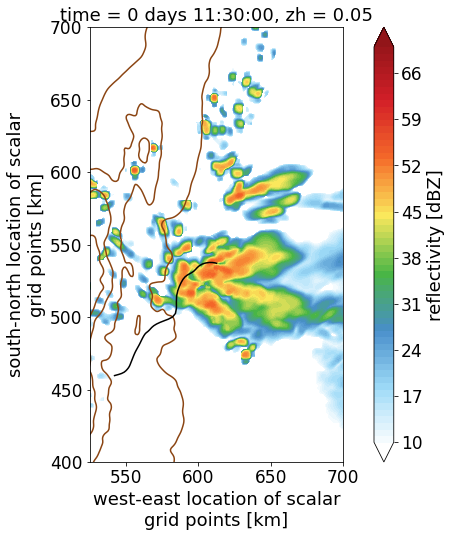

In [86]:
def plot_var(PLOTTING, VARNAME1, VARNAME2, VARNAME3, VARNAME4, SEGM, THRES, AREA, FILE, VAR1_LEVEL, VAR2_LEVEL, VAR3_LEVEL, LINE_CHARAC, IF_DENSITY_WTD, LEVEL1, LEVEL2,
             UL_XIND, UL_YIND, BR_XIND, BR_YIND, CBAR_EXP, MIN_LEV, MAX_LEV, STEP_LEV, NUM_LEVELS, VAR3_LEVELS, VAR3_COLOR, VAR4_LEVELS,
             TITLE, COLORMAP, AX, PLOT_SFC_WINDS, WIND_STYLE, PLOT_REFL, PLOT_UPDRAFT, PLOT_DOWNDRAFT, PLOT_CP, PLOT_MESOCYCLONE, PLOT_RAINRATE, PLOT_REFLECTIVITY_AREA, IS_PANEL_PLOT, XY_labels,
             TRACKING, RUN_NO, START_X, START_Y, BOX_WIDTH, INFLOW, INFLOWBOX_X, INFLOWBOX_Y):

    XR_DARRAY = xr.open_dataset(FILE)
    tiempo = extract_CM1_time(XR_DARRAY)[0]

    if PLOTTING:
        if VARNAME2:
            if VARNAME2 == "thetae":
                prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
                th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
                qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
                temp = mpcalc.temperature_from_potential_temperature(prs, th)
                shum = mpcalc.specific_humidity_from_mixing_ratio(qv)
                dewpt = mpcalc.dewpoint_from_specific_humidity(
                    pressure=prs, temperature=temp, specific_humidity=shum)
                var2 = mpcalc.equivalent_potential_temperature(
                    pressure=prs, temperature=temp, dewpoint=dewpt)
                var2 = xr.DataArray(data=np.array(var2), dims=['nj', 'ni'], attrs={'long_name': 'Equivalent potential temperature',
                                                                                   'units': 'K'})
            elif VARNAME2 == "temperature":
                prs = XR_DARRAY.variables['prs'][0, VAR2_LEVEL,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
                th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
                qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
                temp = mpcalc.temperature_from_potential_temperature(prs, th)
                var2 = xr.DataArray(data=np.array(temp), dims=['nj', 'ni'], attrs={'long_name': 'temperature',
                                                                                   'units': 'K'})
            elif VARNAME2 == "w_ud":
                var2 = XR_DARRAY.variables['winterp'][0, 20:80, BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(
                    dim='nk', keep_attrs=True)
                # var2['']
            else:
                print(VARNAME2+' variable found in the dataset')
                if VAR2_LEVEL != None:
                    if VAR2_LEVEL > 113:
                        quantity = XR_DARRAY.variables[VARNAME2][0,
                                                                 :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                        heights = XR_DARRAY.variables['zh'][0,
                                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                        var2 = interplevel(
                            quantity.values, heights.values, VAR2_LEVEL)
                        var2.attrs['long_name'] = 'w'
                        var2.attrs['units'] = 'm/s'
                        # print(var2)
                        #save_string = VARNAME+'_z_'+str(LEVEL)
                        #title_string = var3d.description + ' at '+str(LEVEL)+ ' m (' +var3d.units + ') \n'
                    else:
                        var2 = XR_DARRAY.variables[VARNAME2][0,
                                                             VAR2_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                else:
                    var2 = XR_DARRAY.variables[VARNAME2][0,
                                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                    # print(var2.max())

        ############# SEGMENTATION #######################################################################
        # Plot a feature of VAR1
        if SEGM:
            if VAR1_LEVEL:
                var1 = XR_DARRAY.variables[VARNAME1][0,
                                                     VAR1_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var1 = XR_DARRAY.variables[VARNAME1][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]

            IMAGE = var1.values
            bw = closing(IMAGE > THRES, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                max_area = max(np.array(areas))
                max_area_ind = areas.index(max(areas))
                max_area_label_coords_array = regions[max_area_ind].coords

                for region in regions:
                    # take regions with large enough areas
                    if region.area >= (max_area-1.0):
                        minr, minc, maxr, maxc = region.bbox

                rows = [uu[0] for uu in max_area_label_coords_array]
                cols = [uu[1] for uu in max_area_label_coords_array]
                neu_arr = np.zeros_like(label_image)  # *np.nan
                # neu_arr[max_area_label_coords]=1.0
                neu_arr[rows, cols] = 1.0
                C_segm = plt.contour(XH, YH, neu_arr, levels=[
                                     1.0], colors='darkblue', linewidths=1.1, linestyles='-', axis=AX)

        # Start plotting var2 here
        if MIN_LEV != None:
            levels = np.arange(MIN_LEV, MAX_LEV, STEP_LEV)
            C1 = plt.contourf(XH, YH, var2, levels=levels,
                              cmap=COLORMAP, extend='both', alpha=0.7)
        else:
            if np.amin(var2) == 0.0 and np.amax(var2) == 0.0:
                C1 = plt.contourf(XH, YH, var2, cmap=COLORMAP, extend='both')
            else:
                C1 = plt.contourf(XH, YH, var2, levels=np.linspace(np.amin(
                    var2).values, np.amax(var2).values, NUM_LEVELS), cmap=COLORMAP, extend='both')
        ##################################
        if VARNAME3:
            if VAR3_LEVEL:
                var3 = XR_DARRAY.variables[VARNAME3][0,
                                                     VAR3_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var3 = XR_DARRAY.variables[VARNAME3][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            C_var3 = plt.contour(
                XH, YH, var3, levels=VAR3_LEVELS, colors=VAR3_COLOR, linewidths=1.6, axis=AX)
            #AX.clabel(C_var3, C_var3.levels,fmt="%.0f", inline=True, fontsize=9)
        ##################################
        if VARNAME4:
            if VAR4_LEVEL:
                var4 = XR_DARRAY.variables[VARNAME4][0,
                                                     VAR4_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            else:
                var4 = XR_DARRAY.variables[VARNAME4][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            C_var4 = plt.contour(XH, YH, var4, levels=VAR4_LEVELS,
                                 colors='k', linewidths=1.3, linestyles='--', axis=AX)
            AX.clabel(C_var4, C_var4.levels, inline=True, fontsize=10)
        ##################################
        if PLOT_SFC_WINDS:
            winds_thin_x = 15
            n = 4
            u10 = XR_DARRAY.variables["u10"][0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384
            v10 = XR_DARRAY.variables["v10"][0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]*1.94384

            if (WIND_STYLE == 'barbs') or (WIND_STYLE == 'b'):
                AX.barbs(XH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x],
                         u10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], v10[n:-1*n:winds_thin_x, n:-1*n:winds_thin_x], linewidth=0.9, length=6, pivot='middle', flip_barb=True)
            else:
                AX.streamplot(XH, YH, u10, v10, density=1, linewidth=0.9, color='k', cmap=None,
                              norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,
                              zorder=None, start_points=None, integration_direction='both', data=None)
        ##################################
        if PLOT_REFL:
            C_refl = plt.contour(XH, YH, XR_DARRAY.variables['dbz'][0, 0, BR_YIND:UL_YIND, UL_XIND:BR_XIND], levels=[35.0], colors='darkblue',
                                 linewidths=2.1, linestyles='--', axis=AX)
        ##################################
        if PLOT_UPDRAFT:
            ud_threshold = 10.0
            w_updraft = XR_DARRAY.variables['winterp'][0, 20:60,
                                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            C6 = plt.contour(XH, YH, w_updraft, levels=[
                             ud_threshold], colors='red', linewidths=1.8, linestyles='-')

            # calculate A_up
            IMAGE = w_updraft
            bw = closing(IMAGE > ud_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)                  # label image regions
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                print('# # # # # # # # # # # # # # # # # # # # ')
                print('found '+str(len(areas))+' updrafts with areas ', areas)
                print('# # # # # # # # # # # # # # # # # # # # ')

                centroids = [r.centroid for r in regions]

                INITIAL_POSITION = True  # initial starting coordinates

                if INITIAL_POSITION:

                    print('starting position: ', 'X=', START_X, 'Y=', START_Y)
                    AX.text(UL_XIND*1.01, UL_YIND*0.975, 'start X = '+str(UL_XIND +
                            START_X)+'\nstart Y = '+str(BR_YIND+START_Y), fontsize=16)

                    # We are not tracking the largest updraft in the zoomed in domain
                    LARGEST_UD_TRACK = False

                    dist = []  # calculate distances of the centroids of ud from the given point
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to np array
                        dist.append(np.linalg.norm(
                            centt - np.array([START_Y, START_X])))

                    ind_closest_ud = np.argmin(np.array(dist))
                    print(
                        'distances of all the detected updrafts from the tracking coords are: ', dist)
                    A_up = areas[ind_closest_ud]
                    print('updraft area = ', A_up, '$km^{2}$')

                    cent_ud = centroids[ind_closest_ud]
                    cent_ud = list(cent_ud)       # convert to list

                    cent_ud[0] = int(cent_ud[0])   # convert to integer
                    cent_ud[1] = int(cent_ud[1])

                    # plot ud centroid
                    AX.scatter(
                        UL_XIND+cent_ud[1], BR_YIND+cent_ud[0], s=73, color='k', marker='x')
                    print('UD position: ', 'X=', UL_XIND +
                          cent_ud[1], 'Y=', BR_YIND+cent_ud[0])
                    AX.text(BR_XIND*0.95, UL_YIND*0.975, 'UD X = '+str(UL_XIND +
                            cent_ud[1])+'\nUD Y = '+str(BR_YIND+cent_ud[0]), fontsize=16)

                    max_area_label_coords_array = regions[ind_closest_ud].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_ud = np.zeros_like(label_image)
                    neu_arr_ud[rows, cols] = 1.0

                    # highlight the chosen updraft to distinguish it from others
                    C60 = plt.contour(XH, YH, neu_arr_ud, levels=[
                                      1.0], colors='lightcoral', linewidths=1.1, linestyles='--')

                    # Rectangle around the ud/storm
                    AX.add_patch(mpl.patches.Rectangle((UL_XIND+cent_ud[1]-10, BR_YIND+cent_ud[0]-10), 20, 20,
                                                       fill=None, lw=1.0, edgecolor='k', zorder=10))

                    AX.text(UL_XIND+cent_ud[1]-6, BR_YIND +
                            cent_ud[0]+10.12, 'Storm', fontsize=12)

                if LARGEST_UD_TRACK:

                    ind_maxarea = argmax(areas)
                    cent_ud = centroids[ind_maxarea]
                    cent_ud = list(cent_maxarea)
                    cent_ud[0] = int(cent_maxarea[0])
                    cent_ud[1] = int(cent_maxarea[1])

                    print('centroid of the largest updraft is located at ',
                          BR_YIND+cent_ud[0], ' ', UL_XIND+cent_ud[1])
                    max_w_area = max(np.array(areas))
                    A_up = max_w_area
                    print('updraft area = ', A_up, 'km^2')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_ud = np.zeros_like(label_image)
                    neu_arr_ud_mask = neu_arr_ud
                    neu_arr_ud[rows, cols] = 1.0
                    C60 = plt.contour(XH, YH, neu_arr_ud, levels=[
                                      1.0], colors='lightcoral', linewidths=1.1, linestyles='--')
                    AX.scatter(
                        UL_XIND+cent_ud[1], BR_YIND+cent_ud[0], s=73, color='k', marker='x')

                w_all_levs = XR_DARRAY.variables['winterp'][0,
                                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                # multiply by mask to the updraft in 3D
                temp_w = w_all_levs.values*neu_arr_ud[np.newaxis, :, :]
                wmax = np.amax(temp_w)
                print('max w = ', wmax)
                ind_wmax = np.unravel_index(np.argmax(temp_w), temp_w.shape)
                print('index of wmax is ', ind_wmax)
                AX.scatter(UL_XIND+ind_wmax[2], BR_YIND +
                           ind_wmax[1], s=73, color='k', marker='^')

                # height at which this max velocity is acheived
                z = XR_DARRAY.variables['zhval'][0, :,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                wmax_height = z[ind_wmax[0], ind_wmax[1], ind_wmax[2]].values
                print('height of max velocity: ', wmax_height)

            else:
                A_up = 0.0
                wmax = 0.0
                wmax_height = 0.0
                print('no strong updraft')

        else:
            A_up = np.nan
            wmax = np.nan
            wmax_height = np.nan
            print(' not tracking updraft ')

        print(' ')
        print(' Downdraft calculations:')
        ##################################
        ########### DOWNDRAFT  ###########
        ##################################
        if PLOT_DOWNDRAFT:
            down_threshold = -4.0
            w_downdraft = XR_DARRAY.variables['winterp'][0, 20:50,
                                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            C61 = plt.contour(XH, YH, w_downdraft, levels=[
                              down_threshold], colors='blue', linewidths=1.8, linestyles='-')
            # calculate R_dn
            IMAGE = w_downdraft
            bw = closing(IMAGE < down_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C7 = plt.contour(label_image,colors = 'deeppink',linewidths=0.7,linestyles='-', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to np array
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    ind_closest_dd = np.argmin(np.array(dist))
                    print(
                        'distances of all the detected downdrafts from the updraft centroid are ', dist)
                    A_dn = areas[ind_closest_dd]
                    print('downdraft area = ', A_dn, '$km^{2}$')

                    max_area_label_coords_array = regions[ind_closest_dd].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_dd = np.zeros_like(label_image)
                    neu_arr_dd_mask = neu_arr_dd
                    neu_arr_dd[rows, cols] = 1.0
                    C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
                                       1.0], colors='k', linewidths=1.1, linestyles='--')

                MIN_W_AREA = False  # do you wanna choose the biggest downdraft
                if MIN_W_AREA:
                    min_w_area = max(np.array(areas))
                    A_dn = min_w_area
                    print('downdraft area = ', A_dn, '$km^{2}$')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_dd = np.zeros_like(label_image)
                    neu_arr_dd_mask = neu_arr_dd
                    neu_arr_dd[rows, cols] = 1.0
                    C610 = plt.contour(XH, YH, neu_arr_dd, levels=[
                                       1.0], colors='deepskyblue', linewidths=1.1, linestyles='--')
            else:
                A_dn = 0.0
                print('no strong downdraft')

        else:
            A_dn = np.nan
            print('not tracking downdraft')
        print(' ')
        print(' Mesocyclone calculations:')
        ##################################
        ########### MESOCYCLONE  #########
        ##################################
        if PLOT_MESOCYCLONE:
            uh_threshold = 50.
            uh_zoom = XR_DARRAY.variables['uh'][0,
                                                BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            C62 = plt.contour(XH, YH, uh_zoom, levels=[
                              uh_threshold], colors='green', linewidths=1.8, linestyles='-')
            # Calculate R_meso
            IMAGE = uh_zoom
            bw = closing(IMAGE > uh_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:

                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to list
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    if (np.min(np.array(dist)) < 15.0):  # if the mesocyclone is close to the UD
                        ind_closest_uh = np.argmin(np.array(dist))
                        print(
                            'distances of all the detected mesocyclones from the updraft centroid are ', dist)
                        A_meso = areas[ind_closest_uh]
                        print('mesocyclone area = '+str(A_meso)+' km^2')

                        max_area_label_coords_array = regions[ind_closest_uh].coords
                        rows = [uu[0] for uu in max_area_label_coords_array]
                        cols = [uu[1] for uu in max_area_label_coords_array]
                        neu_arr_uh = np.zeros_like(label_image)
                        neu_arr_uh[rows, cols] = 1.0
                        C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
                                           1.0], colors='lime', linewidths=1.1, linestyles='--')

                        temp_uh = uh_zoom.values*neu_arr_uh[:, :]
                        uh_max = np.amax(temp_uh)
                        print('max uh = ', uh_max)
                        ind_uhmax = np.unravel_index(
                            np.argmax(temp_uh), temp_uh.shape)
                        print('index of uh max is ', ind_uhmax)
                        AX.scatter(
                            UL_XIND+ind_uhmax[1], BR_YIND+ind_uhmax[0], s=73, color='k', marker='+')

                    else:                            # if not, it doesn't exist for our purposes
                        A_meso = 0.0
                        uh_max = 0.0
                        print('no strong mesocyclone')

                else:
                    max_uh_area = max(np.array(areas))
                    A_meso = max_uh_area
                    print('mesocyclone area = '+str(A_meso)+' $km^{2}$')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_uh = np.zeros_like(label_image)
                    neu_arr_uh[rows, cols] = 1.0
                    C620 = plt.contour(XH, YH, neu_arr_uh, levels=[
                                       1.0], colors='lime', linewidths=1.1, linestyles='--')

                    temp_uh = uh_zoom.values*neu_arr_uh[:, :]
                    uh_max = np.amax(temp_uh)
                    print('max uh = ', uh_max)
                    ind_uhmax = np.unravel_index(
                        np.argmax(temp_uh), temp_uh.shape)
                    print('index of uh max is ', ind_uhmax)
                    AX.scatter(
                        UL_XIND+ind_uhmax[1], BR_YIND+ind_uhmax[0], s=73, color='k', marker='+')

            else:
                A_meso = 0.0
                uh_max = 0.0
                print('no strong mesocyclone')
        print(' ')
        print(' Reflectivity contour calculations:')
        ###################################
        if PLOT_REFLECTIVITY_AREA:
            dbz_threshold = 40.
            dbz_zoom = XR_DARRAY.variables['dbz'][0,
                                                  0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #C_30dbz = plt.contour(XH, YH, dbz_zoom, levels = [dbz_threshold], colors='k', linewidths=1.8, linestyles='-')

            # Calculate A_dbz
            IMAGE = dbz_zoom
            bw = closing(IMAGE > dbz_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                UD_ENCLOSED = True  # do you wanna choose the feature closest to the updraft

                print(' found ', len(areas), ' distinct 35-dbz refl contours')

                if UD_ENCLOSED:
                    rbxs_list = [(rrr['BoundingBox']) for rrr in regions]

                    bbox_ticker = 0
                    enclosed = 0
                    for bbox in rbxs_list:
                        minr, minc, maxr, maxc = bbox

                        # check if the updraft centroid is enclosed in the 35-dbz ref contour bounding box
                        if ((cent_ud[1] <= maxc) & (cent_ud[1] >= minc) & (cent_ud[0] <= maxr) & (cent_ud[0] >= minr)):
                            print(
                                'the updraft is encloded in the refl contour bounding box with the followind properties: ')
                            print('minc = ', minc)
                            print('maxc = ', maxc)
                            print('minr = ', minr)
                            print('maxr = ', maxr)

                            enclosed = 1
                            break
                        else:
                            bbox_ticker = bbox_ticker + 1

                    if (enclosed == 1):  # if an enclosing bbox is found, proceed to calculate the properties
                        print('index of enclosing rectangle is ', bbox_ticker)
                        ind_closest_dbz = bbox_ticker
                        A_dbz = areas[ind_closest_dbz]
                        print('30-dbz reflectivity contour area = ' +
                              str(A_dbz)+' km^2')

                        max_area_label_coords_array = regions[ind_closest_dbz].coords
                        rows = [uu[0] for uu in max_area_label_coords_array]
                        cols = [uu[1] for uu in max_area_label_coords_array]
                        neu_arr_dbz = np.zeros_like(label_image)
                        neu_arr_dbz[rows, cols] = 1.0
                        C620 = plt.contour(XH, YH, neu_arr_dbz, levels=[
                                           1.0], colors='k', linewidths=1.1, linestyles='--')

                        # create a  rectangle around the reflectivity contour
                        region_of_interest = regions[ind_closest_dbz]
                        minr, minc, maxr, maxc = region_of_interest['BoundingBox']
                        bx = (minc, maxc, maxc, minc, minc)
                        by = (minr, minr, maxr, maxr, minr)
                        print('reflectivity bounding box x = ', bx)
                        print('reflectivity bounding box y = ', by)
                        plt.plot(np.array(bx) + UL_XIND, np.array(by) +
                                 BR_YIND, '-b', linewidth=2.5)  # plot the rectangle

                        # get the max dimension of the rectangle
                        l_refl = max(abs(maxr-minr), abs(maxc-minc))
                        print('max dimension of the ref contour is ', l_refl, ' km')

                        temp_dbz = dbz_zoom.values*neu_arr_dbz[:, :]
                        dbz_max = np.amax(temp_dbz)
                        print('max dbz = ', dbz_max)
                        ind_dbzmax = np.unravel_index(
                            np.argmax(temp_dbz), temp_dbz.shape)
                        print('index of dbz max is ', ind_dbzmax)
                        AX.scatter(
                            UL_XIND+ind_dbzmax[1], BR_YIND+ind_dbzmax[0], s=73, color='k', marker='+')

                    else:  # if not, it doesn't exist for our purposes
                        A_dbz = 0.0
                        dbz_max = 0.0
                        l_refl = 0.0
                        print('no 30-dbz contours')

                else:     # if we're looking for the largest 35-dbz ref contour instead of the one enclosing the ud
                    max_dbz_area = max(np.array(areas))
                    A_dbz = max_dbz_area
                    print('30-dbz reflectivity area = '+str(A_dbz)+' $km^{2}$')
                    max_area_ind = areas.index(max(areas))
                    max_area_label_coords_array = regions[max_area_ind].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_dbz = np.zeros_like(label_image)
                    neu_arr_dbz[rows, cols] = 1.0
                    C62011 = plt.contour(XH, YH, neu_arr_dbz, levels=[
                        1.0], colors='lime', linewidths=1.1, linestyles='--')

                    temp_dbz = dbz_zoom.values*neu_arr_dbz[:, :]
                    dbz_max = np.amax(temp_dbz)
                    print('max dbz = ', dbz_max)
                    ind_dbzmax = np.unravel_index(
                        np.argmax(temp_dbz), temp_dbz.shape)
                    print('index of dbz max is ', ind_dbzmax)
                    AX.scatter(
                        UL_XIND+ind_dbzmax[1], BR_YIND+ind_dbzmax[0], s=73, color='k', marker='+')

            else:
                A_dbz = 0.0
                dbz_max = 0.0
                l_refl = 0.0
                print('no 30-dbz contours')
        print(' ')
        print(' Cold pool calculations:')
        ##################################
        ########### COLD POOL  ###########
        ##################################
        if PLOT_CP:
            Rv = 461.5
            Rd = 287.04
            theta_anomaly_threshold = -5.
            th = XR_DARRAY.variables['th'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('Pa')
            qv = XR_DARRAY.variables['qv'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('K')
            # *munits('kg/kg')
            qc = XR_DARRAY.variables['qc'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
            # *munits('kg/kg')
            qr = XR_DARRAY.variables['qr'][0, VAR2_LEVEL,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
            ql = qc + qr
            theta_rho = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
            theta_rho = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                         'units': 'K'})
            theta_rho_domain = xr.DataArray(data=np.array(theta_rho), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                                                'units': 'K'}).mean()
            theta_anomaly = theta_rho - theta_rho_domain
            # print(theta_anomaly)
            C7 = plt.contour(XH, YH, theta_anomaly, levels=[
                             theta_anomaly_threshold], colors='aqua', linewidths=1.8, linestyles='-')
            ##### calculate area of the cold pool ######
            IMAGE = theta_anomaly.values
            bw = closing(IMAGE < theta_anomaly_threshold,
                         square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                max_area_cp = max(np.array(areas))
                print(' area of the largest cold pool is ', max_area_cp, ' km^2')

                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to list
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    ind_closest_cp = np.argmin(np.array(dist))
                    print(
                        'distances of all the detected cold pools from the updraft centroid are ', dist)
                    A_cp = areas[ind_closest_cp]
                    print('cold pool area = '+str(A_cp)+' km^2')
                    print()

                    max_area_label_coords_array = regions[ind_closest_cp].coords
                    rows = [uu[0] for uu in max_area_label_coords_array]
                    cols = [uu[1] for uu in max_area_label_coords_array]
                    neu_arr_cp = np.zeros_like(label_image)
                    neu_arr_cp[rows, cols] = 1.0
                    C6201 = plt.contour(XH, YH, neu_arr_cp, levels=[
                                        1.0], colors='k', linewidths=1.1, linestyles='--')

                    # get the min density theta and plot it
                    temp_cp = theta_anomaly.values*neu_arr_cp[:, :]
                    cp_min = np.amin(temp_cp)
                    print('min theta anomaly = ', cp_min)
                    ind_cpmin = np.unravel_index(
                        np.argmin(temp_cp), temp_cp.shape)
                    print('index of cp min is ', ind_cpmin)
                    AX.scatter(
                        UL_XIND+ind_cpmin[1], BR_YIND+ind_cpmin[0], s=73, color='k', marker='$c$')

                    # get the centroid of the cold pool and plot it
                    cent_cp = centroids[ind_closest_cp]
                    cent_cp = list(cent_ud)

                    cent_cp[0] = int(cent_cp[0])  # convert to integer
                    cent_cp[1] = int(cent_cp[1])
                    AX.scatter(
                        UL_XIND+cent_cp[1], BR_YIND+cent_cp[0], s=73, color='k', marker='x')

                    ##############################
                    # buoyancy-based calculations #

                    # get the buoyancy: calculate the area (again) and height of the cold pool
                    buo_all_levs = XR_DARRAY.variables['buoyancy'][0,
                                                                   0:60, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
                    #C_bouy           = plt.contour(XH,YH,buo_all_levs[0,:,:],levels=[-0.1],colors='aquamarine',linewidths=1.1,linestyles='--')
                    temp_buoy = buo_all_levs.values * \
                        neu_arr_cp[np.newaxis, :, :]
                    buoy_min = np.amin(temp_buoy)
                    print('min buoyancy = ', buoy_min)

                    ind_buoy_min = np.unravel_index(
                        np.argmin(temp_buoy), temp_buoy.shape)
                    print('index of min  is buoyancy ', ind_buoy_min)
                    # AX.scatter(UL_XIND+ind_buoy_min[2],BR_YIND+ind_buoy_min[1],s=73,color='k',marker='$b$')

                    z_11 = XR_DARRAY.variables['zhval'][0, 0:60,
                                                        BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
                    buoy_min_height = z_11[ind_buoy_min[0],
                                           ind_buoy_min[1], ind_buoy_min[2]]
                    print('height of min buoyancy is ', buoy_min_height)

            else:
                max_area_cp = 0.0
                A_cp = 0.0
                buoy_min_height = 0.0
                buoy_min = 0.0
                cp_min = 0.0
                print('no cold pool detected for the tracked updraft')

        else:
            A_cp = np.nan
            buoy_min_height = 0.0
            buoy_min = 0.0
            cp_min = 0.0
            print('cold pool not tracked')
        print(' ')
        print(' Rain rate calculations:')
        ##################################
        ########### RAIN RATE  ###########
        ##################################
        if PLOT_RAINRATE:

            current_file_basename = os.path.basename(FILE)
            print('using current file ', current_file_basename)
            prev_fil_no = str(int(current_file_basename.split(
                '_')[1].split('.')[0].lstrip('0'))-1).zfill(6)
            prev_fil_search_string = 'cm1out_'+prev_fil_no+'.nc'
            prev_fil = sorted(glob.glob(direc_list[0]+prev_fil_search_string))
            print('using previous file ', prev_fil)
            XR_DARRAY2 = xr.open_dataset(prev_fil[0])

            rr_threshold = 40.0
            rain_temp1 = XR_DARRAY.variables['rain'][0,
                                                     BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            #print('rain : ',rain_temp1)
            rain_temp2 = XR_DARRAY2.variables['rain'][0,
                                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            rr = (rain_temp1 - rain_temp2)*10.*60./5.
            rr.attrs['long_name'] = 'rain rate'
            rr.attrs['units'] = 'mm/hr'
            C_rr = plt.contour(XH, YH, rr, levels=[
                               rr_threshold], colors='dodgerblue', linewidths=1.8, linestyles='-')

            IMAGE = rr.values
            bw = closing(IMAGE > rr_threshold, square(3))  # apply threshold
            # remove artifacts connected to image border
            cleared = clear_border(bw)
            label_image = label(cleared)           # label image regions
            #C7 = plt.contour(label_image,colors = 'deeppink',linewidths=0.7,linestyles='-', axis=AX)
            regions = [rr for rr in regionprops(label_image)]
            areas = [r.area for r in regions]

            if areas:
                CLOSEST_TO_UD = True  # do you wanna choose the downdraft closest to the updraft
                if CLOSEST_TO_UD:
                    centroids = [r.centroid for r in regions]
                    dist = []
                    for centt in centroids:
                        centt = np.array((centt))  # convert tuple to np array
                        dist.append(np.linalg.norm(centt - np.array(cent_ud)))

                    # if the mesocyclone is close enough (dist b/w UH centroid and UD centroid < 15 kms)
                    if (np.min(np.array(dist)) < 15.0):
                        ind_closest_rr = np.argmin(np.array(dist))
                        print(
                            'distances of all the detected rainrate contours from the updraft centroid are ', dist)
                        A_rr = areas[ind_closest_rr]
                        print('rainrate contour area = ', A_rr, '$km^{2}$')

                        max_area_label_coords_array = regions[ind_closest_rr].coords
                        rows = [uu[0] for uu in max_area_label_coords_array]
                        cols = [uu[1] for uu in max_area_label_coords_array]
                        neu_arr_rr = np.zeros_like(label_image)
                        neu_arr_rr[rows, cols] = 1.0
                        plt.contour(XH, YH, neu_arr_rr, levels=[
                                    1.0], colors='k', linewidths=1.1, linestyles='--')

                        # calculate max instantaneous rain rate for storing
                        temp_rr = rr.values*neu_arr_rr[:, :]
                        rr_max = np.amax(temp_rr)
                        print('max rr = ', rr_max)
                        ind_rrmax = np.unravel_index(
                            np.argmax(temp_rr), temp_rr.shape)
                        print('index of rr max is ', ind_rrmax)
                        AX.scatter(
                            UL_XIND+ind_rrmax[1], BR_YIND+ind_rrmax[0], s=33, color='k', marker='$rr$')

                    else:
                        A_rr = 0.0
                        rr_max = 0.0
                        print('no large rainrate contours')

            else:
                A_rr = 0.0
                rr_max = 0.0
                print('no large rainrate contours')

        else:
            A_rr = np.nan
            rr_max = 0.0
            print('not tracking rainrate')
        print(' ')
        #############################
        # Plot terrain
        #############################
        levels_zs = np.arange(500, 2700, 400)
        C_terr = plt.contour(XH, YH, zs[0, BR_YIND:UL_YIND, UL_XIND:BR_XIND],
                             levels=levels_zs, colors="saddlebrown", linewidths=1.75, linestyles='-')
        AX.clabel(C_terr, C_terr.levels, inline=True, fmt="%.0f", fontsize=10)
        ##################################

        if TITLE:
            title = TITLE
        elif (IF_DENSITY_WTD == 'vint') or (IF_DENSITY_WTD == 'rhowtd'):
            title = var2.attrs['long_name']
        else:
            if VAR2_LEVEL:
                if VAR2_LEVEL > 110:
                    title = var2.attrs['long_name'] + \
                        " at height "+str(VAR2_LEVEL)+' m'
                else:
                    title = var2.attrs['long_name'] + \
                        " at model level "+str(VAR2_LEVEL)
            else:
                title = var2.attrs['long_name']
        prodid = VARNAME2+'_zoom'  # var1.long_name
        units = var2.attrs['units']  # var1.units'

    # AX.hlines(500,xmin=UL_XIND+5,xmax=BR_XIND-5)
    # AX.vlines(505,ymin=BR_YIND+5,ymax=UL_YIND-5)
    #fig_process_horiz(C1, C4,CBAR_EXP,False,title,extract_CM1_time(XR_DARRAY)[0],extract_CM1_time(XR_DARRAY)[1],prodid, units, IS_PANEL_PLOT, XY_labels)
    # plt.close()
    if TRACKING:
        if TRACKING == 'W':
            print('  ')
            print('tracking the wmax point...')
            print('  ')
            ##################################################################################################
            print('RUN_NO', RUN_NO)

            # First guess location of the updraft
            AX.add_patch(mpl.patches.Rectangle((UL_XIND+START_X, BR_YIND+START_Y), BOX_WIDTH, BOX_WIDTH,
                                               fill=None, lw=1.8, edgecolor='k', ls='--', zorder=10))
            wa = XR_DARRAY.variables['winterp'][0, 20:60,
                                                BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            wa1 = XR_DARRAY.variables['winterp'][0, 20:50,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND].mean(axis=0)
            uh = XR_DARRAY.variables['uh'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            terr_hgt = XR_DARRAY.variables['zs'][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            p = XR_DARRAY.variables['prs'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            th = XR_DARRAY.variables['th'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            qv = XR_DARRAY.variables['qv'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            z = XR_DARRAY.variables['zhval'][0, :,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ua = XR_DARRAY.variables['uinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            va = XR_DARRAY.variables['vinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            temp = mpcalc.temperature_from_potential_temperature(
                p.values*munits('Pa'), th.values*munits('K'))
            temp = temp.to('degC')
            # print(temp)
            tc = xr.DataArray(data=np.array(temp), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'temperature', 'units': 'deg C'})
            # print(tc)
            #tc = XR_DARRAY.variables['uh'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            tem = mpcalc.dewpoint_from_specific_humidity(pressure=p.values*munits('Pa'), temperature=temp,
                                                         specific_humidity=qv.values*munits('kg/kg'))
            # print(tem)
            td = xr.DataArray(data=np.array(tem), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'dewpoint temperature', 'units': 'deg C'})
            # print(td)
            #qc = XR_DARRAY.variables['qc'][0,20:80,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            #qi = XR_DARRAY.variables['qi'][0,20:80,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            #z = XR_DARRAY.variables['z'][0,20:80,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            # print(wa)
            w_temp = wa[START_Y:(START_Y+BOX_WIDTH),
                        START_X:(START_X+BOX_WIDTH)].values
            w_down_temp = wa1[START_Y:(
                START_Y+BOX_WIDTH), START_X:(START_X+BOX_WIDTH)].values
            uh_temp = uh[START_Y:(START_Y+BOX_WIDTH),
                         START_X:(START_X+BOX_WIDTH)].values
            #qc_temp    =  qc [:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            #qi_temp    =  qi [:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            #te_temp    =  the[:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            #z_temp     =  z  [:,START_Y:START_Y+BOX_WIDTH,START_X:START_X+BOX_WIDTH].values
            print('shape of wa (zoomed in map) = ', np.shape(wa))
            print('shape of w_temp (tracking box) = ', np.shape(w_temp))
            # Get their max values
            wmax = w_temp.max()
            print('wmax = ', wmax)
            uh_max = uh_temp.max()  # negative UH in SH
            print('uhmax = ', uh_max)
            #qc_max  = qc_temp.max()
            #print('qcmax = ',qc_max)
            #qi_max  = qi_temp.max()
            #print('qimax = ',qi_max)
            #te_max  = te_temp.max()
            #print('temax = ',te_max)

            # get the indices of the max values
            ind_wmax = np.unravel_index(w_temp.argmax(),   w_temp.shape)
            print('indices of max w : ', ind_wmax)
            ind_uhmax = np.unravel_index(
                uh_temp.argmin(), uh_temp.shape)  # negative values in SH
            #print('indices of max uh : ',ind_uhmax)
            #ind_qcmax=np.unravel_index(qc_temp.argmax(), qc_temp.shape)
            ##print('indices of max qc : ',ind_qcmax)
            #ind_qimax=np.unravel_index(qi_temp.argmax(), qi_temp.shape)
            #print('indices of max qi : ',ind_qimax)
            #ind_temax=np.unravel_index(te_temp.argmax(), te_temp.shape)
            #print('indices of max qi : ',ind_qimax)

            # find the heights where those max values are obtained
            #wmax_height = z_temp [ind_wmax[0],ind_wmax[1],ind_wmax[2]]
            #qcmax_height= z_temp[ind_qcmax[0],ind_qcmax[1],ind_qcmax[2]]
            #qimax_height= z_temp[ind_qimax[0],ind_qimax[1],ind_qimax[2]]
            #temax_height= z_temp[ind_temax[0],ind_temax[1],ind_temax[2]]
            ##################################################################################################
            AX.scatter(
                UL_XIND+START_X+ind_wmax[1], BR_YIND+START_Y+ind_wmax[0], s=73, color='k', marker='^')
            AX.scatter(UL_XIND+START_X+ind_uhmax[1], BR_YIND+START_Y +
                       ind_uhmax[0], s=37, color='k', marker='X', facecolor='none')
            ##################################################################################################

        elif TRACKING == 'C':
            print('  ')
            if INITIAL_POSITION:
                str_temp = 'a certain chosen'
            else:
                str_temp = 'the largest'
            print('tracking the centroid of '+str_temp+' updraft...')
            print('  ')

            t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            terr_hgt = XR_DARRAY.variables['zs'][0,
                                                 BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            p = XR_DARRAY.variables['prs'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            th = XR_DARRAY.variables['th'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            qv = XR_DARRAY.variables['qv'][0, :,
                                           BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            ua = XR_DARRAY.variables['uinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            va = XR_DARRAY.variables['vinterp'][0,
                                                :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            temp = mpcalc.temperature_from_potential_temperature(
                p.values*munits('Pa'), th.values*munits('K'))
            temp = temp.to('degC')
            tc = xr.DataArray(data=np.array(temp), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'temperature', 'units': 'deg C'})
            tem = mpcalc.dewpoint_from_specific_humidity(pressure=p.values*munits('Pa'), temperature=temp,
                                                         specific_humidity=qv.values*munits('kg/kg'))
            td = xr.DataArray(data=np.array(tem), dims=['nk', 'nj', 'ni'], attrs={
                              'long_name': 'dewpoint temperature', 'units': 'deg C'})

        if INFLOW:
            INFLOW_DIST_X = 15
            INFLOW_DIST_Y = 25
            print('calculating inflow properties')

            if INFLOW == 'W':
                print('... with wmax')
                track_pt_x = ind_wmax[1]
                track_pt_y = ind_wmax[0]

                AX.add_patch(mpl.patches.Rectangle((UL_XIND+track_pt_x+INFLOW_DIST_X, BR_YIND+track_pt_y+INFLOW_DIST_Y), INFLOWBOX_X, INFLOWBOX_Y,
                                                   fill=None, lw=1.8, edgecolor='k', zorder=10))

                t2_inflow = t2[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(0, 1)).values

                p_inflow = p[:,  (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                             (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                z_inflow = z[:,  (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                             (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                ua_inflow = ua[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                va_inflow = va[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                tc_inflow = tc[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                td_inflow = td[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                               (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(1, 2)).values

                terr_inflow = terr_hgt[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                       (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(0, 1)).values

                snd_array = np.column_stack(
                    (p_inflow/100., z_inflow, tc_inflow, td_inflow, ua_inflow, va_inflow))

            elif INFLOW == 'C':
                print('... with the centroid of the updraft')
                track_pt_x = cent_ud[1]
                track_pt_y = cent_ud[0]

                AX.add_patch(mpl.patches.Rectangle((UL_XIND+track_pt_x+INFLOW_DIST_X, BR_YIND+track_pt_y+INFLOW_DIST_Y), INFLOWBOX_X, INFLOWBOX_Y,
                                                   fill=None, lw=1.8, edgecolor='k', zorder=10))

                ##############################################################################################
                # create a reflectivity mask for the inflow region to exclude convectively contaminated points
                # remove all points with reflectivity values (at the lowest model level) > 10 dBZ  from the inflow box
                refl_inflow_box = dbz_zoom[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                      (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)]
                refl_threshold = 10.0
                refl_mask_2D = np.where(refl_inflow_box > refl_threshold, np.nan, 1.0)
                refl_mask_3D = refl_mask_2D[np.newaxis, :, :]
                ##############################################################################################
                AX.text((UL_XIND+track_pt_x+INFLOW_DIST_X), (BR_YIND+track_pt_y +
                                                             INFLOW_DIST_Y+INFLOWBOX_Y)*1.002, 'Inflow box', fontsize=12)
                
                # get different varables over the inflow box and compute average
                t2_inflow = np.nanmean(t2[  (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                  (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].values*refl_mask_2D,axis=(0, 1))

                p_inflow =  np.nanmean(p[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                  (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].values*refl_mask_3D,axis=(1, 2))

                z_inflow =  np.nanmean(z[:, (track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                  (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].values*refl_mask_3D,axis=(1, 2))

                ua_inflow = np.nanmean(ua[:,(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                  (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].values*refl_mask_3D,axis=(1, 2))

                va_inflow = np.nanmean(va[:,(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                  (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].values*refl_mask_3D,axis=(1, 2))

                tc_inflow = np.nanmean(tc[:,(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                  (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].values*refl_mask_3D,axis=(1, 2))

                td_inflow = np.nanmean(td[:,(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                  (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].values*refl_mask_3D,axis=(1, 2))

                terr_inflow = terr_hgt[(track_pt_y+INFLOW_DIST_Y):(track_pt_y+INFLOW_DIST_Y+INFLOWBOX_Y),
                                       (track_pt_x+INFLOW_DIST_X):(track_pt_x+INFLOW_DIST_X+INFLOWBOX_X)].mean(axis=(0, 1)).values

                snd_array = np.column_stack(
                    (p_inflow/100., z_inflow, tc_inflow, td_inflow, ua_inflow, va_inflow))
                ###########################################################################################

            else:
                print('Please choose UH or W for the inflow box')
                p_inflow = np.nan
                z_inflow = np.nan
                ua_inflow = np.nan
                va_inflow = np.nan
                tc_inflow = np.nan
                td_inflow = np.nan
                terr_inflow = np.nan

        if TRACKING == 'W':
            upd_xpos = ind_wmax[1]
            upd_ypos = ind_wmax[0]
            abs_upd_xpos = UL_XIND + START_X + upd_xpos
            abs_upd_ypos = BR_YIND + START_Y + upd_ypos
            start_x_out = START_X + upd_xpos - int(BOX_WIDTH/2)
            start_y_out = START_Y + upd_ypos - int(BOX_WIDTH/2)

        elif TRACKING == 'C':
            upd_xpos = cent_ud[1]
            upd_ypos = cent_ud[0]
            abs_upd_xpos = UL_XIND + cent_ud[1]
            abs_upd_ypos = BR_YIND + cent_ud[0]
            start_x_out = cent_ud[1]
            start_y_out = cent_ud[0]
        #print('Lower left corner of the next box (x,y): ',start_x_out,start_y_out)
        inflow_array = np.array([tiempo, wmax, wmax_height, A_up, A_dn, uh_max, A_meso, A_cp, cp_min,
                                A_rr, rr_max, buoy_min, buoy_min_height, A_dbz, dbz_max, l_refl, abs_upd_xpos, abs_upd_ypos, terr_inflow])
        ##################################################################################################
    fig_process_horiz(C1, C_terr, CBAR_EXP, False, title, extract_CM1_time(XR_DARRAY)[
                      0], extract_CM1_time(XR_DARRAY)[1], prodid, units, IS_PANEL_PLOT, XY_labels)
    print('time is :', tiempo)
    return start_x_out, start_y_out, inflow_array, snd_array, terr_inflow, tiempo
    #####################################################################################################


SDC_terrain = True
if SDC_terrain:
    ul_xind1 = 500  # upper left corner x#520
    ul_yind1 = 600  # upper left corner y720
    br_xind1 = 680  # 650  # bottom right corner x700
    br_yind1 = 400  # bottom right corner y#450
else:
    ul_xind1 = 0  # upper left corner x#520
    ul_yind1 = nj-1  # upper left corner y720
    br_xind1 = ni-1  # bottom right corner x700
    br_yind1 = 0  # bottom right corner y#450

XH, YH = np.meshgrid(xh[ul_xind1:br_xind1], yh[br_yind1:ul_yind1])

run_this_func = True


cma1 = plt.get_cmap('bwr')
cma2 = coltbls.reflect()
cma3 = plt.get_cmap('tab20c')
cma4 = ncm.cmap("WhiteBlueGreenYellowRed")
cma5 = plt.get_cmap('gray_r')

if run_this_func:
    run_no = 1
    # start_x= 50#50#40  75_LLJ: start_x=50
    # start_y= 50#60#30  75_LLJ: start_x=15
    terr_list = []
    track_list = []
    snd_list = []
    times = []

    experiments = ['stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km']  

    for exp in experiments:
        direc_list = []
        # direc_list.append("/home1/04167/tg834661/scratch/"+exp+"/") #stampede2
        direc_list.append("/home/isingh9/scratch/temp_project/"+exp+"/")  # expanse
        fi_list = []
        # fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_000109.nc")) +\
        #               sorted(glob.glob(direc_list[0]+"cm1out_00011?.nc")))# +\
        # sorted(glob.glob(direc_list[0]+"cm1out_00012[0-6].nc")))

        if exp == 'stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km':
            # supercell # 2
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00013?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0001[4-6]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_00017[0-1].nc")))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 70

        if exp == 'stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km':
            fi_list.append(
                sorted(glob.glob(direc_list[0]+"cm1out_00007[5-7].nc")) +\
                sorted(glob.glob(direc_list[0]+"cm1out_00008[0-9].nc")) +\
                sorted(glob.glob(direc_list[0]+"cm1out_00009[0-9].nc")) +\
                sorted(glob.glob(direc_list[0]+"cm1out_0001[0-3]?.nc")))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 50

        if exp == 'stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km':
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00007[5-9].nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0008[0-9]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0009[0-9]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_001[0-3]?.nc")))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 50

            
    if exp == 'stampede_cm1_20.3_RW_LLJ_87_percent_reduced_1km':
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00007[5-9].nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0008[0-9]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0009[0-9]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_001[0-3]?.nc")))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 50
            
    if exp == 'stampede_cm1_20.3_RW_LLJ_55_percent_reduced_1km':
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00007[5-9].nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0008[0-9]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_0009[0-9]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_001[0-3]?.nc")))

            start_x = 50  # 50#40  75_LLJ: start_x=50
            start_y = 50
            
        if exp == 'stampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km':
            fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_0001[2-3]?.nc")) +
                           sorted(glob.glob(direc_list[0]+"cm1out_00014[0-5].nc")))  # +\
            # sorted(glob.glob(direc+"cm1out_0009[0-9]?.nc")) +\
            # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

            start_x = 75  # 50#40  75_LLJ: start_x=50
            start_y = 120

        print(fi_list)

        print('')
        print('time range : ', extract_CM1_time(xr.open_dataset(fi_list[0][0]))[
              0], ' to ', extract_CM1_time(xr.open_dataset(fi_list[0][-1]))[0])
        print(' ')
        ###################### START OF FILE LOOP #########################
        for some in range(min([len(x) for x in fi_list])):
            print(' ')

            fig = plt.figure(figsize=(11, 10), frameon=False)  # (16,11)
            plt.xlim([ul_xind1, br_xind1])
            plt.ylim([br_yind1, ul_yind1])

            ax_1 = subplot(1, len(fi_list), 1)

            # PLOTTING,VARNAME1,VARNAME2,VARNAME3,VARNAME4,
            # SEGM,THRES,AREA,
            # FILE,VAR1_LEVEL,VAR2_LEVEL,VAR3_LEVEL,
            # LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,\
            # UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,VAR3_LEVELS,VAR3_COLOR,VAR4_LEVELS,\
            # TITLE,COLORMAP,AX,
            # PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,PLOT_UPDRAFT,PLOT_DOWNDRAFT,PLOT_CP,PLOT_MESOCYCLONE,PLOT_RAINRATE,IS_PANEL_PLOT,XY_labels,\
            # TRACKING,RUN_NO,START_X,START_Y,BOX_WIDTH,
            # INFLOW,INFLOWBOX_X,INFLOWBOX_Y)

            element = 'dbz'
            # element='buoyancy'
            start_x1, start_y1, tracki, sndi, terri, out_time = plot_var(True, "winterp", element, None, None,
                                                                         False, 0.7, 100,
                                                                         fi_list[0][some], None, 0, None,
                                                                         'max', "NO", 0, 15,
                                                                         ul_xind1, ul_yind1, br_xind1, br_yind1,
                                                                         0, 10, 71, 1, 20, [
                                                                             3], 'green', np.arange(0, .024, .002),
                                                                         None, cma4, ax_1,
                                                                         True, 'barbs', False, True, True, True, True, True, True, True, True,
                                                                         'C', run_no, start_x, start_y, 16,
                                                                         'C', 20, 20)

            start_x = start_x1
            start_y = start_y1
            filename = exp+'_CENTROID_TRACKING_eil_' + \
                element+'_'+out_time.replace(" ", "_")+'.png'
            print(filename)
            plt.savefig(filename, dpi=250)
            plt.close()

            run_no = run_no+1
            terr_list.append(terri)
            track_list.append(tracki)
            snd_list.append(sndi)
            times.append(out_time)
            print(
                '------------------------------------------------------------------------------------')
        ###################### END OF FILE LOOP ##########################

# if post_processing = True, all the tracking data is stores in npy and csv files along with .png
# files of tracking. If False, only png files are produced.

post_processing = True

if post_processing:

    # string identifier used in the filenames for csv files
    post_data_string = 'CM1_CENTROID_eil_'

    track_data = np.array(track_list)
    snd_data = np.array(snd_list)

    times_neu = pd.to_datetime(times)
    save_timestring = times_neu[0].strftime(
        format="%Y-%m-%d_%H%M")+'-'+times_neu[-1].strftime(format="%Y-%m-%d_%H%M")
    tracking_npy_name = post_data_string + exp + '_ud_tracking_' + save_timestring
    sounding_npy_name = post_data_string + exp + '_ud_sounding_' + save_timestring
    np.save(tracking_npy_name, track_data)
    np.save(sounding_npy_name, snd_data)

    track_data_stored = np.load(tracking_npy_name+'.npy')
    snd_data_stored = np.load(sounding_npy_name+'.npy')

    # Read the tracing data
    # inflow_array=np.array([tiempo,wmax,R_up,R_dn,uh_max,R_meso,R_cp,R_rr,abs_upd_xpos,abs_upd_ypos,terr_inflow])
    df1 = pd.DataFrame(track_data_stored[:, 1:], index=track_data_stored[:, 0], columns=['wmax', 'wmax_height', 'A_updraft', 'A_downdraft',
                                                                                         'uh_max', 'A_meso', 'A_cp', 'cp_theta_rho_min', 'A_rr', 'rr_max', 'buoy_min', 'buoy_min_height',
                                                                                         'A_dbz', 'dbz_max', 'l_refl',
                                                                                         'abs_upd_xpos', 'abs_upd_ypos',
                                                                                         'terr_inflow'])
    df1 = df1.astype('float')
    #df1.index = pd.to_datetime(df1.index)
    times_test = pd.DatetimeIndex(df1.index)
    df1.index = times_test
    # and add u- and v- speeds to it
    smoothed_path_x = mpcalc.smooth_gaussian(df1['abs_upd_xpos'].to_numpy(), 10)
    smoothed_path_y = mpcalc.smooth_gaussian(df1['abs_upd_ypos'].to_numpy(), 10)
    # 300 seconds/5 minutes (outout time)
    u_storm = np.gradient(np.array(smoothed_path_x)*1000., 300.) # m/s
    v_storm = np.gradient(np.array(smoothed_path_y)*1000., 300.) # m/s
    df1.insert(loc=len(df1.columns), column='u_storm', value=u_storm)
    df1.insert(loc=len(df1.columns), column='v_storm', value=v_storm)
    print('#####################################')
    print('dataframe for tracking data: ', df1)
    print('#####################################')
    print('   ')

    # Prepare dataframe for the sounding data 
    # Add sounding indices
    ii = 0
    dfs_list = []
    print('processing df_all...')
    for tim in pd.to_datetime(df1.index):
        print(tim)
        df_inflow = pd.DataFrame(snd_data_stored[ii, :, :],
                                 columns=['pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])
        print(df_inflow)
        print('##########')
        # Drop any rows with all NaN values for T, Td, winds
        df_inflow = df_inflow.dropna(subset=('pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'),
                                     how='all').reset_index(drop=True)
        # print(df_inflow)
        p_inflow = df_inflow['pressure'].values * units.hPa
        h_inflow = df_inflow['height'].values * units.m
        tc_inflow = df_inflow['temperature'].values * units.degC
        td_inflow = df_inflow['dewpoint'].values * units.degC
        u_inflow = df_inflow['u_wnd'].values * units('m/s')
        u_inflow = u_inflow.to('knots')
        v_inflow = df_inflow['v_wnd'].values * units('m/s')
        v_inflow = v_inflow.to('knots')
        wspeed_inflow = mpcalc.wind_speed(u_inflow, v_inflow)
        wspeed_inflow = wspeed_inflow.to('knots')
        wind_dir_inflow = mpcalc.wind_direction(u_inflow, v_inflow)
        # print('u_inflow',u_inflow)
        # print(df1.loc[tim])
        inflow_params = create_indices(p_inflow, h_inflow, tc_inflow, td_inflow, wspeed_inflow, wind_dir_inflow, u_inflow, v_inflow,
                                       True, 'L', df1.loc[tim]['u_storm']*units('m/s'), df1.loc[tim]['v_storm']*units('m/s'))

        inflow_params_df_temp = pd.DataFrame.from_dict(inflow_params)
        units_indices         = inflow_params_df_temp.iloc[1].values
        inflow_params_df_temp = inflow_params_df_temp.drop(labels=1)
        inflow_params_df_temp['u_storm'] = df1.loc[tim]['u_storm']
        inflow_params_df_temp['v_storm'] = df1.loc[tim]['v_storm']
        dfs_list.append(inflow_params_df_temp)

        ii = ii + 1

    units_indices = np.append(units_indices, 'm/s')
    units_indices = np.append(units_indices, 'm/s')
    df_all = pd.concat(dfs_list, ignore_index=True)
    df_all.index = df1.index

    print('#####################################')
    print('dataframe for sounding data: ', df_all)
    print('#####################################')
    print('   ')

    # Save the two dataframes
    tracking_data_csv_file = './tracking_' + post_data_string + exp + save_timestring+'.csv'
    df1.to_csv   (tracking_data_csv_file)  # tracking data
    
    sounding_data_csv_file = './sounding_' + post_data_string + exp + save_timestring+'.csv'
    df_all.to_csv(sounding_data_csv_file)  # sounding data

    # Plot path of the storm using the tracking data
    filename1 = fi_list[0][-1]  # Radiation and winds and cold bubble
    dd = xr.open_dataset(filename1)
    temp1 = dd['dbz'][0, 0, :, :]
    terr = dd['zs'][0, :, :]
    temp1 = temp1.where(temp1 > 10, np.nan)
    fig1 = plt.figure(figsize=(11, 8))
    axx = plt.gca()
    terr.plot.contour(levels=np.arange(0, 2600, 500), colors='saddlebrown')
    temp1.plot.contourf(cmap=cma4, levels=np.arange(10, 71, 1), extend='both')
    plt.plot(smoothed_path_x, smoothed_path_y, color='k')
    plt.xlim([525, 700])
    plt.ylim([400, 700])
    axx.set_aspect('equal')
    storm_track_png = 'storm_track_'+post_data_string + \
        exp+'_'+save_timestring+'.png'
    plt.savefig(storm_track_png, dpi=300)

    print('Filenames: ')
    print('tracking data csv: ', tracking_data_csv_file)
    print('sounding data csv: ', sounding_data_csv_file)
    print('storm track png: '  , storm_track_png)

In [90]:
dddd = pd.read_csv('./sounding_CM1_CENTROID_eil_stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)
dd50_thermo = pd.read_csv('CM1_CENTROID_INITIAL_rainrate_refl_contours_stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)

<AxesSubplot:>

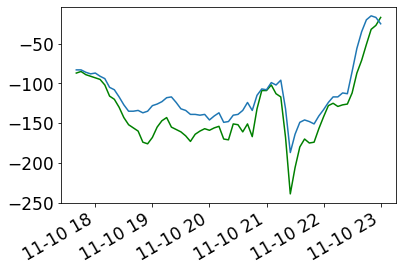

In [95]:
dddd['0-3 km SRH (Model-Obs LM)'].plot(color='g')
dd50_thermo['0-3 km SRH (Model-Obs LM)'].plot()

# Load all the tracking data (.npy and .csv files)

In [40]:
# Load all the npy data (this includes inflow soundings)
inflow_snd_data_100 = np.load(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_ud_sounding_2018-11-10_2035-2018-11-10_2155.npy')
inflow_snd_data_75  = np.load(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km_ud_sounding_2018-11-10_2215-2018-11-11_0140.npy')
inflow_snd_data_66  = np.load(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km_ud_sounding_2018-11-10_2125-2018-11-10_2330.npy')
inflow_snd_data_50  = np.load(
    'CM1_CENTROID_INITIAL_rainrate_refl_contours_stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_ud_sounding_2018-11-10_1740-2018-11-10_2300.npy')


# Load all the csv files (this includes tracking data and the indices calculated from the inflow soundings)
dd50_thermo = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_refl_contours_stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)
dd50_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_refl_contours_stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)

dd66_thermo = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_2125-2018-11-10_2330.csv', index_col=0, parse_dates=True)
dd66_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2125-2018-11-10_2330.csv', index_col=0, parse_dates=True)

dd75_thermo = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)
dd75_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)

dd100_thermo = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_2035-2018-11-10_2155.csv', index_col=0, parse_dates=True)
dd100_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_rainrate_ref_contours_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2035-2018-11-10_2155.csv', index_col=0, parse_dates=True)

# Storm track overlaid on different quantities

Read the storm track data from the csv files and plot the path over various variables averaged over the storm duration

In [ ]:
FAC = '50'
#exp = 'cm1_20.3_stampede_RW_LLJ_reduced_'+FAC+'_percent_1km'
exp = 'stampede_cm1_20.3_RW_LLJ_'+FAC+'_percent_reduced_1km'  # stampede2
direc = '/home1/04167/tg834661/scratch/'+exp+'/'

fi_list = []
if exp == 'stampede_cm1_20.3_RW_LLJ_75_percent_reduced_1km':
    # supercell # 2
    fi_list.append(sorted(glob.glob(direc+"cm1out_00013?.nc")) +
                   sorted(glob.glob(direc+"cm1out_0001[4-6]?.nc")) +
                   sorted(glob.glob(direc+"cm1out_00017[0-1].nc")))

if exp == 'stampede_cm1_20.3_RW_LLJ_50_percent_reduced_1km':
    fi_list.append(sorted(glob.glob(direc+"cm1out_00007[5-9].nc")) +
                   sorted(glob.glob(direc+"cm1out_00008[0-9].nc")) +
                   sorted(glob.glob(direc+"cm1out_00009[0-8].nc")))  # +\
    # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

if exp == 'stampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km':
    fi_list.append(sorted(glob.glob(direc+"cm1out_0001[2-3]?.nc")) +
                   sorted(glob.glob(direc+"cm1out_00014[0-5].nc")))  # +\
    # sorted(glob.glob(direc+"cm1out_0009[0-9]?.nc")) +\
    # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

if exp == 'stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km':
    fi_list.append(sorted(glob.glob(direc+"cm1out_00007[5-9].nc")))  # +\
    # sorted(glob.glob(direc+"cm1out_0008[0-9]?.nc")) +\
    # sorted(glob.glob(direc+"cm1out_0009[0-9]?.nc")) +\
    # sorted(glob.glob(direc+"cm1out_001[0-3]?.nc" )))

print(fi_list)

time1 = extract_CM1_time(xr.open_dataset(fi_list[0][0]))[0]
time2 = extract_CM1_time(xr.open_dataset(fi_list[0][-1]))[0]

print(' ')
print('the files include times: ', time1, ' to ', time2)
data_mf = xr.open_mfdataset(fi_list[0])

data_mf

In [ ]:
fig = plt.figure(figsize=(11, 11))

#varname = 'cape'

if varname == 'cape':
    #var = data_mf.cape.mean(dim='time').plot(cmap=cma4,levels=np.arange(100,5100,100),extend='both')
if varname = 'qv'
    var = data_mf.qv.mean(dim='time')[0, :, :].plot(
    cmap=cma4, levels=np.arange(0.013, 0.0201, 0.0001), extend='both')  # .plot()

plt.contour(zs[0, :, :], colors='k')

dd50_track = pd.read_csv(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)
# dd66_track=pd.read_csv('CM1_CENTROID_INITIAL_rainratestampede_cm1_20.3_RW_LLJ_66_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2125-2018-11-10_2330.csv',index_col=0,parse_dates=True)
#dd75_sc1_track = pd.read_csv('CM1_CENTROID_INITIAL_rainratecm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_track_data_2018-11-10_2215-2018-11-11_0140.csv',index_col=0,parse_dates=True)

plt.plot(dd50_track.abs_upd_xpos, dd50_track.abs_upd_ypos,
         color='k', linewidth=1.9)
# plt.plot(dd66_track.abs_upd_xpos,dd66_track.abs_upd_ypos,color='k',linewidth=1.9)
# plt.plot(dd75_sc1_track.abs_upd_xpos,dd75_sc1_track.abs_upd_ypos,color='k',linewidth=1.9)

plt.xlim([500, 700])
plt.ylim([400, 700])

if varname == 'qv':
    plt.title('qv (kg/kg) averaged over \n'+time1+'-'+time2)
    plt.xlabel('x-distance (km)')
    plt.ylabel('y-distance (km)')
    plt.savefig(FAC+'%LLJ_qv_storm_track.png', dpi=300)

if varname == 'cape':
    plt.title('cape (J/kg) averaged over \n'+time1+'-'+time2)
    plt.xlabel('x-distance (km)')
    plt.ylabel('y-distance (km)')
    plt.savefig(FAC+'%LLJ_cape_storm_track.png', dpi=300)

# print(var)
# plt.plot(var.xh,var.yh,var.values)

# Soundings from model output 

Plot the sounding at a given point in the model domain using the function 'skewT_cm1_point'

In [ ]:
exp = 'cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km'
file_list = sorted(glob.glob('/home/isingh9/scratch/temp_project/'+exp+'/cm1out_000*.nc'))

for fil in file_list:
    print(fil)
    #filename = '/home/isingh9/scratch/temp_project/cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km/cm1out_000090.nc'
    skewT_cm1_point(fil,650,650,4,False,False,True,exp,' ',None,False,False,'L',None,None)
    #plt.close()

# Read sounding parameters from tracking data

In [ ]:
dddd_50 = pd.read_csv(
    'CM1_CENTROID_RW_LLJ_reduced_50_percent_ud_inflow_data_2018-11-10_1805-2018-11-10_2245.csv', index_col=0, parse_dates=True)
dddd_75 = pd.read_csv(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_inflow_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)
dddd_100 = pd.read_csv(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_inflow_data_2018-11-10_2030-2018-11-10_2205.csv', index_col=0, parse_dates=True)

ii = 0
for col in dddd_75.columns:
    print(col)
    #print(col.replace(" ", "_"))
    fig = plt.figure(figsize=(11, 8))
    dddd_50[col].plot(label='LLJ 50%')
    dddd_75[col].plot(label='LLJ 75%')
    plt.legend()
    plt.title(col)  # +' ('+units_indices[ii]+')')
    filename = 'CM1_CENTROID_comparison_50%_75%_LLJ_inflow_' + \
        (col.replace(' ', '_'))+'.png'
    print(filename)
    plt.savefig(filename, dpi=200)
    plt.close()
    ii = ii + 1

In [ ]:
import matplotlib.dates as mdates

for paramm in dd50_thermo.columns:

    plt.figure(figsize=(11, 8))
    ax1 = plt.gca()
    p1, = ax1.plot(dd50_track.index, 
                   dd50_track.A_updraft, 'r', label='ud area LLJ 50%')
    p2, = ax1.plot(dd75_sc1_track.index,
                   dd75_sc1_track.A_updraft,'g', label='ud area LLJ 75%')
    p3, = ax1.plot(dd66_track.index,
                   dd66_track.A_updraft, 'k', label='ud area LLJ 66%')
    p4, = ax1.plot(dd100_sc1_track.index,
                   dd100_sc1_track.A_updraft, 'b', label='ud area LLJ 100%')
    ax1.set_ylabel('updraft area ($km^{2}$)')

    ax2 = ax1.twinx()
    p5, = ax2.plot(dd50_thermo.index,
                   dd50_thermo[paramm], 'r--', label='LLJ 50% '+paramm)
    p6, = ax2.plot(dd75_sc1_thermo.index,
                   dd75_sc1_thermo[paramm], 'g--', label='LLJ 75% '+paramm)
    p7, = ax2.plot(dd66_thermo.index,
                   dd66_thermo[paramm], 'k--', label='LLJ 66% '+paramm)
    p8, = ax2.plot(dd100_sc1_thermo.index,
                   dd100_sc1_thermo[paramm], 'b--', label='LLJ 100% '+paramm)
    #dd_thermo['0-3 km SRH (Model-Obs LM)'].plot()
    ax2.set_ylabel(paramm)

    ax1.set_xlabel('time (UTC)')
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(myFmt)

    ax1.legend(handles=[p1, p4, p2, p5, p3, p6], prop=dict(size=10))

    filename = 'CM1_CENTROID_comparison_50%_75%_66%_100%_LLJ_inflow_' + \
        (paramm.replace(' ', '_'))+'.png'
    print(filename)
    #plt.savefig(filename, dpi=200)
    #plt.close()

In [ ]:
import matplotlib.dates as mdates

variable = 'max_uh_area'
smooth = True

for paramm in dd50_thermo.columns:

    plt.figure(figsize=(11, 8))
    ax1 = plt.gca()

    if smooth:
        p1, = ax1.plot(dd50_track.index, mpcalc.smooth_gaussian(
            dd50_track[variable], 10), 'r', label='uh_max LLJ 50%')
        p2, = ax1.plot(dd75_sc1_track.index, mpcalc.smooth_gaussian(
            dd75_sc1_track[variable], 10), 'g', label='uh_max LLJ 75%')
        p3, = ax1.plot(dd100_sc1_track.index, mpcalc.smooth_gaussian(
            dd100_sc1_track[variable], 10), 'b', label='uh_max LLJ 100%')
        ax1.set_ylabel(variable)

    else:
        p1, = ax1.plot(dd50_track.index,
                       dd50_track[variable], 'r', label='ud area LLJ 50%')
        p2, = ax1.plot(dd75_sc1_track.index,
                       dd75_sc1_track[variable], 'g', label='ud area LLJ 75%')
        p3, = ax1.plot(dd100_sc1_track.index,
                       dd100_sc1_track[variable], 'b', label='ud area LLJ 100%')
        ax1.set_ylabel(variable)

    ax2 = ax1.twinx()
    p4, = ax2.plot(dd50_thermo.index,
                   dd50_thermo[paramm], 'r--', label='LLJ 50% '+paramm)
    p5, = ax2.plot(dd75_sc1_thermo.index,
                   dd75_sc1_thermo[paramm], 'g--', label='LLJ 75% '+paramm)
    p6, = ax2.plot(dd100_sc1_thermo.index,
                   dd100_sc1_thermo[paramm], 'b--', label='LLJ 100% '+paramm)
    #dd_thermo['0-3 km SRH (Model-Obs LM)'].plot()
    ax2.set_ylabel(paramm)

    ax1.set_xlabel('time (UTC)')
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(myFmt)

    ax1.legend(handles=[p1, p4, p2, p5, p3, p6], prop=dict(size=10))

    filename = 'CM1_CENTROID_comparison_50%_75%_100%_LLJ_inflow_' + \
        (paramm.replace(' ', '_'))+'.png'
    print(filename)
    # plt.savefig(filename,dpi=200)
    # plt.close()

# Box plots

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# variables=['max_w_area']
experiments = ['50% LLJ', '75% LLJ', '100% LLJ']
sns.set(font_scale=2)

variables = dd50_track.columns

for variable in variables:
    print('VARIABLE: ', variable)
    column_names = [s + '_' + variable for s in experiments]
    df = pd.concat([dd50_track[variable], dd75_sc1_track[variable],
                   dd100_sc1_track[variable]], axis=1)  # track
    # df = pd.concat([dd50_thermo[variable], dd75_sc1_thermo[variable], dd100_sc1_thermo[variable]], axis=1)  #thermo
    # print(df.values)
    df.columns = column_names
    plt.figure(figsize=(11, 8))
    # ['100%_LLJ_max_uh_area'],df['75%_LLJ_max_uh_area'])#, data=tips)
    ax = sns.boxplot(data=df, width=0.2)
    ax.set_xlabel('experiments')
    ax.set_xticklabels(experiments)
    ax.set_ylabel(variable)
    plt.title(variable)
    filename1 = 'comparison_LLJ_strength_exps_'+variable+'.png'
    filename = filename1.replace(" ", "_")
    print('outfile: ', filename)
    plt.savefig(filename, dpi=300)
    plt.close()

# Soundings from tracking data

## Average inflow sounding

u,v,speed 0-1 km shear =  -0.7058601379394531 knot -13.521709442138672 knot 13.540121078491211 knot
u,v,speed 0-3 km shear =  16.732431411743164 knot 13.686136245727539 knot 21.61676597595215 knot
u,v,speed 0-6 km shear =  48.43573760986328 knot 11.504402160644531 knot 49.78325271606445 knot
LFC IS  (<Quantity(648.652983, 'hectopascal')>, <Quantity(10.5664086, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 535.4808349609375
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 535.4808349609375


/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


100LLJ_inflow_avg_sounding.png
u,v,speed 0-1 km shear =  0.8490085601806641 knot -18.410968780517578 knot 18.43053436279297 knot
u,v,speed 0-3 km shear =  13.381331443786621 knot 9.73097038269043 knot 16.545448303222656 knot
u,v,speed 0-6 km shear =  47.013031005859375 knot 7.864441871643066 knot 47.666282653808594 knot
LFC IS  (<Quantity(781.537669, 'hectopascal')>, <Quantity(16.8006566, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 419.07965087890625
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 419.07965087890625


/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


75LLJ_inflow_avg_sounding.png
u,v,speed 0-1 km shear =  1.6335477828979492 knot -12.54687213897705 knot 12.652765274047852 knot
u,v,speed 0-3 km shear =  12.943037033081055 knot 8.7723970413208 knot 15.635765075683594 knot
u,v,speed 0-6 km shear =  47.02837371826172 knot 3.461648941040039 knot 47.155601501464844 knot
LFC IS  (<Quantity(768.381575, 'hectopascal')>, <Quantity(16.432137, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 384.30841064453125
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 384.30841064453125


/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


100LLJ_inflow_avg_sounding.png
u,v,speed 0-1 km shear =  0.745844841003418 knot -8.003488540649414 knot 8.038166046142578 knot
u,v,speed 0-3 km shear =  16.80268096923828 knot 3.4146552085876465 knot 17.146135330200195 knot
u,v,speed 0-6 km shear =  50.437347412109375 knot 2.391664505004883 knot 50.4940185546875 knot
LFC IS  (<Quantity(777.348409, 'hectopascal')>, <Quantity(16.9635162, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 465.1312255859375
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 465.1312255859375


/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


50LLJ_inflow_avg_sounding.png


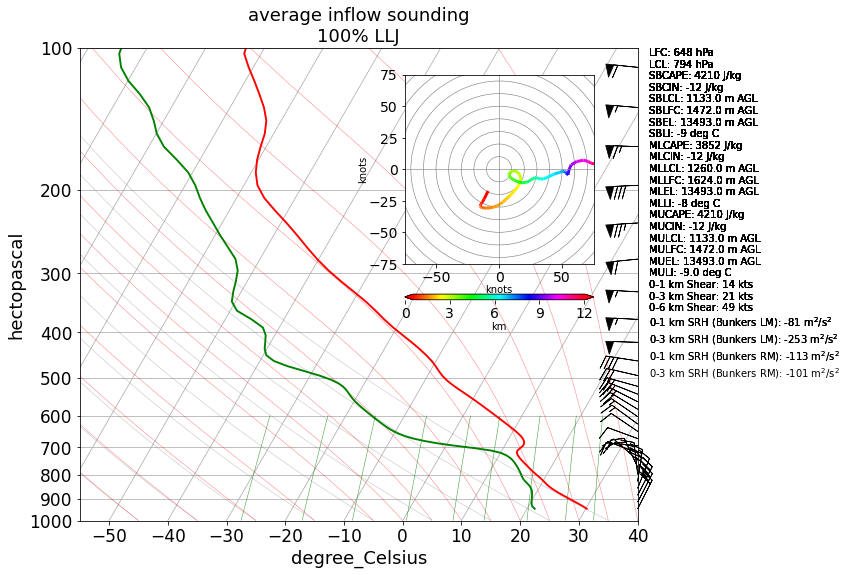

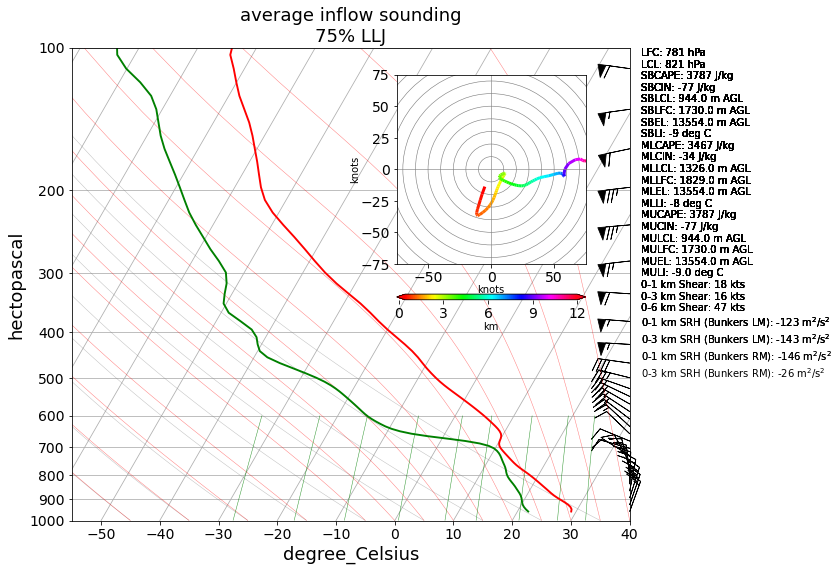

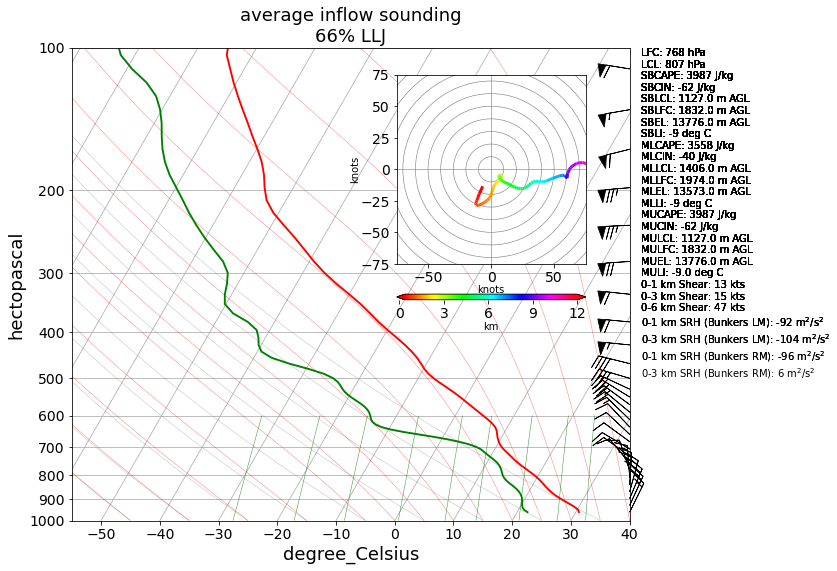

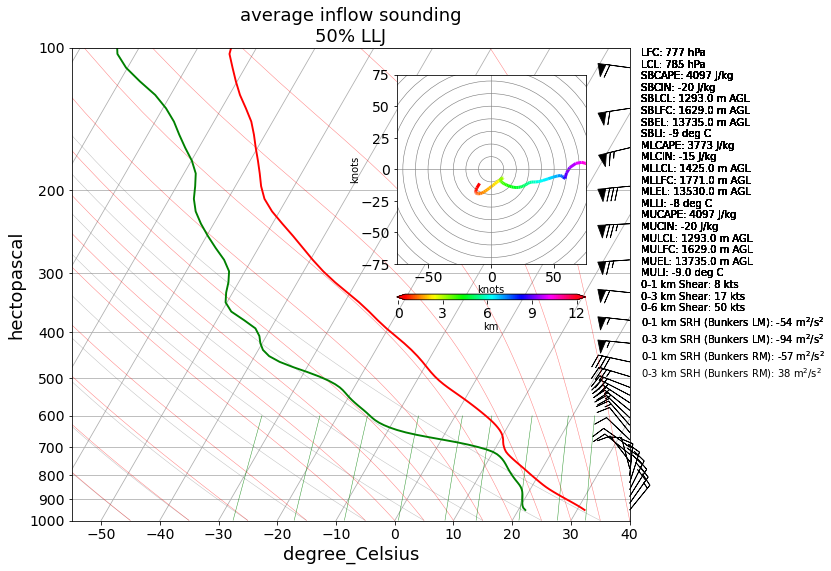

In [17]:
# Files are loaded in Section 6

snd_averaged_100 = np.mean(inflow_snd_data_100, axis=0)
df_snd_100 = pd.DataFrame(snd_averaged_100, columns=[
                          'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_75 = np.mean(inflow_snd_data_75, axis=0)
df_snd_75 = pd.DataFrame(snd_averaged_75, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_66 = np.mean(inflow_snd_data_66, axis=0)
df_snd_66 = pd.DataFrame(snd_averaged_66, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_50 = np.mean(inflow_snd_data_50, axis=0)
df_snd_50 = pd.DataFrame(snd_averaged_50, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

u,v,speed 0-1 km shear =  -0.7058601379394531 knot -13.521709442138672 knot 13.540121078491211 knot
u,v,speed 0-3 km shear =  16.732431411743164 knot 13.686136245727539 knot 21.61676597595215 knot
u,v,speed 0-6 km shear =  48.43573760986328 knot 11.504402160644531 knot 49.78325271606445 knot
LFC IS  (<Quantity(648.652983, 'hectopascal')>, <Quantity(10.5664086, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 535.4808349609375
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 535.4808349609375


/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


 SharpPy Bunkers:  (16.27837775698907, -28.674174207889777, 8.904582447859866, -0.4643052249909019)
Bunker's Storm Motion (right-mover): 16.27837775698907 -28.674174207889777
Bunker's Storm Motion (left-mover) : 8.904582447859866 -0.4643052249909019
 
MetPy Bunkers motion
right moving:  [11.448919608811359 -30.129929560244534] knot
left moving:  [1.1158240206083834 -2.864627379759048] knot
mean wind:  [6.2823718147098715 -16.497278470001792] knot
 
left moving (model/obs):  5.799085586543443 knot -0.4406714969039577 knot
100LLJ_inflow_avg_sounding.png
u,v,speed 0-1 km shear =  0.8490085601806641 knot -18.410968780517578 knot 18.43053436279297 knot
u,v,speed 0-3 km shear =  13.381331443786621 knot 9.73097038269043 knot 16.545448303222656 knot
u,v,speed 0-6 km shear =  47.013031005859375 knot 7.864441871643066 knot 47.666282653808594 knot
LFC IS  (<Quantity(781.537669, 'hectopascal')>, <Quantity(16.8006566, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 419.07965087890625
SURFACE HEIGHT (m 

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


 SharpPy Bunkers:  (16.501524109568297, -29.615430770347388, 10.48305426079055, -1.0856641051149296)
Bunker's Storm Motion (right-mover): 16.501524109568297 -29.615430770347388
Bunker's Storm Motion (left-mover) : 10.48305426079055 -1.0856641051149296
 
MetPy Bunkers motion
right moving:  [12.170075433314821 -30.77070939883359] knot
left moving:  [1.4874441385841477 -3.6404503501446612] knot
mean wind:  [6.828759785949485 -17.205579874489125] knot
 
left moving (model/obs):  9.06026232131012 knot 1.516055045793545 knot
75LLJ_inflow_avg_sounding.png
u,v,speed 0-1 km shear =  1.6335477828979492 knot -12.54687213897705 knot 12.652765274047852 knot
u,v,speed 0-3 km shear =  12.943037033081055 knot 8.7723970413208 knot 15.635765075683594 knot
u,v,speed 0-6 km shear =  47.02837371826172 knot 3.461648941040039 knot 47.155601501464844 knot
LFC IS  (<Quantity(768.381575, 'hectopascal')>, <Quantity(16.432137, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 384.30841064453125
SURFACE HEIGHT (m AGL): 

/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


 SharpPy Bunkers:  (15.09777654652715, -28.056273554972215, 10.221480321363462, 0.6907489068012893)
Bunker's Storm Motion (right-mover): 15.09777654652715 -28.056273554972215
Bunker's Storm Motion (left-mover) : 10.221480321363462 0.6907489068012893
 
MetPy Bunkers motion
right moving:  [9.236543808288022 -29.026687951431924] knot
left moving:  [1.583924854777225 -0.8911767497406746] knot
mean wind:  [5.410234331532624 -14.958932350586299] knot
 
left moving (model/obs):  8.518333314142483 knot 2.65801262956218 knot
66LLJ_inflow_avg_sounding.png
u,v,speed 0-1 km shear =  0.745844841003418 knot -8.003488540649414 knot 8.038166046142578 knot
u,v,speed 0-3 km shear =  16.80268096923828 knot 3.4146552085876465 knot 17.146135330200195 knot
u,v,speed 0-6 km shear =  50.437347412109375 knot 2.391664505004883 knot 50.4940185546875 knot
LFC IS  (<Quantity(777.348409, 'hectopascal')>, <Quantity(16.9635162, 'degree_Celsius')>)
SURFACE HEIGHT (m MSL): 465.1312255859375
SURFACE HEIGHT (m AGL): 0.0


/home/isingh9/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1428: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


 SharpPy Bunkers:  (14.31210682286291, -26.555444426405195, 10.434468740356186, 2.3432318096155367)
Bunker's Storm Motion (right-mover): 14.31210682286291 -26.555444426405195
Bunker's Storm Motion (left-mover) : 10.434468740356186 2.3432318096155367
 
MetPy Bunkers motion
right moving:  [7.187845313975174 -27.583577418214986] knot
left moving:  [3.3525563424467446 1.3207496961289618] knot
mean wind:  [5.270200828210959 -13.131413861043011] knot
 
left moving (model/obs):  7.126695846127403 knot 7.723828117268975 knot
50LLJ_inflow_avg_sounding.png


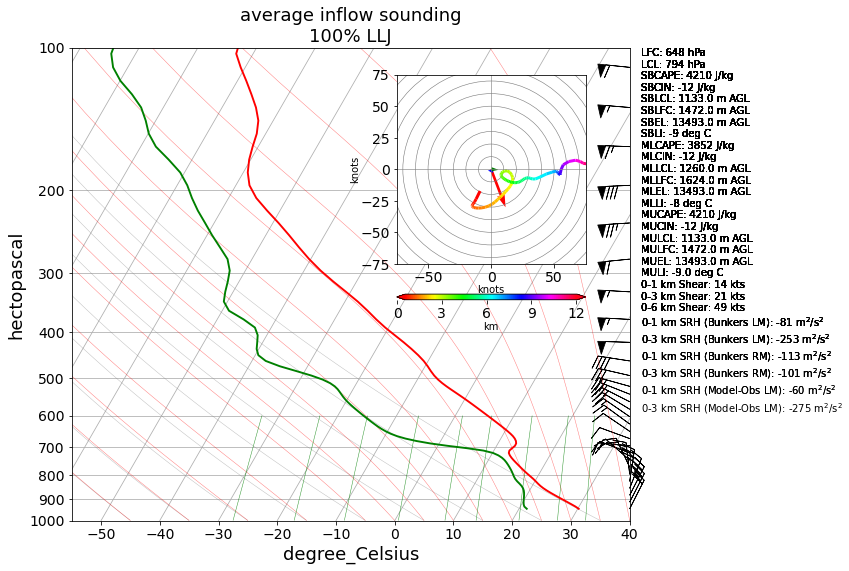

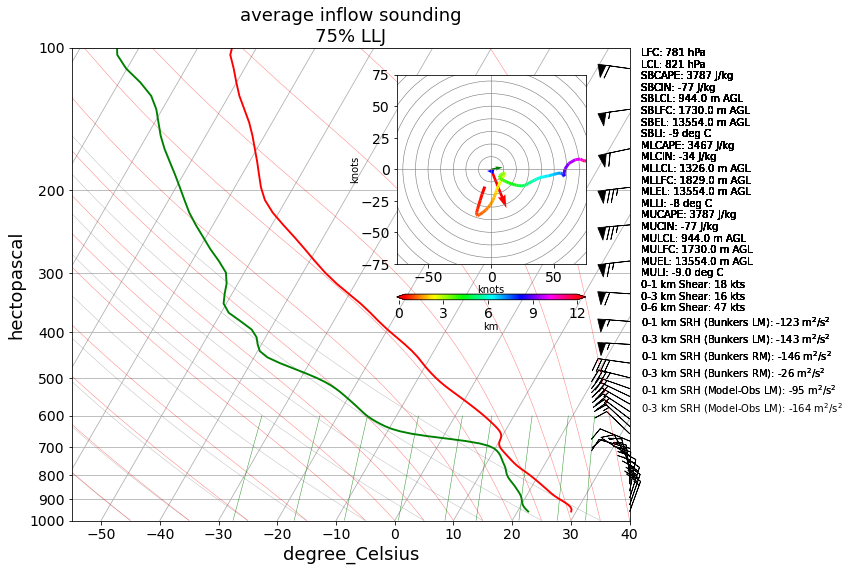

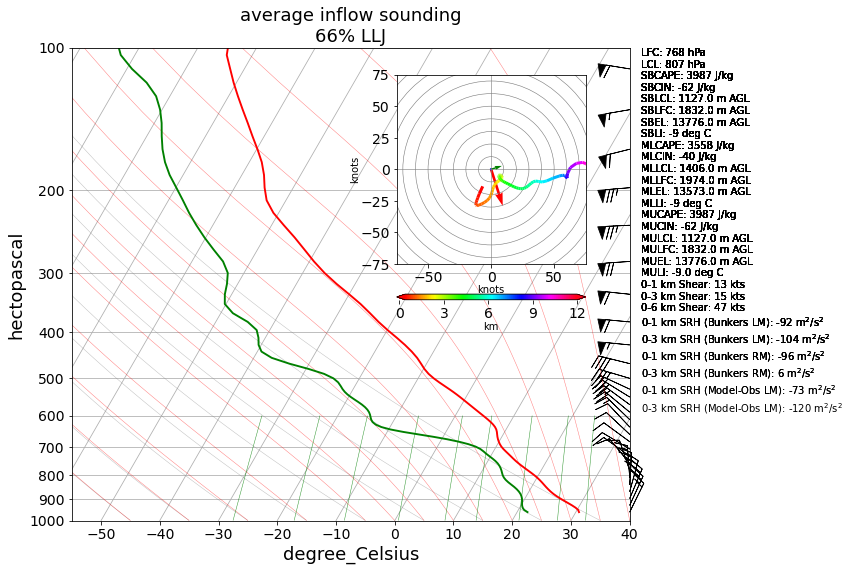

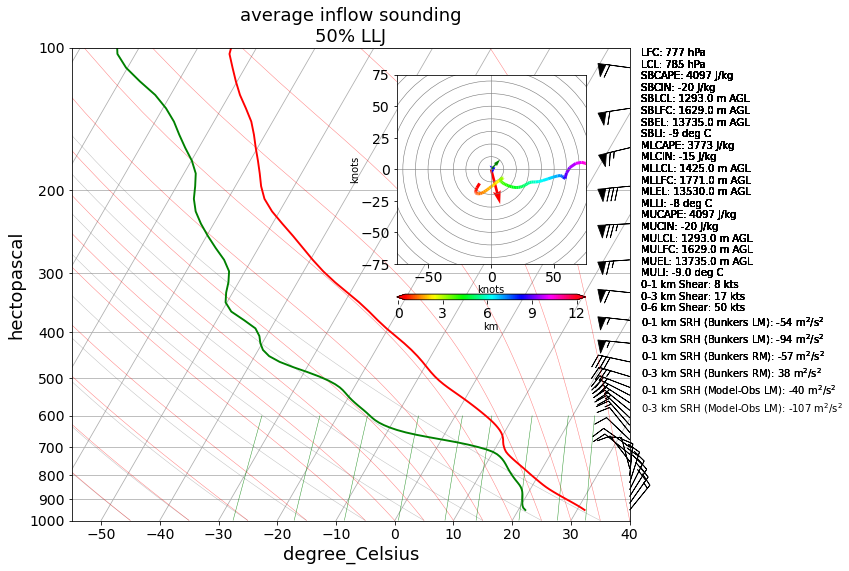

In [53]:
# skewT_CM1_inflow(DF, BARB_INTERVAL, PLOT_PARCEL_PROFILE, PROF_TV, PRINT_INDICES, TITLE, FILENAME, BUNKERS,
#                     WRITE_SRH_OBS, L_OR_R, U_STORM_OBS, V_STORM_OBS):

skewT_CM1_inflow(df_snd_100, 3, False, False, True, 'average inflow sounding\n100% LLJ',
                 '100LLJ_inflow_avg_sounding.png', True, True, 'L', dd100_track.u_storm.values.mean(), dd100_track.v_storm.values.mean())
skewT_CM1_inflow(df_snd_75, 3, False, False, True, 'average inflow sounding\n75% LLJ',
                 '75LLJ_inflow_avg_sounding.png', True, True, 'L',  dd75_track.u_storm.values.mean(), dd75_track.v_storm.values.mean())
skewT_CM1_inflow(df_snd_66, 3, False, False, True, 'average inflow sounding\n66% LLJ',
                 '66LLJ_inflow_avg_sounding.png', True, True, 'L',  dd66_track.u_storm.values.mean(), dd66_track.v_storm.values.mean())
skewT_CM1_inflow(df_snd_50, 3, False, False, True, 'average inflow sounding\n50% LLJ',
                 '50LLJ_inflow_avg_sounding.png', True, True, 'L',  dd50_track.u_storm.values.mean(), dd50_track.v_storm.values.mean())

In [50]:
print(dd100_track.u_storm.values.mean())
print(dd100_track.v_storm.values.mean())

2.9833073628551268
-0.2267010034072582


## Inflow sounding at max updraft area

In [ ]:
# track_data_stored = np.load(CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_ud_sounding_2018-11-10_2030-2)
snd_data_stored_100 = np.load(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_ud_sounding_2018-11-10_2030-2018-11-10_2155.npy')
dd100_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_stampede_cm1_20.3_RW_LLJ_100_percent_reduced_1km_supercell2_ud_track_data_2018-11-10_2030-2018-11-10_2155.csv', index_col=0, parse_dates=True)

snd_data_stored_75 = np.load(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_ud_sounding_2018-11-10_2215-2018-11-11_0140.npy')
dd75_sc1_track = pd.read_csv(
    'CM1_CENTROID_INITIAL_cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km_supercell2_ud_track_data_2018-11-10_2215-2018-11-11_0140.csv', index_col=0, parse_dates=True)

snd_data_stored_50 = np.load(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_sounding_2018-11-10_1740-2018-11-10_2300.npy')
dd50_sc1_track = pd.read_csv(
    'CM1_CENTROID_cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km_ud_track_data_2018-11-10_1740-2018-11-10_2300.csv', index_col=0, parse_dates=True)

snd_averaged_100 = np.mean(snd_data_stored_100, axis=0)
df_snd_100 = pd.DataFrame(snd_averaged_100, columns=[
                          'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_75 = np.mean(snd_data_stored_75, axis=0)
df_snd_75 = pd.DataFrame(snd_averaged_75, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])

snd_averaged_50 = np.mean(snd_data_stored_50, axis=0)
df_snd_50 = pd.DataFrame(snd_averaged_50, columns=[
                         'pressure', 'height', 'temperature', 'dewpoint', 'u_wnd', 'v_wnd'])


skewT_CM1_inflow(df_snd_100, 3, False, False, True, 'average inflow sounding\n100% LLJ',
                 '100LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)
skewT_CM1_inflow(df_snd_75, 3, False, False, True, 'average inflow sounding\n75% LLJ',
                 '75LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)
skewT_CM1_inflow(df_snd_50, 3, False, False, True, 'average inflow sounding\n50% LLJ',
                 '50LLJ_inflow_avg_sounding.png', False, False, 'L', None, None)

# Time series of quantities

In [ ]:
import matplotlib.dates as mdates
variable = ['cape']


def plot_var_timeseries(VARNAME, var_LEVEL, XR_DARRAY, UL_XIND, UL_YIND, BR_XIND, BR_YIND):

    if VARNAME == "pertprs_gradient":
        print(VARNAME)
        ui = XR_DARRAY.variables['prspert'][0,
                                            var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(ui, fill_value=np.nan)
        var.values = np.gradient(ui.values, dx*1000.0, axis=1)  # *-1.0
        var.attrs['long_name'] = 'perturbation pressure gradient'
        var.attrs['units'] = '$Pa m^{-1}$'

    elif VARNAME == "qadv":
        q = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                      BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][0,
                                           var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][0,
                                           var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        qadv = np.array((u*np.gradient(q, dx*1000.0, axis=1) +
                        v*np.gradient(q, dy*1000.0, axis=0))*(-10**6))
        var = xr.DataArray(data=np.array(qadv), dims=['nj', 'ni'], attrs={'long_name': 'moisture advection',
                                                                          'units': '$10^{-6}  kg/kg/s$'})

    elif VARNAME == "max_w_hgt":
        w = XR_DARRAY.variables['winterp'][0,
                                           LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        # print(w)
        max_idx = np.argmax(w, axis=0)
        ter = XR_DARRAY.variables['zs'][0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = XR_DARRAY.zh[0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vs = vs[max_idx] - ter
        lfc = XR_DARRAY.variables['lfc'][0,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND]  # -ter
        var = vs/lfc
        var.attrs['long_name'] = 'ratio of hgt of $w_{max}/lfc$'
        var.attrs['units'] = '$m$'

    elif VARNAME == "0-3km_shear":
        u_3 = XR_DARRAY.variables['uinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_3 = XR_DARRAY.variables['vinterp'][0,
                                             30, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_3 - u_0)*1.94384
        v_shr = (v_3 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-3 km shear',
                                                                           'units': 'knots'})
        print(var.max().values)

    elif VARNAME == "0-6km_shear_model":
        u_55 = XR_DARRAY.variables['uinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_55 = XR_DARRAY.variables['vinterp'][0,
                                              55, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        v_0 = XR_DARRAY.variables['vinterp'][0,
                                             0, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        u_shr = (u_55 - u_0)*1.94384
        v_shr = (v_55 - v_0)*1.94384
        shear = np.sqrt(u_shr**2 + v_shr**2)
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                           'units': 'knots'})

    elif VARNAME == "0-6km_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, zz[0, :, :].values +
                          6000., missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                           'units': 'knots'})
        #print('max value of var ',var,' is ',var.max().values)

    elif VARNAME == "0-6km_AMSL_shear":
        #u_6 = XR_DARRAY.variables['uinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #v_6 = XR_DARRAY.variables['vinterp'][0,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u_0 = XR_DARRAY.variables['uinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        v_0 = XR_DARRAY.variables['vinterp'][0, 0,
                                             BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        uu = XR_DARRAY.variables['uinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vv = XR_DARRAY.variables['vinterp'][0,
                                            :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        zz = XR_DARRAY.variables['zh'][0, :, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        #print(zz[0,:,:] + 6000.)
        u_6 = interplevel(uu.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        v_6 = interplevel(vv.values, zz.values, 6000.,
                          missing=9.969209968386869e+36, squeeze=True, meta=True)
        #u_0 = XR_DARRAY.variables['u10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        #v_0 = XR_DARRAY.variables['v10'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*1.94384
        u_shr = (u_6 - u_0)*1.94384
        v_shr = (v_6 - v_0)*1.94384
        print(np.shape(u_shr))
        shear = np.sqrt(u_shr**2 + v_shr**2)
        print(np.shape(shear))
        var = xr.DataArray(data=np.array(shear), dims=['nj', 'ni'], attrs={'long_name': '0-6 km shear',
                                                                           'units': 'knots'})
        #print('max value of var ',var,' is ',var.max().values)

    elif VARNAME == "thetae":
        prs = XR_DARRAY.variables['prs'][0, var_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        shum = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=temp, specific_humidity=shum)
        var = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=temp, dewpoint=dewpt)
        var = xr.DataArray(data=np.array(var), dims=['nj', 'ni'], attrs={'long_name': 'Equivalent potential temperature',
                                                                         'units': 'K'})

    elif VARNAME == "sfc_thetae":
        prs = XR_DARRAY.variables['psfc'][0, BR_YIND:UL_YIND,
                                          UL_XIND:BR_XIND].values*munits('Pa')
        t2 = XR_DARRAY.variables['t2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('K')
        q2 = XR_DARRAY.variables['q2'][0, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        shum = mcalc.specific_humidity_from_mixing_ratio(q2)
        dewpt = mcalc.dewpoint_from_specific_humidity(
            pressure=prs, temperature=t2, specific_humidity=shum)
        var = mcalc.equivalent_potential_temperature(
            pressure=prs, temperature=t2, dewpoint=dewpt)
        var = xr.DataArray(data=np.array(var), dims=['nj', 'ni'], attrs={'long_name': 'Surface equivalent potential temperature',
                                                                         'units': 'K'})

    elif VARNAME == "density_theta":
        Rv = 461.5
        Rd = 287.04
        th = XR_DARRAY.variables['th'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('Pa')
        qv = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values  # *munits('K')
        # *munits('kg/kg')
        qc = XR_DARRAY.variables['qc'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        # *munits('kg/kg')
        qr = XR_DARRAY.variables['qr'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values
        ql = qc + qr
        var = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
        var = xr.DataArray(data=np.array(var), dims=['nj', 'ni'], attrs={'long_name': 'density potential temperature',
                                                                         'units': 'K'})

    elif VARNAME == "temperature":
        prs = XR_DARRAY.variables['prs'][0, var_LEVEL,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, var_LEVEL,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('kg/kg')
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        var = xr.DataArray(data=np.array(temp), dims=['nj', 'ni'], attrs={'long_name': 'temperature',
                                                                          'units': 'K'})
    elif VARNAME == "vintqc":
        prs = XR_DARRAY.variables['prs'][0, 1:,
                                         BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('Pa')
        th = XR_DARRAY.variables['th'][0, 1:,
                                       BR_YIND:UL_YIND, UL_XIND:BR_XIND].values*munits('K')
        qv = XR_DARRAY.variables['qv'][0, 1:, BR_YIND:UL_YIND,
                                       UL_XIND:BR_XIND].values*munits('kg/kg')
        qc = XR_DARRAY.variables['qc'][0, 1:, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        temp = mcalc.temperature_from_potential_temperature(prs, th)
        # R=287.0
        # Cp=1004.0
        # T=XR_DARRAY.variables['th'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*(XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/100000.0)**(R/Cp)
        #rho = XR_DARRAY.variables['prs'][0,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
        rho = mcalc.density(pressure=prs, temperature=temp, mixing=qv)
        # print(rho)
        # print(np.max(rho.values))
        vertical_spacings = XR_DARRAY.zh[0, 1:, BR_YIND:UL_YIND,
                                         UL_XIND:BR_XIND]-XR_DARRAY.zh[0, :-1, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vint_qx = qc*rho.magnitude*vertical_spacings
        var = vint_qx.sum(dim='nk')
        var.attrs['long_name'] = 'Vertically integrated ' + \
            qc.attrs['long_name']
        var.attrs['units'] = '$kg/m^{2}$'

    elif VARNAME == "wmax":
        w_temp = XR_DARRAY.variables['winterp'][0,
                                                LEVEL1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = w_temp.max(dim='nk')
        var.attrs['long_name'] = 'max PBL ' + w_temp.attrs['long_name']
        var.attrs['units'] = w_temp.attrs['units']

    elif VARNAME == "np_hadv":
        print(VARNAME)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(qv, fill_value=np.nan)
        var.values = (vi.values*np.gradient(qv.values, dy*1000.0, axis=1) +
                      ui.values*np.gradient(qv.values, dx*1000.0, axis=2))*-1000.  # +
        var.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME == "du_dx":
        print(VARNAME)
        ui = XR_DARRAY.variables['uinterp'][0,
                                            var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(ui, fill_value=np.nan)
        var.values = (np.gradient(ui.values, dx*1000.0, axis=1))  # *1000.#+
        var.attrs['long_name'] = 'du/dx'
        var.attrs['units'] = '$s^{-1}$'

    elif VARNAME == "np_xadv":
        print(VARNAME)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        ui = XR_DARRAY.variables['uinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(qv, fill_value=np.nan)
        var.values = (ui.values*np.gradient(qv.values,
                      dx*1000.0, axis=2))*-1000.  # +
        var.attrs['long_name'] = 'qv budget: x-advection of qv'
        var.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME == "np_yadv":
        print(VARNAME)
        qv = XR_DARRAY.variables['qv'][0, LEVEL1 +
                                       1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        vi = XR_DARRAY.variables['vinterp'][0, LEVEL1 +
                                            1:LEVEL2, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = xr.full_like(qv, fill_value=np.nan)
        var.values = (vi.values*np.gradient(qv.values,
                      dy*1000.0, axis=1))*-1000.  # +
        var.attrs['long_name'] = 'qv budget: y-advection of qv'
        var.attrs['units'] = '$g/kg^{-1}s^{-1}$'

    elif VARNAME == "dbz":
        print(VARNAME)
        var = XR_DARRAY.variables['dbz'][0,
                                         var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = var.where(var > -10.0)

    elif VARNAME == 'prspert_calc':
        print(VARNAME)
        prs_final = XR_DARRAY.variables['prs'][0,
                                               var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        XR_DARRAY2 = xr.open_dataset(DIR+EXP+'/cm1out_000001.nc')
        prs_init = XR_DARRAY2.variables['prs'][0,
                                               var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        var = prs_final - prs_init
        var.attrs['long_name'] = 'pressure perturbation'
        var.attrs['units'] = '$Pa$'

    else:
        print(VARNAME+' variable found in the dataset')
        if var_LEVEL != None:
            var = XR_DARRAY.variables[VARNAME][0,
                                               var_LEVEL, BR_YIND:UL_YIND, UL_XIND:BR_XIND]
        else:
            var = XR_DARRAY.variables[VARNAME][0,
                                               BR_YIND:UL_YIND, UL_XIND:BR_XIND]
            # print(var.max())

    # print(var)
    tti = extract_CM1_time(XR_DARRAY)[0]
    print('time is : ', tti)

    varmean = var.mean()
    print('var is : ', varmean.values)

    return varmean.values, tti


run_this_func = True
direc_list = []

ul_xind1 = 600
ul_yind1 = 575
br_xind1 = 650
br_yind1 = 550

var_list = []
times_list = []
variables = ['cape', 'cin']

exps = ['cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km',
        'cm1_20.3_stampede_RW_LLJ_reduced_50_percent_1km']

for varr in variables:
    print('\n\n')
    print('VARIABLE: ', varr)
    print('\n')
    direc_list = []
    # direc_list.append("/home/isingh9/scratch/temp_project/cm1_20.3_stampede_RW_LLJ_reduced_75_percent_1km/")
    direc_list.append("/home/isingh9/scratch/temp_project/")

    fig = plt.figure(figsize=(15, 11), frameon=False)
    ax1 = plt.gca()

    for exp in exps:
        print('experiment: ', exp)
        fi_list = []
        fi_list.append(
            sorted(glob.glob(direc_list[0]+exp+"/"+"cm1out_00*.nc")))  # +\
        # sorted(glob.glob(direc_list[0]+"cm1out_0001??.nc")))# +\
        # sorted(glob.glob(direc_list[0]+"cm1out_0001[0-4]?.nc")))

        print(fi_list)

        if run_this_func:
            for fil in fi_list[0]:
                print(' ')
                da1 = xr.open_dataset(fil)
                uu, vv = plot_var_timeseries(
                    varr, None, da1, ul_xind1, ul_yind1, br_xind1, br_yind1)
                var_list.append(uu)
                times_list.append(pd.to_datetime(vv))

        plt.plot(times_list, var_list, label=exp)

    ax1.set_xlabel('time (UTC)')
    ax1.set_ylabel(varr)  # xx+'('+yy+')')
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(myFmt)
    filename = 'timeseries_comparison_'+varr+'.png'
    plt.legend()
    print(filename)
    plt.savefig(filename, dpi=200)
    # plt.close()

In [ ]:
# Trajectory analysis for time of max 

In [ ]:
ii = 0 
for col in df_all.columns:
    print(col.replace(" ", "_"))
    plt.figure(figsize=(11,8))
    df_all[col].plot()
    plt.title(col+' ('+units_indices[ii]+')')
    filename='CM1_comparison_50_75_LLJ_inflow_'+(col.replace(' ','_'))+'.png'
    print(filename)
    plt.savefig(filename,dpi=200)
    plt.close()
    ii = ii + 1

In [ ]:
for col in df_all:
    print()

In [ ]:
for ii in np.arange(0,len(snd_data),1):
    fname = 'inflow_sounding_'+times[ii]+'.txt'
    print(fname)
    np.savetxt(fname,snd_data[ii])

In [ ]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig= plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

times=pd.to_datetime(times)
pp=ax.scatter(times,w_max_height_list,c=w_max_list,s=49,cmap=plt.get_cmap('gist_ncar'))

ax.set_ylabel('Height (m)')
#ax.set_ylabel('Updraft helicity $(m^{2}s^{-2})$')
ax.set_xlabel('Time (UTC)')
ax.set_title('Time series of $w_{max}$ height (m) and $UH_{max}$ $(m^{2}s^{-2})$')
ax.set_xlim([min(times) - pd.Timedelta('4 minutes'), max(times) + pd.Timedelta('4 minutes')])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Updraft helicity $(m^{2}s^{-2})$')  # we already handled the x-label with ax1
ax2.plot(times, uh_max_list,color='k')
#ax2.tick_params(axis='y', labelcolor=color)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=1.15)
bar = plt.colorbar(pp, cax=cax)#, orientation="horizontal")
bar.ax.tick_params(labelsize=18)

date_form = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
# Ensure a major tick for each week using (interval=1) 
#ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
#plt.colorbar(pp, orientation='horizontal',aspect=40)
ax.grid(b=True, color='gray', linestyle='-')
plt.tight_layout()
fig.savefig('timeseries_w_max_hgt.pdf',bbox_inches="tight")#,dpi=300)

In [ ]:
def get_pbl_level(XAR,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    pblh       = XAR.variables['hpbl'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh        = XAR.variables['zh']  [0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh        = abs(zhh - pblh)
    pbl_level  = zhh.argmin(dim='nk')
    return pbl_level

aaa=xr.open_dataset(fi_list[0][some])
answer=get_pbl_level(aaa,ul_xind1,ul_yind1,br_xind1,br_yind1)
print(answer)

# Time-averaged maps

In [ ]:
def get_pbl_level(XAR):
    pblh       = XAR.variables['hpbl'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh        = XAR.variables['zh'][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    zhh.values = zhh.values - pblh.values
    pbl_level  = zhh.argmin(dim='nk')
    return pbl_level

def plot_var(VARNAME1,VAR1_LEVEL,VARNAME2,VAR2_LEVEL,VARNAME3,VAR3_LEVEL,VARNAME4,VAR4_LEVEL,\
             SEGM,THRES,AREA,\
             XR_DARRAY,TIME1,TIME2,\
             IF_DENSITY_WTD,VINT_SCALAR,VINT_UNITS,LEVEL1,LEVEL2,\
             CONV_LINE_VARIATION,LINE_CHARAC,
             UL_XIND,UL_YIND,BR_XIND,BR_YIND,\
             CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,LEVELS_VAR3,COLOR_VAR3,LEVELS_VAR4,COLOR_VAR4,\
             TITLE,COLORMAP,AX,\
             PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
    ############################## VAR1 START ##################################################################################
    if VAR1_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,VAR1_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='blue',linewidths=1.4,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############            
    if VARNAME2=="mass_conv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(ui,fill_value=np.nan)
            var2.values=((np.gradient(ui.values,dx*1000.0,axis=3)+np.gradient(vi.values,dy*1000.0,axis=2)))*-1.0
            var2.attrs['long_name'] = 'mass convergence'
            var2.attrs['units'] = '$s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-1.0)
            var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$s^{-1}$'})
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="div_mf":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(vi.values*qv.values,dy*1000.0,axis=2)+\
                         np.gradient(ui.values*qv.values,dx*1000.0,axis=3))*-1.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(vi.values*qv.values,dy*1000.0,axis=1)+\
                         np.gradient(ui.values*qv.values,dx*1000.0,axis=2))*-1.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
    
    elif VARNAME2=="div_mf_stretching_term":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(vi.values,dy*1000.0,axis=2)+\
                                   np.gradient(ui.values,dx*1000.0,axis=3))*-1.
            var2.attrs['long_name'] = 'MFC: convergence term'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(vi.values,dy*1000.0,axis=1)+\
                                   np.gradient(ui.values,dx*1000.0,axis=2))*-1.
            var2.attrs['long_name'] = 'moisture flux divergence'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
    
    elif VARNAME2=="d(qw)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(wi.values*qv.values,100.0,axis=1))*1.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(np.gradient(wi.values*qv.values,100.0,axis=1))*1.
            var2.attrs['long_name'] = 'd(qu)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True).mean(dim='nk',keep_attrs=True)
        
    elif VARNAME2=="qd(w)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(wi.values,100.0,axis=1))*1000.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=qv.values*(np.gradient(wi.values,100.0,axis=1))*1.
            var2.attrs['long_name'] = 'qd(w)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True).mean(dim='nk',keep_attrs=True)
                                   
    elif VARNAME2=="wd(q)/dz":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'): 
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=wi.values*(np.gradient(qv.values,100.0,axis=0))*1.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            wi=XR_DARRAY.variables['winterp'][TIME1:TIME2,(VAR2_LEVEL-1):(VAR2_LEVEL+1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=wi.values*(np.gradient(qv.values,100.0,axis=0))*1.
            var2.attrs['long_name'] = 'wd(q)/dz'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True).mean(dim='nk',keep_attrs=True)
    
    elif VARNAME2=='bmin':
        prs_levs    = XR_DARRAY.variables['prs'][TIME1:TIME2,0:50,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        hgts   = XR_DARRAY.variables['zh'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('m')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        sphum  = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(specific_humidity=sphum,temperature=temp,pressure=prs)
        #thetae = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        #max_idx= np.argmax(thetae,axis=0)
        print(prs_levs)
        print(temp)
        print(dewpt)
        #aa=mcalc.parcel_profile(pressure=,temperature=,dewpt=)
        print(aa)
        var2=aa[0,:,:]
        var2 = var2.mean(dim='time',keep_attrs=True)

    elif VARNAME2=="max_w_hgt": 
        w = XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        #print(w)
        max_idx= np.argmax(w,axis=0)
        ter = XR_DARRAY.variables['zs'][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vs = XR_DARRAY.zh[TIME1:TIME2,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vs = vs[max_idx] - ter
        lfc = XR_DARRAY.variables['lfc'][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND] #-ter
        var2=vs/lfc
        var2.attrs['long_name'] = 'ratio of hgt of $w_{max}/lfc$' 
        var2.attrs['units'] = '$m$'
        var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="0-3kmshear": 
        u_3 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_3 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_shr  = (u_3 - u_0)*1.94384
        v_shr  = (v_3 - v_0)*1.94384
        shear   = np.sqrt(u_shr**2 + v_shr**2)
        var2   = xr.DataArray(data=np.array(shear),dims=['nj','ni'],attrs={'long_name':'0-3 km shear' ,\
                                                                       'units':'knots'})
        
    elif VARNAME2=="0-6kmshear": 
        u_6 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_6 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        u_shr  = (u_6 - u_0)*1.94384
        v_shr  = (v_6 - v_0)*1.94384
        shear   = np.sqrt(u_shr**2 + v_shr**2)
        var2   = xr.DataArray(data=np.array(shear),dims=['nj','ni'],attrs={'long_name':'0-6 km shear' ,\
                                                                       'units':'knots'}) 
        
    elif VARNAME2=="mconv":
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
            var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
            var2=var2.mean(dim='time',keep_attrs=True)
        else:
            q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
            var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
            var2=var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="wmax":
        w_temp = XR_DARRAY.variables['winterp'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2   = w_temp.max(dim='nk')
        var2.attrs['long_name'] = 'max PBL ' + w_temp.attrs['long_name']
        var2.attrs['units'] = w_temp.attrs['units']
        var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="np_hadv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=((vi.values*np.gradient(qv.values,dy*1000.0,axis=2))+(ui.values*np.gradient(qv.values,dx*1000.0,axis=3)))*-1.#+ 
            var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1.#+ 
            var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
            var2.attrs['units'] = '$kg/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="np_xadv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: x-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: x-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="np_yadv":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: y-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
        else:
            qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            var2 = xr.full_like(qv,fill_value=np.nan)
            var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.#+ 
            var2.attrs['long_name'] = 'qv budget: y-advection of qv'
            var2.attrs['units'] = '$g/kg^{-1}s^{-1}$'
            var2 = var2.mean(dim='time',keep_attrs=True)
            
    elif VARNAME2=="qvb_total":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hadv=XR_DARRAY.variables['qvb_hadv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vadv=XR_DARRAY.variables['qvb_vadv'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_mp=XR_DARRAY.variables['qvb_mp'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_pbl=XR_DARRAY.variables['qvb_pbl'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff+qvb_hadv+qvb_vadv+qvb_pbl+qvb_mp
            var2.attrs['long_name'] = 'qv budget: total'
            var2 = var2.mean(dim='time',keep_attrs=True)

        else:
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hadv=XR_DARRAY.variables['qvb_hadv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vadv=XR_DARRAY.variables['qvb_vadv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_pbl=XR_DARRAY.variables['qvb_pbl'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_mp=XR_DARRAY.variables['qvb_mp'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff+qvb_hadv+qvb_vadv+qvb_pbl+qvb_mp
            var2.attrs['long_name'] = 'qv budget: total'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="qvb_small_terms":
        print(VARNAME2)
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff
            var2.attrs['long_name'] = 'qv budget: other terms'
            var2 = var2.mean(dim='time',keep_attrs=True)

        else:
            qvb_hturb=XR_DARRAY.variables['qvb_hturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vturb=XR_DARRAY.variables['qvb_vturb'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hidiff=XR_DARRAY.variables['qvb_hidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_vidiff=XR_DARRAY.variables['qvb_vidiff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            qvb_hediff=XR_DARRAY.variables['qvb_hediff'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            
            var2 = qvb_hturb+qvb_vturb+qvb_hidiff+qvb_vidiff+qvb_hediff
            var2.attrs['long_name'] = 'qv budget: other terms'
            var2 = var2.mean(dim='time',keep_attrs=True)
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
    ############ SPECIAL VARIABLES END ############# 
    else:
        print('REGULAR VARIABLE')
        if (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
            var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        else:
            if VAR2_LEVEL!=None:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,VAR2_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            else:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
               ############################### density weighted calculations moisture budget ############### 

    if IF_DENSITY_WTD=="rhowtd":
        print("rho-weighted volume-averaged quantity")
        def calc_rho_wt_adv_quant(NAME):
            R=287.0
            Cp=1004.0
            T=XR_DARRAY.variables['th'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                (XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                 /100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
            rho = rho.mean(dim='time',keep_attrs=True)

            vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,LEVEL1+1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
                                XR_DARRAY.zh[TIME1:TIME2,LEVEL1:LEVEL2-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vertical_spacings = vertical_spacings.mean(dim='time',keep_attrs=True)
            d_volumes=vertical_spacings*dx*1000.0*dy*1000.0
            M_grid=rho*d_volumes
            M = M_grid.sum(dim='nk',keep_attrs=True)
            quantity_3d=NAME*(rho)*d_volumes
            vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True)
            vint_quantity_divM = vint_quantity/M
            vint_quantity_divM.attrs['long_name'] = 'rho-weighted vol. avgd.' + NAME.attrs['long_name']
            vint_quantity_divM.attrs['units'] = NAME.attrs['units']
            return vint_quantity_divM
        
        var2=calc_rho_wt_adv_quant(var2)
        
    if IF_DENSITY_WTD=="vint":
        print("vertically integrated quantity")
        #print("3D quantity")
        def calc_vertically_integrated_quantity(NAME,V_SCALAR,V_UNITS):
            R=287.0
            Cp=1004.0
            T=XR_DARRAY.variables['th'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                (XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                 /100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
            rho = rho.mean(dim='time',keep_attrs=True)
            #print(rho)
            vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,(LEVEL1+1):LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-\
                                XR_DARRAY.zh[TIME1:TIME2,LEVEL1:(LEVEL2-1),BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            vertical_spacings= vertical_spacings.mean(dim='time',keep_attrs=True)
            vint_3d=NAME*rho*vertical_spacings
            vint2d=vint_3d.sum(dim='nk')
            vint2d.values=vint2d.values*V_SCALAR
            vint2d.attrs['long_name'] = 'Vertically integrated ' + NAME.attrs['long_name']
            vint2d.attrs['units'] = V_UNITS
            return vint2d
        ##############################################################################
        var2=calc_vertically_integrated_quantity(var2,VINT_SCALAR,VINT_UNITS)
    
    conv_line_var=None
    
    if CONV_LINE_VARIATION==True:
        def calc_rho_wt_adv_quant(NAME):
            ################### AVERAGING OF QUANTITIES #####################################
            #print("2D quantity")
            quantity_new = xr.full_like(NAME,fill_value=np.nan).values
            quantity_new[rows,cols] = var2.values[rows,cols]
            print(np.shape(quantity_new))
            if LINE_CHARAC=="mean":
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                #print('mean')
            elif LINE_CHARAC=="max":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
                #print('max')
            elif LINE_CHARAC=="min":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
            else:
                quantity_mean_x=None
                #print('min')
            print(np,shape(quantity_mean_x))
            return quantity_mean_x
            ##############################################################################################
        conv_line_var=calc_rho_wt_adv_quant(var2)

    if (VARNAME3!=None):
        print(VARNAME3)
        
        if (VAR3_LEVEL!=None):
            var3 = XR_DARRAY.variables[VARNAME3][TIME1:TIME2,VAR3_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        else:    
            var3 = XR_DARRAY.variables[VARNAME3][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)

        C8 = plt.contour(XH,YH,var3,levels = LEVELS_VAR3 ,colors=COLOR_VAR3,axis=AX,extend='both',linewidths=1.6)
        AX.clabel(C8, C8.levels, inline=True, fmt="%.0f", fontsize=12)

    if (VARNAME4!=None):
        if (VAR4_LEVEL!=None):
            var4 = XR_DARRAY.variables[VARNAME4][TIME2,VAR4_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        else:    
            var4 = XR_DARRAY.variables[VARNAME4][TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]

        C9 = plt.contour(XH,YH,var4,levels = LEVELS_VAR4 ,colors=COLOR_VAR4,axis=AX,extend='both',linewidths=1.6)

    print(var2) 

    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        u10.values=u10.values*1.94384
        u10.attrs['units']='knots'
        
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)
        v10.values=v10.values*1.94384
        v10.attrs['units']='knots'
        
        winds_thin_x=30
        n=4
        if WIND_STYLE=='barbs': 
            AX.barbs(XH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                    u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], length=6, pivot='middle',flip_barb=True)
        
        elif WIND_STYLE=='0-3kmshear':
            u_3 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_3 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,30,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            shr_u=u_3.values-u_0.values
            shr_v=v_3.values-v_0.values
            AX.barbs(XH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                    shr_u[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],shr_v[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], length=5.8, pivot='middle',flip_barb=True)
                
        elif WIND_STYLE=='0-6kmshear':
            u_6 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_6 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,57,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            u_0 = XR_DARRAY.variables['uinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            v_0 = XR_DARRAY.variables['vinterp'][TIME1:TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time')*1.94384
            shr_u=u_6.values-u_0.values
            shr_v=v_6.values-v_0.values
            AX.barbs(XH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], YH[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                    shr_u[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],shr_v[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], length=5.8, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=0.8, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'limegreen',\
                         linewidths=1.8,linestyles='--', axis=AX)
    
    # plot terrain
    levels_zs   = np.arange(500.,2700.,400.)
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    #AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    
    AX.hlines(490,xmin=501,xmax=625)
    #AX.add_patch(mpl.patches.Rectangle((535,500),5,30,fill=None, lw=1.5, edgecolor='k', zorder=10))
    
    #AX.add_patch(mpl.patches.Rectangle((515,490), 20,20,
    #                                fill=None, lw=1.5, edgecolor='red', zorder=10))

    #AX.add_patch(mpl.patches.Rectangle((575,470), 20,20,
    #                                fill=None, lw=1.5, edgecolor='red', zorder=10))

    if TITLE:
        title=TITLE
    elif (IF_DENSITY_WTD=='vint') or (IF_DENSITY_WTD=='rhowtd'):
        title = var2.attrs['long_name']
    else:
        if VAR2_LEVEL:
            title = var2.attrs['long_name']+" at model level "+str(VAR2_LEVEL+1)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'

    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + '-' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,False,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    var2_line = True
    return var2.attrs['long_name'],var2.attrs['units'],conv_line_var,IF_DENSITY_WTD


run_this_func=True
direc_list=[]



#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00000[7-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000010.nc"))
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))

# settings for 1-km simulations
# settings for 1-km simulations THETA-E COMPARISON PLOT
ul_xind1=400 #upper left corner x#520
ul_yind1=815 #upper left corner y720
br_xind1=668 #bottom right corner x700
br_yind1=350 #bottom right corner y#450


XH, YH = np.meshgrid(xh[0][ul_xind1:br_xind1], yh[0][br_yind1:ul_yind1])
XV, ZV = np.meshgrid(xh[ul_xind1:br_xind1], z)
YVV, ZVV = np.meshgrid(yh[br_yind1:ul_yind1], z)


if run_this_func:

    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')

    make_line_plot = False 
    #list_vars=['qvb_hadv','qvb_vadv','qvb_mp','qvb_pbl','qvb_small_terms','qvb_total']
    #for element in list_vars:

    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    if make_line_plot:
        fig = plt.figure(figsize=(15,11),frameon=False)
        ax_1 = subplot(1,2,1)
    else:
        fig = plt.figure(figsize=(8,11),frameon=False)
        ax_1 = subplot(1,1,1)
    #ax_1.set_aspect('equal')
    element='winterp'
    
    nn,uu,qq,vv=plot_var("winterp",10, element,4,  
                         None,None,
                         None,None,
                         False,0.5,100,
                         da1,0,len(fi_list)-1,
                         "NO",1.,'$kgm^{-2}$',0,15,
                         False,'mean', 
                         ul_xind1,ul_yind1,br_xind1,br_yind1,
                         0,-2,2.1,.1,20,    
                         [5.],'orange',            
                         [5.],'green',            
                         None,cma1,ax_1,           
                         True,'barbs',True,True,True) 
    ##VARNAME1,VAR1_LEVEL,VARNAME2,VAR2_LEVEL,
    #VARNAME3,VAR3_LEVEL,
    #VARNAME4,VAR4_LEVEL
    #XR_DARRAY,TIME1,TIME2   
    #SEGM,THRES,AREA
    #IF_DENSITY_WTD,VINT_SCALAR,VINT_UNITS,LEVEL1,LEVEL2
    #CONV_LINE_VARIATION,LINE_CHARAC
    #UL_XIND,UL_YIND,BR_XIND,BR_YIND,
    #CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,
    #LEVELS_VAR3,COLOR_VAR3,
    #LEVELS_VAR4,COLOR_VAR
    #TITLE,COLORMAP,AX
    #PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels
    if make_line_plot:
        ax_2 = fig.add_subplot(122)
        #ax_21 = ax_2.twinx()
        #np.arange(br_yind1,ul_yind1)
        ax_2.plot(np.arange(br_yind1,ul_yind1),qq,linewidth=2.5,color='k',label=element)#,label='Hor adv')
        #ax_2.plot(np.arange(br_yind1,ul_yind1),vadv,linewidth=2.5,label='Vert adv')
        #ax_2.plot(np.arange(br_yind1,ul_yind1),pbl,linewidth=2.5,label='PBL term')
        #ax_2.plot(np.arange(br_yind1,ul_yind1),tot,linewidth=2.5,label='Total',color='k')
        #ax_21.plot(np.arange(br_yind1,ul_yind1),qv,linewidth=2.5,label='qv',color='k',linestyle='--')

        ax_2.set_title('y-variation of \n'+ nn,fontsize=14)
        ax_2.set_xlabel('y-distance (km)',fontsize=14)
        ax_2.set_ylabel(nn+ ' ('+uu+")",fontsize=14)
        #ax_21.set_ylabel('density weighted q $(kg/kg)$',fontsize=16)
        #ax_2.set_ylim(0,4)
        #ax_21.set_ylim(0,5.0*10**-2)
        ax_2.set_xlim(440,570)
        ax_2.axhline(linewidth=2, color='r',linestyle='--')
        #ax_2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax_2.tick_params(axis = 'both', which = 'major', labelsize = 14)
        ax_2.tick_params(axis = 'both', which = 'minor', labelsize = 14)
        ax_2.legend(fontsize=16)
        ax_2.set_facecolor('white')
        #matplotlib.rcParams.update({'font.size': 14})
        plt.tight_layout()

    filename='timavg_1000_RW_'+element+'_1530-1700.png'
    print(filename)
    plt.savefig(filename,dpi=350)
    #plt.close()

In [ ]:
xh[0][300:400]

# Vertical profile of area- and time-averaged quantities

In [ ]:
def vert_prof_tim_area_avg(XR_DARRAY_PBL,XR_DARRAY,TIME1,TIME2,LEVEL1,LEVEL2,VAR_LIST,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    
    print('var = ',VAR_LIST)
    hgts=XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    hpbl= XR_DARRAY_PBL.hpbl[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True) + \
          XR_DARRAY_PBL.zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    #print(hgts)
    profile_storage_array=np.zeros((LEVEL2-LEVEL1,len(VAR_LIST)))
    #profile_storage_array = np.nan
    #print(np.shape(profile_storage_array))
    for ii in range(len(VAR_LIST)-1):
        profile_storage_array[:,ii]=XR_DARRAY.variables[VAR_LIST[ii]][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].\
                                                                mean(dim=('time','nj','nip1'),keep_attrs=True)
    print(ii)
    profile_storage_array[:,ii+1]=  profile_storage_array[:,0:ii].sum(axis=1)
    return hgts,profile_storage_array,hpbl

use_this_func=True
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
    
fi_list=[]
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00007[0-1].nc"))

fi_pbl=[]
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-1].nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00006[0-7].nc"))

if use_this_func:
    print(fi_list)
    print(fi_pbl)
    variable_list=['ub_hadv','ub_vadv','ub_pbl','ub_pgrad','ub_cor','total']
    #variable_list=['qvb_hadv','qvb_vadv','qvb_pbl','qvb_mp','total']
    #variable_list=['vb_hadv','vb_vadv','vb_pbl','vb_pgrad','vb_cor','total']
    names=['HOR ADV','VERT ADV','PBL','PRESS GRAD','COR','TOTAL']
    #names=['HOR ADV','VERT ADV','PBL','MICROPHYSICS','TOTAL']


    area_names={'west_of_line':[535,530,540,500]}#'eastB':[575,495,595,475]}#'westA':[525,530,535,520],}#,#,westB':[505,480,525,460],'eastA':[580,600,590,590],\
    #           'eastB':[575,495,595,475],'NorthA':[550,645,560,635]}{'TOR':[544,505,546,503]}
    #area_names={'midA':[550,610,560,600]}
    data_pbl = xr.open_mfdataset(fi_pbl)
    data = xr.open_mfdataset(fi_list)
    for key,value in area_names.items():
        fig = plt.figure(figsize=(10,11),frameon=False)
        ax_1 = fig.add_subplot(111)
        plt.grid()
        #func1,func2,func3=vert_prof_tim_area_avg(data,0,-1,0,60,variable_list,545,525,547,520) # top of the ridge
        func1,func2,func3=vert_prof_tim_area_avg(data_pbl,data,0,-1,0,60,variable_list,value[0],value[1],value[2],value[3])
        plt.axhline(func3,ls='--',c='k',lw=2.0)
        plt.axvline(0,c='k',lw=1.0)
        timestr='Time avgd. '+extract_CM1_time_mf(data,0)[0] + ' - ' + \
            extract_CM1_time_mf(data,-1)[0]
        plt.title('Vertical profile of u-budget terms\n'+timestr)
        
        ax_1.set_ylim([500,3500])
        #ax_1.set_xlim([-10,10]) # u
        ax_1.set_xlim([-.003,0.003])   # q
        ax_1.set_xlabel('Magnitude ($ms^{-2}$)')
        #ax_1.set_xlabel('Magnitude ($gkg^{-1}s^{-1}$)')
        ax_1.set_ylabel('Height AMSL (m)')
        #print(func1)
        #print(func2)
        lines=ax_1.plot(func2,func1,linewidth=2.0)
        plt.legend(lines,names,loc='upper right')
        fname='u-budget_vert_profile_'+key+'_timavgd_final_RW.png'
        #fname='u-wind_vert_profile_'+key+'_timavgd_final.png'
        print(fname)
        print(value)
        plt.savefig(fname,dpi=300)
        #plt.close()

In [ ]:
def vert_prof_tim_area_avg(XR_DARRAY_PBL,XR_DARRAY,TIME1,TIME2,LEVEL1,LEVEL2,VAR_LIST,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    
    print('var = ',VAR_LIST)
    hgts=XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    hpbl= XR_DARRAY_PBL.hpbl[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True) + \
          XR_DARRAY_PBL.zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    #print(hgts)
    profile_storage_array=np.zeros((LEVEL2-LEVEL1,len(VAR_LIST)))
    #profile_storage_array = np.nan
    #print(np.shape(profile_storage_array))
    for ii in range(len(VAR_LIST)-1):
        profile_storage_array[:,ii]=XR_DARRAY.variables[VAR_LIST[ii]][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].\
                                                                mean(dim=('time','nj','nip1'),keep_attrs=True)
    print(ii)
    profile_storage_array[:,ii+1]=  profile_storage_array[:,0:ii].sum(axis=1)
    return hgts,profile_storage_array,hpbl

use_this_func=True
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
    
fi_list=[]
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00007[0-1].nc"))

fi_pbl=[]
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-1].nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_00006[0-7].nc"))

if use_this_func:
    print(fi_list)
    print(fi_pbl)
    variable_list=['qvb_hadv','qvb_vadv','qvb_pbl','qvb_mp','total']
    #variable_list=['qvb_hadv','qvb_vadv','qvb_pbl','qvb_mp','total']
    #variable_list=['vb_hadv','vb_vadv','vb_pbl','vb_pgrad','vb_cor','total']
    names=['HOR ADV','VERT ADV','PBL','MP','TOTAL']
    #names=['HOR ADV','VERT ADV','PBL','MICROPHYSICS','TOTAL']


    area_names={'west_of_line':[535,530,540,500]}#'eastB':[575,495,595,475]}#'westA':[525,530,535,520],}#,#,westB':[505,480,525,460],'eastA':[580,600,590,590],\
    #           'eastB':[575,495,595,475],'NorthA':[550,645,560,635]}{'TOR':[544,505,546,503]}
    #area_names={'midA':[550,610,560,600]}
    data_pbl = xr.open_mfdataset(fi_pbl)
    data = xr.open_mfdataset(fi_list)
    for key,value in area_names.items():
        fig = plt.figure(figsize=(10,11),frameon=False)
        ax_1 = fig.add_subplot(111)
        plt.grid()
        #func1,func2,func3=vert_prof_tim_area_avg(data,0,-1,0,60,variable_list,545,525,547,520) # top of the ridge
        func1,func2,func3=vert_prof_tim_area_avg(data_pbl,data,0,-1,0,60,variable_list,value[0],value[1],value[2],value[3])
        plt.axhline(func3,ls='--',c='k',lw=2.0)
        plt.axvline(0,c='k',lw=1.0)
        timestr='Time avgd. '+extract_CM1_time_mf(data,0)[0] + ' - ' + \
            extract_CM1_time_mf(data,-1)[0]
        plt.title('Vertical profile of qv-budget terms\n'+timestr)
        
        ax_1.set_ylim([500,3500])
        #ax_1.set_xlim([-10,10]) # u
        ax_1.set_xlim([-.003,0.003])   # q
        ax_1.set_xlabel('Magnitude ($ms^{-2}$)')
        #ax_1.set_xlabel('Magnitude ($gkg^{-1}s^{-1}$)')
        ax_1.set_ylabel('Height AMSL (m)')
        #print(func1)
        #print(func2)
        lines=ax_1.plot(func2,func1,linewidth=2.0)
        plt.legend(lines,names,loc='upper right')
        fname='qv-budget_vert_profile_'+key+'_timavgd_final_RW.png'
        #fname='u-wind_vert_profile_'+key+'_timavgd_final.png'
        print(fname)
        print(value)
        plt.savefig(fname,dpi=300)
        #plt.close()

In [ ]:
def vert_prof(XR_DARRAY_pbl,XR_DARRAY,LEVEL1,LEVEL2,VAR_LIST,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    
    print('var = ',VAR_LIST)
    hgts=XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    hpbl= XR_DARRAY_pbl.hpbl[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True) + \
          XR_DARRAY_pbl.zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim=('nj','ni'),keep_attrs=True)
    #print(hgts)
    profile_storage_array=np.zeros((LEVEL2-LEVEL1,len(VAR_LIST)))
    #profile_storage_array = np.nan
    #print(np.shape(profile_storage_array))
    for ii in range(len(VAR_LIST)-1):
        profile_storage_array[:,ii]=XR_DARRAY.variables[VAR_LIST[ii]][0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].\
                                                                mean(dim=('nj','nip1'),keep_attrs=True)

    profile_storage_array[:,ii+1]=  profile_storage_array[:,0:ii].sum(axis=1)
    return hgts,profile_storage_array,hpbl

use_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
    
fi_list=[]
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00000[2-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_pbl=[]
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00000[2-9].nc"))
fi_pbl=fi_pbl+sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))


if use_this_func:
    print(fi_list)
    print(fi_pbl)
    for ii in range(len(fi_list)):
        variable_list=['ub_hadv','ub_vadv','ub_pbl','ub_pgrad','ub_cor','total']
        names=['HOR ADV','VERT ADV','PBL','PRESS GRAD','COR','TOTAL']
        area_names={'westA':[515,510,525,500]}#,'westB':[515,460,525,450],'eastA':[575,610,585,600],\
                    #'eastB':[575,460,585,450],'eastC':[575,410,585,400]}
        data_pbl=xr.open_dataset(fi_pbl[ii])
        data = xr.open_dataset(fi_list[ii])
        for key,value in area_names.items():
            fig = plt.figure(figsize=(10,11),frameon=False)
            ax_1 = fig.add_subplot(111)
            plt.grid()
            func1,func2,func3=vert_prof(data_pbl,data,0,60,variable_list,value[0],value[1],value[2],value[3])
            plt.axhline(func3,ls='--',c='k',lw=2.0)
            plt.axvline(0,c='k',lw=1.0)
            plt.title('Vertical profile of u-budget terms\n'+extract_CM1_time(data)[0])
            ax_1.set_ylim([0,7000])
            ax_1.set_xlim([-.0025,0.0025])
            ax_1.set_xlabel('Magnitude ($ms^{-2}$)')
            ax_1.set_ylabel('Height (m)')
            #print(func1)
            #print(func2)
            lines=ax_1.plot(func2,func1,linewidth=2)#,linestyles = ['-','--','-.',':','-','-'])
            plt.legend(lines,names,loc='upper right')
            filename='u-budget_vert_profile_'+key+'_'+extract_CM1_time(data)[1]+'.png'
            print(filename)
            print(value)
            plt.savefig(filename,dpi=300)
            #plt.close()

# Vertical contourf of a quantity

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR,VAR2,VAR3,y1,y2,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
  
    var = XR_DARRAY.variables[VAR][TIME1:TIME2,:,y1:y2,x1:x2].mean(dim=('time','nj'),keep_attrs=True)

    levels_var  = np.arange(-0.04,0.05,0.01)
    #levels_var  = np.arange(.0,15.5,0.5)
    levels_th = np.arange(290.0, 690.0, 5.0)
    #,levels=levels_var
    C1 = plt.contourf(XV1,XR_DARRAY.zh[0,:,y1:y2,x1:x2].mean(dim='nj')/1000.0, var, \
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv

    C5 = plot(xh[x1:x2],zs[0,y1,:y2,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ var.attrs['long_name']
    prodid = VAR+'_th_vcross_zonal_qc_RWC'
    units =  var.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_490',prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

fi_list=[]
#fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000069.nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00007?.nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

use_this_func=True

if use_this_func:
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")
    data = xr.open_mfdataset(fi_list)
    #print(data)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    plot_var_vertcross(data,0,len(fi_list)-1,'ub_vadv',None,None,490,495,501,690,True,False,7.0,ax_1)
    #plt.close()

# Vertical Cross-sections

## Time-averaged zonal vertical cross-sections

In [ ]:
time = 0 
from wrf import destagger
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,XR_DARRAY2,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
                       yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    xh=XR_DARRAY.xh.isel(time=0).values
    z=XR_DARRAY.z.isel(time=0).values

    
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    print(np.shape(XV1))
    
    if VAR1=="np_hadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_xadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: x-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_yadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: y-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VAR1=='temp_xadv':
        print(VAR1)
        theta=XR_DARRAY.variables['th']
        print(theta)
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
        print(var1)
    
    elif VAR1=='wb_total':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='ptb_total':
            var1 = XR_DARRAY.variables['ptb_rad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_div'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_mp'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_pbl'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='wb_pgrad_buoy':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
    
    else:
        if DESTAGGER:
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,STAGGER_DIM,meta=False)
            print(np.shape(var1))
        else:
            print(VAR1)
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True)
            print(var1)

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1, levels=LEVELS_VAR1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both')

    if VAR2:
        var2 = XR_DARRAY2.variables[VAR2]
        
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=0.95,linestyles="--")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=0.95,linestyles="--")
        plt.clabel(C3,inline=1, fontsize=12, fmt = '%3.3f')
    
    if VAR3:
        var3 = XR_DARRAY2.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,levels = LEVELS_VAR3,linestyles=":") #, linewidths=0.85,linestyles="--")
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,linestyles=":")
        
    levels_th = np.arange(290.0, 690.0, 3.0)
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, XR_DARRAY2.th[TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values,\
                     colors='k',levels = levels_th,axis=AX, linewidth=0.75)
    plt.clabel(C4,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = XR_DARRAY2.variables["uinterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        w1 = XR_DARRAY2.variables["winterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ VAR1  #+ var.attrs['long_name']
    prodid = VAR1+'_th_vcross_zonal_RW_no_U'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_'+str(yy),prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW_no_U/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00001[3-9].nc"))
fi_list=fi_list + sorted(glob.glob(direc_list[0]+"cm1out_00002[0-2].nc"))
#fi_list=fi_list + sorted(glob.glob(direc_list[0]+"cm1out_00003[0-1].nc"))  #19-31 for APBL_removed
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00004[0-3].nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

#fi_list=
#fi_list2=[]
#fi_list2=sorted(glob.glob(direc_list[1]+"cm1out_000049.nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-9].nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00006[0-7].nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00004[0-9].nc"))
#fi_list2=fi_list2+sorted(glob.glob(direc_list[1]+"cm1out_00005[0-5].nc"))


use_this_func=True

if use_this_func:
    print(fi_list)
    #print(fi_list2)

    #data = xr.open_mfdataset(fi_list)
    data2 = xr.open_mfdataset(fi_list)
    data = data2

    #var_list=['wb_buoy','wb_pgrad','wb_hadv','wb_vadv','wb_total']
    
    #for ii in var_list:
    #print(ii)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)

    plot_var_vertcross(data,data2,0,len(fi_list)-1,\
                       'winterp',arange(-4.,4.1,.1),False,0,\
                       'qv',np.arange(0.0,0.023,0.002),\
                    None,np.array([.0002]),\
                       490,501,625,\
                       True,False,7.0,ax_1)
    #490 ORIGINAL
    #plt.close()

In [ ]:
time = 0 
from wrf import destagger
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
                       yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    xh=XR_DARRAY.xh.isel(time=0).values
    z=XR_DARRAY.z.isel(time=0).values

    
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    print(np.shape(XV1))
    
    if VAR1=="np_hadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_xadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var1=var.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: x-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'

    elif VAR1=="np_yadv":
        print(VAR1)
        qv=XR_DARRAY.variables['qv']
        vi=XR_DARRAY.variables['vinterp']
        var1 = xr.full_like(qv,fill_value=np.nan)
        var1.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.*3600.#+ 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'qv budget: y-advection of qv'
        var1.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VAR1=='temp_xadv':
        print(VAR1)
        theta=XR_DARRAY.variables['th']
        print(theta)
        ui=XR_DARRAY.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1=var1.mean(dim='time',keep_attrs=True)
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
        print(var1)
    
    elif VAR1=='wb_total':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='ptb_total':
            var1 = XR_DARRAY.variables['ptb_rad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_div'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_hadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_vadv'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_mp'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['ptb_pbl'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
            
    elif VAR1=='wb_pgrad_buoy':
            var1 = XR_DARRAY.variables['wb_buoy'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values+\
                   XR_DARRAY.variables['wb_pgrad'][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,0,meta=False)
            print(np.shape(var1))
    
    else:
        if DESTAGGER:
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values
            print(np.shape(var1))
            var1 = destagger(var1,STAGGER_DIM,meta=False)
            print(np.shape(var1))
        else:
            print(VAR1)
            var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True)
            print(var1)

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1, levels=LEVELS_VAR1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both')

    if VAR2:
        var2 = XR_DARRAY.variables[VAR2]
        
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=0.95,linestyles="--")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=0.95,linestyles="--")
        plt.clabel(C3,inline=1, fontsize=12, fmt = '%3.3f')
    
    if VAR3:
        var3 = XR_DARRAY.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,levels = LEVELS_VAR3,linestyles=":") #, linewidths=0.85,linestyles="--")
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,linestyles=":")
        
    levels_th = np.arange(290.0, 690.0, 3.0)
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, XR_DARRAY.th[TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values,\
                     colors='k',levels = levels_th,axis=AX, linewidth=0.75)
    plt.clabel(C4,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = XR_DARRAY.variables["uinterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        w1 = XR_DARRAY.variables["winterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ VAR1  #+ var.attrs['long_name']
    prodid = VAR1+'_th_vcross_zonal_RWC'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_'+str(yy),prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")

fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_000050.nc"))
#fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))


use_this_func=True

if use_this_func:
    print(fi_list)
    data = xr.open_mfdataset(fi_list)
    #var_list=['wb_buoy','wb_pgrad','wb_hadv','wb_vadv','wb_total']    
    #for ii in var_list:
    #print(ii)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)

    #def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
    #                   yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
    plot_var_vertcross(data,0,len(fi_list)-1,\
                       'qvb_hadv',None,False,0,\
                        'qv',np.arange(0.0,0.023,0.002),\
                        'qc',np.array([.0002]),\
                       490,501,625,\
                       True,False,7.0,ax_1)
    #490 ORIGINAL
    #plt.close()

In [ ]:
time = 0 
from wrf import destagger
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(XR_DARRAY,TIME1,TIME2,VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,\
                       yy,x1,x2,PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):
 
    xh=XR_DARRAY.xh.isel(time=0).values
    z=XR_DARRAY.z.isel(time=0).values

    
    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    print(np.shape(XV1))
    
    print(VAR1)
    var1 = XR_DARRAY.variables[VAR1][TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True)
    print(var1)

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1, levels=LEVELS_VAR1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1,\
                      axis=AX,cmap=plt.get_cmap("seismic"),extend='both')

    if VAR2:
        var2 = XR_DARRAY.variables[VAR2]
        
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=0.95,linestyles="--")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=0.95,linestyles="--")
        plt.clabel(C3,inline=1, fontsize=12, fmt = '%3.3f')
    
    if VAR3:
        var3 = XR_DARRAY.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,levels = LEVELS_VAR3,linestyles=":") #, linewidths=0.85,linestyles="--")
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[:,:,yy,x1:x2].mean(dim='time',keep_attrs=True), colors='none',\
                      axis=AX,linestyles=":")
        
    levels_th = np.arange(290.0, 690.0, 3.0)
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, XR_DARRAY.th[TIME1:TIME2,:,yy,x1:x2].mean(dim='time',keep_attrs=True).values,\
                     colors='k',levels = levels_th,axis=AX, linewidth=0.75)
    plt.clabel(C4,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = XR_DARRAY.variables["uinterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        w1 = XR_DARRAY.variables["winterp"][TIME1:TIME2,::winds_thin_z,yy,x1:x2:winds_thin_x].mean(dim='time',keep_attrs=True)*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ VAR1  #+ var.attrs['long_name']
    prodid = VAR1+'_th_vcross_zonal_RWC'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    fig_process_vert(C1,x1,x2,yy,0,title,timestr,'timavg_'+str(yy),prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW/")


fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))



use_this_func=True

if use_this_func:
    print(fi_list)
    data = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)

    plot_var_vertcross(data,0,len(fi_list)-1,\
                       'winterp',np.arange(-4,4.1,0.1),False,0,\
                        'qv',np.arange(0.0,0.023,0.003),\
                        'qc',np.array([.0002]),\
                       512,501,625,\
                       True,False,7.0,ax_1)
    #XR_DARRAY,TIME1,TIME2,
    #VAR1,LEVELS_VAR1,DESTAGGER,STAGGER_DIM,
    #VAR2,LEVELS_VAR2,
    #VAR3,LEVELS_VAR3,\
    #yy,x1,x2,
    #PLOT_WINDS,PANEL_PLOT,HEIGHT,AX
    #plt.close()

## Single-time Zonal Vertical Cross-sections

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(DATA,VAR1,LEVELS_VAR1,CMAP_VAR1,
                       VAR2,LEVELS_VAR2,
                       VAR3,LEVELS_VAR3,
                       yy,x1,x2,
                       PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):    #rcParams["contour.negative_linestyle"] = 'dashed'
    
    zh = DATA.variables['zhval']
    XV1, ZV1 = np.meshgrid(xh[x1:x2], DATA.zh)
    z = DATA.zf
    
    if VAR1=='temp_xadv':
        print(VAR1)
        theta=DATA.variables['th']
        print(theta)
        ui=DATA.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
    
    else:
        var1 = DATA.variables[VAR1]

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2],levels=LEVELS_VAR1, \
                      axis=AX,cmap=CMAP_VAR1,extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2], \
                      axis=AX,cmap=CMAP_VAR1,extend='both')
    
    if VAR2:
        var2 = DATA.variables[VAR2]
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles=":")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,colors='k', linewidths=1.85,linestyles=":")
        #plt.clabel(C3,inline=1, fontsize=10, fmt = '%3.2f')
        
    levels_th = np.arange(290.0, 690.0, 2.0)   
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, DATA.th.values[0,:,yy,x1:x2],colors='k',levels = levels_th,axis=AX, linewidth=0.6)
    plt.clabel(C4,inline=1, fontsize=14, fmt = '%3.0f')        
    
    if VAR3:
        var3 = DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)): 
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,levels =LEVELS_VAR3,colors='green',linewidths=2.0,linestyles="--") #, linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,colors='green',linewidths=2.0,linestyles="--") 
        
        plt.clabel(C2,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        winds_thin_x=4
        winds_thin_z=4
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = DATA.variables["uinterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        w1 = DATA.variables["winterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)
        
    dummy = DATA.variables['rain']
    dummy.values = dummy.values * 0.0
    zs = dummy
    #if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = '1000_RAD_OFF_LOFTUS_FORCING_'+VAR1+'_th_vcross_zonal_qc_winterp'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    fig_process_vert(C1,x1,x2,yy,0,title,extract_CM1_time(DATA)[0],extract_CM1_time(DATA)[1],prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

###

run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/home/isingh9/scratch/temp_project/cm1_run_20.3_Loftus/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
print((direc_list[0]))
#print('comparing files b/w runs:')
#print('1: ',direc_list[0])
#print('2: ',direc_list[1])

fi_list=[]
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00006[5-9].nc")))
fi_list.append(sorted(glob.glob('/home/isingh9/scratch/temp_project/cm1_run_20.3_Loftus/cm1out_000013.nc')))
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_0000[2-9]?.nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

print(fi_list)

if run_this_func:
    
    for some in range(min([len(x) for x in fi_list])):
        print(' ')
        #print(fi_list[0][some],fi_list[1][some])
        
        fig = plt.figure(figsize=(15,11),frameon=False) #(16,11)
        #fig = plt.figure(figsize=(8,11),frameon=False)  #2 subplots
        #fig = plt.figure(figsize=(8,11),frameon=False)  #3 subplots
        
        cma1=plt.get_cmap('bwr')
        cma2=coltbls.reflect()
        cma3=plt.get_cmap('tab20c')
        cma4=ncm.cmap("WhiteBlueGreenYellowRed")
        cma5=plt.get_cmap('gray_r')
        
        da1 = xr.open_dataset(fi_list[0][some])
        print(da1)
        ax_1 = subplot(len(fi_list),1,1)
        #plot_var_vertcross(da1,'qv',np.arange(0,0.022,0.001),cma4,\
        #                       'qc',np.array([0.0002]),\
        #                       'winterp',np.arange(-5.,6.,2.),\
        #                   490,530,590,\
        #                   True,False,7.0,ax_1)

        plot_var_vertcross(da1,'winterp',np.arange(-14,15,1),cma1,\
                               None,np.array([0.0002]),\
                               'qv',np.arange(0.0,28.,3.),\
                           280,10,510,\
                           True,False,11.0,ax_1)
        #450,480,600,\
        if len(fi_list)>1:
        
            da2 = xr.open_dataset(fi_list[1][some])
            ax_2 = subplot(len(fi_list),1,2)
            plot_var_vertcross(da2,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',497,501,690,True,True,7.0,ax_2)

            
            if len(fi_list)>2:
                da3 = xr.open_dataset(fi_list[2][some])
                ax_3 = subplot(len(fi_list),1,3)
                plot_var_vertcross(da3,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',475,501,690,True,True,11.0,ax_3)
                
        plt.tight_layout()
        #plt.close()

        #filename='RW_1000_zonal_vertcross_ub_pgrad_y513_'+extract_CM1_time(da1)[1]+'.png'
        #print(filename)
        #plt.savefig(filename,dpi=300)
        #plt.close()    

## Track the cold pool and create a vertical cross-section

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_across_cold_pool(DATA,VAR1,LEVELS_VAR1,CMAP_VAR1,
                       VAR2,LEVELS_VAR2,
                       VAR3,LEVELS_VAR3,
                       yy,x1,x2,
                       PLOT_WINDS,PANEL_PLOT,HEIGHT,AX):    #rcParams["contour.negative_linestyle"] = 'dashed'
    
    Rv     = 461.5
    Rd     = 287.04
    theta_anomaly_threshold = -5.
    th     = DATA.variables['th'][0,0,:,:].values#*munits('Pa')
    qv     = DATA.variables['qv'][0,0,:,:].values#*munits('K')
    qc     = DATA.variables['qc'][0,0,:,:].values#*munits('kg/kg')
    qr     = DATA.variables['qr'][0,0,:,:].values#*munits('kg/kg')
    ql     = qc + qr
    theta_rho   = th*(1.0 + ((Rv/Rd) - 1.0)*qv - ql)
    theta_rho   = xr.DataArray(data=np.array(theta_rho),dims=['nj','ni'],attrs={'long_name':'density potential temperature',\
                                                                   'units':'K'})
    theta_rho_domain   = xr.DataArray(data=np.array(theta_rho),dims=['nj','ni'],attrs={'long_name':'density potential temperature',\
                                                                   'units':'K'}).mean()
    theta_anomaly= theta_rho - theta_rho_domain
    print(theta_anomaly)

    ##### calculate area of the cold pool ######
    IMAGE=theta_anomaly.values
    bw = closing(IMAGE < theta_anomaly_threshold, square(3)) # apply threshold
    cleared = clear_border(bw)             # remove artifacts connected to image border
    label_image = label(cleared)           # label image regions
    #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
    regions = [rr for rr in regionprops(label_image)]
    areas = [r.area for r in regions]

    if areas:
        print('# # # # # # # # # # # # # # # # # # # # ')
        print('found '+str(len(areas))+' cold pools with areas ',areas)
        print('# # # # # # # # # # # # # # # # # # # # ')

        ind_maxarea = argmax(areas)
        centroids = [r.centroid for r in regions]
        cent_maxarea= centroids[ind_maxarea]
        cent_maxarea=list(cent_maxarea)
        cent_maxarea[0]=int(cent_maxarea[0])
        cent_maxarea[1]=int(cent_maxarea[1])

        print('centroid of the largest cold pool is located at ',cent_maxarea)
        max_cp_area=max(np.array(areas))
        R_cp = max_cp_area
        print('updraft area = ',R_cp,'km^2')
        
        yy = cent_maxarea[0]
        
        r = regions[ind_maxarea]
        minr, minc, maxr, maxc = r.bbox
        print('min r',minr)
        print('min c',minc)
        print('max r',maxr)
        print('max c',maxc)
        
        x1=minc -20 #500
        x2=maxc +20#600
        
        #max_area_ind= areas.index(max(areas))
        #max_area_label_coords_array = regions[max_area_ind].coords
        #rows = [uu[0] for uu in max_area_label_coords_array]
        #cols = [uu[1] for uu in max_area_label_coords_array]
        #neu_arr_ud=np.zeros_like(label_image)
        #neu_arr_ud_mask=neu_arr_ud
        #neu_arr_ud[rows,cols]=1.0
    else:
        max_area_cp=0.0
        #break

    XV1, ZV1 = np.meshgrid(xh[x1:x2], z)
    
    if VAR1=='temp_xadv':
        print(VAR1)
        theta=DATA.variables['th']
        print(theta)
        ui=DATA.variables['uinterp']
        var1 = xr.full_like(theta,fill_value=np.nan)
        var1.values=(ui.values*np.gradient(theta.values,dx*1000.0,axis=3))*-1 
        var1.attrs['long_name'] = 'x-advection of th'
        var1.attrs['units'] = '$Ks^{-1}$'
    
    else:
        var1 = DATA.variables[VAR1]

    
    if (isinstance(LEVELS_VAR1, numpy.ndarray)):
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2],levels=LEVELS_VAR1, \
                      axis=AX,cmap=CMAP_VAR1,extend='both') #Spectral for qv
    else:
        C1 = plt.contourf(XV1,zh[0,:,yy,x1:x2]/1000.0, var1[0,:,yy,x1:x2], \
                      axis=AX,cmap=CMAP_VAR1,extend='both')
    
    if VAR2:
        var2 = DATA.variables[VAR2]
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles=":")
        else:
            C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var2[0,:,yy,x1:x2], \
                      axis=AX,colors='k', linewidths=1.85,linestyles=":")
        #plt.clabel(C3,inline=1, fontsize=10, fmt = '%3.2f')
        
    levels_th = np.arange(290.0, 690.0, 2.0)   
    C4 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, DATA.th.values[0,:,yy,x1:x2],colors='k',levels = levels_th,axis=AX, linewidth=0.6)
    plt.clabel(C4,inline=1, fontsize=14, fmt = '%3.0f')        
    
    if VAR3:
        var3 = DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)): 
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,levels =LEVELS_VAR3,colors='green',linewidths=2.0,linestyles="--") #, linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
                      axis=AX,colors='green',linewidths=2.0,linestyles="--") 
        
        plt.clabel(C2,inline=1, fontsize=15, fmt = '%3.0f')
    
    if PLOT_WINDS:
        winds_thin_x=4
        winds_thin_z=4
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = DATA.variables["uinterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        w1 = DATA.variables["winterp"][0,::winds_thin_z,yy,x1:x2:winds_thin_x]*1.94384
        QV1 = AX.barbs(XVwind, zh[0,::winds_thin_z,yy,x1:x2:winds_thin_x]/1000.0,u1,w1,length=7.2, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True)

    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = 'RW_LLJ_50_percent_'+VAR1+'_th_vcross_zonal_qc_winterp'
    units =  var1.attrs['units'] #'$ x 10^{-5} $'+ 
    fig_process_vert(C1,x1,x2,yy,0,title,extract_CM1_time(DATA)[0],extract_CM1_time(DATA)[1],prodid, units,"zonal",HEIGHT,PANEL_PLOT)
    #fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

###

run_this_func=True

fi_list=[]
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_00006[5-9].nc")))
fi_list.append(sorted(glob.glob('/glade/u/home/isingh9/scratch/cm119.8_run_RW_LLJ_reduced_50_percent/cm1out_000114.nc')))
#fi_list.append(sorted(glob.glob(direc_list[0]+"cm1out_0000[2-9]?.nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

print(fi_list)

if run_this_func:
    
    for some in range(min([len(x) for x in fi_list])):
        print(' ')
        #print(fi_list[0][some],fi_list[1][some])
        
        fig = plt.figure(figsize=(15,11),frameon=False) #(16,11)
        #fig = plt.figure(figsize=(8,11),frameon=False)  #2 subplots
        #fig = plt.figure(figsize=(8,11),frameon=False)  #3 subplots
        
        cma1=plt.get_cmap('bwr')
        cma2=coltbls.reflect()
        cma3=plt.get_cmap('tab20c')
        cma4=ncm.cmap("WhiteBlueGreenYellowRed")
        cma5=plt.get_cmap('gray_r')
        
        da1 = xr.open_dataset(fi_list[0][some])
        ax_1 = subplot(len(fi_list),1,1)
        #plot_var_vertcross(da1,'qv',np.arange(0,0.022,0.001),cma4,\
        #                       'qc',np.array([0.0002]),\
        #                       'winterp',np.arange(-5.,6.,2.),\
        #                   490,530,590,\
        #                   True,False,7.0,ax_1)

        plot_var_vertcross_across_cold_pool(da1,'winterp',np.arange(-14,15,1),cma1,\
                               None,np.array([0.0002]),\
                               'qv',np.arange(0.0,28.,3.),\
                           115,60,120,\
                           True,False,11.0,ax_1)
        #450,480,600,\
        if len(fi_list)>1:
        
            da2 = xr.open_dataset(fi_list[1][some])
            ax_2 = subplot(len(fi_list),1,2)
            plot_var_vertcross(da2,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',497,501,690,True,True,7.0,ax_2)

            
            if len(fi_list)>2:
                da3 = xr.open_dataset(fi_list[2][some])
                ax_3 = subplot(len(fi_list),1,3)
                plot_var_vertcross(da3,'qv',np.arange(0.0,0.022,0.001),cma4,'qc','winterp',475,501,690,True,True,11.0,ax_3)
                
        plt.tight_layout()
        #plt.close()

        #filename='RW_1000_zonal_vertcross_ub_pgrad_y513_'+extract_CM1_time(da1)[1]+'.png'
        #print(filename)
        #plt.savefig(filename,dpi=300)
        #plt.close()    

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops#, regionprops_table
from skimage.transform import rotate


image = np.zeros((600, 600))

rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1

image = rotate(image, angle=15, order=0)

rr, cc = ellipse(100, 100, 60, 50)
image[rr, cc] = 1

label_img = label(image)
regions = regionprops(label_img)


fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    
    print('min r', minr)
    print('min c', minc)
    print('max r', maxr)
    print('max c', maxc)
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

## Time-averaged Meridional Vertical Cross-sections

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_meridional(DATA,TIME1,TIME2,VAR1,LEVELS_VAR1,CMAP_VAR1,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,VAR3_SCALAR,xx,y1,y2,PLOT_WINDS,HEIGHT,AX):
 
    YV1, ZV1 = np.meshgrid(yh[y1:y2], z)
    levels_th   = np.arange(290.0, 590.0, 5.0)
    levels_w    = np.arange(-5.0, 4.0, 1.0)
    
##############
    if VAR1=='pert_winds':
        prspert=DATA.variables['prspert'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        rho=DATA.variables['rho'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        pert_winds_v=-1.0*np.gradient(prspert,1000.,axis=1)*1.94384/rho
        pert_winds_w=-1.0*np.gradient(prspert,100.,axis=0) *1.94384/rho
        #var1=np.sqrt(pert_winds_v**2 + (pert_winds_w)**2)
        var1=pert_winds_v
        var1.attrs['long_name']='pert winds'
        var1.attrs['units']='knots'
        C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    else: 
        var1=DATA.variables[VAR1]
        #var1.attrs['units']='knots'
        if (isinstance(LEVELS_VAR1, numpy.ndarray)):
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         levels = LEVELS_VAR1,cmap=CMAP_VAR1,axis=AX)
        else:
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         cmap=CMAP_VAR1,axis=AX)
    
    if VAR2:
        var2=DATA.variables[VAR2]
        #levels_var2  =  #0.0002 #np.arange(0.0,0.0020,0.0005)
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles="--")
        else:
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=1.85,linestyles="--")
        AX.clabel(C4,inline=1, fontsize=14, fmt = '%3.0f')
        #print(var2.max())
    
    if VAR3:
        var3=DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,levels = LEVELS_VAR3,colors='k', linewidths=0.85,linestyles=":")
        else:
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,colors='k', linewidths=0.85,linestyles=":")
        AX.clabel(C5,inline=1, fontsize=14, fmt = '%3.0f')
        #print(var2.max())
    

    
    C2 = AX.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, DATA.variables['th'][TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True),colors='k',\
                      levels = levels_th,axis=AX, linewidths=1.0)
    AX.clabel(C2,inline=1, fontsize=14, fmt = '%3.0f')
    
    if PLOT_WINDS:
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = DATA.variables["vinterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #v1 = pert_winds_v[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #v1.values=v1.values*1.94384
        w1 = DATA.variables["winterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #w1 = pert_winds_w[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #w1.values=w1.values*1.94384
        QV1 = AX.barbs(YVwind, zh[0,::winds_thin_z,y1:y2:winds_thin_x,xx]/1000.0,v1,w1,length=7, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True) 
    
    C3 = plot(yh[y1:y2],zs[0,y1:y2,int(xx)]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+ var1.long_name #'meridional velocity and pressure perturbation'
    prodid = 'vcross_meri_'+VAR1
    units =   var1.attrs['units']
    timestr='Time avgd. '+extract_CM1_time_mf(DATA,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(DATA,TIME2)[0]
    fil_string='timeavgd_x'+str(xx)
    fig_process_vert(C1,y1,y2,xx,0,title,timestr,fil_string,prodid, units,"meridional",HEIGHT, False)
    
use_this_func=True

direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC_U_BUDGET/")

if use_this_func:
    #direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/IOP4_Seco_snd_winds/"
    fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000049.nc"))
    fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")

    data = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')
    plot_var_vertcross_meridional(data,0,-1,\
                                  'wb_pgrad',None,cma1,\
                                  None,np.arange(220,320,20),\
                                  None,np.arange(-2,2.5,0.5),1.,\
                                  555,500,700,\
                                  True,6.0,ax_1)
    #plt.close()np.array([180.,210.,240.,270.,300.,330.,360.]);

## Single-time Meridional Vertical Cross-sections

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_meridional(DATA,VAR1,LEVELS_VAR1,CMAP_VAR1,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,VAR3_SCALAR,xx,y1,y2,PLOT_WINDS,HEIGHT,AX):
 
    YV1, ZV1 = np.meshgrid(yh[y1:y2], z)
    levels_th   = np.arange(290.0, 590.0, 5.0)
    levels_w    = np.arange(-5.0, 4.0, 1.0)
    
##############
    if VAR1=='pert_winds':
        prspert=DATA.variables['prspert'][0,:,:,:].mean(dim='time',keep_attrs=True)
        rho=DATA.variables['rho'][0,:,:,:].mean(dim='time',keep_attrs=True)
        pert_winds_v=-1.0*np.gradient(prspert,1000.,axis=1)*1.94384/rho
        pert_winds_w=-1.0*np.gradient(prspert,100.,axis=0) *1.94384/rho
        #var1=np.sqrt(pert_winds_v**2 + (pert_winds_w)**2)
        var1=pert_winds_v
        var1.attrs['long_name']='pert winds'
        var1.attrs['units']='knots'
        C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    else: 
        var1=DATA.variables[VAR1]
        if (isinstance(LEVELS_VAR1, numpy.ndarray)):
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[0,:,y1:y2,int(xx)],\
                         levels = LEVELS_VAR1,cmap=CMAP_VAR1,axis=AX)
        else:
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[0,:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    
    if VAR2:
        var2=DATA.variables[VAR2]
        #levels_var2  =  #0.0002 #np.arange(0.0,0.0020,0.0005)
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[0,:,y1:y2,int(xx)], \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles="--")
        else:
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[0,:,y1:y2,int(xx)], \
                      axis=AX,colors='k', linewidths=1.85,linestyles="--")
        AX.clabel(C4,inline=1, fontsize=10, fmt = '%3.2f')
        #print(var2.max())
    
    if VAR3:
        var3=DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[0,:,y1:y2,int(xx)]*VAR3_SCALAR, \
                      axis=AX,levels = LEVELS_VAR3,colors='k', linewidths=0.85,linestyles=":")
        else:
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[0,:,y1:y2,int(xx)]*VAR3_SCALAR, \
                      axis=AX,colors='k', linewidths=0.85,linestyles=":")
        AX.clabel(C5,inline=1, fontsize=10, fmt = '%3.0f')
        #print(var2.max())
    

    
    C2 = AX.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, DATA.variables['th'][0,:,y1:y2,int(xx)],colors='k',\
                      levels = levels_th,axis=AX, linewidths=0.75)
    AX.clabel(C2,inline=1, fontsize=10, fmt = '%3.0f')
    
    if PLOT_WINDS:
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = DATA.variables["vinterp"][0,::winds_thin_z,y1:y2:winds_thin_x,xx]*1.94384
        #v1 = pert_winds_v[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #v1.values=v1.values*1.94384
        w1 = DATA.variables["winterp"][0,::winds_thin_z,y1:y2:winds_thin_x,xx]*1.94384
        #w1 = pert_winds_w[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #w1.values=w1.values*1.94384
        QV1 = AX.barbs(YVwind, zh[0,::winds_thin_z,y1:y2:winds_thin_x,xx]/1000.0,v1,w1,length=7, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True) 
    
    C3 = plot(yh[y1:y2],zs[0,y1:y2,int(xx)]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = 'vcross_meri_'+VAR1
    units =   var1.attrs['units']
    timestr= extract_CM1_time(DATA)[0]
    fil_string='_x'+str(xx)+extract_CM1_time(DATA)[1]
    fig_process_vert(C1,y1,y2,xx,0,title,timestr,fil_string,prodid, units,"meridional",HEIGHT, False)
    
use_this_func=True

direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW_LLJ_reduced_50_percent/")

if use_this_func:
    #direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/IOP4_Seco_snd_winds/"
    fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000079.nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")

    data = xr.open_dataset(fi_list[0])
    fig = plt.figure(figsize=(16,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')
    plot_var_vertcross_meridional(data,\
                                  'winterp',np.arange(-6,6.1,.1),cma1,\
                                  None,np.array([-1.5,-0.5,.5,1.5]),\
                                  None,None,1000.,\
                                  575,300,500,\
                                  True,8.0,ax_1)
    #plt.close()np.array([180.,210.,240.,270.,300.,330.,360.]);

## Vertical Cross-section - Random Angle

In [ ]:
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)

direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RW_LLJ_reduced_50_percent/")
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000058.nc"))
print(fi_list)
data = xr.open_dataset(fi_list[0])#'/glade/u/home/isingh9/scratch/cm119.8_run_RWC/cm1out_000058.nc')

# Define the cross section start and end points
cross_start = CoordPair(x=540, y=400)
cross_end = CoordPair(x=580, y=500)

# Get the variables
VAR='uinterp'
var1 = data.uinterp[0,:,:,:]
ht = data.zh[0,:,:,:]
#print(var1)
#print(ht)

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
zz_cross = vertcross(var1,vert=ht,levels=None,\
                    wrfin=None,timeidx=None,stagger=None,\
                    projection=None,ll_point=None,pivot_point=None,\
                    angle=None,start_point=cross_start,end_point=cross_end,\
                    latlon=False, meta=True)

In [ ]:
z_cross_filled = np.ma.copy(to_np(zz_cross))

for i in range(z_cross_filled.shape[-1]):
    column_vals = z_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    z_cross_filled[0:first_idx, i] = z_cross_filled[first_idx, i]
    
z_cross = zz_cross.copy()
z_cross_values=z_cross_filled.data

ter_line = interpline(zs, wrfin=None, start_point=cross_start,
                      end_point=cross_end)

fig = pyplot.figure(figsize=(15,11))
ax_cross = pyplot.axes()
xs = np.arange(0, z_cross.shape[-1], 1)
ys = to_np(z_cross.coords["vertical"])
contours = ax_cross.contourf(xs,ys,to_np(z_cross),cmap=cma1,extend="both",levels=np.arange(-7,7.1,0.1))
# Add the color bar
cb = fig.colorbar(contours, ax=ax_cross)
cb.ax.tick_params(labelsize=8)

# Fill in the mountain area
ax_cross.fill_between(xs, 0, ter_line.values[0,:],facecolor='wheat')
ax_cross.plot(xs,ter_line.values[0,:], color = "black",linewidth=1.0) # Plot topography
#ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),facecolor="saddlebrown")

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(z_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.xy_str() for pair in to_np(coord_pairs)]

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)
ax_cross.set_ylim([0,7000])
# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("x, y", fontsize=12)
ax_cross.set_ylabel("Height (m)", fontsize=12)

In [ ]:
z_cross_filed.plot()

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross_meridional(DATA,TIME1,TIME2,VAR1,LEVELS_VAR1,CMAP_VAR1,VAR2,LEVELS_VAR2,VAR3,LEVELS_VAR3,VAR3_SCALAR,xx,y1,y2,PLOT_WINDS,HEIGHT,AX):
 
    YV1, ZV1 = np.meshgrid(yh[y1:y2], z)
    levels_th   = np.arange(290.0, 590.0, 5.0)
    levels_w    = np.arange(-5.0, 4.0, 1.0)
    
##############
    if VAR1=='pert_winds':
        prspert=DATA.variables['prspert'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        rho=DATA.variables['rho'][TIME1:TIME2,:,:,:].mean(dim='time',keep_attrs=True)
        pert_winds_v=-1.0*np.gradient(prspert,1000.,axis=1)*1.94384/rho
        pert_winds_w=-1.0*np.gradient(prspert,100.,axis=0) *1.94384/rho
        #var1=np.sqrt(pert_winds_v**2 + (pert_winds_w)**2)
        var1=pert_winds_v
        var1.attrs['long_name']='pert winds'
        var1.attrs['units']='knots'
        C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[:,y1:y2,int(xx)],\
                         cmap=CMAP_VAR1,axis=AX)
    else: 
        var1=DATA.variables[VAR1]
        var1.attrs['units']='knots'
        if (isinstance(LEVELS_VAR1, numpy.ndarray)):
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         levels = LEVELS_VAR1,cmap=CMAP_VAR1,axis=AX)
        else:
            C1 = AX.contourf(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var1[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*1.94384,\
                         cmap=CMAP_VAR1,axis=AX)
    
    if VAR2:
        var2=DATA.variables[VAR2]
        #levels_var2  =  #0.0002 #np.arange(0.0,0.0020,0.0005)
        if (isinstance(LEVELS_VAR2, numpy.ndarray)):
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,levels = LEVELS_VAR2,colors='k', linewidths=1.85,linestyles="--")
        else:
            C4 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var2[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True), \
                      axis=AX,colors='k', linewidths=1.85,linestyles="--")
        AX.clabel(C4,inline=1, fontsize=10, fmt = '%3.2f')
        #print(var2.max())
    
    if VAR3:
        var3=DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, numpy.ndarray)):
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,levels = LEVELS_VAR3,colors='k', linewidths=0.85,linestyles=":")
        else:
            C5 = plt.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, var3[TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True)*VAR3_SCALAR, \
                      axis=AX,colors='k', linewidths=0.85,linestyles=":")
        AX.clabel(C5,inline=1, fontsize=10, fmt = '%3.0f')
        #print(var2.max())
    

    
    C2 = AX.contour(YV1,zh[0,:,y1:y2,int(xx)]/1000.0, DATA.variables['th'][TIME1:TIME2,:,y1:y2,int(xx)].mean(dim='time',keep_attrs=True),colors='k',\
                      levels = levels_th,axis=AX, linewidths=0.75)
    AX.clabel(C2,inline=1, fontsize=10, fmt = '%3.1f')
    
    if PLOT_WINDS:
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = DATA.variables["vinterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #v1 = pert_winds_v[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #v1.values=v1.values*1.94384
        w1 = DATA.variables["winterp"][TIME1:TIME2,::winds_thin_z,y1:y2:winds_thin_x,xx].mean(dim='time',keep_attrs=True)*1.94384
        #w1 = pert_winds_w[::winds_thin_z,y1:y2:winds_thin_x,xx]
        #w1.values=w1.values*1.94384
        QV1 = AX.barbs(YVwind, zh[0,::winds_thin_z,y1:y2:winds_thin_x,xx]/1000.0,v1,w1,length=7, pivot='middle'\
                   ,linewidth=0.60,flip_barb=True) 
    
    C3 = plot(yh[y1:y2],zs[0,y1:y2,int(xx)]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+ var1.attrs['long_name']
    prodid = 'vcross_meri_'+VAR1
    units =   var1.attrs['units']
    timestr='Time avgd. '+extract_CM1_time_mf(DATA,TIME1)[0] + ' - ' + \
                          extract_CM1_time_mf(DATA,TIME2)[0]
    fil_string='timeavgd_x'+str(xx)
    fig_process_vert(C1,y1,y2,xx,0,title,timestr,fil_string,prodid, units,"meridional",HEIGHT, False)
    
use_this_func=True

direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")

if use_this_func:
    #direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/IOP4_Seco_snd_winds/"
    fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00006[8-9].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-1].nc"))
    #fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
    print(fi_list)
    #filename="cm1out_000015.nc"
    #data = xr.open_mfdataset("./"+"cm1out_000048.nc")

    data = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(15,11),frameon=False)
    ax_1 = fig.add_subplot(111)
    cma1=plt.get_cmap('bwr')
    cma2=coltbls.reflect()
    cma3=plt.get_cmap('tab20c')
    cma4=ncm.cmap("WhiteBlueGreenYellowRed")
    cma5=plt.get_cmap('gray_r')
    plot_var_vertcross_meridional(data,0,-1,\
                                  'vinterp',np.arange(-28,29,1),cma1,\
                                  'winterp',np.array([-1.5,2.,.5]),\
                                  'qv',None,1000.,\
                                  555,450,690,\
                                  True,6.0,ax_1)
    #plt.close()np.array([180.,210.,240.,270.,300.,330.,360.]);

**Budget Calculations**

**Sum of all qv budget quantities**

In [ ]:
def plot_var(VARNAME1,VARNAME2,VARNAME3,VARNAME4,VARNAME5,VARNAME6,VARNAME7,VARNAME8,VARNAME9,VARNAME10,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
     
    ############################## VAR1 START ##################################################################################
    if W_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,W_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############
    if VARNAME2=="qconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qconv = (np.gradient(u*q,dx*1000.0,axis=2) + np.gradient(v*q,dy*1000.0,axis=1))*(-10**5)
        var2   = xr.DataArray(data=np.array(qconv),dims=['time','nj','ni'],attrs={'long_name':'moisture convergence',\
                                                                       'units':'$10^{-5}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None

    elif VARNAME2=="qadv": 
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qadv  = np.array((u*np.gradient(q,dx*1000.0,axis=2) + v*np.gradient(q,dy*1000.0,axis=1))*(-10**6))
        var2   = xr.DataArray(data=np.array(qadv),dims=['time','nj','ni'],attrs={'long_name':'moisture advection',\
                                                                       'units':'$10^{-6}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="mconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
        var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqv":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qv*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qv.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="np_hadv":
        print(VARNAME2)
        qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2 = xr.full_like(qv,fill_value=np.nan)
        var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1)+ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var2=var2.mean(dim='time',keep_attrs=True)
        var2.attrs['long_name'] = 'qv budget: horizontal advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VARNAME2=="np_xadv":
        print(VARNAME2)
        qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        ui=XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2 = xr.full_like(qv,fill_value=np.nan)
        var2.values=(ui.values*np.gradient(qv.values,dx*1000.0,axis=2))*-1000.*3600.#+ 
        var2=var2.mean(dim='time',keep_attrs=True)
        var2.attrs['long_name'] = 'qv budget: x-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
        
    elif VARNAME2=="np_yadv":
        print(VARNAME2)
        qv=XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vi=XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        var2 = xr.full_like(qv,fill_value=np.nan)
        var2.values=(vi.values*np.gradient(qv.values,dy*1000.0,axis=1))*-1000.*3600.#+ 
        var2=var2.mean(dim='time',keep_attrs=True)
        var2.attrs['long_name'] = 'qv budget: y-advection of qv'
        var2.attrs['units'] = '$g/kg^{-1}hr^{-1}$'
    ############ SPECIAL VARIABLES END #############   
    else:
        print('VARIABLE present in the dataset')
        var2_line=None
        if LEVEL!=None:
            var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            var2.values = var2*1000.*3600.
        else:
            var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        
        print("##################")
    ############################### density weighted calculations moisture budget ############### 
    if IF_DENSITY_WTD=="3D":
        print("3D quantity")
        def calc_rho_wt_adv_quant(q):
            R=287.0
            Cp=1004.0
            #q = XR_DARRAY.variables[NAME][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            T=XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                (XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                 /100000.0)**(R/Cp)
            rho = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
            rho.attrs['long_name']='density'
            #print(rho.values)
            vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,LEVEL1+1:LEVEL2+1,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
            XR_DARRAY.zh[0,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
            d_volumes=vertical_spacings*1000.0*1000.0
            ######################## M calculation
            M_grid=rho*d_volumes
            M = M_grid.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
            #M = M.rename('mass')
            #M.attrs['long_name']='mass'
            ##################### 
            quantity_3d=q*rho*d_volumes
            vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
            vint_quantity_divM = vint_quantity/M
            vint_quantity_divM = vint_quantity_divM.rename('vint_quantity')
            vint_quantity_divM.attrs['long_name']='vol avgd. density-weighted '+q.attrs['long_name']
            vint_quantity_divM.attrs['units']=q.attrs['units']
            #print(vint_quantity_divM)
            ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
            #quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
            #quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
            #quantity_mean_x = np.nanmean(quantity_new,axis=1)
            quantity_mean_x = None
            return d_volumes,rho,M,vint_quantity_divM,quantity_mean_x
            ##############################################################################################
        out_d_volumes,out_rho,out_M,var2,useless=calc_rho_wt_adv_quant(var2) #"qvb_hadv"
        #out_d_volumes,out_rho,out_M,var3,useless=calc_rho_wt_adv_quant(VARNAME3) #"qvb_vadv"
        #var4=calc_rho_wt_adv_quant(VARNAME4)[0]  #"qvb_pbl"
        #var5=calc_rho_wt_adv_quant(VARNAME5)[0]  #"qvb_mp"
        #var6=calc_rho_wt_adv_quant(VARNAME6)[0]  #"qvb_hediff"
        #var7=calc_rho_wt_adv_quant(VARNAME7)[0]  #"qvb_hidiff"
        #var8=calc_rho_wt_adv_quant(VARNAME8)[0]  #"qvb_hturb"
        #var9=calc_rho_wt_adv_quant(VARNAME9)[0]  #"qvb_vidiff"
        #var10=calc_rho_wt_adv_quant(VARNAME10)[0]#"qvb_vturb"
        #var2=(var2+var3)*1000.*3600. #+var4+var5+var6+var7+var8+var9+var10
        #print('model hadv+vadv')
        #print(var2)
        var2_line=None #calc_rho_wt_adv_quant(VARNAME2)[1]

    elif IF_DENSITY_WTD=="2D":
        def calc_rho_wt_adv_quant(NAME):
            ################### AVERAGING OF QUANTITIES #####################################
            print("2D quantity")
            quantity_new = xr.full_like(var2,fill_value=np.nan).values
            quantity_new[rows,cols] = var2.values[rows,cols]

            if LINE_CHARAC=="mean":
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                #print('mean')
            if LINE_CHARAC=="max":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
                #print('max')
            if LINE_CHARAC=="min":
                quantity_mean_x = np.nanmax(quantity_new,axis=1)
                #print('min')
            return quantity_mean_x
            ##############################################################################################
        var2_line=calc_rho_wt_adv_quant(VARNAME2)
    else:
        print('invalid density weighted option: no density wieghting will be done')

    print(var2) 
    var2_line=None #calc_rho_wt_adv_quant(VARNAME2)[1]
    
    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)

        if WIND_STYLE=='barbs': 
            AX.barbs(XH[::winds_thin_x,::winds_thin_x], YH[::winds_thin_x,::winds_thin_x],\
                 u10[::winds_thin_x,::winds_thin_x],v10[::winds_thin_x,::winds_thin_x], length=5, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=1.0, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'darkblue',\
                         linewidths=1.1,linestyles='--', axis=AX)
    
    # plot terrain
    levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    

    
    if TITLE:
        title=TITLE
        title=TITLE
    else:
        if (LEVEL!=None) and (IF_DENSITY_WTD!='3D'):
            title = var2.attrs['long_name']+" at level "+str(LEVEL)
        else:
            title = var2.attrs['long_name']
    
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    
    return var2.attrs['long_name'],var2.attrs['units'],var2_line,IF_DENSITY_WTD


run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

#fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00004?.nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

if run_this_func:
    
    fig = plt.figure(figsize=(19,12),frameon=False)
    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    
    ax_1 = subplot(1,3,1)
    #ax_1.set_aspect('equal')
    #plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):

    nn,uu,qq,vv=plot_var("winterp","np_xadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
                         True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,18,ul_xind1,ul_yind1,br_xind1,br_yind1,\
        0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #ncm.cmap("WhiteBlueGreenYellowRed")

    ax_2 = subplot(1,3,2)
    nn,uu,qq,vv=plot_var("winterp","np_yadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
                     True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,18,ul_xind1,ul_yind1,br_xind1,br_yind1,\
                        0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    
    ax_3 = subplot(1,3,3)
    nn,uu,qq,vv=plot_var("winterp","np_hadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
                     True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,18,ul_xind1,ul_yind1,br_xind1,br_yind1,\
                        0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    
    filename='timavg_RW_rhowtd_np_xyhadv_1530-1700.png'
    
    #ax_4 = subplot(1,4,4)
    #nn,uu,qq,vv=plot_var("winterp","qvb_hadv","qvb_vadv","qvb_pbl","qvb_mp","qvb_hediff","qvb_hidiff","qvb_hturb","qvb_vidiff","qvb_vturb",\
    #                 True,0.5,100,da1,0,len(fi_list)-1,10,5,'max',"3D",0,22,ul_xind1,ul_yind1,br_xind1,br_yind1,\
    #                    0,-10,10.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #filename='timavg_RW_rhowtd_np_xyhadv_1530-1630.png'
    print(filename)
    plt.savefig(filename,dpi=300)
    #plt.close()

**qvb_XXXX**

In [ ]:
def plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
     
    ############################## VAR1 START ##################################################################################
    if W_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,W_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############
    if VARNAME2=="qconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qconv = (np.gradient(u*q,dx*1000.0,axis=2) + np.gradient(v*q,dy*1000.0,axis=1))*(-10**5)
        var2   = xr.DataArray(data=np.array(qconv),dims=['time','nj','ni'],attrs={'long_name':'moisture convergence',\
                                                                       'units':'$10^{-5}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None

    elif VARNAME2=="qadv": 
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qadv  = np.array((u*np.gradient(q,dx*1000.0,axis=2) + v*np.gradient(q,dy*1000.0,axis=1))*(-10**6))
        var2   = xr.DataArray(data=np.array(qadv),dims=['time','nj','ni'],attrs={'long_name':'moisture advection',\
                                                                       'units':'$10^{-6}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="mconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
        var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
    ############ SPECIAL VARIABLES END #############   
    else:
        print("##################")
        ############################### density weighted calculations moisture budget ############### 
        if IF_DENSITY_WTD=="3D":
            print("3D quantity")
            def calc_rho_wt_adv_quant(NAME):
                R=287.0
                Cp=1004.0
                q = XR_DARRAY.variables[NAME][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                T=XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                    (XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                     /100000.0)**(R/Cp)
                rho = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
                rho.attrs['long_name']='density'
                #print(rho.values)
                vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,LEVEL1+1:LEVEL2+1,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
                                    XR_DARRAY.zh[TIME1:TIME2,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                d_volumes=vertical_spacings*1000.0*1000.0
                ######################## M calculation
                M_grid=rho*d_volumes
                M = M_grid.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
                M.attrs['long_name']='mass'
                ##################### 
                quantity_3d=q*rho*d_volumes
                vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True).mean(dim='time',keep_attrs=True)
                vint_quantity_divM = vint_quantity/M
                vint_quantity_divM = vint_quantity_divM.rename('vint_quantity')
                vint_quantity_divM.attrs['long_name']='density weighted '+q.attrs['long_name']
                vint_quantity_divM.attrs['units']=q.attrs['units']
                print(vint_quantity_divM)
                ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
                quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
                quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                return vint_quantity_divM,quantity_mean_x
                ##############################################################################################
            var2 = calc_rho_wt_adv_quant(VARNAME2)[0]
            var2.values=var2.values*1000.*3600
            var2.attrs['units']='$gkg^{-1}hr^{-1}$'
            var2_line=calc_rho_wt_adv_quant(VARNAME2)[1]

        elif IF_DENSITY_WTD=="2D":
            def calc_rho_wt_adv_quant(NAME):
                ################### AVERAGING OF QUANTITIES #####################################
                print("2D quantity")
                quantity_new = xr.full_like(var2,fill_value=np.nan).values
                quantity_new[rows,cols] = var2.values[rows,cols]

                if LINE_CHARAC=="mean":
                    quantity_mean_x = np.nanmean(quantity_new,axis=1)
                    #print('mean')
                if LINE_CHARAC=="max":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('max')
                if LINE_CHARAC=="min":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('min')
                return quantity_mean_x
                ##############################################################################################
            var2_line=calc_rho_wt_adv_quant(VARNAME2)
        else:
            print('REGULAR VARIABLE')
            var2_line=None
            
            if LEVEL!=None:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            else:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        
    print(var2) 

    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)

        if WIND_STYLE=='barbs': 
            AX.barbs(XH[::winds_thin_x,::winds_thin_x], YH[::winds_thin_x,::winds_thin_x],\
                 u10[::winds_thin_x,::winds_thin_x],v10[::winds_thin_x,::winds_thin_x], length=5, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=1.0, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'darkblue',\
                         linewidths=1.1,linestyles='--', axis=AX)
    
    # plot terrain
    levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    

    
    if TITLE:
        title=TITLE
        title=TITLE
    else:
        if LEVEL & (IF_DENSITY_WTD!="3D"):
            title = var2.attrs['long_name']+" at level "+str(LEVEL)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'
    timestr='Time avgd. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + ' - ' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    
    return var2.attrs['long_name'],var2.attrs['units'],var2_line,IF_DENSITY_WTD


run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

#fi_list=[]
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_00005[5-9].nc"))
fi_list=fi_list+sorted(glob.glob(direc_list[0]+"cm1out_00006[0-7].nc"))
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

if run_this_func:
    
    fig = plt.figure(figsize=(7,12),frameon=False)
    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    ax_1 = subplot(1,1,1)
    #ax_1.set_aspect('equal')
    #plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):

    nn,uu,qq,vv=plot_var("winterp","qvb_hadv",True,0.6,100,da1,0,len(fi_list)-1,10,20,'max',"3D",0,22,ul_xind1,ul_yind1,br_xind1,br_yind1,\
        0,-8.,8.5,.5,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #ncm.cmap("WhiteBlueGreenYellowRed")

    #if len(fi_list)>1:
    #    da2 = xr.open_mfdataset(fi_list[1])
    #    ax_2 = subplot(1,len(fi_list),2)
    #    nn,uu,qq,vv=plot_var("winterp","qvb_hadv",False,0.7,100,da2,0,len(fi_list)-1,10,1,'max',"NO",3,4,ul_xind1,ul_yind1,br_xind1,br_yind1,\
    #        0,0.000,100,1,20,None,plt.get_cmap('bwr'),ax_2,False,'sl',True,True,True)

    filename='timavg_RW_q.png'
    print(filename)
    plt.savefig(filename,dpi=300)
    #plt.close()

**qv (time2) - qv(time1)**

In [ ]:
def plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):
     
    ############################## VAR1 START ##################################################################################
    if W_LEVEL:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,W_LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    else:
        var1 = XR_DARRAY.variables[VARNAME1][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    var1=var1.mean(dim='time',keep_attrs=True)
    
    ############# SEGMENTATION ###############
    if SEGM:
        IMAGE=var1.values
        bw = closing(IMAGE > THRES, square(3)) # apply threshold
        cleared = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
        regions = [rr for rr in regionprops(label_image)]
        areas = [r.area for r in regions]
        
        if areas:
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            max_area_label_coords_array = regions[max_area_ind].coords

            for region in regions:
                if region.area >= (max_area-1.0):# take regions with large enough areas
                    minr, minc, maxr, maxc = region.bbox

            rows = [uu[0] for uu in max_area_label_coords_array]
            cols = [uu[1] for uu in max_area_label_coords_array]
            neu_arr=np.zeros_like(label_image)#*np.nan
            #neu_arr[max_area_label_coords]=1.0
            neu_arr[rows,cols]=1.0
            C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='darkblue',linewidths=1.1,linestyles='-', axis=AX)
    ############################## VAR1 END ####################################################################################

    ############################## VAR2 START ##################################################################################
    ############ SPECIAL VARIABLES START #############
    if VARNAME2=="qconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qconv = (np.gradient(u*q,dx*1000.0,axis=2) + np.gradient(v*q,dy*1000.0,axis=1))*(-10**5)
        var2   = xr.DataArray(data=np.array(qconv),dims=['time','nj','ni'],attrs={'long_name':'moisture convergence',\
                                                                       'units':'$10^{-5}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None

    elif VARNAME2=="qadv": 
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        qadv  = np.array((u*np.gradient(q,dx*1000.0,axis=2) + v*np.gradient(q,dy*1000.0,axis=1))*(-10**6))
        var2   = xr.DataArray(data=np.array(qadv),dims=['time','nj','ni'],attrs={'long_name':'moisture advection',\
                                                                       'units':'$10^{-6}  kg/kg/s$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="mconv":
        q = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u = XR_DARRAY.variables['uinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v = XR_DARRAY.variables['vinterp'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mconv = (np.gradient(u,dx*1000.0,axis=2) + np.gradient(v,dy*1000.0,axis=1))*(-10**4)
        var2   = xr.DataArray(data=np.array(mconv),dims=['time','nj','ni'],attrs={'long_name':'mass convergence',\
                                                                       'units':'$10^{-4}  s^{-1}$'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="thetae":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        shum   = mcalc.specific_humidity_from_mixing_ratio(qv)
        dewpt  = mcalc.dewpoint_from_specific_humidity(pressure=prs,temperature=temp,specific_humidity=shum)
        var2   = mcalc.equivalent_potential_temperature(pressure=prs,temperature=temp,dewpoint=dewpt)
        var2   = xr.DataArray(data=np.array(var2),dims=['time','nj','ni'],attrs={'long_name':'Equivalent Potential temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="temperature":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        var2   = xr.DataArray(data=np.array(temp),dims=['time','nj','ni'],attrs={'long_name':'temperature',\
                                                                       'units':'K'})
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqc":
        prs    = XR_DARRAY.variables['prs'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th     = XR_DARRAY.variables['th'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv     = XR_DARRAY.variables['qv'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        qc     = XR_DARRAY.variables['qc'][TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        temp   = mcalc.temperature_from_potential_temperature(prs,th)
        rho   = mcalc.density(pressure=prs,temperature=temp,mixing=qv)
        vertical_spacings = XR_DARRAY.zh[TIME1:TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[0,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx=qc*rho.magnitude*vertical_spacings
        var2=vint_qx.sum(dim='nk')
        var2.attrs['long_name'] = 'Vertically integrated ' + qc.attrs['long_name']
        var2.attrs['units'] = '$kg/m^{2}$'
        var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
        
    elif VARNAME2=="vintqv_diff":
        dummy_var=XR_DARRAY.variables['zs'][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        prs1    = XR_DARRAY.variables['prs'][TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th1     = XR_DARRAY.variables['th'][TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv1     = XR_DARRAY.variables['qv'][TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp1   = mcalc.temperature_from_potential_temperature(prs1,th1)
        rho1   = mcalc.density(pressure=prs1,temperature=temp1,mixing=qv1)
        vertical_spacings1 = XR_DARRAY.zh[TIME1,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[TIME1,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx1=qv1*rho1.magnitude*vertical_spacings1
        print(vint_qx1)
        
        prs2    = XR_DARRAY.variables['prs'][TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('Pa')
        th2     = XR_DARRAY.variables['th'][TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('K')
        qv2     = XR_DARRAY.variables['qv'][TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values*munits('kg/kg')
        temp2   = mcalc.temperature_from_potential_temperature(prs2,th2)
        rho2   = mcalc.density(pressure=prs2,temperature=temp2,mixing=qv2)
        vertical_spacings2 = XR_DARRAY.zh[TIME2,1:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-XR_DARRAY.zh[TIME2,:-1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        vint_qx2=qv2*rho2.magnitude*vertical_spacings2
        print(vint_qx2)
        
        var2 = xr.full_like(dummy_var,fill_value=np.nan)
        print(var2)
        var2.values=(np.sum(vint_qx2.values,axis=0)-np.sum(vint_qx1.values,axis=0))
        #var2.attrs['long_name'] = 'Vertically integrated ' + qv1.attrs['long_name']
        #var2.attrs['units'] = '$kg/m^{2}$'
        #var2=var2.mean(dim='time',keep_attrs=True)
        var2_line=None
    ############ SPECIAL VARIABLES END #############   
    else:
        print("##################")
        ############################### density weighted calculations moisture budget ############### 
        if IF_DENSITY_WTD=="3D":
            print("3D quantity")
            def calc_rho_wt_adv_quant(NAME,TT):
                R=287.0
                Cp=1004.0
                q = XR_DARRAY.variables[NAME][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                T=XR_DARRAY.variables['th'][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]*\
                    (XR_DARRAY.variables['prs'][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]\
                     /100000.0)**(R/Cp)
                rho = XR_DARRAY.variables['prs'][TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]/(T*R)
                rho.attrs['long_name']='density'
                #print(rho.values)
                vertical_spacings = XR_DARRAY.zh[TT,LEVEL1+1:LEVEL2+1,BR_YIND:UL_YIND,UL_XIND:BR_XIND] - \
                                    XR_DARRAY.zh[TT,LEVEL1:LEVEL2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
                d_volumes=vertical_spacings*1000.0*1000.0
                ######################## M calculation
                M_grid=rho*d_volumes
                M = M_grid.sum(dim='nk',keep_attrs=True)
                M.attrs['long_name']='mass'
                ##################### 
                quantity_3d=q*rho*d_volumes
                vint_quantity=quantity_3d.sum(dim='nk',keep_attrs=True)
                vint_quantity_divM = vint_quantity/M
                vint_quantity_divM = vint_quantity_divM.rename('vint_quantity')
                vint_quantity_divM.attrs['long_name']='density weighted '+q.attrs['long_name']
                vint_quantity_divM.attrs['units']=q.attrs['units']
                print(vint_quantity_divM)
                ################### AVERAGING OF RHO-WEIGHTED-QUANTITIES #####################################
                quantity_new = xr.full_like(vint_quantity_divM,fill_value=np.nan).values
                quantity_new[rows,cols] = vint_quantity_divM.values[rows,cols]
                quantity_mean_x = np.nanmean(quantity_new,axis=1)
                return vint_quantity_divM,quantity_mean_x
                ##############################################################################################
            var2 = (calc_rho_wt_adv_quant(VARNAME2,TIME2)[0]) - (calc_rho_wt_adv_quant(VARNAME2,TIME1)[0])
            var2.values=var2.values*1000.
            var2.attrs['long_name']='$\Delta q$'
            var2.attrs['units']='$gkg^{-1}$'
            var2_line=calc_rho_wt_adv_quant(VARNAME2,TIME1)[1]

        elif IF_DENSITY_WTD=="2D":
            def calc_rho_wt_adv_quant(NAME):
                ################### AVERAGING OF QUANTITIES #####################################
                print("2D quantity")
                quantity_new = xr.full_like(var2,fill_value=np.nan).values
                quantity_new[rows,cols] = var2.values[rows,cols]

                if LINE_CHARAC=="mean":
                    quantity_mean_x = np.nanmean(quantity_new,axis=1)
                    #print('mean')
                if LINE_CHARAC=="max":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('max')
                if LINE_CHARAC=="min":
                    quantity_mean_x = np.nanmax(quantity_new,axis=1)
                    #print('min')
                return quantity_mean_x
                ##############################################################################################
            var2_line=calc_rho_wt_adv_quant(VARNAME2)
        else:
            print('REGULAR VARIABLE')
            var2_line=None
            
            if LEVEL!=None:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
            else:
                var2 = XR_DARRAY.variables[VARNAME2][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean(dim='time',keep_attrs=True)
        
    print(var2) 

    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,var2,levels = levels,cmap=COLORMAP,axis=AX,extend='both')
    else:
        if np.amin(var1)==0.0 and np.amax(var1)==0.0:
            C1 = plt.contourf(XH,YH,var2,cmap=COLORMAP,axis=AX,extend='both')
        else:
            C1 = plt.contourf(XH,YH,var2,levels = np.linspace(np.amin(var2).values,np.amax(var2).values,NUM_LEVELS),cmap=COLORMAP,axis=AX,extend='both')
    
    if PLOT_SFC_WINDS:
        
        u10 = XR_DARRAY.variables["u10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        u10 = u10.mean(dim='time',keep_attrs=True)
        v10 = XR_DARRAY.variables["v10"][TIME1:TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        v10 = v10.mean(dim='time',keep_attrs=True)

        if WIND_STYLE=='barbs': 
            AX.barbs(XH[::winds_thin_x,::winds_thin_x], YH[::winds_thin_x,::winds_thin_x],\
                 u10[::winds_thin_x,::winds_thin_x],v10[::winds_thin_x,::winds_thin_x], length=5, pivot='middle',flip_barb=True)
        else:
            AX.streamplot(XH, YH, u10, v10, density=1, linewidth=1.0, color='k', cmap=None,\
                      norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=None,\
                      zorder=None, start_points=None, integration_direction='both',data=None)
    
    if PLOT_REFL:
        C5 = plt.contour(XH,YH,XR_DARRAY.variables['dbz'][TIME2,0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = [35.0],colors = 'darkblue',\
                         linewidths=1.1,linestyles='--', axis=AX)
    
    
    
    #C_cin_diff = plt.contour(XH,YH,(XR_DARRAY.variables['cin'][TIME2,BR_YIND:UL_YIND,UL_XIND:BR_XIND]-\
    #                               XR_DARRAY.variables['cin'][TIME1,BR_YIND:UL_YIND,UL_XIND:BR_XIND])*100./\
    #                               (XR_DARRAY.variables['cin'][TIME1,BR_YIND:UL_YIND,UL_XIND:BR_XIND]),\
    #                               levels = np.array([50.,100.,150.,200.,300.]),colors = 'green',\
    #                                linewidths=1.1,linestyles=':', axis=AX)
    #AX.clabel(C_cin_diff, C_cin_diff.levels, inline=True, fmt="%.0f", fontsize=9)
    
    # plot terrain
    levels_zs   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    C4 = plt.contour(XH,YH,zs[0,BR_YIND:UL_YIND,UL_XIND:BR_XIND],levels = levels_zs,colors = "k",linewidths=0.75,linestyles='-', axis=AX)
    AX.clabel(C4, C4.levels, inline=True, fmt="%.0f", fontsize=9)
    

    
    if TITLE:
        title=TITLE
        title=TITLE
    else:
        if LEVEL & (IF_DENSITY_WTD!="3D"):
            title = var2.attrs['long_name']+" at level "+str(LEVEL)
        else:
            title = var2.attrs['long_name']
    prodid = VARNAME2+'_zoom' #var1.long_name
    units  = var2.attrs['units'] #var1.units'
    timestr='Difference '+extract_CM1_time_mf(XR_DARRAY,TIME2)[0] + ' - ' + \
            extract_CM1_time_mf(XR_DARRAY,TIME1)[0]
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,timestr,'timavgd',prodid, units, IS_PANEL_PLOT, XY_labels)
    #plt.close()
    
    return var2.attrs['long_name'],var2.attrs['units'],var2_line,IF_DENSITY_WTD


run_this_func=True
direc_list=[]
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_W/")
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
#direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_R/")

print('comparing files b/w runs:')
print('1: ',direc_list[0])
#print('2: ',direc_list[1])

#fi_list=[]
fi_list1=sorted(glob.glob(direc_list[0]+"cm1out_000025.nc"))
#fi_list2=sorted(glob.glob(direc_list[0]+"cm1out_00005[0-9].nc"))
fi_list3=sorted(glob.glob(direc_list[0]+"cm1out_000061.nc"))
fi_list=fi_list1+fi_list3
#fi_list.append(sorted(glob.glob(direc_list[1]+"cm1out_00006[1-3].nc")))
#fi_list=sorted(glob.glob(direc_list[2]+"cm1out_000*.nc"))
#fi_list=sorted(glob.glob(direc_list[3]+"cm1out_000*.nc"))

if run_this_func:
    
    fig = plt.figure(figsize=(7,12),frameon=False)
    print(fi_list)
    da1 = xr.open_mfdataset(fi_list)
    ax_1 = subplot(1,1,1)
    #ax_1.set_aspect('equal')
    #plot_var(VARNAME1,VARNAME2,SEGM,THRES,AREA,XR_DARRAY,TIME1,TIME2,W_LEVEL,LEVEL,LINE_CHARAC,IF_DENSITY_WTD,LEVEL1,LEVEL2,UL_XIND,UL_YIND,BR_XIND,BR_YIND,CBAR_EXP,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,PLOT_SFC_WINDS,WIND_STYLE,PLOT_REFL,IS_PANEL_PLOT,XY_labels):

    nn,uu,qq,vv=plot_var("winterp","vintqv_diff",True,0.6,100,da1,0,len(fi_list)-1,10,20,'max',"NO",0,22,ul_xind1,ul_yind1,br_xind1,br_yind1,\
        0,-12,12.1,.1,20,None,plt.get_cmap('bwr'),ax_1,False,'sl',True,True,True)
    #ncm.cmap("WhiteBlueGreenYellowRed")

    #if len(fi_list)>1:
    #    da2 = xr.open_mfdataset(fi_list[1])
    #    ax_2 = subplot(1,len(fi_list),2)
    #    nn,uu,qq,vv=plot_var("winterp","qvb_hadv",False,0.7,100,da2,0,len(fi_list)-1,10,1,'max',"NO",3,4,ul_xind1,ul_yind1,br_xind1,br_yind1,\
    #        0,0.000,100,1,20,None,plt.get_cmap('bwr'),ax_2,False,'sl',True,True,True)

    filename='timavg_RW_vintqv_diff.png'
    print(filename)
    plt.savefig(filename,dpi=300)
    #plt.close()

# Time series of quantities

**CAPE, CIN, LCL, and LFC**

In [ ]:
def calc_mean_var(XR_ARRAY,VARNAME,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    if LEVEL:
        return XR_ARRAY.variables[VARNAME][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean()
    else:
        return XR_ARRAY.variables[VARNAME][0,BR_YIND:UL_YIND,UL_XIND:BR_XIND].mean()
    
def calc_mean_var_domain(XR_ARRAY,VARNAME,LEVEL):
    if LEVEL:
        return XR_ARRAY.variables[VARNAME][0,LEVEL,:,:].mean()
    else:
        return XR_ARRAY.variables[VARNAME][0,:,:].mean()

run_this_func=False


rc('mathtext', default='regular')
matplotlib.rcParams.update({'font.size': 16})

direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

# Region#1 Sierras main ridge
ul_xind1=530 #upper left corner x
ul_yind1=640 #upper left corner y
br_xind1=575 #bottom right corner x
br_yind1=390 #bottom right corner y


if run_this_func:
    fi_list1 = sorted(glob.glob(direc1+"cm1out_00*.nc"))
    fi_list1.remove(direc1+'cm1out_000010.nc')
    #fi_list1.remove(direc1+'cm1out_000001.nc')
    #fi_list1.remove(direc1+'cm1out_000002.nc')
    
    fi_list2 = sorted(glob.glob(direc2+"cm1out_00*.nc"))
    fi_list2.remove(direc2+'cm1out_000010.nc')
    #fi_list2.remove(direc2+'cm1out_000001.nc')
    #fi_list2.remove(direc2+'cm1out_000002.nc')
    
    fi_list3 = sorted(glob.glob(direc3+"cm1out_00*.nc"))
    fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
    #fi_list3.remove(direc3+'cm1out_000001.nc')
    #fi_list3.remove(direc3+'cm1out_000002.nc')
    print('no of files in direc1= '+str(len(fi_list1)))
    print('no of files in direc2= '+str(len(fi_list2)))
    print('no of files in direc3= '+str(len(fi_list3)))
    #print("files in first directory:")
    #print(fi_list1)
    #print("files in second directory:")
    #print(fi_list2)
    #print("files in third directory:")
    #print(fi_list3)
    
    times_list=[]
    
    cape_list1=[]
    cin_list1=[]
    lcl_list1=[]
    lfc_list1=[]
    
    cape_list2=[]
    cin_list2=[]
    lcl_list2=[]
    lfc_list2=[]
    
    cape_list3=[]
    cin_list3=[]
    lcl_list3=[]
    lfc_list3=[]
    
    var1='cape'
    var2='cin'
    var3='lcl'
    var4='lfc'
    
    DOM=False
    linw=2.5
    myFmt = DateFormatter("%H:%M")
    tick_interval=120
    
    for ii in range(len(fi_list1)):
        print('file: '+fi_list3[ii])
        
        
        #print(fi)
        if not DOM:
            #print('specific area avg.')
            xrdata1=xr.open_dataset(fi_list1[ii])
            times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
            cape_list1.append(calc_mean_var(xrdata1,var1,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            cin_list1.append(calc_mean_var(xrdata1,var2,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lcl_list1.append(calc_mean_var(xrdata1,var3,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lfc_list1.append(calc_mean_var(xrdata1,var4,None,ul_xind1,ul_yind1,br_xind1,br_yind1))


            xrdata2=xr.open_dataset(fi_list2[ii])
            cape_list2.append(calc_mean_var(xrdata2,var1,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            cin_list2.append(calc_mean_var(xrdata2,var2,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lcl_list2.append(calc_mean_var(xrdata2,var3,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lfc_list2.append(calc_mean_var(xrdata2,var4,None,ul_xind1,ul_yind1,br_xind1,br_yind1))        

            xrdata3=xr.open_dataset(fi_list3[ii])
            cape_list3.append(calc_mean_var(xrdata3,var1,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            cin_list3.append(calc_mean_var(xrdata3,var2,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lcl_list3.append(calc_mean_var(xrdata3,var3,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
            lfc_list3.append(calc_mean_var(xrdata3,var4,None,ul_xind1,ul_yind1,br_xind1,br_yind1))
        
        if DOM:
            #DOMAIN AVG.
            #print('dom avg.')
            xrdata1=xr.open_dataset(fi_list1[ii])
            times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
            cape_list1.append(calc_mean_var_domain(xrdata1,var1,None))
            cin_list1.append(calc_mean_var_domain(xrdata1,var2,None))
            lcl_list1.append(calc_mean_var_domain(xrdata1,var3,None))
            lfc_list1.append(calc_mean_var_domain(xrdata1,var4,None))
            
            xrdata2=xr.open_dataset(fi_list2[ii])
            cape_list2.append(calc_mean_var_domain(xrdata2,var1,None))
            cin_list2.append(calc_mean_var_domain(xrdata2,var2,None))
            lcl_list2.append(calc_mean_var_domain(xrdata2,var3,None))
            lfc_list2.append(calc_mean_var_domain(xrdata2,var4,None))
            
            xrdata3=xr.open_dataset(fi_list3[ii])
            cape_list3.append(calc_mean_var_domain(xrdata3,var1,None))
            cin_list3.append(calc_mean_var_domain(xrdata3,var2,None))
            lcl_list3.append(calc_mean_var_domain(xrdata3,var3,None))
            lfc_list3.append(calc_mean_var_domain(xrdata3,var4,None))
        


    times_only = times_list #[element.strftime("%H:%M") for element in times_list]

    #PLOTTING
    fig = plt.figure(figsize=(15,11),frameon=False)

    ax_1 = fig.add_subplot(221)
    plt.plot(times_only,cape_list1,label='R',linestyle='-',lw=2)
    plt.plot(times_only,cape_list2,label='RW',linestyle='--',lw=2)
    plt.plot(times_only,cape_list3,label='RWC',linestyle=':',lw=2)
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_1.xaxis.set_major_formatter(myFmt)
    ax_1.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_1.set_title('CAPE ('+xrdata1.variables[var1].attrs['units']+')')
    ax_1.legend(prop={'size': 16})

    ax_2 = fig.add_subplot(222)
    plt.plot(times_only,cin_list1,label='R',lw=2,linestyle='-')
    plt.plot(times_only,cin_list2,label='RW',lw=2,linestyle='--')
    plt.plot(times_only,cin_list3,label='RWC',lw=2,linestyle=':')
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_2.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_2.xaxis.set_major_formatter(myFmt)
    ax_2.set_title('CIN ('+xrdata1.variables[var2].attrs['units']+')')
    ax_2.legend(prop={'size': 16})
    
    ax_3 = fig.add_subplot(223)
    plt.plot(times_only,lcl_list1,label='R',lw=2,linestyle='-')
    plt.plot(times_only,lcl_list2,label='RW',lw=2,linestyle='--')
    plt.plot(times_only,lcl_list3,label='RWC',lw=2,linestyle=':')
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_3.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_3.set_title('LCL ('+xrdata1.variables[var3].attrs['units']+')')
    ax_3.xaxis.set_major_formatter(myFmt)
    ax_3.set_xlabel('Time (UTC)')
    #ax_3.set_ylim([0,3500])
    ax_3.legend(prop={'size': 16})

    ax_4 = fig.add_subplot(224)
    plt.plot(times_only,lfc_list1,label='R',lw=2,linestyle='-')
    plt.plot(times_only,lfc_list2,label='RW',lw=2,linestyle='--')
    plt.plot(times_only,lfc_list3,label='RWC',lw=2,linestyle=':')
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=linw)
    ax_4.set_title('LFC ('+xrdata1.variables[var4].attrs['units']+')')
    ax_4.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_4.xaxis.set_major_formatter(myFmt)
    ax_4.set_xlabel('Time (UTC)')
    #ax_4.set_ylim([0,3500])
    ax_4.legend(prop={'size': 16})
    
    plt.tight_layout()
    savefig('thermo_time_series_region1_SDC.png', dpi = 400, bbox_inches='tight')

In [ ]:
print(cape_list2)

**Plot time series of a variable**

In [ ]:
direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

# Region#1 Sierras main ridge
ul_xind1=530 #upper left corner x
ul_yind1=640 #upper left corner y
br_xind1=575 #bottom right corner x
br_yind1=390 #bottom right corner y

fi_list1 = sorted(glob.glob(direc1+"cm1out_000*.nc"))
fi_list1.remove(direc1+'cm1out_000010.nc')
fi_list2 = sorted(glob.glob(direc2+"cm1out_000*.nc"))
fi_list2.remove(direc2+'cm1out_000010.nc')
fi_list3 = sorted(glob.glob(direc3+"cm1out_000*.nc"))
fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

    
times_list=[]

DOM=False

myFmt = DateFormatter("%H:%M")
tick_interval=120

#############
var='rain'
level=None
#############

#print(fi_list)
times_list=[]
precip_list1=[]
precip_list2=[]
precip_list3=[]

for ii in np.arange(len(fi_list1)):
    print(fi_list1[ii])
    
    xrdata1=xr.open_dataset(fi_list1[ii])
    xrdata2=xr.open_dataset(fi_list2[ii])
    xrdata3=xr.open_dataset(fi_list3[ii])
    
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
    #mf_list.append(calc_mean_massflux(xrdata,ul_xind1,ul_yind1,br_xind1,br_yind1,5))
    precip_list1.append(calc_mean_var(xrdata1,var,level,ul_xind1,ul_yind1,br_xind1,br_yind1))
    precip_list2.append(calc_mean_var(xrdata2,var,level,ul_xind1,ul_yind1,br_xind1,br_yind1))
    precip_list3.append(calc_mean_var(xrdata3,var,level,ul_xind1,ul_yind1,br_xind1,br_yind1))

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(111)
#ax_2 = ax_1.twinx()
ax_1.plot(times_list,precip_list1,label='R',linestyle='-',lw=3)
ax_1.plot(times_list,precip_list2,label='RW',linestyle='--',lw=3)
ax_1.plot(times_list,precip_list3,label='RWC',linestyle=':',lw=3)

#ax_2.plot(times_list,qv_list1,label='R',linestyle='-',lw=2)
#ax_2.plot(times_list,qv_list2,label='RW',linestyle='--',lw=2)
#ax_2.plot(times_list,qv_list3,label='RWC',linestyle=':',lw=2)


axhline(linewidth=1, color='r',ls='--')
axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=0.75)
ax_1.xaxis.set_major_formatter(myFmt)
ax_1.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
plt.setp(ax_1.get_xticklabels(), fontsize=28)
plt.setp(ax_1.get_yticklabels(), fontsize=28)
#ax_1.set_title(xrdata1.variables[var].attrs['long_name']+' ('+xrdata1.variables[var].attrs['units']+')')
#ax_1.set_xlim([-8,4])
ax_1.legend(prop={'size': 28})
savefig(var+'_t_series.png', dpi = 300, bbox_inches='tight')

# Budget Analysis

**Potential temperature**

In [ ]:
def calc_th_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['ptb_diss'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['ptb_div'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_mp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ptb_rad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
print(fi_list)
times_list=[]
th_budget_list=[]

for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    th_budget_list.append(calc_th_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))

times_only = [element.time() for element in times_list]
th_budget_list=np.array(th_budget_list)
th_total=np.sum(th_budget_list,axis=1)
#print(np.shape(th_total))
plot_multiple_plot=False
    
if plot_multiple_plot: 
    fig = plt.figure(figsize=(20,15),frameon=False)

    ax_1 = fig.add_subplot(431)
    plt.plot(times_only,th_budget_list[:,0],label='ptb_diss')
    axhline(linewidth=1, color='r',ls='--')
    ax_1.legend()

    ax_2 = fig.add_subplot(432)
    plt.plot(times_only,th_budget_list[:,1],label='ptb_div')
    axhline(linewidth=1, color='r',ls='--')
    ax_2.legend()

    ax_3 = fig.add_subplot(433)
    plt.plot(times_only,th_budget_list[:,2],label='ptb_hadv')
    axhline(linewidth=1, color='r',ls='--')
    ax_3.legend()

    ax_4 = fig.add_subplot(434)
    plt.plot(times_only,th_budget_list[:,3],label='ptb_vadv')
    axhline(linewidth=1, color='r',ls='--')
    ax_4.legend()

    ax_5 = fig.add_subplot(435)
    plt.plot(times_only,th_budget_list[:,4],label='ptb_hediff')
    axhline(linewidth=1, color='r',ls='--')
    ax_5.legend()

    ax_6 = fig.add_subplot(436)
    plt.plot(times_only,th_budget_list[:,5],label='ptb_hidiff')
    axhline(linewidth=1, color='r',ls='--')
    ax_6.legend()

    ax_7 = fig.add_subplot(437)
    plt.plot(times_only,th_budget_list[:,6],label='ptb_vidiff')
    axhline(linewidth=1, color='r',ls='--')
    ax_7.legend()

    ax_8 = fig.add_subplot(438)
    plt.plot(times_only,th_budget_list[:,7],label='ptb_hturb')
    axhline(linewidth=1, color='r',ls='--')
    ax_8.legend()

    ax_9 = fig.add_subplot(439)
    plt.plot(times_only,th_budget_list[:,8],label='ptb_vturb')
    axhline(linewidth=1, color='r',ls='--')
    ax_9.legend()

    ax_10 = fig.add_subplot(4,3,10)
    plt.plot(times_only,th_budget_list[:,9],label='ptb_pbl')
    axhline(linewidth=1, color='r',ls='--')
    ax_10.legend()

    ax_11 = fig.add_subplot(4,3,11)
    plt.plot(times_only,th_budget_list[:,10],label='ptb_mp')
    axhline(linewidth=1, color='r',ls='--')
    ax_11.legend() 

    ax_12 = fig.add_subplot(4,3,12)
    plt.plot(times_only,th_budget_list[:,11],label='ptb_rad')
    axhline(linewidth=1, color='r',ls='--')
    ax_12.legend()
    savefig('pot_tem_budget_IO4_region1', dpi = 200, bbox_inches='tight')
    
else:
    fig = plt.figure(figsize=(12,12))
    axhline(linewidth=1, color='r',ls='--')
    plt.xlim([times_only[0],times_only[-1]])
    plt.plot(times_only,th_budget_list[:,0],color='blue',linestyle='--',label='dissipative heating')
    plt.plot(times_only,th_budget_list[:,1],color='blue',linestyle=':',label='moist divergence term')
    plt.plot(times_only,th_budget_list[:,2],color='green',linestyle='--',label='horiz advection')
    plt.plot(times_only,th_budget_list[:,3],color='green',linestyle=':',label='vert advection')
    #plt.plot(times_only,th_budget_list[:,4],'r--',label='horiz explicit diffusion')
    #plt.plot(times_only,th_budget_list[:,5],color='yellow',linestyle='--',label='horiz implicit diffusion')
    #plt.plot(times_only,th_budget_list[:,6],color='grey',linestyle='--',label='vert implicit diffusion')
    #plt.plot(times_only,th_budget_list[:,7],color='azure',linestyle='--',label='horiz parameterized turbulence')
    #plt.plot(times_only,th_budget_list[:,8],color='aqua',linestyle='--',label='vert parameterized turbulence')
    plt.plot(times_only,th_budget_list[:,9],color='red',linestyle='--',label='PBL')
    plt.plot(times_only,th_budget_list[:,10],color='red',linestyle=':',label='microphysics')
    plt.plot(times_only,th_budget_list[:,11],color='fuchsia',linestyle='--',label='radiation')
    plt.plot(times_only,th_total,'k-',label='TOTAL')
    plt.ylabel('Theta tendency (K/s)')
    plt.xlabel('Time (UTC)')
    #plt.yscale('log')
    plt.legend(prop={'size': 13})
    savefig('pot_tem_budget_IO4_region1', dpi = 200, bbox_inches='tight')

**Water vapor**

In [ ]:
def calc_qv_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['qvb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['qvb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_mp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['qvb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

############################################################
                   #
############################################################

direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

fi_list1 = sorted(glob.glob(direc1+"cm1out_00*.nc"))
fi_list1.remove(direc1+'cm1out_000010.nc')
fi_list2 = sorted(glob.glob(direc2+"cm1out_00*.nc"))
fi_list2.remove(direc2+'cm1out_000010.nc')
fi_list3 = sorted(glob.glob(direc3+"cm1out_00*.nc"))
fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

    
times_list=[]


var1='qvb_hadv'
var2='qvb_vadv'
var3='qvb_mp'
var4='qvb_pbl'
    
DOM=False

linw=2.5
myFmt = DateFormatter("%H:%M")
tick_interval=120
nivel=10
yscale=10

times_list=[]
qv_budget_list1=[]
qv_budget_list2=[]
qv_budget_list3=[]

for ii in range(len(fi_list1)):
    print('file: '+fi_list3[ii])
    
    xrdata1=xr.open_dataset(fi_list1[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata1)[1],'%Y-%m-%d_%H-%M-%S'))
    qv_budget_list1.append(calc_qv_budget(xrdata1,nivel,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
    xrdata2=xr.open_dataset(fi_list2[ii])
    qv_budget_list2.append(calc_qv_budget(xrdata2,nivel,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
    xrdata3=xr.open_dataset(fi_list3[ii])
    qv_budget_list3.append(calc_qv_budget(xrdata3,nivel,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #print("processing file "+ fi)
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))

qv_budget_list1=np.array(qv_budget_list1)
qv_budget_list2=np.array(qv_budget_list2)
qv_budget_list3=np.array(qv_budget_list3)

print(np.shape(qv_budget_list1))

times_only = times_list
qv_total1=np.sum(qv_budget_list1,axis=1)
qv_total2=np.sum(qv_budget_list2,axis=1)
qv_total3=np.sum(qv_budget_list3,axis=1)
#print(np.shape(th_total))
plot_multiple_plot=True
    
if plot_multiple_plot: 

    fig = plt.figure(figsize=(15,11),frameon=False)


    ax_1 = fig.add_subplot(221)
    plt.plot(times_only,qv_budget_list1[:,0],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,0],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,0],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    axvline((datetime.datetime(2018, 11, 10, 16, 0)), color='r', linestyle='--',lw=0.75)
    ax_1.xaxis.set_major_formatter(myFmt)
    ax_1.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_1.set_title('Horizontal advection '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_1.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_1.legend(prop={'size': 16})
    ax_1.legend()

    ax_2 = fig.add_subplot(222)
    plt.plot(times_only,qv_budget_list1[:,1],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,1],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,1],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    ax_2.xaxis.set_major_formatter(myFmt)
    ax_2.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_2.set_title('Vertical advection '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_2.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_2.legend(prop={'size': 16})

    #ax_3 = fig.add_subplot(433)
    #plt.plot(times_only,qv_budget_list[:,2],label='qvb_hediff')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_3.legend()

    #ax_4 = fig.add_subplot(434)
    #plt.plot(times_only,qv_budget_list[:,3],label='qvb_hidiff')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_4.legend()

    #ax_5 = fig.add_subplot(435)
    #plt.plot(times_only,qv_budget_list[:,4],label='qvb_vidiff')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_5.legend()

    ax_6 = fig.add_subplot(223)
    plt.plot(times_only,qv_budget_list1[:,5],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,5],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,5],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    ax_6.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_6.xaxis.set_major_formatter(myFmt)
    ax_6.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_6.set_title('Microphysics '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_6.legend(prop={'size': 16})

    ax_7 = fig.add_subplot(224)
    plt.plot(times_only,qv_budget_list1[:,6],label='R',linestyle='-',lw=linw)
    plt.plot(times_only,qv_budget_list2[:,6],label='RW',linestyle='--',lw=linw)
    plt.plot(times_only,qv_budget_list3[:,6],label='RWC',linestyle=':',lw=linw)
    axhline(linewidth=1, color='r',ls='--')
    ax_7.xaxis.set_major_formatter(myFmt)
    ax_7.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval))
    ax_7.set_title('PBL '+'('+xrdata1.variables[var1].attrs['units']+')')
    ax_7.set_ylim([-1*yscale*10**-7,yscale*10**-7])
    ax_7.legend(prop={'size': 16})

    #ax_8 = fig.add_subplot(438)
    #plt.plot(times_only,qv_budget_list[:,7],label='qvb_hturb')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_8.legend()

    #ax_9 = fig.add_subplot(439)
    #plt.plot(times_only,qv_budget_list[:,8],label='qvb_vturb')
    #axhline(linewidth=1, color='r',ls='--')
    #ax_9.legend()
    plt.tight_layout()
    savefig('qv_budget_IO4_region1_md', dpi = 200, bbox_inches='tight')

else:
   
    fig = plt.figure(figsize=(11,8))
    axhline(linewidth=1, color='r',ls='--')
    plt.xlim([times_only[0],times_only[-1]])
    plt.plot(times_only,qv_budget_list[:,0],color='blue',linestyle='--',label='horiz advection')
    plt.plot(times_only,qv_budget_list[:,1],color='blue',linestyle=':',label='vert advection')
    plt.plot(times_only,qv_budget_list[:,2],color='green',linestyle='--',label='horiz explicit diffusion')
    plt.plot(times_only,qv_budget_list[:,3],color='brown',linestyle=':',label='horiz implicit diffusion')
    plt.plot(times_only,qv_budget_list[:,4],color='green',linestyle=':',label='vert explicit diffusion')
    plt.plot(times_only,qv_budget_list[:,5],color='red',linestyle='--',label='microphysics')
    plt.plot(times_only,qv_budget_list[:,6],color='grey',linestyle='--',label='PBL')
    #plt.plot(times_only,th_budget_list[:,7],color='azure',linestyle='--',label='horiz parameterized turbulence')
    #plt.plot(times_only,th_budget_list[:,8],color='aqua',linestyle='--',label='vert parameterized turbulence')
    plt.plot(times_only,qv_total,'k-',label='TOTAL')
    plt.ylabel('qv tendency (kg/kg/s)')
    plt.xlabel('Time (UTC)')
    #plt.yscale('log')
    plt.legend(prop={'size': 13})
    plt.savefig('qv_budget_IO4_region1_level'+str(nivel)+'.png', dpi = 400, bbox_inches='tight')

**Horizontal advection: u and v separate advection of qv**

In [ ]:
#advection test
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
filename="cm1out_000023.nc"
data = xr.open_dataset(direc+filename)
qv= data.variables['qv'][0,5,:,:].values #*units['kg/kg']
qvb_hadv= data.variables['qvb_hadv'][0,5,:,:].values #*units['kg/kg/s']
u= data.variables['uinterp'][0,5,:,:].values #*units['m/s']
v= data.variables['vinterp'][0,5,:,:].values #*units['m/s']
v= data.variables['winterp'][0,5,:,:].values #*units['m/s']
#grid_spacings=(ds.xf[0,1].values-ds.xf[0,0].values)*1000.0
hadvection= metcalc.advection(qv, [v,u], [1000.0,1000.0],dim_order='yx')
uadvection= metcalc.advection(qv, [v*0,u], [1000.0,1000.0],dim_order='yx')
vadvection= metcalc.advection(qv, [v,u*.0], [1000.0,1000.0],dim_order='yx')
#qgradient= metcalc.gradient(qv, coordinates=[yh,xh],axes=[0])


fig = plt.figure(figsize=(15,15))
ax_1=plt.subplot(2,2,1)
ax_1.set_title("hor advection TOTAL lev 10")
pcolormesh(hadvection,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003)
colorbar()

ax_2=plt.subplot(2,2,2)
ax_2.set_title("x-advection lev 10")
pcolormesh(uadvection,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003)
colorbar()

ax_3=plt.subplot(2,2,3)
ax_3.set_title("y-advection lev 10")
pcolormesh(vadvection,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003)
colorbar()

ax_4=plt.subplot(2,2,4)
ax_4.set_title("model outpu hor adv at lev 10")
pcolormesh(qvb_hadv,cmap=plt.get_cmap('seismic'),vmin=-0.00003,vmax=0.00003) #,vmin=-0.00003,vmax=0.00003)
colorbar()

plt.savefig('explicitly_calc_hor_advectionqv_lev5.png',dpi=200)

In [ ]:
qv=     data.variables['qv'][0,0:20,:,:].values #*units['kg/kg/s']
u= data.variables['uinterp'][0,0:20,:,:].values #*units['m/s']
v= data.variables['vinterp'][0,0:20,:,:].values #*units['m/s']
w= data.variables['winterp'][0,0:20,:,:].values #*units['m/s']
advection  = metcalc.advection(qv, [w,v*0.0,u*0.0], [100.0,1000.0,1000.0],dim_order='yx')
#grid_spacings=(ds.xf[0,1].values-ds.xf[0,0].values)*1000.0

In [ ]:
#plt.savefig('w_lev10.png',dpi=400)

fi_list1 = sorted(glob.glob(direc1+"cm1out_0000[0-6]?.nc")) #[7-9]?.nc"))
print(fi_list1)
#fi_list1.remove(direc1+'cm1out_000010.nc')
#fi_list1.remove(direc1+'cm1out_000001.nc')
#fi_list1.remove(direc1+'cm1out_000002.nc')

fi_list2 = sorted(glob.glob(direc2+"cm1out_0000[0-6]?.nc"))
#fi_list2.remove(direc2+'cm1out_000010.nc')
#fi_list2.remove(direc2+'cm1out_000001.nc')
#fi_list2.remove(direc2+'cm1out_000002.nc')

fi_list3 = sorted(glob.glob(direc3+"cm1out_0000[0-6]?.nc"))
#fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
#fi_list3.remove(direc3+'cm1out_000001.nc')
#fi_list3.remove(direc3+'cm1out_000002.nc')
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

for ii in range(len(fi_list1)):
    print('file is :'+fi_list1[ii])

    fig = plt.figure(figsize=(20,8),frameon=False)
    
    levels_zs=np.arange(500,2500,500)

    data1=xr.open_dataset(fi_list1[ii])
    w1= data1.variables['winterp'][0,5,:,:].values #*units['m/s']
    ax_1 = fig.add_subplot(131)
    ax_1.contour(data1.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_1.pcolormesh(w1[100:900,200:800],cmap=plt.get_cmap('seismic'),vmin=-3.0,vmax=3.0)
    ax_1.set_title('R',fontsize='28')
    #colorbar()

    data2=xr.open_dataset(fi_list2[ii])
    w2= data2.variables['winterp'][0,5,:,:].values #*units['m/s']
    ax_2 = fig.add_subplot(132)
    ax_2.contour(data2.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_2.pcolormesh(w2[100:900,200:800],cmap=plt.get_cmap('seismic'),vmin=-3.0,vmax=3.0)
    ax_2.set_title('RW',fontsize='28')
    #colorbar()

    data3=xr.open_dataset(fi_list3[ii])
    w3= data3.variables['winterp'][0,5,:,:].values #*units['m/s']
    ax_3 = fig.add_subplot(133)
    ax_3.contour(data3.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_3.set_title('RWC',fontsize='28')
    aa = ax_3.pcolormesh(w3[100:900,200:800],cmap=plt.get_cmap('seismic'),vmin=-3.0,vmax=3.0)
    cax = fig.add_axes([0.1,-0.0005, 0.81, 0.03])
    fig.colorbar(aa, cax=cax, orientation='horizontal') #,fontsize=18)
    filename='w_5_'+extract_CM1_time(data1)[1]+'.png'
    print(filename)
    savefig(filename, dpi = 400, bbox_inches='tight')
    plt.close()

In [ ]:
#plt.savefig('w_lev10.png',dpi=400)

fi_list1 = sorted(glob.glob(direc1+"cm1out_000120.nc"))
print(fi_list1)
#fi_list1.remove(direc1+'cm1out_000010.nc')
#fi_list1.remove(direc1+'cm1out_000001.nc')
#fi_list1.remove(direc1+'cm1out_000002.nc')

fi_list2 = sorted(glob.glob(direc2+"cm1out_000120.nc"))
#fi_list2.remove(direc2+'cm1out_000010.nc')
#fi_list2.remove(direc2+'cm1out_000001.nc')
#fi_list2.remove(direc2+'cm1out_000002.nc')

fi_list3 = sorted(glob.glob(direc3+"cm1out_000120.nc"))
#fi_list3.remove(direc3+'cm1out_000010.nc')  # this file is removed because of 
#fi_list3.remove(direc3+'cm1out_000001.nc')
#fi_list3.remove(direc3+'cm1out_000002.nc')
print('no of files in direc1= '+str(len(fi_list1)))
print('no of files in direc2= '+str(len(fi_list2)))
print('no of files in direc3= '+str(len(fi_list3)))

for ii in range(len(fi_list1)):
    print('file is :'+fi_list1[ii])

    fig = plt.figure(figsize=(20,8),frameon=False)
    
    levels_zs=np.arange(500,2500,500)

    data1=xr.open_dataset(fi_list1[ii])
    w1= data1.variables['rain'][0,:,:].values #*units['m/s']
    ax_1 = fig.add_subplot(131)
    ax_1.contour(data1.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_1.pcolormesh(w1[100:900,200:800],cmap=ncm.cmap("WhiteBlueGreenYellowRed"),vmin=0.5,vmax=4.5)
    ax_1.set_title('R',fontsize='28')
    #colorbar()

    data2=xr.open_dataset(fi_list2[ii])
    w2= data2.variables['rain'][0,:,:].values #*units['m/s']
    ax_2 = fig.add_subplot(132)
    ax_2.contour(data2.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_2.pcolormesh(w2[100:900,200:800],cmap=ncm.cmap("WhiteBlueGreenYellowRed"),vmin=0.5,vmax=4.5)
    ax_2.set_title('RW',fontsize='28')
    #colorbar()

    data3=xr.open_dataset(fi_list3[ii])
    w3= data3.variables['rain'][0,:,:].values #*units['m/s']
    ax_3 = fig.add_subplot(133)
    ax_3.contour(data3.zs[0,100:900,200:800],levels = levels_zs,colors = "k",linewidths=0.75)
    ax_3.set_title('RWC',fontsize='28')
    aa = ax_3.pcolormesh(w3[100:900,200:800],cmap=ncm.cmap("WhiteBlueGreenYellowRed"),vmin=0.5,vmax=4.5)
    cax = fig.add_axes([0.1,-0.0005, 0.81, 0.03])
    fig.colorbar(aa, cax=cax, orientation='horizontal') #,fontsize=18)
    savefig('rain_panel_'+extract_CM1_time(data1)[1], dpi = 400, bbox_inches='tight')
    #plt.close()

**Vertical cross-section of qv budget terms**

In [ ]:
time = 0 
# Vertical cross section through the middle (half-y) of the domain 
def plot_var_vertcross(DATA,VAR,PLOT_WINDS,Y_CROSS,COLMAP,HEIGHT,AX,IS_PANEL):
 
    var = DATA.variables[VAR]
    levels_var  = np.arange(-0.00004,0.00004,0.000001)
    levels_th = np.arange(290.0, 690.0, 5.0)

    C1 = plt.contourf(XV,zh[0,:,int(Y_CROSS),:]/1000.0, var[time,:,int(Y_CROSS),:],levels = levels_var, \
                      cmap=plt.get_cmap(COLMAP),axis=AX)
    
    C2 = plt.contour(XV,zh[0,:,int(Y_CROSS),:]/1000.0, DATA.th.values[time,:,int(Y_CROSS),:],colors='k',levels = levels_th,axis=AX, linewidths=0.75)
    plt.clabel(C2,inline=1, fontsize=10, fmt = '%3.1f')
    
    if PLOT_WINDS:
        u = DATA.variables["uinterp"][0,:,:,:]
        w = DATA.variables["winterp"][0,:,:,:]
        #Q = AX.quiver(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,len(yh)/2,::winds_thin_x]/1000.0, \
        #         u[::winds_thin_z,len(yh)/2,::winds_thin_x],w[::winds_thin_z,len(yh)/2,::winds_thin_x], \
        #         units='width',scale=50.0, width=0.005,pivot='mid',scale_units='inches')
        AX.barbs(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,int(Y_CROSS),::winds_thin_x]/1000.0, \
                  u[::winds_thin_z,int(Y_CROSS),::winds_thin_x],w[::winds_thin_z,int(Y_CROSS),::winds_thin_x]*10.0, length=5, pivot='middle'\
                   ,linewidth=0.50,flip_barb=True)

    C3 = plot(xh,zs[0,int(Y_CROSS),:]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = ''#+'Vertical cross-section of '+ var.attrs['long_name']
    prodid = 'vcross_zonal_'+VAR
    units =   ''#var.attrs['units']
    fig_process_vert(C1,Y_CROSS,-5,title,extract_CM1_time(DATA)[0],extract_CM1_time(DATA)[1],prodid, units,"zonal",HEIGHT,IS_PANEL)

use_this_func=True
if use_this_func:
        
        var='qvb_vadv'
    
        direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
        direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
        direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 

        fi1 = sorted(glob.glob(direc1+"cm1out_000097.nc"))
        fi2 = sorted(glob.glob(direc2+"cm1out_000097.nc"))
        fi3 = sorted(glob.glob(direc3+"cm1out_000097.nc"))
        print(fi1)

        fig = plt.figure(figsize=(20,10),frameon=False)
        

        gs1 = gridspec.GridSpec(1,2)
        gs1.update(wspace=0.1,hspace=0.2)

        da1 = xr.open_dataset(fi1[0])
        ax_1 = plt.subplot(gs1[0])
        ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=17, fontweight='normal', va='top')
        ax_1.set_title(var+ ' R'+'\n'+extract_CM1_time(da1)[1])
        plot_var_vertcross(da1,var,True,1080/2,'seismic',7,ax_1,True)
        
        da2 = xr.open_dataset(fi2[0])
        ax_2 = plt.subplot(gs1[1])
        ax_2.set_title(var +' RW'+'\n'+extract_CM1_time(da2)[1])
        ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
        plot_var_vertcross(da2,var,True,1080/2,'seismic',7,ax_2,True)
        
        #da3 = xr.open_dataset(fi3[0])
        #ax_3 = plt.subplot(gs1[2])
        #ax_3.set_title('RWC')
        #ax_3.text(0.05, 0.95, "(c)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
        #plot_var_vertcross(da3,var,True,1080/2,'seismic',7,ax_3,True)
        filename= 'vert_cross_'+var+'_'+extract_CM1_time(da1)[1]+'.png'
        print(filename)
        plt.savefig(filename,dpi=300)

**Vertical cross-section of time averaged qv budget quantities**

In [ ]:
def plot_vertcross_qvb_timavg_panel(XR_DARRAY,TERM,LEVEL,Y_CROSS,TIME1,TIME2,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,HEIGHT,TITLE,COLORMAP,AX,PLOT_WINDS,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
    levels_var  = np.arange(-0.00008,0.00008,0.000001)
    levels_th = np.arange(290.0, 690.0, 5.0)
    
    
    result= XR_DARRAY.variables[TERM][TIME1:TIME2,:,int(Y_CROSS),:].mean(dim='time',keep_attrs=True)
    theta = XR_DARRAY.variables['th'][TIME1:TIME2,:,int(Y_CROSS),:].mean(dim='time',keep_attrs=True)
    C1 = plt.contourf(XV,zh[0,:,int(Y_CROSS),:]/1000.0,result,levels = levels_var, \
                      cmap=plt.get_cmap(COLORMAP),axis=AX)
    
    C2 = plt.contour(XV,zh[0,:,int(Y_CROSS),:]/1000.0,theta,colors='k',levels = levels_th,axis=AX, linewidths=0.75)
    plt.clabel(C2,inline=1, fontsize=10, fmt = '%3.1f')
    
    timestr='Avg. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + '-' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    print(timestr)
    
    if PLOT_WINDS:
        u = DATA.variables["uinterp"][0,:,:,:]
        w = DATA.variables["winterp"][0,:,:,:]
        #Q = AX.quiver(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,len(yh)/2,::winds_thin_x]/1000.0, \
        #         u[::winds_thin_z,len(yh)/2,::winds_thin_x],w[::winds_thin_z,len(yh)/2,::winds_thin_x], \
        #         units='width',scale=50.0, width=0.005,pivot='mid',scale_units='inches')
        AX.barbs(XV[::winds_thin_z,::winds_thin_x], zh[0,::winds_thin_z,int(Y_CROSS),::winds_thin_x]/1000.0, \
                  u[::winds_thin_z,int(Y_CROSS),::winds_thin_x],w[::winds_thin_z,int(Y_CROSS),::winds_thin_x]*10.0, length=5, pivot='middle'\
                   ,linewidth=0.50,flip_barb=True)

    C3 = plot(xh,zs[0,int(Y_CROSS),:]/1000.0, color = "black",linewidth=1.0) # Plot topography
 
    title = 'Vertical cross-section of '+TERM+'\n'+timestr#+ result.attrs['long_name']
    prodid = 'vcross_zonal_'+TERM
    units =   '00'#result.attrs['units']
    fig_process_vert(C1,Y_CROSS,-5,title,extract_CM1_time_mf(XR_DARRAY,TIME1)[0],extract_CM1_time_mf(XR_DARRAY,0)[1],prodid, units,"zonal",HEIGHT,False) 


run_this_func=True
                     
direc1 = "/glade/u/home/isingh9/scratch/cm119.8_run_3/"  # Radiation only, no winds
direc2 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW/" # Radiation and winds
direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RWC/" #Radiation and winds and cold bubble 
                     
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_0000[0-4]?.nc"))
    print(fi_list)
    da = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(20,15),frameon=False)
    ax_1 = fig.add_subplot(111)
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                7,None,'seismic',ax_1,False,False,True)
    #(XR_DARRAY,TERM,LEVEL,Y_CROSS,TIME1,TIME2,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,\
    #HEIGHT,TITLE,COLORMAP,AX,IS_PANEL_PLOT,\
    #XY_labels):
    plt.savefig('qvb_hadv_R.png',dpi=400)


    da = xr.open_dataset(fi)
    fig = plt.figure(figsize=(15,15),frameon=False)

    gs1 = gridspec.GridSpec(1,2)
    gs1.update(wspace=0.1,hspace=0.2)

    ax_1 = plt.subplot(gs1[0])
    ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                    7,None,'seismic',ax_1,False,False,True)

    ax_2 = plt.subplot(gs1[1])
    ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                    7,None,'seismic',\ax_1,False,False,True)

    ax_3 = plt.subplot(gs1[1])
    ax_3.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_vertcross_qvb_timavg_panel(da,'qvb_hadv',5,1080/2,0,47,-0.00004,0.000041,0.000001,20,\
                                    7,None,'seismic',\ax_1,False,False,True)
        #plt.savefig('qvb_hadv_RW.png',dpi=400)
        #plt.savefig('qvb_hadv_RWC.png',dpi=400)
        #plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

**Helper routine for caluating average over PBL height**

**UNDER CONSTRUCTION**

In [ ]:
def do_pbl_avg1(XR_ARRAY):
    pblh_msl= XR_ARRAY.variables['hpbl'][0,:,:].values + XR_ARRAY.variables['zs'][0,:,:].values
    zh= XR_ARRAY.variables['zh'][0,0:30,:,:].values
    return metcalc.find_bounding_indices(zh, pblh_msl,axis=0, from_below=True)

aaa=do_pbl_avg1(data)


from metpy.units import units

def do_pbl_avg2(XR_ARRAY,TERM):
    pblh= XR_ARRAY.variables['hpbl'][0,:,:].values*units['m']
    zs = XR_ARRAY.variables['zs'][0,:,:].values*units['m']
    zh= XR_ARRAY.variables[TERM][0,0:20,:,:].values*units['m']
    qv= XR_ARRAY.variables['qv'][0,0:20,:,:].values*units['kg/kg']
    return metcalc.get_layer_heights(zh, pblh,qv,bottom=zs)
  
aaa=do_pbl_avg2(data,'qv')

Parameters:	
heights (array-like) – Atmospheric heights
depth (pint.Quantity) – The thickness of the layer
*args (array-like) – Atmospheric variable(s) measured at the given pressures
bottom (pint.Quantity, optional) – The bottom of the layer
interpolate (bool, optional) – Interpolate the top and bottom points if they are not in the given data. Defaults to True.
with_agl (bool, optional) – Returns the heights as above ground level by subtracting the minimum height in the provided heights. Defaults to False.

**Horizontal x-y plots of qv budget terms**

In [ ]:
def plot_xy_qvb(XR_DARRAY,TERM,LEVEL,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,CBAR_EXP,TITLE,COLORMAP,AX,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
        
    if LEVEL:
        result= XR_DARRAY.variables[TERM][0,LEVEL,:,:]
    else:
        result= XR_DARRAY.variables[TERM][0,:,:]
    
    # plot the 2-d variable
    if MAX_LEV:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,result,levels = levels,cmap=COLORMAP,axis=AX)
    else:
        C1 = plt.contourf(XH,YH,result,levels = np.linspace(np.amin(result),np.amax(result),NUM_LEVELS),cmap=COLORMAP,axis=AX)
    
    # plot terrain
    C4 = plt.contour(XH,YH,XR_DARRAY.zs[0,:,:],levels = levels_zs,colors = "k",linewidths=0.75,axis=AX)

    
    if TITLE:
        title=TITLE
    else:
        title = result.attrs['long_name']
    prodid = TERM+'_lev_'+str(LEVEL)
    units =  result.attrs['units']
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,extract_CM1_time(XR_DARRAY)[0],extract_CM1_time(XR_DARRAY)[1],prodid, units,IS_PANEL_PLOT,XY_labels)
    #plt.close()
    
    
run_this_func=True
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_000032.nc"))
    #print(fi_list)
    for fi in fi_list:
        da = xr.open_dataset(fi)
        fig = plt.figure(figsize=(20,15),frameon=False)
        ax_1 = fig.add_subplot(111)
        plot_xy_qvb(da,'rain',None,0.0,10.000001,20,-5,None,plt.get_cmap('seismic'),ax_1,False,True)
        #plt.close()
#plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

In [ ]:
def plot_xy_qvb(XR_DARRAY,TERM,LEVEL,PBL_AVG,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,CBAR_EXP,TITLE,COLORMAP,AX,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
    
    if PBL_AVG:
        results = do_pbl_avg(XR_DARRAY,TERM)
        
    else:
        result= XR_DARRAY.variables[TERM][0,LEVEL,:,:]
    
    # plot the 2-d variable
    if MAX_LEV:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,result,levels = levels,cmap=COLORMAP,axis=AX)
    else:
        C1 = plt.contourf(XH,YH,result,levels = np.linspace(np.amin(result),np.amax(result),NUM_LEVELS),cmap=COLORMAP,axis=AX)
    
    # plot terrain
    C4 = plt.contour(XH,YH,XR_DARRAY.zs[0,:,:],levels = levels_zs,colors = "k",linewidths=0.75,axis=AX)

    
    if TITLE:
        title=TITLE
    else:
        title = result.attrs['long_name']
    prodid = TERM+'_lev_'+str(LEVEL)
    units =  result.attrs['units']
    
    fig_process_horiz(C1, C4,CBAR_EXP,title,extract_CM1_time(XR_DARRAY)[0],extract_CM1_time(XR_DARRAY)[1],prodid, units,IS_PANEL_PLOT,XY_labels)
    #plt.close()
    
    
run_this_func=True
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_000032.nc"))
    #print(fi_list)
    for fi in fi_list:
        da = xr.open_dataset(fi)
        fig = plt.figure(figsize=(20,15),frameon=False)
        ax_1 = fig.add_subplot(111)
        plot_xy_qvb(da,'qvb_hadv',10,False,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_1,False,True)
        #plt.close()
#plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

**Panel plots of x-y qv budget terms - ONE PLOT PER TIME**

In [ ]:
panel_plot = True
counter = 0
winds_thin_x=50
def plot_qvb_panel(fi):
    
    print("file opened: "+fi)
    da = xr.open_dataset(fi)
    fig = plt.figure(figsize=(11.5,14),frameon=False)
    
    gs1 = gridspec.GridSpec(2,2)
    gs1.update(wspace=0.1,hspace=0.19)
    
    ax_1 = plt.subplot(gs1[0])
    ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=16, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_hadv',10,-3.0*1e-5,3.0*1e-5,1.0*1e-6,20,-5,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_1.set_aspect('equal')

    ax_2 = plt.subplot(gs1[1])
    ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_vadv',10,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_2,True,False)
    ax_2.set_aspect('equal')
    
    ax_3 = plt.subplot(gs1[2])
    ax_3.text(0.05, 0.95, "(c)", transform=ax_3.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_mp',10,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_3,True,False)
    ax_3.set_aspect('equal')
    
    ax_4 = plt.subplot(gs1[3])
    ax_4.text(0.05, 0.95, "(d)", transform=ax_4.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb(da,'qvb_pbl',10,-0.00003,0.000031,0.000001,20,-5,None,plt.get_cmap('seismic'),ax_4,True,False)
    ax_4.set_aspect('equal')
    #ax_3 = plt.subplot(gs1[2])
    #ax_3.text(0.05, 0.95, "(c)", transform=ax_3.transAxes,fontsize=17, fontweight='normal', va='top')
    #plot_sfc_div(da,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_3,True)
    #plot_3d_var("dbz",10,da,10.0,70.0,5.0,None,ncm.cmap("WhiteBlueGreenYellowRed"),ax_1)
    
    #ax_4 = plt.subplot(gs1[3])
    #ax_4.text(0.05, 0.95, "(d)", transform=ax_4.transAxes,fontsize=17, fontweight='normal', va='top')
    #plot_2d_var("rain",da,None,None,None,20,None,ncm.cmap("precip3_16lev"),ax_4,True)
                
    plt.tight_layout()
    filename = "panel_qvb_"+extract_CM1_time(da)[1]+".png"
    print(filename)
    plt.savefig(filename, dpi = 200, bbox_inches='tight') # Saves the figure with small margins
    #plt.show()
    plt.close()
    
#plot_panel()
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000??.nc"))
#print(fi_list)
for fi in fi_list:
    plot_qvb_panel(fi)

**x-y plots of qv budget terms - TIME AVERAGED**

In [ ]:
def plot_xy_qvb_timavg(XR_DARRAY,TERM,LEVEL,TIME1,TIME2,MIN_LEV,MAX_LEV,STEP_LEV,NUM_LEVELS,TITLE,COLORMAP,AX,IS_PANEL_PLOT,XY_labels):
    
    levels_zs   = np.arange(500.0,2600.0,500.0)
    
    result= XR_DARRAY.variables[TERM][TIME1:TIME2,LEVEL,:,:].mean(dim='time',keep_attrs=True)
    timestr='Avg. '+extract_CM1_time_mf(XR_DARRAY,TIME1)[0] + '-' + \
            extract_CM1_time_mf(XR_DARRAY,TIME2)[0]
    print(timestr)
    # plot the 2-d variable
    if MAX_LEV:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = plt.contourf(XH,YH,result,levels = levels,cmap=COLORMAP,axis=AX)
    else:
        C1 = plt.contourf(XH,YH,result,levels = np.linspace(np.amin(result),np.amax(result),NUM_LEVELS),cmap=COLORMAP,axis=AX)
    
    # plot terrain
    C4 = plt.contour(XH,YH,XR_DARRAY.zs[0,:,:],levels = levels_zs,colors = "k",linewidths=0.75,axis=AX)

    
    if TITLE:
        title=TITLE
    else:
        title = result.attrs['long_name']
    prodid = TERM+'_lev_'+str(LEVEL)
    units =  result.attrs['units']
    
    fig_process_horiz(C1, C4,-5,title,timestr,'timavgd',prodid, units,IS_PANEL_PLOT,XY_labels)
    #plt.close()

    
run_this_func=True
direc = direc1
if run_this_func:
    fi_list = sorted(glob.glob(direc+"cm1out_0000[0-8]?.nc"))
    print(fi_list)
    da = xr.open_mfdataset(fi_list)
    fig = plt.figure(figsize=(20,15),frameon=False)
    ax_1 = fig.add_subplot(111)
    plot_xy_qvb_timavg(da,'qvb_hadv',5,2,30,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,False,True)
    plt.savefig('qvb_hadv_R.png',dpi=400)
    #plt.savefig('qvb_hadv_RW.png',dpi=400)
    #plt.savefig('qvb_hadv_RWC.png',dpi=400)
    #plot_sfc_div(data,-40.0,40.0,1.0,20,'sfc. divergence',ncm.cmap("BlueWhiteOrangeRed"),ax_1,True)

**Panel plots of x-y qv budget terms - TIME AVERAGED**

In [ ]:
panel_plot = True
counter = 0
winds_thin_x=50
def plot_qvb_panel_timavg(da,NIVEL,TIM1,TIM2):

    fig = plt.figure(figsize=(12,15),frameon=False)
    print("doing avg from :")
    timestring=extract_CM1_time_mf(da,TIM1)[1]+'-'+extract_CM1_time_mf(da,TIM2)[1]
    print(timestring)
    gs1 = gridspec.GridSpec(2,2)
    gs1.update(wspace=0.1,hspace=0.19)
    
    ax_1 = plt.subplot(gs1[0])
    ax_1.text(0.05, 0.95, "(a)", transform=ax_1.transAxes,fontsize=16, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_hadv',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_1.set_aspect('equal')

    ax_2 = plt.subplot(gs1[1])
    ax_2.text(0.05, 0.95, "(b)", transform=ax_2.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_vadv',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_2.set_aspect('equal')
    
    ax_3 = plt.subplot(gs1[2])
    ax_3.text(0.05, 0.95, "(c)", transform=ax_3.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_mp',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_3.set_aspect('equal')
    
    ax_4 = plt.subplot(gs1[3])
    ax_4.text(0.05, 0.95, "(d)", transform=ax_4.transAxes,fontsize=17, fontweight='normal', va='top')
    plot_xy_qvb_timavg(da,'qvb_pbl',NIVEL,TIM1,TIM2,-0.00003,0.000031,0.000001,20,None,plt.get_cmap('seismic'),ax_1,True,False)
    ax_4.set_aspect('equal')
  
    plt.tight_layout()
    filename = "panel_qvb_timavg_lev"+str(NIVEL)+'_'+timestring+".png"
    print(filename)
    plt.savefig(filename, dpi = 200, bbox_inches='tight') # Saves the figure with small margins
    #plt.show()
    #plt.close()
    
#plot_panel()
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_000*.nc"))
#print(fi_list)
#da = xr.open_mfdataset(fi_list)
#print(da)
plot_qvb_panel_timavg(da,20,36,47)

**u budget**

In [ ]:
def calc_u_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['ub_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['ub_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_pgrad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_cor'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ub_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['ub_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
#print(fi_list)
times_list=[]
u_budget_list=[]

for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    u_budget_list.append(calc_u_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
u_budget_list=np.array(u_budget_list)

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(431)
plt.plot(times_list,u_budget_list[:,0],label='ub_hadv')
axhline(linewidth=1, color='r',ls='--')
ax_1.legend()

ax_2 = fig.add_subplot(432)
plt.plot(times_list,u_budget_list[:,1],label='ub_vadv')
axhline(linewidth=1, color='r',ls='--')
ax_2.legend()

ax_3 = fig.add_subplot(433)
plt.plot(times_list,u_budget_list[:,2],label='ub_hediff')
axhline(linewidth=1, color='r',ls='--')
ax_3.legend()

ax_4 = fig.add_subplot(434)
plt.plot(times_list,u_budget_list[:,3],label='ub_hidiff')
axhline(linewidth=1, color='r',ls='--')
ax_4.legend()

ax_5 = fig.add_subplot(435)
plt.plot(times_list,u_budget_list[:,4],label='ub_vidiff')
axhline(linewidth=1, color='r',ls='--')
ax_5.legend()

ax_6 = fig.add_subplot(436)
plt.plot(times_list,u_budget_list[:,5],label='ub_pbl')
axhline(linewidth=1, color='r',ls='--')
ax_6.legend()

ax_7 = fig.add_subplot(437)
plt.plot(times_list,u_budget_list[:,6],label='ub_pgrad')
axhline(linewidth=1, color='r',ls='--')
ax_7.legend()

ax_8 = fig.add_subplot(438)
plt.plot(times_list,u_budget_list[:,7],label='ub_cor')
axhline(linewidth=1, color='r',ls='--')
ax_8.legend()

ax_9 = fig.add_subplot(439)
plt.plot(times_list,u_budget_list[:,8],label='ub_hturb')
plt.plot(times_list,u_budget_list[:,9],label='ub_vturb')
axhline(linewidth=1, color='r',ls='--')
ax_9.legend()

#ax_10 = fig.add_subplot(4,3,10)
#plt.plot(times_list,u_budget_list[:,9],label='ub_vturb')
#axhline(linewidth=1, color='r',ls='--')
#ax_10.legend()

**v budget**

In [ ]:
def calc_v_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['vb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['vb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_pbl'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_pgrad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_cor'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['vb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
#print(fi_list)
times_list=[]
v_budget_list=[]
   
for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    v_budget_list.append(calc_v_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
v_budget_list=np.array(v_budget_list)

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(431)
plt.plot(times_list,v_budget_list[:,0],label='ub_hadv')
axhline(linewidth=1, color='r',ls='--')
ax_1.legend()

ax_2 = fig.add_subplot(432)
plt.plot(times_list,v_budget_list[:,1],label='ub_vadv')
axhline(linewidth=1, color='r',ls='--')
ax_2.legend()

ax_3 = fig.add_subplot(433)
plt.plot(times_list,v_budget_list[:,2],label='ub_hediff')
axhline(linewidth=1, color='r',ls='--')
ax_3.legend()

ax_4 = fig.add_subplot(434)
plt.plot(times_list,v_budget_list[:,3],label='ub_hidiff')
axhline(linewidth=1, color='r',ls='--')
ax_4.legend()

ax_5 = fig.add_subplot(435)
plt.plot(times_list,v_budget_list[:,4],label='ub_vidiff')
axhline(linewidth=1, color='r',ls='--')
ax_5.legend()

ax_6 = fig.add_subplot(436)
plt.plot(times_list,v_budget_list[:,5],label='ub_pbl')
axhline(linewidth=1, color='r',ls='--')
ax_6.legend()

ax_7 = fig.add_subplot(437)
plt.plot(times_list,v_budget_list[:,6],label='ub_pgrad')
axhline(linewidth=1, color='r',ls='--')
ax_7.legend()

ax_8 = fig.add_subplot(438)
plt.plot(times_list,v_budget_list[:,7],label='ub_cor')
axhline(linewidth=1, color='r',ls='--')
ax_8.legend()

ax_9 = fig.add_subplot(439)
plt.plot(times_list,v_budget_list[:,8],label='ub_hturb')
plot.plot(times_list,v_budget_list[:,9],label='ub_vturb')
axhline(linewidth=1, color='r',ls='--')
ax_9.legend()

#ax_10 = fig.add_subplot(4,3,10)
#plt.plot(times_list,v_budget_list[:,9],label='ub_vturb')
#axhline(linewidth=1, color='r',ls='--')
#ax_10.legend()

**w budget**

In [ ]:
def calc_w_budget(XR_ARRAY,LEVEL,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    result= [XR_ARRAY.variables['wb_hadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean()]
    result.append(XR_ARRAY.variables['wb_vadv'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_hediff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_hidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_vidiff'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_pgrad'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_buoy'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['wb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_hturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    result.append(XR_ARRAY.variables['wb_vturb'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    #result.append(XR_ARRAY.variables['ptb_rdamp'][0,LEVEL,BR_YIND:UL_YIND,UL_XIND:BR_XIND].values.mean())
    return result

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
#print(fi_list)
times_list=[]
w_budget_list=[]

for fi in fi_list:
    xrdata=xr.open_dataset(fi)
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    w_budget_list.append(calc_w_budget(xrdata,5,ul_xind1,ul_yind1,br_xind1,br_yind1))
    #precip_list.append(calc_mean_var(xrdata,'rain',None,ul_xind1,ul_yind1,br_xind1,br_yind1))
    
w_budget_list=np.array(w_budget_list)

fig = plt.figure(figsize=(20,15),frameon=False)

ax_1 = fig.add_subplot(331)
plt.plot(times_list,w_budget_list[:,0],label='wb_hadv')
axhline(linewidth=1, color='r',ls='--')
ax_1.legend()

ax_2 = fig.add_subplot(332)
plt.plot(times_list,w_budget_list[:,1],label='wb_vadv')
axhline(linewidth=1, color='r',ls='--')
ax_2.legend()

ax_3 = fig.add_subplot(333)
plt.plot(times_list,w_budget_list[:,2],label='wb_hediff')
axhline(linewidth=1, color='r',ls='--')
ax_3.legend()

ax_4 = fig.add_subplot(334)
plt.plot(times_list,w_budget_list[:,3],label='wb_hidiff')
axhline(linewidth=1, color='r',ls='--')
ax_4.legend()

ax_5 = fig.add_subplot(335)
plt.plot(times_list,w_budget_list[:,4],label='wb_vidiff')
axhline(linewidth=1, color='r',ls='--')
ax_5.legend()

ax_6 = fig.add_subplot(336)
plt.plot(times_list,w_budget_list[:,5],label='wb_pgrad')
axhline(linewidth=1, color='r',ls='--')
ax_6.legend()

ax_7 = fig.add_subplot(337)
plt.plot(times_list,w_budget_list[:,6],label='wb_buoy')
axhline(linewidth=1, color='r',ls='--')
ax_7.legend()

ax_8 = fig.add_subplot(338)
plt.plot(times_list,w_budget_list[:,7],label='wb_hturb')
axhline(linewidth=1, color='r',ls='--')
ax_8.legend()

ax_9 = fig.add_subplot(339)
plt.plot(times_list,w_budget_list[:,8],label='wb_vturb')
axhline(linewidth=1, color='r',ls='--')
ax_9.legend()

# Flux analysis

**Mass flux hovmöller**

In [ ]:
def calc_mean_prof(XR_ARRAY,VAR,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    q = xrdata.variables[VAR][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    return q.mean(dim=('nj','ni'))

In [ ]:
#uinterp(time, nk, nj, ni)
def calc_mean_massflux_prof(XR_ARRAY,SPECIES,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    rho   = xrdata.variables['rho'][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    w     = xrdata.variables['winterp'][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
    if SPECIES:
        q = xrdata.variables[SPECIES][0,:,BR_YIND:UL_YIND,UL_XIND:BR_XIND]
        mf= rho*w*q
    else:
        mf= rho*w
    return mf.mean(dim=('nj','ni'))

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000??.nc"))


aa=np.zeros((nk,len(fi_list)))
bb=np.zeros((nk,len(fi_list)))
cc=np.zeros((nk,len(fi_list)))
dd=np.zeros((nk,len(fi_list)))

times_list=[]

print(np.shape(aa))
for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    aa[:,ii]=calc_mean_massflux_prof(xrdata,None,ul_xind1,ul_yind1,br_xind1,br_yind1)
    bb[:,ii]=calc_mean_massflux_prof(xrdata,'qv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    cc[:,ii]=calc_mean_massflux_prof(xrdata,'qc',ul_xind1,ul_yind1,br_xind1,br_yind1)
    dd[:,ii]=calc_mean_massflux_prof(xrdata,'qi',ul_xind1,ul_yind1,br_xind1,br_yind1)

In [ ]:
fig = plt.figure(figsize=(16,12),frameon=False)

only_times=[element.time() for element in times_list]

ax_1 = fig.add_subplot(221)
pcolormesh(aa)
plt.title('Mass flux',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_2 = fig.add_subplot(222)
pcolormesh(bb)
plt.title('Water vapor flux',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_3 = fig.add_subplot(223)
pcolormesh(cc)
plt.title('qc flux',fontsize=16)
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_4 = fig.add_subplot(224)
pcolormesh(dd)
plt.title('qi flux',fontsize=16)
plt.xticks(np.arange(aa.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

plt.tight_layout()
savefig('mass_flux_hovm_IO4_region1', dpi = 200, bbox_inches='tight')

**qv flux hovmöller**

In [ ]:
#uinterp(time, nk, nj, ni)
direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(direc+"cm1out_0000*.nc"))
print(fi_list)

qvb_hadv=np.zeros((nk,len(fi_list)))
qvb_vadv=np.zeros((nk,len(fi_list)))
qvb_hediff=np.zeros((nk,len(fi_list)))
qvb_hidiff=np.zeros((nk,len(fi_list)))
qvb_vidiff=np.zeros((nk,len(fi_list)))
qvb_pbl=np.zeros((nk,len(fi_list)))
qvb_mp=np.zeros((nk,len(fi_list)))
#hturb=np.zeros((nk,len(fi_list)))
#vturb=np.zeros((nk,len(fi_list)))

times_list=[]

for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))
    qvb_hadv[:,ii]  =calc_mean_prof(xrdata,'qvb_hadv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_vadv[:,ii]  =calc_mean_prof(xrdata,'qvb_vadv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_hediff[:,ii]=calc_mean_prof(xrdata,'qvb_hediff',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_hidiff[:,ii]=calc_mean_prof(xrdata,'qvb_hidiff',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_vidiff[:,ii]=calc_mean_prof(xrdata,'qvb_vidiff',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_pbl[:,ii]   =calc_mean_prof(xrdata,'qvb_pbl',ul_xind1,ul_yind1,br_xind1,br_yind1)
    qvb_mp[:,ii]    =calc_mean_prof(xrdata,'qvb_mp',ul_xind1,ul_yind1,br_xind1,br_yind1)
    #hturb[:,ii] =calc_mean_prof(xrdata,'qvb_hturb',ul_xind1,ul_yind1,br_xind1,br_yind1)
    #vturb[:,ii] =calc_mean_prof(xrdata,'qvb_vturb',ul_xind1,ul_yind1,br_xind1,br_yind1)
    
    
#print(np.shape(hadv))
fig = plt.figure(figsize=(16,12),frameon=False)

only_times=[element.time() for element in times_list]

ax_1 = fig.add_subplot(231)
pcolormesh(qvb_hadv)
plt.title('horiz advection',fontsize=16)
plt.xticks(np.arange(hadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_2 = fig.add_subplot(232)
pcolormesh(qvb_vadv)
plt.title('vert advection',fontsize=16)
plt.xticks(np.arange(vadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_3 = fig.add_subplot(233)
pcolormesh(qvb_pbl)
plt.title('PBL',fontsize=16)
plt.xticks(np.arange(pbl.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_4 = fig.add_subplot(234)
pcolormesh(qvb_mp)
plt.title('microphysics',fontsize=16)
plt.xticks(np.arange(mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_5 = fig.add_subplot(235)
pcolormesh(qvb_hediff)
plt.title('horiz explicit diff',fontsize=16)
plt.xticks(np.arange(mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.xlabel('time')
plt.colorbar()

ax_5 = fig.add_subplot(236)
pcolormesh(qvb_hidiff)
plt.title('horiz implicit diff',fontsize=16)
plt.xticks(np.arange(mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.xlabel('time')
plt.colorbar()

plt.tight_layout()
savefig('qvtend_hovm_IO4_Seco_region1', dpi = 200, bbox_inches='tight')

In [ ]:
times_list=[]

for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    times_list.append(datetime.datetime.strptime(extract_CM1_time(xrdata)[1],'%Y-%m-%d_%H-%M-%S'))

fig = plt.figure(figsize=(16,12),frameon=False)

only_times=[element.time() for element in times_list]

ax_1 = fig.add_subplot(231)
pcolormesh(qvb_hadv,vmin=-6.0*10**-7,vmax=6.0*10**-7,cmap='seismic')
plt.title('horiz advection',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(qvb_hadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_2 = fig.add_subplot(232)
pcolormesh(qvb_vadv,vmin=-6.0*10**-7,vmax=6.0*10**-7,cmap='seismic')
plt.title('vert advection',fontsize=16)
plt.xlabel('time')
plt.xticks(np.arange(qvb_vadv.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_3 = fig.add_subplot(233)
pcolormesh(qvb_pbl,vmin=-6.0*10**-7,vmax=6.0*10**-7,cmap='seismic')
plt.title('PBL',fontsize=16)
plt.xticks(np.arange(qvb_pbl.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_4 = fig.add_subplot(234)
pcolormesh(qvb_mp,vmin=-6.0*10**-8,vmax=6.0*10**-8,cmap='seismic')
plt.title('microphysics',fontsize=16)
plt.xticks(np.arange(qvb_mp.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_5 = fig.add_subplot(235)
pcolormesh(qvb_hediff,vmin=-6.0*10**-8,vmax=6.0*10**-8,cmap='seismic')
plt.title('horiz explicit diff',fontsize=16)
plt.xticks(np.arange(qvb_hediff.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

ax_5 = fig.add_subplot(236)
pcolormesh(qvb_hidiff,vmin=-6.0*10**-8,vmax=6.0*10**-8,cmap='seismic')
plt.title('horiz implicit diff',fontsize=16)
plt.xticks(np.arange(qvb_hidiff.shape[1])[::2] + 0.5, only_times[::2], rotation=45)
plt.colorbar()

plt.tight_layout()
savefig('qvtend_hovm_IO4_region1', dpi = 200, bbox_inches='tight')

**3-d Mass flux hovmöller**

In [ ]:
#uinterp(time, nk, nj, ni)
def calc_mean_massflux_prof(XR_ARRAY,SPECIES,UL_XIND,UL_YIND,BR_XIND,BR_YIND):
    rho   = xrdata.variables['rho'][0,:,br_yind1:ul_yind1,ul_xind1:br_xind1]
    w     = xrdata.variables['winterp'][0,:,br_yind1:ul_yind1,ul_xind1:br_xind1]
    if SPECIES:
        q = xrdata.variables[SPECIES][0,:,br_yind1:ul_yind1,ul_xind1:br_xind1]
        mf= rho*w*q
    else:
        mf= rho*w
    return mf.mean(dim=('ni'))

direc = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/WK_qc_hodo_SDC_inc_Andes/"
fi_list = sorted(glob.glob(direc+"cm1out_0000??.nc"))

aa=np.zeros((nk,230,len(fi_list)))
#bb=np.zeros((110,len(fi_list)))
#cc=np.zeros((110,len(fi_list)))
dd=np.zeros((110,230,len(fi_list)))

print(np.shape(aa))
for ii in range(len(fi_list)):
    xrdata=xr.open_dataset(fi_list[ii])
    aa[:,:,ii]=calc_mean_massflux_prof(xrdata,None,ul_xind1,ul_yind1,br_xind1,br_yind1)
    #bb[:,ii]=calc_mean_massflux_prof(xrdata,'qv',ul_xind1,ul_yind1,br_xind1,br_yind1)
    #cc[:,ii]=calc_mean_massflux_prof(xrdata,'qs',ul_xind1,ul_yind1,br_xind1,br_yind1)
    dd[:,:,ii]=calc_mean_massflux_prof(xrdata,'qi',ul_xind1,ul_yind1,br_xind1,br_yind1)

In [ ]:
aa_reshaped=np.reshape(aa,(36,230,110))
dd_reshaped=np.reshape(dd,(36,230,110))

def plot_3d_cubic(image,iso=.0001):
    '''
        plot the 3D cubic
    :param image:   image saved as npy file path
    :return:
    '''
    from skimage import measure, morphology
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(image, iso)

    # Display resulting triangular mesh using Matplotlib. This can also be done
    # with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    mesh.set_facecolor(face_color)
    ax.set_xlim(0, image.shape[0])
    ax.set_ylim(0, image.shape[1])
    ax.set_zlim(0, image.shape[2])
    plt.show()
    
plot_3d_cubic(dd_reshaped)

# Skew-T plots

**Loop for plotting soundings at multiple points from all CM1 files in the directory**

In [ ]:
# plt terrain with the point of sounding on it

# Region#1 Sierras main ridge
ul_xind1=400 #upper left corner x
ul_yind1=580 #upper left corner y
br_xind1=475 #bottom right corner x
br_yind1=350 #bottom right corner y

# Region#2 Ascending 
ul_xind2=450
ul_yind2=820
br_xind2=600
br_yind2=620

# Region#3 Something 
ul_xind3=290
ul_yind3=450
br_xind3=370
br_yind3=330

X, Y = np.meshgrid(xh, yh)
fig = plt.figure(figsize=(8,8))
ax_1 = fig.add_subplot(111)
levels_t2 = np.arange(0.0,2400.0,10.0)
C1 = plt.contourf(X,Y,zs[0,:,:],levels_t2,cmap="terrain")
#ax_1.add_patch(mpl.patches.Rectangle((ul_xind1,br_yind1), br_xind1 - ul_xind1, ul_yind1 - br_yind1,
#                                    fill=None, lw=1.5, edgecolor='red', zorder=10))
#ax_1.add_patch(mpl.patches.Rectangle((ul_xind2,br_yind2), br_xind2 - ul_xind2, ul_yind2 - br_yind2,
#                                    fill=None, lw=1.5, edgecolor='red', zorder=10))
#ax_1.add_patch(mpl.patches.Rectangle((ul_xind3,br_yind3), br_xind3 - ul_xind3, ul_yind3 - br_yind3,
#                                    fill=None, lw=1.5, edgecolor='red', zorder=10))
ax_1.plot(500,470,'r.')
ax_1.plot(520,750,'r.')
#ax_1.plot(500,470,'r.')
#plt.plot([320.0,200.0,450.0],[320.0,320.0,320.0],'ro')
plt.xlabel('x distance (km)')
plt.ylabel('y distance (km)')
plt.colorbar()

In [ ]:
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

**Plotting Skew-T using Sharpy routine**

In [ ]:
matplotlib.rcParams['axes.facecolor'] = [1.,1.,1.]

def skew_T_CM1_metpy(DATA,pt_x,pt_y,PLOT_PARCEL_PROFILE,PRINT_INDICES): 
    
    ni   = DATA.dims['ni']
    nj   = DATA.dims['nj']
    loc="("+str(pt_x)+","+str(pt_y)+")"+" domain size: "+str(ni)+"x"+str(nj)
    h=DATA.zh.values[0,:,pt_x,pt_y] * units.m
    th=DATA.th.values[0,:,pt_x,pt_y]* units.kelvin
    p=DATA.prs.values[0,:,pt_x,pt_y]/100.0 * units.hPa #pressure in mb
    t=mpcalc.temperature_from_potential_temperature(p,th)
    tc=t.to('degC')
    qv=DATA.qv.values[0,:,pt_x,pt_y]*units.kg/units.kg
    shum=mpcalc.specific_humidity_from_mixing_ratio(qv)
    td=mpcalc.dewpoint_from_specific_humidity(shum, tc, p)
    u=DATA.uinterp.values[0,:,pt_x,pt_y]*units.m/units.sec
    v=DATA.vinterp.values[0,:,pt_x,pt_y]*units.m/units.sec
    wspeed = mpcalc.wind_speed(u, v)
    wind_dir= mpcalc.wind_direction(u, v)
    time,fname=extract_CM1_time(DATA)

    print("##################")
    print('mixed layer CAPE CIN for original sounding')
    print(mpcalc.mixed_layer_cape_cin(pressure=p,temperature=tc, dewpoint=td))
    print(mpcalc.surface_based_cape_cin(pressure=p,temperature=tc, dewpoint=td))
    print("##################")
    
    
    
    below_100hpa = np.where(np.array(p) > 100.0)
    p_below_100hPa = p[below_100hpa]
    u_below_100hPa = u[below_100hpa]
    v_below_100hPa = v[below_100hpa]
    wspeed_below_100hpa=wspeed[below_100hpa]
    h_below_100hpa  = h[below_100hpa]
    
    below_200hpa = np.where(np.array(p) > 200.0)
    p_below_200hPa = p[below_200hpa]
    u_below_200hPa = u[below_200hpa]
    v_below_200hPa = v[below_200hpa]
    wspeed_below_200hpa=wspeed[below_200hpa]
    h_below_200hpa=h[below_200hpa]
    #print(wspeed)
    
    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    #plt.title('Valid: '+extract_CM1_time(DATA)[0], fontsize=12, loc='left')
    # Plot the DATA using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, tc, 'r',linewidth=1.9)
    skew.plot(p, td, 'g',linewidth=1.9)
   
    nn=6
    skew.plot_barbs(p_below_100hPa[::nn], u_below_100hPa[::nn], v_below_100hPa[::nn],lw=0.8,length=6,flip_barb=True)
    #skew.plot_barbs(p[::nn], u[::nn], v[::nn],lw=0.8,length=6,flip_barb=True)

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    
    
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    
    ###############################################################
    ### PLOT PARCEL PROFILE
    if PLOT_PARCEL_PROFILE:
        rhum = mpcalc.relative_humidity_from_dewpoint(tc,td)
        print('sfc RH = '+str(rhum))
        mr   = mpcalc.mixing_ratio_from_relative_humidity(pressure=p,temperature=tc,relative_humidity=rhum)
        print('sfc mr = '+str(mr))
        tv   = mpcalc.virtual_temperature(temperature=tc,mixing=mr).to('degC')
        print('sfc Tv = '+str(tv))

        lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], tv[0], td[0]) # calc LCL
        print('LCL pressure is: '+str(lcl_pressure))
        print('LCL temp is: '+str(lcl_temperature))
        skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='gray',markersize=2.6) # plot LCL

        parcel_prof = mpcalc.parcel_profile(p,tv[0],td[0]).to('degC') # Calculate the parcel profile.
        skew.plot(p, parcel_prof, 'gray', linewidth=1)     # Plot the parcel profile as a black line
        #print(parcel_prof)

        # Shade areas of CAPE and CIN
        skew.shade_cin(p, tc, parcel_prof,edgecolors='gray',facecolors='red',linewidth=1.0,alpha=0.1)
        skew.shade_cape(p, tc, parcel_prof,edgecolors='gray',facecolors='blue',linewidth=1.0,alpha=0.1)
    #################################################################
    
    # Plot a zero degree isotherm
    #skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(colors='grey',linestyles='-',linewidth=0.50)
    skew.plot_moist_adiabats(colors='red',linestyles='-',linewidth=0.50)
    skew.plot_mixing_lines(colors='green',linestyles='-',linewidth=0.50)
    
    if PRINT_INDICES:
        prof = profile.create_profile(profile='default', pres=np.array(p), hght=np.array(h), tmpc=np.array(tc), \
                                    dwpc=np.array(td), wspd=np.array(wspeed), wdir=np.array(wind_dir), missing=-9999, strictQC=True)
        
        

        msl_hght = prof.hght[prof.sfc] # Grab the surface height value
        print("SURFACE HEIGHT (m MSL):",msl_hght)
        agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
        print("SURFACE HEIGHT (m AGL):", agl_hght)
        msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
        print("SURFACE HEIGHT (m MSL):",msl_hght)


        sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
        fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
        mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
        mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
        
        
        sfc = prof.pres[prof.sfc]
        p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
        mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
        sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
        srwind = params.bunkers_storm_motion(prof)
        srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])
        srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])

        stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
        ship = params.ship(prof)
        eff_inflow = params.effective_inflow_layer(prof)
        ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
        etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
        effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])
        ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
        ebwspd = utils.mag( ebwd[0], ebwd[1] )
        scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
        stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)
        
        indices = {'SBCAPE': [np.int_(np.round(sfcpcl.bplus)), 'J/kg'],\
       'SBCIN': [np.int_(np.round(sfcpcl.bminus)), 'J/kg'],\
       'SBLCL': [(np.round(sfcpcl.lclhght)), 'm AGL'],\
       'SBLFC': [(np.round(sfcpcl.lfchght)), 'm AGL'],\
       'SBEL': [(np.round(sfcpcl.elhght)), 'm AGL'],\
       'SBLI': [np.int_(np.round(sfcpcl.li5)), 'deg C'],\
       'MLCAPE': [np.int_(np.round(mlpcl.bplus)), 'J/kg'],\
       'MLCIN': [np.int_(np.round(mlpcl.bminus)), 'J/kg'],\
       'MLLCL': [(np.round(mlpcl.lclhght)), 'm AGL'],\
       'MLLFC': [(np.round(mlpcl.lfchght)), 'm AGL'],\
       'MLEL': [(np.round(mlpcl.elhght)), 'm AGL'],\
       'MLLI': [np.int_(np.round(mlpcl.li5)), 'deg C'],\
       'MUCAPE': [np.int_(np.round(mupcl.bplus)), 'J/kg'],\
       'MUCIN': [np.int_(np.round(mupcl.bminus)), 'J/kg'],\
       'MULCL': [(np.round(mupcl.lclhght)), 'm AGL'],\
       'MULFC': [(np.round(mupcl.lfchght)), 'm AGL'],\
       'MUEL': [(np.round(mupcl.elhght)), 'm AGL'],\
       'MULI': [(np.round(mupcl.li5)), 'deg C'],\
       '0-1 km SRH': [np.int_(np.round(srh1km[0])),'$m^{2}/s^{2}$'],\
       '0-1 km Shear': [np.int_(np.round(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1])), 'kts'],\
       '0-3 km SRH': [np.int_(np.round(srh3km[0])), '$m^{2}/s^{2}$'],\
       'Eff. SRH': [np.int_(np.round(effective_srh[0])), '$m^{2}/s^{2}$'],\
        #'EBWD': [np.round(ebwspd), 'kts'],\
       'PWV': [np.round(params.precip_water(prof), 2), 'inch']}
        #'K-index': [np.round(params.k_index(prof)), ''],\
        #'STP(fix)': [np.round(stp_fixed, 1), ''],\
        #'SHIP': [np.round(ship, 1), ''],\
        #'SCP': [np.round(scp, 1), ''],\
        #'STP(cin)': [np.round(stp_cin, 1), '']}
        # List the indices within the indices dictionary on the side of the plot.
        string = ''
        for key in (indices.keys()):
            #print(key)
            string = string + key + ': ' + str(indices[key][0]) + ' ' + indices[key][1] + '\n'
            plt.text(1.01, 1, string, verticalalignment='top', transform=plt.gca().transAxes)

    
    # Create an inset axes for a hodograph object that is 30% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1,borderpad=2.8)
    
    # add labels to the x and y axes
    ax_hod.get_xaxis().labelpad = -0.1; ax_hod.set_xlabel('knots', rotation=0)
    ax_hod.get_yaxis().labelpad = -.1; ax_hod.set_ylabel('knots', rotation=90)
    
    # Create a hodograph object
    h = Hodograph(ax_hod, component_range=75.)
    h.add_grid(increment=10,linestyle='-',linewidth=0.6)
    # Plot a line colored by wind speed
    aa = h.plot_colormapped(u_below_200hPa, v_below_200hPa, h_below_200hpa/1000.0, bounds=None, cmap=plt.get_cmap('hsv'),linestyle='solid')
    
    # Create axes for the heights shown in the hodograph
    cbaxes = inset_axes(ax_hod,
                   width="100%",  # width = 100% of parent_bbox width
                   height="3%",  # height : 3%
                   loc='lower left',
                   bbox_to_anchor=(0.0,-0.37,1, 1),
                   bbox_transform=ax_hod.transAxes,
                   borderpad=0,
                   )
    CB = fig.colorbar(aa, shrink=1.0, extend='both',orientation='horizontal',cax=cbaxes,ticks=[0,3,6,9,12])
    CB.ax.get_xaxis().labelpad = 1.0
    CB.ax.set_xlabel('km', rotation=0)
    
    #Save the skew-T file
    FILENAME='cm1_snd_'+str(pt_x)+'_'+str(pt_y)+extract_CM1_time(DATA)[1]+'.png'
    plt.savefig(FILENAME,bbox_inches = "tight",dpi=300)
    print(FILENAME)
    
    # Show the plot
    #plt.close()
    #return u 
direc_list=[]
direc_list.append("/glade/u/home/isingh9/scratch/cm119.8_run_RWC/")
fi_list=sorted(glob.glob(direc_list[0]+"cm1out_000054.nc"))
print(fi_list)
data_array=xr.open_dataset(fi_list[0])
#print(data_array)
skew_T_CM1_metpy(data_array,555,510,False,True)

In [ ]:
points=[[500,470]]#,[520,750]] #,[450,320]]
directory = "/data/keeling/a/isingh9/meso/cm1/cm1r19.7/run/"
fi_list = sorted(glob.glob(directory+"cm1out_000003.nc"))
#print(fi_list)
for fi in fi_list:
    print("****** file is "+fi)
    data = xr.open_dataset(fi)
    for ii in points:
        plot_cm1_SharPy(data,ii[0],ii[1])
    #print(ii[0])